In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG

import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt


from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

/home/lcm76/.conda/envs/fl-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-24 11:17:28,271	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


**Global variables**

In [3]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [4]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [5]:
# Centralized experiments
centralized_experiment_batch_sizes = [8, 16, 32, 64, 128, 256]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 100, # we have 10 epochs * 10 rounds in FL
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [6]:
# FL experiments
experiment_batch_sizes = [8, 16, 32, 64, 128]
cohort_sizes = [5, 10, 20, 50, 75]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    #"max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    #"max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-24 11:17:35,217 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 11:17:35,339 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 11:17:35,341 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 11:17:35,343 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 11:17:35,345 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 11:17:35,347 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 11:17:35,349 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 11:17:35,351 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 11:17:35,353 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 11:17:35,355 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 11:17:35,357 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 11:17:35,359 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 11:17:35,361 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 11:17:35,363 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 11:17:35,365 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 11:17:35,367 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 11:17:35,369 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 11:17:35,371 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 11:17:35,373 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 11:17:35,375 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 11:17:35,377 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 11:17:35,380 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 11:17:35,382 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 11:17:35,384 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 11:17:35,386 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 11:17:35,389 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 11:17:35,391 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 11:17:35,393 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 11:17:35,395 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 11:17:35,397 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 11:17:35,398 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 11:17:35,400 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 11:17:35,402 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 11:17:35,405 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 11:17:35,407 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 11:17:35,410 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 11:17:35,411 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 11:17:35,413 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 11:17:35,416 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 11:17:35,418 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 11:17:35,420 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 11:17:35,423 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 11:17:35,426 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 11:17:35,428 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 11:17:35,430 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 11:17:35,432 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 11:17:35,433 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 11:17:35,435 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 11:17:35,438 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 11:17:35,440 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 11:17:35,442 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 11:17:35,444 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 11:17:35,446 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 11:17:35,448 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 11:17:35,450 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 11:17:35,452 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 11:17:35,454 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 11:17:35,457 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 11:17:35,460 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 11:17:35,461 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 11:17:35,463 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 11:17:35,465 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 11:17:35,468 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 11:17:35,470 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 11:17:35,472 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 11:17:35,474 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 11:17:35,476 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 11:17:35,479 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 11:17:35,482 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 11:17:35,484 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 11:17:35,486 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 11:17:35,488 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 11:17:35,490 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 11:17:35,492 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 11:17:35,494 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 11:17:35,497 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 11:17:35,499 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 11:17:35,501 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 11:17:35,503 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 11:17:35,505 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 11:17:35,507 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 11:17:35,509 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 11:17:35,512 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 11:17:35,514 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 11:17:35,516 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 11:17:35,518 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 11:17:35,520 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 11:17:35,523 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 11:17:35,525 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 11:17:35,527 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 11:17:35,529 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 11:17:35,530 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 11:17:35,532 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 11:17:35,534 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 11:17:35,537 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 11:17:35,538 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 11:17:35,540 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 11:17:35,543 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 11:17:35,545 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 11:17:35,547 | flwr_core.py:103 | cid: 2882


## **Experiments**

### **Centralized run with varying batch sizes**

In [7]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )

    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


INFO flwr 2025-02-24 11:17:37,388 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.0047, Noise scale: 7.0504e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:38,593 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0046, Noise scale: 1.9021e-04, Accuracy: 2.75%


INFO flwr 2025-02-24 11:17:40,181 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0046, Noise scale: 1.5255e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:41,599 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0046, Noise scale: 8.7829e-05, Accuracy: 2.00%


INFO flwr 2025-02-24 11:17:43,145 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0046, Noise scale: 8.3461e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:44,425 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0046, Noise scale: 8.6849e-05, Accuracy: 2.62%


INFO flwr 2025-02-24 11:17:45,752 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0046, Noise scale: 1.1704e-04, Accuracy: 2.88%


INFO flwr 2025-02-24 11:17:47,830 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0046, Noise scale: 1.4984e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:49,285 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0046, Noise scale: 8.1638e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:50,792 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0046, Noise scale: 1.2881e-04, Accuracy: 2.75%


INFO flwr 2025-02-24 11:17:51,933 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0046, Noise scale: 7.9821e-05, Accuracy: 2.75%


INFO flwr 2025-02-24 11:17:52,908 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0046, Noise scale: 9.1811e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:17:53,964 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0046, Noise scale: 1.1114e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:55,188 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0046, Noise scale: 9.2536e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:17:57,112 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0046, Noise scale: 7.2531e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:17:59,065 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0046, Noise scale: 3.7045e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:01,038 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0046, Noise scale: 1.2060e-04, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:03,081 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0045, Noise scale: 8.2662e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:05,071 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0046, Noise scale: 8.2542e-05, Accuracy: 2.62%


INFO flwr 2025-02-24 11:18:07,145 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0046, Noise scale: 1.0904e-04, Accuracy: 1.88%


INFO flwr 2025-02-24 11:18:09,397 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0046, Noise scale: 1.5444e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:11,384 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0046, Noise scale: 8.4957e-05, Accuracy: 2.62%


INFO flwr 2025-02-24 11:18:13,091 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0045, Noise scale: 9.2797e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:14,679 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0046, Noise scale: 7.1695e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:15,526 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0046, Noise scale: 9.6175e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:18:16,386 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0046, Noise scale: 1.1695e-04, Accuracy: 2.75%


INFO flwr 2025-02-24 11:18:17,293 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0046, Noise scale: 1.1097e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:18,159 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0046, Noise scale: 1.1712e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:19,087 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0046, Noise scale: 4.1452e-05, Accuracy: 1.75%


INFO flwr 2025-02-24 11:18:19,970 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0046, Noise scale: 4.5006e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:20,839 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0046, Noise scale: 8.6805e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:21,720 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0046, Noise scale: 4.1309e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:22,691 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0046, Noise scale: 7.7805e-05, Accuracy: 1.75%


INFO flwr 2025-02-24 11:18:23,588 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0046, Noise scale: 1.0810e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:24,469 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0046, Noise scale: 2.5172e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:25,336 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0046, Noise scale: 7.7202e-05, Accuracy: 2.00%


INFO flwr 2025-02-24 11:18:26,210 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0046, Noise scale: 1.0279e-04, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:27,100 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0046, Noise scale: 7.4870e-05, Accuracy: 2.75%


INFO flwr 2025-02-24 11:18:27,983 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0046, Noise scale: 6.2054e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:28,864 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0045, Noise scale: 1.1181e-04, Accuracy: 1.75%


INFO flwr 2025-02-24 11:18:29,752 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0046, Noise scale: 6.1796e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:30,664 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0046, Noise scale: 9.3802e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:31,375 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0046, Noise scale: 1.0418e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:32,072 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0046, Noise scale: 7.8425e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:32,756 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0046, Noise scale: 1.3333e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:33,448 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0046, Noise scale: 5.2685e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:34,207 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0046, Noise scale: 1.1697e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:35,388 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0046, Noise scale: 5.6871e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:36,369 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0045, Noise scale: 6.1078e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:37,606 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0046, Noise scale: 1.4937e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:38,677 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0046, Noise scale: 1.0781e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:39,656 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0045, Noise scale: 6.3163e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:40,666 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0046, Noise scale: 5.1138e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:18:41,551 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0046, Noise scale: 8.5155e-05, Accuracy: 1.75%


INFO flwr 2025-02-24 11:18:42,570 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0045, Noise scale: 4.0913e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:43,998 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0045, Noise scale: 7.5059e-05, Accuracy: 2.75%


INFO flwr 2025-02-24 11:18:45,400 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0046, Noise scale: 3.8236e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:46,848 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0046, Noise scale: 9.3739e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:47,899 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0046, Noise scale: 6.8963e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:48,993 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0046, Noise scale: 6.8828e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:50,406 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0046, Noise scale: 1.1509e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:51,905 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0046, Noise scale: 5.3281e-05, Accuracy: 1.75%


INFO flwr 2025-02-24 11:18:53,588 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0046, Noise scale: 1.1226e-04, Accuracy: 1.88%


INFO flwr 2025-02-24 11:18:55,214 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0045, Noise scale: 1.1684e-04, Accuracy: 2.88%


INFO flwr 2025-02-24 11:18:56,705 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0046, Noise scale: 6.4065e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:18:58,162 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0046, Noise scale: 6.7931e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:18:59,747 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0046, Noise scale: 1.0178e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:01,425 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0045, Noise scale: 7.4492e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:02,901 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0046, Noise scale: 1.0412e-04, Accuracy: 2.62%


INFO flwr 2025-02-24 11:19:04,380 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0046, Noise scale: 7.2450e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:05,802 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0046, Noise scale: 5.6045e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:07,373 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0046, Noise scale: 5.7653e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:08,805 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0046, Noise scale: 9.0924e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:10,429 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0046, Noise scale: 1.1487e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:12,079 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0046, Noise scale: 5.2010e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:13,432 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0045, Noise scale: 5.0540e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:19:14,267 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0046, Noise scale: 7.7352e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:15,157 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0046, Noise scale: 5.0163e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:16,021 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0045, Noise scale: 7.4686e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:17,305 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0045, Noise scale: 7.5138e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:18,780 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0046, Noise scale: 6.3963e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:19,791 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0046, Noise scale: 5.2115e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:21,285 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0046, Noise scale: 6.0378e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:22,684 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0046, Noise scale: 8.6783e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:23,856 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0046, Noise scale: 1.1687e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:24,956 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0045, Noise scale: 7.2064e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:26,296 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0046, Noise scale: 7.9009e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:27,840 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0046, Noise scale: 4.8173e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:29,192 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0046, Noise scale: 7.5191e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:30,643 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0046, Noise scale: 7.7584e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:31,693 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0046, Noise scale: 1.2613e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:32,783 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0046, Noise scale: 8.0960e-05, Accuracy: 1.75%


INFO flwr 2025-02-24 11:19:34,413 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0045, Noise scale: 8.5417e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:35,711 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0046, Noise scale: 1.0049e-04, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:36,674 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0046, Noise scale: 8.4566e-05, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:37,978 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0045, Noise scale: 1.0501e-04, Accuracy: 1.88%


INFO flwr 2025-02-24 11:19:39,597 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0046, Noise scale: 1.1740e-04, Accuracy: 2.00%


INFO flwr 2025-02-24 11:19:41,210 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0046, Noise scale: 6.0721e-05, Accuracy: 2.88%


INFO flwr 2025-02-24 11:19:42,742 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0046, Noise scale: 7.1697e-05, Accuracy: 3.38%


INFO flwr 2025-02-24 11:19:44,423 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0045, Noise scale: 1.3716e-04, Accuracy: 2.88%


INFO flwr 2025-02-24 11:19:47,406 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.0093, Noise scale: 1.5859e-04, Accuracy: 3.00%


INFO flwr 2025-02-24 11:19:50,473 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0091, Noise scale: 2.1971e-05, Accuracy: 4.06%


INFO flwr 2025-02-24 11:19:53,538 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0085, Noise scale: 7.2951e-05, Accuracy: 9.62%


INFO flwr 2025-02-24 11:19:56,787 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0079, Noise scale: 5.6361e-05, Accuracy: 14.62%


INFO flwr 2025-02-24 11:19:59,098 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0072, Noise scale: 5.5052e-05, Accuracy: 19.62%


INFO flwr 2025-02-24 11:20:01,981 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0065, Noise scale: 6.2656e-05, Accuracy: 23.44%


INFO flwr 2025-02-24 11:20:04,809 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0060, Noise scale: 2.0935e-05, Accuracy: 28.19%


INFO flwr 2025-02-24 11:20:07,615 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0062, Noise scale: 1.0659e-04, Accuracy: 29.19%


INFO flwr 2025-02-24 11:20:10,212 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0057, Noise scale: 8.6738e-05, Accuracy: 32.88%


INFO flwr 2025-02-24 11:20:12,544 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0053, Noise scale: 3.6765e-05, Accuracy: 34.94%


INFO flwr 2025-02-24 11:20:14,901 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0053, Noise scale: 4.2111e-05, Accuracy: 28.88%


INFO flwr 2025-02-24 11:20:17,175 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0051, Noise scale: 3.1983e-05, Accuracy: 36.56%


INFO flwr 2025-02-24 11:20:19,684 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0050, Noise scale: 4.4382e-05, Accuracy: 42.50%


INFO flwr 2025-02-24 11:20:22,210 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0046, Noise scale: 5.3444e-05, Accuracy: 42.19%


INFO flwr 2025-02-24 11:20:24,732 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0044, Noise scale: 4.1616e-05, Accuracy: 43.56%


INFO flwr 2025-02-24 11:20:27,527 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0043, Noise scale: 1.9575e-05, Accuracy: 40.62%


INFO flwr 2025-02-24 11:20:30,241 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0043, Noise scale: 6.8551e-05, Accuracy: 48.56%


INFO flwr 2025-02-24 11:20:33,028 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0045, Noise scale: 4.4217e-05, Accuracy: 45.50%


INFO flwr 2025-02-24 11:20:35,766 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0042, Noise scale: 3.6804e-05, Accuracy: 44.69%


INFO flwr 2025-02-24 11:20:38,360 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0043, Noise scale: 4.3858e-05, Accuracy: 49.75%


INFO flwr 2025-02-24 11:20:41,038 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0041, Noise scale: 7.2258e-05, Accuracy: 41.94%


INFO flwr 2025-02-24 11:20:43,708 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0041, Noise scale: 7.9220e-05, Accuracy: 46.62%


INFO flwr 2025-02-24 11:20:46,522 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0038, Noise scale: 1.7729e-04, Accuracy: 47.94%


INFO flwr 2025-02-24 11:20:49,206 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0040, Noise scale: 5.6516e-05, Accuracy: 53.06%


INFO flwr 2025-02-24 11:20:51,805 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0038, Noise scale: 5.4767e-05, Accuracy: 51.12%


INFO flwr 2025-02-24 11:20:54,205 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0036, Noise scale: 4.2450e-05, Accuracy: 49.81%


INFO flwr 2025-02-24 11:20:55,589 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0038, Noise scale: 1.8779e-05, Accuracy: 51.25%


INFO flwr 2025-02-24 11:20:57,333 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0036, Noise scale: 3.9147e-05, Accuracy: 52.12%


INFO flwr 2025-02-24 11:20:59,026 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0038, Noise scale: 3.9523e-05, Accuracy: 49.50%


INFO flwr 2025-02-24 11:21:01,194 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0035, Noise scale: 6.0730e-05, Accuracy: 50.00%


INFO flwr 2025-02-24 11:21:03,219 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0036, Noise scale: 2.0178e-05, Accuracy: 54.44%


INFO flwr 2025-02-24 11:21:04,867 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0033, Noise scale: 7.0434e-05, Accuracy: 50.12%


INFO flwr 2025-02-24 11:21:06,613 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0035, Noise scale: 3.5186e-05, Accuracy: 50.62%


INFO flwr 2025-02-24 11:21:08,467 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0034, Noise scale: 5.8019e-05, Accuracy: 53.37%


INFO flwr 2025-02-24 11:21:10,132 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0036, Noise scale: 3.9452e-05, Accuracy: 56.56%


INFO flwr 2025-02-24 11:21:11,834 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0034, Noise scale: 8.9964e-05, Accuracy: 53.37%


INFO flwr 2025-02-24 11:21:13,741 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0034, Noise scale: 4.1483e-05, Accuracy: 54.25%


INFO flwr 2025-02-24 11:21:15,768 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0034, Noise scale: 8.9199e-05, Accuracy: 52.19%


INFO flwr 2025-02-24 11:21:17,172 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0034, Noise scale: 2.8805e-05, Accuracy: 53.44%


INFO flwr 2025-02-24 11:21:19,192 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0034, Noise scale: 1.5520e-05, Accuracy: 55.25%


INFO flwr 2025-02-24 11:21:21,301 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0034, Noise scale: 3.9993e-05, Accuracy: 56.69%


INFO flwr 2025-02-24 11:21:22,764 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0033, Noise scale: 3.2046e-05, Accuracy: 55.75%


INFO flwr 2025-02-24 11:21:24,320 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0031, Noise scale: 7.4919e-05, Accuracy: 52.25%


INFO flwr 2025-02-24 11:21:25,848 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0032, Noise scale: 5.3819e-05, Accuracy: 59.44%


INFO flwr 2025-02-24 11:21:27,340 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0031, Noise scale: 2.1284e-05, Accuracy: 56.00%


INFO flwr 2025-02-24 11:21:29,236 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0032, Noise scale: 4.6593e-05, Accuracy: 59.62%


INFO flwr 2025-02-24 11:21:30,776 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0031, Noise scale: 3.8728e-05, Accuracy: 57.00%


INFO flwr 2025-02-24 11:21:32,670 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0032, Noise scale: 6.4370e-05, Accuracy: 54.87%


INFO flwr 2025-02-24 11:21:34,429 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0032, Noise scale: 8.5151e-05, Accuracy: 59.19%


INFO flwr 2025-02-24 11:21:36,108 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0031, Noise scale: 2.1673e-05, Accuracy: 54.75%


INFO flwr 2025-02-24 11:21:37,537 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0033, Noise scale: 4.0788e-05, Accuracy: 62.25%


INFO flwr 2025-02-24 11:21:39,252 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0032, Noise scale: 7.3801e-05, Accuracy: 61.88%


INFO flwr 2025-02-24 11:21:41,288 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0032, Noise scale: 1.5831e-04, Accuracy: 61.44%


INFO flwr 2025-02-24 11:21:42,993 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0030, Noise scale: 4.0323e-05, Accuracy: 59.62%


INFO flwr 2025-02-24 11:21:44,276 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0031, Noise scale: 7.0749e-05, Accuracy: 59.50%


INFO flwr 2025-02-24 11:21:45,919 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0032, Noise scale: 4.4242e-05, Accuracy: 61.12%


INFO flwr 2025-02-24 11:21:48,061 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0033, Noise scale: 7.5782e-05, Accuracy: 60.06%


INFO flwr 2025-02-24 11:21:49,943 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0031, Noise scale: 2.7973e-05, Accuracy: 57.75%


INFO flwr 2025-02-24 11:21:51,661 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0030, Noise scale: 2.9978e-05, Accuracy: 60.06%


INFO flwr 2025-02-24 11:21:53,614 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0031, Noise scale: 5.0341e-05, Accuracy: 56.75%


INFO flwr 2025-02-24 11:21:55,890 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0029, Noise scale: 2.1647e-05, Accuracy: 62.06%


INFO flwr 2025-02-24 11:21:58,076 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0032, Noise scale: 3.8668e-05, Accuracy: 53.87%


INFO flwr 2025-02-24 11:22:00,149 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0032, Noise scale: 6.9321e-05, Accuracy: 61.38%


INFO flwr 2025-02-24 11:22:02,670 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0029, Noise scale: 4.9480e-05, Accuracy: 59.06%


INFO flwr 2025-02-24 11:22:05,289 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0030, Noise scale: 4.7482e-05, Accuracy: 56.75%


INFO flwr 2025-02-24 11:22:08,385 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0030, Noise scale: 3.8478e-05, Accuracy: 58.25%


INFO flwr 2025-02-24 11:22:11,274 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0031, Noise scale: 8.4336e-05, Accuracy: 57.69%


INFO flwr 2025-02-24 11:22:14,046 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0034, Noise scale: 8.9444e-05, Accuracy: 59.06%


INFO flwr 2025-02-24 11:22:16,788 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0032, Noise scale: 1.7554e-04, Accuracy: 64.56%


INFO flwr 2025-02-24 11:22:19,627 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0030, Noise scale: 4.8056e-05, Accuracy: 61.56%


INFO flwr 2025-02-24 11:22:22,416 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0029, Noise scale: 5.9322e-05, Accuracy: 57.12%


INFO flwr 2025-02-24 11:22:25,144 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0030, Noise scale: 2.3721e-05, Accuracy: 58.50%


INFO flwr 2025-02-24 11:22:27,884 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0031, Noise scale: 4.4522e-05, Accuracy: 57.50%


INFO flwr 2025-02-24 11:22:30,744 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0030, Noise scale: 1.7760e-05, Accuracy: 61.69%


INFO flwr 2025-02-24 11:22:33,640 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0030, Noise scale: 3.9941e-05, Accuracy: 58.69%


INFO flwr 2025-02-24 11:22:36,144 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0033, Noise scale: 3.7554e-05, Accuracy: 56.81%


INFO flwr 2025-02-24 11:22:38,935 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0032, Noise scale: 5.4460e-05, Accuracy: 58.13%


INFO flwr 2025-02-24 11:22:41,346 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0028, Noise scale: 2.2586e-05, Accuracy: 59.62%


INFO flwr 2025-02-24 11:22:43,233 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0029, Noise scale: 6.6309e-05, Accuracy: 62.31%


INFO flwr 2025-02-24 11:22:44,962 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0030, Noise scale: 6.7393e-05, Accuracy: 60.06%


INFO flwr 2025-02-24 11:22:46,906 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0030, Noise scale: 8.3676e-05, Accuracy: 60.69%


INFO flwr 2025-02-24 11:22:48,211 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0031, Noise scale: 6.7521e-05, Accuracy: 60.19%


INFO flwr 2025-02-24 11:22:50,070 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0029, Noise scale: 9.7988e-05, Accuracy: 57.25%


INFO flwr 2025-02-24 11:22:51,452 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0031, Noise scale: 9.1587e-05, Accuracy: 57.69%


INFO flwr 2025-02-24 11:22:53,474 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0029, Noise scale: 2.6684e-05, Accuracy: 57.25%


INFO flwr 2025-02-24 11:22:55,011 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0030, Noise scale: 3.6725e-05, Accuracy: 58.44%


INFO flwr 2025-02-24 11:22:56,339 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0030, Noise scale: 3.6090e-05, Accuracy: 55.62%


INFO flwr 2025-02-24 11:22:57,821 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0031, Noise scale: 8.7915e-05, Accuracy: 56.75%


INFO flwr 2025-02-24 11:22:59,918 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0030, Noise scale: 4.3241e-05, Accuracy: 58.88%


INFO flwr 2025-02-24 11:23:01,336 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0028, Noise scale: 4.4365e-05, Accuracy: 59.50%


INFO flwr 2025-02-24 11:23:03,117 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0029, Noise scale: 2.4775e-05, Accuracy: 56.88%


INFO flwr 2025-02-24 11:23:05,636 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0030, Noise scale: 1.5821e-04, Accuracy: 63.50%


INFO flwr 2025-02-24 11:23:08,313 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0029, Noise scale: 9.0615e-05, Accuracy: 61.19%


INFO flwr 2025-02-24 11:23:11,209 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0026, Noise scale: 3.7088e-05, Accuracy: 62.25%


INFO flwr 2025-02-24 11:23:13,998 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0030, Noise scale: 1.1222e-04, Accuracy: 57.94%


INFO flwr 2025-02-24 11:23:16,579 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0032, Noise scale: 1.5750e-04, Accuracy: 56.44%


INFO flwr 2025-02-24 11:23:18,366 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0028, Noise scale: 4.1791e-05, Accuracy: 60.00%


INFO flwr 2025-02-24 11:23:19,959 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0028, Noise scale: 7.8985e-05, Accuracy: 58.94%


INFO flwr 2025-02-24 11:23:21,696 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0030, Noise scale: 6.4876e-05, Accuracy: 58.63%


INFO flwr 2025-02-24 11:23:23,683 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0030, Noise scale: 5.7503e-05, Accuracy: 63.31%


INFO flwr 2025-02-24 11:23:27,441 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.0183, Noise scale: 5.0511e-05, Accuracy: 3.44%


INFO flwr 2025-02-24 11:23:30,796 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0165, Noise scale: 3.2489e-05, Accuracy: 13.75%


INFO flwr 2025-02-24 11:23:34,460 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0136, Noise scale: 8.5247e-06, Accuracy: 25.59%


INFO flwr 2025-02-24 11:23:37,948 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0110, Noise scale: 7.5597e-06, Accuracy: 32.59%


INFO flwr 2025-02-24 11:23:41,702 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0096, Noise scale: 1.9887e-05, Accuracy: 45.12%


INFO flwr 2025-02-24 11:23:44,825 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0082, Noise scale: 4.0928e-05, Accuracy: 44.94%


INFO flwr 2025-02-24 11:23:48,079 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0077, Noise scale: 2.2763e-05, Accuracy: 48.09%


INFO flwr 2025-02-24 11:23:51,674 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0077, Noise scale: 4.3471e-05, Accuracy: 50.47%


INFO flwr 2025-02-24 11:23:55,937 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0070, Noise scale: 2.9795e-05, Accuracy: 42.88%


INFO flwr 2025-02-24 11:24:01,107 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0071, Noise scale: 4.5562e-05, Accuracy: 53.56%


INFO flwr 2025-02-24 11:24:05,701 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0064, Noise scale: 3.8646e-05, Accuracy: 57.28%


INFO flwr 2025-02-24 11:24:10,553 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0070, Noise scale: 3.8446e-05, Accuracy: 52.62%


INFO flwr 2025-02-24 11:24:16,354 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0064, Noise scale: 2.9004e-05, Accuracy: 55.62%


INFO flwr 2025-02-24 11:24:22,051 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0064, Noise scale: 2.6475e-05, Accuracy: 56.50%


INFO flwr 2025-02-24 11:24:28,049 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0058, Noise scale: 7.6200e-05, Accuracy: 60.72%


INFO flwr 2025-02-24 11:24:33,749 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0062, Noise scale: 8.2359e-05, Accuracy: 57.12%


INFO flwr 2025-02-24 11:24:39,238 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0060, Noise scale: 1.6565e-05, Accuracy: 56.62%


INFO flwr 2025-02-24 11:24:44,606 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0059, Noise scale: 6.6529e-05, Accuracy: 56.47%


INFO flwr 2025-02-24 11:24:50,339 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0056, Noise scale: 1.5510e-06, Accuracy: 51.38%


INFO flwr 2025-02-24 11:24:56,247 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0060, Noise scale: 5.5917e-05, Accuracy: 60.19%


INFO flwr 2025-02-24 11:25:02,646 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0057, Noise scale: 5.8599e-05, Accuracy: 60.28%


INFO flwr 2025-02-24 11:25:08,422 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0056, Noise scale: 5.9591e-05, Accuracy: 61.53%


INFO flwr 2025-02-24 11:25:14,314 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0057, Noise scale: 8.5577e-05, Accuracy: 59.56%


INFO flwr 2025-02-24 11:25:19,232 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0053, Noise scale: 5.1201e-05, Accuracy: 65.56%


INFO flwr 2025-02-24 11:25:24,402 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0057, Noise scale: 1.9325e-05, Accuracy: 58.66%


INFO flwr 2025-02-24 11:25:29,534 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0054, Noise scale: 7.5130e-05, Accuracy: 57.88%


INFO flwr 2025-02-24 11:25:34,485 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0056, Noise scale: 4.8430e-05, Accuracy: 62.03%


INFO flwr 2025-02-24 11:25:39,041 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0056, Noise scale: 7.0608e-05, Accuracy: 59.03%


INFO flwr 2025-02-24 11:25:43,629 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0055, Noise scale: 1.7578e-05, Accuracy: 59.81%


INFO flwr 2025-02-24 11:25:47,708 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0053, Noise scale: 6.0295e-05, Accuracy: 60.75%


INFO flwr 2025-02-24 11:25:52,404 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0052, Noise scale: 5.3301e-05, Accuracy: 60.31%


INFO flwr 2025-02-24 11:25:57,114 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0052, Noise scale: 1.8712e-05, Accuracy: 58.31%


INFO flwr 2025-02-24 11:26:01,388 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0053, Noise scale: 4.7351e-05, Accuracy: 61.72%


INFO flwr 2025-02-24 11:26:05,317 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0052, Noise scale: 1.0879e-04, Accuracy: 62.00%


INFO flwr 2025-02-24 11:26:09,666 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0053, Noise scale: 4.0656e-05, Accuracy: 58.06%


INFO flwr 2025-02-24 11:26:16,319 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0056, Noise scale: 1.6501e-05, Accuracy: 57.91%


INFO flwr 2025-02-24 11:26:20,675 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0056, Noise scale: 4.7097e-05, Accuracy: 65.09%


INFO flwr 2025-02-24 11:26:26,164 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0054, Noise scale: 3.2451e-05, Accuracy: 63.84%


INFO flwr 2025-02-24 11:26:29,561 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0052, Noise scale: 1.6047e-05, Accuracy: 58.56%


INFO flwr 2025-02-24 11:26:32,289 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0053, Noise scale: 5.1477e-05, Accuracy: 62.00%


INFO flwr 2025-02-24 11:26:34,980 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0050, Noise scale: 2.8659e-05, Accuracy: 62.09%


INFO flwr 2025-02-24 11:26:37,708 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0053, Noise scale: 2.4471e-05, Accuracy: 61.34%


INFO flwr 2025-02-24 11:26:40,651 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0051, Noise scale: 2.6860e-05, Accuracy: 61.72%


INFO flwr 2025-02-24 11:26:43,844 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0053, Noise scale: 2.3559e-05, Accuracy: 59.38%


INFO flwr 2025-02-24 11:26:46,782 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0053, Noise scale: 3.1303e-05, Accuracy: 66.19%


INFO flwr 2025-02-24 11:26:49,824 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0053, Noise scale: 6.3137e-05, Accuracy: 62.28%


INFO flwr 2025-02-24 11:26:53,153 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0052, Noise scale: 1.6074e-04, Accuracy: 63.44%


INFO flwr 2025-02-24 11:26:56,216 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0050, Noise scale: 3.2874e-05, Accuracy: 63.19%


INFO flwr 2025-02-24 11:26:59,224 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0052, Noise scale: 2.9648e-05, Accuracy: 66.03%


INFO flwr 2025-02-24 11:27:03,551 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0049, Noise scale: 3.1679e-05, Accuracy: 61.03%


INFO flwr 2025-02-24 11:27:07,732 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0055, Noise scale: 6.1348e-05, Accuracy: 63.88%


INFO flwr 2025-02-24 11:27:12,561 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0050, Noise scale: 5.7707e-05, Accuracy: 62.47%


INFO flwr 2025-02-24 11:27:16,734 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0052, Noise scale: 3.1528e-05, Accuracy: 65.16%


INFO flwr 2025-02-24 11:27:20,696 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0053, Noise scale: 2.1049e-05, Accuracy: 63.94%


INFO flwr 2025-02-24 11:27:26,910 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0053, Noise scale: 5.1551e-05, Accuracy: 63.84%


INFO flwr 2025-02-24 11:27:32,645 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0047, Noise scale: 4.1794e-05, Accuracy: 61.75%


INFO flwr 2025-02-24 11:27:39,347 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0049, Noise scale: 6.7126e-05, Accuracy: 65.09%


INFO flwr 2025-02-24 11:27:44,574 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0051, Noise scale: 3.2211e-05, Accuracy: 63.75%


INFO flwr 2025-02-24 11:27:47,931 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0051, Noise scale: 8.3898e-05, Accuracy: 60.75%


INFO flwr 2025-02-24 11:27:51,150 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0051, Noise scale: 8.1534e-05, Accuracy: 66.22%


INFO flwr 2025-02-24 11:27:54,524 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0048, Noise scale: 4.3594e-05, Accuracy: 63.25%


INFO flwr 2025-02-24 11:27:57,347 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0051, Noise scale: 7.0639e-06, Accuracy: 64.25%


INFO flwr 2025-02-24 11:28:00,248 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0052, Noise scale: 9.8203e-05, Accuracy: 63.50%


INFO flwr 2025-02-24 11:28:03,101 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0050, Noise scale: 1.8834e-05, Accuracy: 66.38%


INFO flwr 2025-02-24 11:28:05,944 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0049, Noise scale: 4.1447e-05, Accuracy: 64.22%


INFO flwr 2025-02-24 11:28:08,709 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0051, Noise scale: 7.4541e-05, Accuracy: 67.12%


INFO flwr 2025-02-24 11:28:11,529 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0053, Noise scale: 1.1031e-05, Accuracy: 61.38%


INFO flwr 2025-02-24 11:28:13,899 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0051, Noise scale: 6.8181e-05, Accuracy: 62.81%


INFO flwr 2025-02-24 11:28:16,563 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0050, Noise scale: 1.3017e-05, Accuracy: 66.38%


INFO flwr 2025-02-24 11:28:18,946 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0055, Noise scale: 3.2318e-05, Accuracy: 66.09%


INFO flwr 2025-02-24 11:28:22,006 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0052, Noise scale: 5.2956e-05, Accuracy: 66.19%


INFO flwr 2025-02-24 11:28:24,519 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0051, Noise scale: 6.3969e-05, Accuracy: 61.38%


INFO flwr 2025-02-24 11:28:26,938 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0051, Noise scale: 6.4218e-06, Accuracy: 64.53%


INFO flwr 2025-02-24 11:28:29,418 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0054, Noise scale: 3.2753e-05, Accuracy: 62.34%


INFO flwr 2025-02-24 11:28:32,083 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0050, Noise scale: 6.1931e-05, Accuracy: 66.19%


INFO flwr 2025-02-24 11:28:34,546 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0049, Noise scale: 3.5338e-05, Accuracy: 65.28%


INFO flwr 2025-02-24 11:28:40,671 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0049, Noise scale: 1.2125e-05, Accuracy: 61.25%


INFO flwr 2025-02-24 11:28:45,588 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0050, Noise scale: 3.3667e-05, Accuracy: 62.22%


INFO flwr 2025-02-24 11:28:51,731 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0052, Noise scale: 4.0738e-05, Accuracy: 63.72%


INFO flwr 2025-02-24 11:28:55,053 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0049, Noise scale: 3.2433e-05, Accuracy: 64.16%


INFO flwr 2025-02-24 11:28:59,384 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0049, Noise scale: 1.4770e-05, Accuracy: 65.81%


INFO flwr 2025-02-24 11:29:04,527 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0052, Noise scale: 1.5056e-05, Accuracy: 61.78%


INFO flwr 2025-02-24 11:29:09,111 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0049, Noise scale: 1.8602e-04, Accuracy: 65.03%


INFO flwr 2025-02-24 11:29:13,686 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0052, Noise scale: 2.6756e-05, Accuracy: 59.31%


INFO flwr 2025-02-24 11:29:17,753 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0051, Noise scale: 3.0020e-05, Accuracy: 62.66%


INFO flwr 2025-02-24 11:29:21,848 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0048, Noise scale: 5.1097e-05, Accuracy: 67.28%


INFO flwr 2025-02-24 11:29:26,302 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0049, Noise scale: 2.6763e-06, Accuracy: 60.38%


INFO flwr 2025-02-24 11:29:30,472 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0048, Noise scale: 3.2460e-05, Accuracy: 63.12%


INFO flwr 2025-02-24 11:29:34,899 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0050, Noise scale: 5.8806e-05, Accuracy: 63.88%


INFO flwr 2025-02-24 11:29:40,071 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0049, Noise scale: 1.5532e-05, Accuracy: 63.81%


INFO flwr 2025-02-24 11:29:45,346 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0052, Noise scale: 5.5936e-05, Accuracy: 61.59%


INFO flwr 2025-02-24 11:29:51,422 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0050, Noise scale: 1.4808e-05, Accuracy: 64.97%


INFO flwr 2025-02-24 11:29:54,349 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0048, Noise scale: 7.1749e-05, Accuracy: 64.75%


INFO flwr 2025-02-24 11:29:56,786 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0052, Noise scale: 7.7589e-05, Accuracy: 61.50%


INFO flwr 2025-02-24 11:30:01,812 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0050, Noise scale: 5.2851e-05, Accuracy: 65.00%


INFO flwr 2025-02-24 11:30:05,631 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0046, Noise scale: 9.4012e-05, Accuracy: 65.53%


INFO flwr 2025-02-24 11:30:10,475 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0052, Noise scale: 5.1559e-05, Accuracy: 62.00%


INFO flwr 2025-02-24 11:30:13,337 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0049, Noise scale: 1.7324e-05, Accuracy: 64.91%


INFO flwr 2025-02-24 11:30:16,258 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0050, Noise scale: 6.8384e-05, Accuracy: 64.22%


INFO flwr 2025-02-24 11:30:18,937 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0048, Noise scale: 4.6167e-05, Accuracy: 65.81%


INFO flwr 2025-02-24 11:30:25,323 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.0358, Noise scale: 1.0373e-05, Accuracy: 10.66%


INFO flwr 2025-02-24 11:30:33,044 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0269, Noise scale: 9.7933e-06, Accuracy: 25.16%


INFO flwr 2025-02-24 11:30:42,474 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0186, Noise scale: 7.5303e-06, Accuracy: 49.91%


INFO flwr 2025-02-24 11:30:48,496 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0142, Noise scale: 1.3882e-05, Accuracy: 59.42%


INFO flwr 2025-02-24 11:30:53,345 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0120, Noise scale: 1.1402e-04, Accuracy: 62.48%


INFO flwr 2025-02-24 11:30:59,086 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0111, Noise scale: 7.9786e-06, Accuracy: 65.09%


INFO flwr 2025-02-24 11:31:04,704 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0100, Noise scale: 1.2990e-05, Accuracy: 63.84%


INFO flwr 2025-02-24 11:31:10,448 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0104, Noise scale: 1.0916e-05, Accuracy: 62.16%


INFO flwr 2025-02-24 11:31:16,474 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0096, Noise scale: 1.0979e-05, Accuracy: 69.22%


INFO flwr 2025-02-24 11:31:23,647 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0092, Noise scale: 5.7917e-06, Accuracy: 69.80%


INFO flwr 2025-02-24 11:31:38,538 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0093, Noise scale: 1.7860e-05, Accuracy: 69.06%


INFO flwr 2025-02-24 11:31:49,504 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0091, Noise scale: 3.9183e-05, Accuracy: 67.94%


INFO flwr 2025-02-24 11:31:58,780 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0088, Noise scale: 5.9864e-05, Accuracy: 72.92%


INFO flwr 2025-02-24 11:32:08,357 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0085, Noise scale: 2.8527e-05, Accuracy: 66.97%


INFO flwr 2025-02-24 11:32:18,071 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0085, Noise scale: 1.1450e-05, Accuracy: 71.05%


INFO flwr 2025-02-24 11:32:28,345 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0085, Noise scale: 6.2211e-05, Accuracy: 70.47%


INFO flwr 2025-02-24 11:32:36,974 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0085, Noise scale: 4.6090e-05, Accuracy: 71.64%


INFO flwr 2025-02-24 11:32:46,136 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0081, Noise scale: 7.9628e-05, Accuracy: 71.25%


INFO flwr 2025-02-24 11:32:55,240 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0083, Noise scale: 1.4426e-05, Accuracy: 71.47%


INFO flwr 2025-02-24 11:33:05,647 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0079, Noise scale: 7.7761e-06, Accuracy: 68.02%


INFO flwr 2025-02-24 11:33:15,950 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0084, Noise scale: 2.2010e-05, Accuracy: 68.84%


INFO flwr 2025-02-24 11:33:23,616 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0082, Noise scale: 1.2630e-05, Accuracy: 72.23%


INFO flwr 2025-02-24 11:33:30,687 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0082, Noise scale: 6.7930e-05, Accuracy: 66.55%


INFO flwr 2025-02-24 11:33:36,513 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0082, Noise scale: 3.5409e-05, Accuracy: 71.03%


INFO flwr 2025-02-24 11:33:41,405 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0083, Noise scale: 2.4057e-05, Accuracy: 72.06%


INFO flwr 2025-02-24 11:33:47,246 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0080, Noise scale: 2.0477e-05, Accuracy: 70.67%


INFO flwr 2025-02-24 11:33:55,701 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0082, Noise scale: 2.7209e-05, Accuracy: 70.70%


INFO flwr 2025-02-24 11:34:03,810 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0078, Noise scale: 6.6848e-06, Accuracy: 70.84%


INFO flwr 2025-02-24 11:34:13,110 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0080, Noise scale: 2.7894e-05, Accuracy: 70.06%


INFO flwr 2025-02-24 11:34:23,237 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0080, Noise scale: 1.0134e-05, Accuracy: 70.19%


INFO flwr 2025-02-24 11:34:32,413 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0079, Noise scale: 2.5503e-05, Accuracy: 71.27%


INFO flwr 2025-02-24 11:34:41,542 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0077, Noise scale: 1.1739e-05, Accuracy: 71.47%


INFO flwr 2025-02-24 11:34:51,152 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0076, Noise scale: 5.6265e-05, Accuracy: 72.86%


INFO flwr 2025-02-24 11:35:00,874 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0076, Noise scale: 3.2494e-05, Accuracy: 72.67%


INFO flwr 2025-02-24 11:35:08,947 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0080, Noise scale: 8.1682e-06, Accuracy: 68.88%


INFO flwr 2025-02-24 11:35:16,915 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0076, Noise scale: 8.8607e-05, Accuracy: 72.52%


INFO flwr 2025-02-24 11:35:26,761 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0079, Noise scale: 2.0319e-05, Accuracy: 70.69%


INFO flwr 2025-02-24 11:35:33,404 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0077, Noise scale: 4.5841e-05, Accuracy: 70.38%


INFO flwr 2025-02-24 11:35:39,002 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0075, Noise scale: 3.1573e-05, Accuracy: 74.34%


INFO flwr 2025-02-24 11:35:44,581 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0078, Noise scale: 1.5474e-05, Accuracy: 67.44%


INFO flwr 2025-02-24 11:35:50,327 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0075, Noise scale: 8.5427e-06, Accuracy: 74.44%


INFO flwr 2025-02-24 11:35:56,768 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0077, Noise scale: 1.3435e-05, Accuracy: 70.75%


INFO flwr 2025-02-24 11:36:05,832 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0077, Noise scale: 2.6237e-05, Accuracy: 74.48%


INFO flwr 2025-02-24 11:36:14,201 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0078, Noise scale: 3.5955e-05, Accuracy: 72.39%


INFO flwr 2025-02-24 11:36:23,298 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0078, Noise scale: 2.1372e-05, Accuracy: 72.25%


INFO flwr 2025-02-24 11:36:33,598 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0081, Noise scale: 5.5211e-05, Accuracy: 71.98%


INFO flwr 2025-02-24 11:36:42,698 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0074, Noise scale: 2.1689e-05, Accuracy: 69.48%


INFO flwr 2025-02-24 11:36:50,849 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0076, Noise scale: 2.2316e-05, Accuracy: 72.81%


INFO flwr 2025-02-24 11:36:59,454 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0075, Noise scale: 6.0337e-05, Accuracy: 73.25%


INFO flwr 2025-02-24 11:37:07,583 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0075, Noise scale: 2.8081e-05, Accuracy: 73.00%


INFO flwr 2025-02-24 11:37:16,302 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0074, Noise scale: 8.1563e-05, Accuracy: 71.39%


INFO flwr 2025-02-24 11:37:25,703 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0078, Noise scale: 3.8810e-05, Accuracy: 70.69%


INFO flwr 2025-02-24 11:37:34,339 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0075, Noise scale: 4.7393e-05, Accuracy: 74.98%


INFO flwr 2025-02-24 11:37:40,795 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0073, Noise scale: 5.1970e-05, Accuracy: 73.39%


INFO flwr 2025-02-24 11:37:47,621 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0076, Noise scale: 4.2164e-05, Accuracy: 73.58%


INFO flwr 2025-02-24 11:37:55,038 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0075, Noise scale: 3.7095e-05, Accuracy: 76.34%


INFO flwr 2025-02-24 11:38:03,806 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0075, Noise scale: 6.8356e-05, Accuracy: 72.38%


INFO flwr 2025-02-24 11:38:13,829 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0076, Noise scale: 1.6575e-05, Accuracy: 73.78%


INFO flwr 2025-02-24 11:38:23,506 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0075, Noise scale: 9.7033e-05, Accuracy: 73.97%


INFO flwr 2025-02-24 11:38:29,590 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0076, Noise scale: 1.4884e-05, Accuracy: 70.02%


INFO flwr 2025-02-24 11:38:38,069 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0075, Noise scale: 4.1626e-05, Accuracy: 75.38%


INFO flwr 2025-02-24 11:38:47,184 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0078, Noise scale: 2.1029e-05, Accuracy: 73.33%


INFO flwr 2025-02-24 11:38:56,420 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0075, Noise scale: 1.8095e-05, Accuracy: 73.48%


INFO flwr 2025-02-24 11:39:06,381 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0075, Noise scale: 2.3431e-05, Accuracy: 74.86%


INFO flwr 2025-02-24 11:39:16,513 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0073, Noise scale: 3.9099e-05, Accuracy: 73.83%


INFO flwr 2025-02-24 11:39:26,911 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0074, Noise scale: 5.3178e-05, Accuracy: 72.53%


INFO flwr 2025-02-24 11:39:36,723 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0075, Noise scale: 4.8242e-05, Accuracy: 72.20%


INFO flwr 2025-02-24 11:39:46,694 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0074, Noise scale: 2.6486e-05, Accuracy: 74.31%


INFO flwr 2025-02-24 11:39:57,092 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0074, Noise scale: 2.0082e-05, Accuracy: 73.84%


INFO flwr 2025-02-24 11:40:07,136 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0074, Noise scale: 2.1598e-05, Accuracy: 72.58%


INFO flwr 2025-02-24 11:40:16,250 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0073, Noise scale: 3.4466e-05, Accuracy: 71.62%


INFO flwr 2025-02-24 11:40:25,882 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0072, Noise scale: 2.6750e-05, Accuracy: 72.50%


INFO flwr 2025-02-24 11:40:34,560 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0074, Noise scale: 7.5777e-06, Accuracy: 71.56%


INFO flwr 2025-02-24 11:40:44,317 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0075, Noise scale: 8.6017e-05, Accuracy: 73.36%


INFO flwr 2025-02-24 11:40:53,409 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0074, Noise scale: 4.2486e-05, Accuracy: 73.12%


INFO flwr 2025-02-24 11:41:03,096 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0076, Noise scale: 4.6740e-05, Accuracy: 72.89%


INFO flwr 2025-02-24 11:41:11,538 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0068, Noise scale: 3.1910e-05, Accuracy: 73.50%


INFO flwr 2025-02-24 11:41:20,432 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0075, Noise scale: 6.1649e-05, Accuracy: 74.95%


INFO flwr 2025-02-24 11:41:30,396 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0074, Noise scale: 6.4146e-05, Accuracy: 72.64%


INFO flwr 2025-02-24 11:41:35,741 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0074, Noise scale: 3.9918e-05, Accuracy: 73.91%


INFO flwr 2025-02-24 11:41:40,758 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0074, Noise scale: 8.0378e-05, Accuracy: 70.12%


INFO flwr 2025-02-24 11:41:46,806 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0072, Noise scale: 3.9389e-05, Accuracy: 74.22%


INFO flwr 2025-02-24 11:41:52,722 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0073, Noise scale: 3.4477e-05, Accuracy: 73.02%


INFO flwr 2025-02-24 11:41:59,043 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0074, Noise scale: 6.4088e-05, Accuracy: 73.17%


INFO flwr 2025-02-24 11:42:05,826 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0073, Noise scale: 1.0224e-04, Accuracy: 75.08%


INFO flwr 2025-02-24 11:42:15,864 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0074, Noise scale: 3.2298e-05, Accuracy: 71.34%


INFO flwr 2025-02-24 11:42:26,221 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0073, Noise scale: 3.1999e-05, Accuracy: 73.25%


INFO flwr 2025-02-24 11:42:33,140 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0077, Noise scale: 3.5405e-05, Accuracy: 73.28%


INFO flwr 2025-02-24 11:42:38,999 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0073, Noise scale: 2.9688e-05, Accuracy: 75.27%


INFO flwr 2025-02-24 11:42:44,965 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0072, Noise scale: 5.2946e-05, Accuracy: 68.72%


INFO flwr 2025-02-24 11:42:50,907 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0076, Noise scale: 5.7032e-05, Accuracy: 75.61%


INFO flwr 2025-02-24 11:42:57,172 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0070, Noise scale: 2.6332e-05, Accuracy: 71.97%


INFO flwr 2025-02-24 11:43:02,735 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0073, Noise scale: 1.2356e-05, Accuracy: 74.06%


INFO flwr 2025-02-24 11:43:10,773 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0074, Noise scale: 6.4945e-05, Accuracy: 73.09%


INFO flwr 2025-02-24 11:43:18,964 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0073, Noise scale: 4.2840e-05, Accuracy: 76.14%


INFO flwr 2025-02-24 11:43:25,598 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0075, Noise scale: 4.9109e-05, Accuracy: 70.12%


INFO flwr 2025-02-24 11:43:30,711 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0073, Noise scale: 8.7240e-06, Accuracy: 71.86%


INFO flwr 2025-02-24 11:43:35,640 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0074, Noise scale: 2.4685e-05, Accuracy: 76.03%


INFO flwr 2025-02-24 11:43:40,640 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0071, Noise scale: 2.4689e-05, Accuracy: 72.50%


INFO flwr 2025-02-24 11:43:45,516 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0071, Noise scale: 2.3291e-05, Accuracy: 71.27%


INFO flwr 2025-02-24 11:43:55,062 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.0673, Noise scale: 3.8834e-06, Accuracy: 27.56%


INFO flwr 2025-02-24 11:44:06,007 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0342, Noise scale: 2.0691e-06, Accuracy: 52.13%


INFO flwr 2025-02-24 11:44:17,008 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0236, Noise scale: 2.0410e-06, Accuracy: 64.62%


INFO flwr 2025-02-24 11:44:28,168 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0194, Noise scale: 2.4832e-05, Accuracy: 69.84%


INFO flwr 2025-02-24 11:44:43,458 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0175, Noise scale: 6.4750e-06, Accuracy: 68.54%


INFO flwr 2025-02-24 11:45:03,940 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0165, Noise scale: 9.6457e-06, Accuracy: 72.59%


INFO flwr 2025-02-24 11:45:23,584 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0156, Noise scale: 2.0180e-06, Accuracy: 71.84%


INFO flwr 2025-02-24 11:45:43,264 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0151, Noise scale: 2.6624e-05, Accuracy: 72.85%


INFO flwr 2025-02-24 11:46:03,460 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0147, Noise scale: 1.5088e-05, Accuracy: 75.23%


INFO flwr 2025-02-24 11:46:23,736 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0142, Noise scale: 7.2439e-06, Accuracy: 73.95%


INFO flwr 2025-02-24 11:46:44,612 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0147, Noise scale: 3.3871e-05, Accuracy: 75.62%


INFO flwr 2025-02-24 11:47:05,218 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0137, Noise scale: 2.1416e-05, Accuracy: 74.89%


INFO flwr 2025-02-24 11:47:24,607 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0141, Noise scale: 1.6199e-05, Accuracy: 75.39%


INFO flwr 2025-02-24 11:47:41,473 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0150, Noise scale: 7.0161e-06, Accuracy: 74.07%


INFO flwr 2025-02-24 11:47:54,282 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0144, Noise scale: 3.6435e-05, Accuracy: 76.02%


INFO flwr 2025-02-24 11:48:06,068 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0136, Noise scale: 5.7673e-05, Accuracy: 76.31%


INFO flwr 2025-02-24 11:48:18,114 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0136, Noise scale: 1.9964e-05, Accuracy: 75.34%


INFO flwr 2025-02-24 11:48:29,856 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0130, Noise scale: 3.5613e-05, Accuracy: 76.65%


INFO flwr 2025-02-24 11:48:42,842 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0132, Noise scale: 3.8989e-05, Accuracy: 76.16%


INFO flwr 2025-02-24 11:49:01,079 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0133, Noise scale: 3.3453e-05, Accuracy: 76.84%


INFO flwr 2025-02-24 11:49:21,873 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0131, Noise scale: 6.8019e-06, Accuracy: 73.69%


INFO flwr 2025-02-24 11:49:43,513 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0134, Noise scale: 2.8852e-05, Accuracy: 75.80%


INFO flwr 2025-02-24 11:49:59,060 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0136, Noise scale: 1.0817e-05, Accuracy: 75.66%


INFO flwr 2025-02-24 11:50:14,676 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0130, Noise scale: 2.6021e-05, Accuracy: 74.67%


INFO flwr 2025-02-24 11:50:33,559 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0131, Noise scale: 3.8426e-05, Accuracy: 77.25%


INFO flwr 2025-02-24 11:50:53,160 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0130, Noise scale: 5.4363e-06, Accuracy: 75.42%


INFO flwr 2025-02-24 11:51:14,655 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0132, Noise scale: 2.9175e-05, Accuracy: 76.73%


INFO flwr 2025-02-24 11:51:27,861 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0127, Noise scale: 8.7293e-06, Accuracy: 74.97%


INFO flwr 2025-02-24 11:51:38,122 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0130, Noise scale: 1.9762e-05, Accuracy: 76.21%


INFO flwr 2025-02-24 11:51:47,840 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0127, Noise scale: 3.1624e-05, Accuracy: 75.30%


INFO flwr 2025-02-24 11:51:59,240 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0133, Noise scale: 8.0140e-06, Accuracy: 75.43%


INFO flwr 2025-02-24 11:52:10,152 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0131, Noise scale: 1.3874e-05, Accuracy: 76.52%


INFO flwr 2025-02-24 11:52:24,478 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0127, Noise scale: 6.3483e-06, Accuracy: 75.51%


INFO flwr 2025-02-24 11:52:39,844 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0128, Noise scale: 4.7226e-05, Accuracy: 77.42%


INFO flwr 2025-02-24 11:53:01,128 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0126, Noise scale: 2.2287e-05, Accuracy: 76.75%


INFO flwr 2025-02-24 11:53:21,256 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0126, Noise scale: 4.1886e-05, Accuracy: 76.42%


INFO flwr 2025-02-24 11:53:41,574 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0130, Noise scale: 5.4544e-05, Accuracy: 76.10%


INFO flwr 2025-02-24 11:54:02,691 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0132, Noise scale: 2.6973e-05, Accuracy: 78.43%


INFO flwr 2025-02-24 11:54:17,171 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0131, Noise scale: 4.0450e-05, Accuracy: 77.67%


INFO flwr 2025-02-24 11:54:30,053 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0127, Noise scale: 5.7625e-06, Accuracy: 76.57%


INFO flwr 2025-02-24 11:54:49,568 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0129, Noise scale: 4.9020e-05, Accuracy: 78.09%


INFO flwr 2025-02-24 11:55:08,332 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0125, Noise scale: 4.9503e-05, Accuracy: 77.77%


INFO flwr 2025-02-24 11:55:26,428 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0127, Noise scale: 1.4193e-05, Accuracy: 76.66%


INFO flwr 2025-02-24 11:55:46,531 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0127, Noise scale: 4.7751e-05, Accuracy: 75.62%


INFO flwr 2025-02-24 11:56:07,013 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0126, Noise scale: 4.9626e-05, Accuracy: 76.22%


INFO flwr 2025-02-24 11:56:27,465 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0125, Noise scale: 3.0124e-05, Accuracy: 77.38%


INFO flwr 2025-02-24 11:56:46,491 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0128, Noise scale: 3.6175e-05, Accuracy: 74.69%


INFO flwr 2025-02-24 11:57:06,868 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0127, Noise scale: 5.9754e-05, Accuracy: 76.04%


INFO flwr 2025-02-24 11:57:24,996 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0123, Noise scale: 1.9769e-05, Accuracy: 75.71%


INFO flwr 2025-02-24 11:57:42,788 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0124, Noise scale: 3.7012e-05, Accuracy: 75.94%


INFO flwr 2025-02-24 11:58:03,645 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0125, Noise scale: 2.0827e-05, Accuracy: 76.92%


INFO flwr 2025-02-24 11:58:22,117 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0126, Noise scale: 5.7954e-05, Accuracy: 77.47%


INFO flwr 2025-02-24 11:58:40,230 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0125, Noise scale: 9.4353e-06, Accuracy: 78.84%


INFO flwr 2025-02-24 11:58:57,339 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0123, Noise scale: 3.2933e-05, Accuracy: 76.23%


INFO flwr 2025-02-24 11:59:14,794 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0127, Noise scale: 2.6911e-05, Accuracy: 77.16%


INFO flwr 2025-02-24 11:59:33,104 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0129, Noise scale: 3.3715e-05, Accuracy: 77.91%


INFO flwr 2025-02-24 11:59:51,827 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0127, Noise scale: 5.5904e-05, Accuracy: 75.74%


INFO flwr 2025-02-24 12:00:10,076 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0125, Noise scale: 2.2515e-05, Accuracy: 77.25%


INFO flwr 2025-02-24 12:00:29,455 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0127, Noise scale: 2.2580e-05, Accuracy: 78.20%


INFO flwr 2025-02-24 12:00:50,042 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0124, Noise scale: 2.1837e-05, Accuracy: 78.20%


INFO flwr 2025-02-24 12:01:09,575 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0123, Noise scale: 3.5132e-05, Accuracy: 77.39%


INFO flwr 2025-02-24 12:01:27,629 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0122, Noise scale: 2.5289e-05, Accuracy: 75.94%


INFO flwr 2025-02-24 12:01:46,551 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0126, Noise scale: 1.4145e-05, Accuracy: 78.91%


INFO flwr 2025-02-24 12:02:05,261 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0124, Noise scale: 3.1192e-05, Accuracy: 77.32%


INFO flwr 2025-02-24 12:02:25,450 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0124, Noise scale: 4.9221e-05, Accuracy: 76.29%


INFO flwr 2025-02-24 12:02:45,757 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0125, Noise scale: 3.5035e-05, Accuracy: 78.64%


INFO flwr 2025-02-24 12:03:00,540 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0120, Noise scale: 3.8042e-05, Accuracy: 77.73%


INFO flwr 2025-02-24 12:03:11,393 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0123, Noise scale: 3.4979e-05, Accuracy: 76.29%


INFO flwr 2025-02-24 12:03:22,002 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0124, Noise scale: 2.3170e-05, Accuracy: 73.65%


INFO flwr 2025-02-24 12:03:33,355 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0121, Noise scale: 2.4193e-05, Accuracy: 77.20%


INFO flwr 2025-02-24 12:03:53,621 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0123, Noise scale: 2.5132e-05, Accuracy: 79.46%


INFO flwr 2025-02-24 12:04:15,237 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0125, Noise scale: 2.3395e-05, Accuracy: 76.02%


INFO flwr 2025-02-24 12:04:35,375 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0127, Noise scale: 1.7650e-05, Accuracy: 78.54%


INFO flwr 2025-02-24 12:04:54,548 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0124, Noise scale: 2.5509e-05, Accuracy: 78.11%


INFO flwr 2025-02-24 12:05:16,219 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0124, Noise scale: 9.6789e-06, Accuracy: 74.93%


INFO flwr 2025-02-24 12:05:36,676 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0124, Noise scale: 2.9839e-05, Accuracy: 75.90%


INFO flwr 2025-02-24 12:05:57,949 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0125, Noise scale: 3.7446e-06, Accuracy: 74.88%


INFO flwr 2025-02-24 12:06:12,900 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0120, Noise scale: 4.4864e-05, Accuracy: 79.20%


INFO flwr 2025-02-24 12:06:25,305 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0128, Noise scale: 4.5640e-05, Accuracy: 76.36%


INFO flwr 2025-02-24 12:06:36,510 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0123, Noise scale: 2.6805e-05, Accuracy: 75.23%


INFO flwr 2025-02-24 12:06:46,619 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0126, Noise scale: 2.4157e-05, Accuracy: 75.85%


INFO flwr 2025-02-24 12:06:57,318 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0124, Noise scale: 4.2859e-05, Accuracy: 77.76%


INFO flwr 2025-02-24 12:07:08,469 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0121, Noise scale: 5.1083e-05, Accuracy: 76.80%


INFO flwr 2025-02-24 12:07:19,432 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0123, Noise scale: 4.6706e-05, Accuracy: 77.02%


INFO flwr 2025-02-24 12:07:30,373 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0124, Noise scale: 2.6948e-05, Accuracy: 78.66%


INFO flwr 2025-02-24 12:07:41,466 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0125, Noise scale: 3.7569e-05, Accuracy: 78.93%


INFO flwr 2025-02-24 12:07:52,127 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0125, Noise scale: 3.8306e-05, Accuracy: 78.99%


INFO flwr 2025-02-24 12:08:02,607 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0122, Noise scale: 6.7158e-05, Accuracy: 77.44%


INFO flwr 2025-02-24 12:08:13,603 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0125, Noise scale: 2.6775e-05, Accuracy: 77.28%


INFO flwr 2025-02-24 12:08:25,196 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0122, Noise scale: 5.1737e-05, Accuracy: 78.44%


INFO flwr 2025-02-24 12:08:37,155 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0123, Noise scale: 2.5430e-05, Accuracy: 79.29%


INFO flwr 2025-02-24 12:08:48,723 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0123, Noise scale: 1.9542e-05, Accuracy: 78.35%


INFO flwr 2025-02-24 12:08:59,218 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0128, Noise scale: 3.4658e-05, Accuracy: 77.02%


INFO flwr 2025-02-24 12:09:09,300 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0119, Noise scale: 1.9553e-05, Accuracy: 74.29%


INFO flwr 2025-02-24 12:09:19,397 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0121, Noise scale: 4.1501e-05, Accuracy: 78.25%


INFO flwr 2025-02-24 12:09:29,228 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0124, Noise scale: 3.7720e-05, Accuracy: 77.55%


INFO flwr 2025-02-24 12:09:39,175 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0124, Noise scale: 1.7176e-05, Accuracy: 77.34%


INFO flwr 2025-02-24 12:09:48,352 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0119, Noise scale: 9.2871e-06, Accuracy: 77.89%


INFO flwr 2025-02-24 12:09:56,466 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0119, Noise scale: 3.2788e-05, Accuracy: 76.17%


INFO flwr 2025-02-24 12:10:04,851 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0122, Noise scale: 2.9849e-05, Accuracy: 77.55%


INFO flwr 2025-02-24 12:10:24,138 | experiments_simulation.py:77 | Epoch 1/100, Loss: 0.1429, Noise scale: 1.5141e-06, Accuracy: 11.75%


INFO flwr 2025-02-24 12:10:44,426 | experiments_simulation.py:77 | Epoch 2/100, Loss: 0.0893, Noise scale: 9.5997e-07, Accuracy: 45.10%


INFO flwr 2025-02-24 12:11:08,741 | experiments_simulation.py:77 | Epoch 3/100, Loss: 0.0555, Noise scale: 1.3096e-05, Accuracy: 61.71%


INFO flwr 2025-02-24 12:11:31,080 | experiments_simulation.py:77 | Epoch 4/100, Loss: 0.0415, Noise scale: 3.0673e-05, Accuracy: 67.21%


INFO flwr 2025-02-24 12:11:55,726 | experiments_simulation.py:77 | Epoch 5/100, Loss: 0.0360, Noise scale: 2.1817e-05, Accuracy: 69.49%


INFO flwr 2025-02-24 12:12:20,485 | experiments_simulation.py:77 | Epoch 6/100, Loss: 0.0335, Noise scale: 8.1293e-07, Accuracy: 68.63%


INFO flwr 2025-02-24 12:12:44,491 | experiments_simulation.py:77 | Epoch 7/100, Loss: 0.0313, Noise scale: 1.6726e-05, Accuracy: 73.68%


INFO flwr 2025-02-24 12:13:08,057 | experiments_simulation.py:77 | Epoch 8/100, Loss: 0.0313, Noise scale: 5.6816e-06, Accuracy: 75.18%


INFO flwr 2025-02-24 12:13:31,854 | experiments_simulation.py:77 | Epoch 9/100, Loss: 0.0294, Noise scale: 1.4683e-05, Accuracy: 75.82%


INFO flwr 2025-02-24 12:13:56,575 | experiments_simulation.py:77 | Epoch 10/100, Loss: 0.0282, Noise scale: 1.3471e-06, Accuracy: 73.04%


INFO flwr 2025-02-24 12:14:21,551 | experiments_simulation.py:77 | Epoch 11/100, Loss: 0.0276, Noise scale: 1.4777e-05, Accuracy: 78.47%


INFO flwr 2025-02-24 12:14:46,473 | experiments_simulation.py:77 | Epoch 12/100, Loss: 0.0277, Noise scale: 1.0184e-05, Accuracy: 78.47%


INFO flwr 2025-02-24 12:15:11,267 | experiments_simulation.py:77 | Epoch 13/100, Loss: 0.0273, Noise scale: 1.2576e-05, Accuracy: 76.91%


INFO flwr 2025-02-24 12:15:35,207 | experiments_simulation.py:77 | Epoch 14/100, Loss: 0.0270, Noise scale: 1.2993e-05, Accuracy: 76.77%


INFO flwr 2025-02-24 12:15:59,837 | experiments_simulation.py:77 | Epoch 15/100, Loss: 0.0260, Noise scale: 1.1962e-05, Accuracy: 73.89%


INFO flwr 2025-02-24 12:16:23,549 | experiments_simulation.py:77 | Epoch 16/100, Loss: 0.0260, Noise scale: 3.2582e-06, Accuracy: 76.91%


INFO flwr 2025-02-24 12:16:47,076 | experiments_simulation.py:77 | Epoch 17/100, Loss: 0.0266, Noise scale: 3.7174e-06, Accuracy: 78.08%


INFO flwr 2025-02-24 12:17:11,238 | experiments_simulation.py:77 | Epoch 18/100, Loss: 0.0257, Noise scale: 1.4771e-05, Accuracy: 79.06%


INFO flwr 2025-02-24 12:17:36,053 | experiments_simulation.py:77 | Epoch 19/100, Loss: 0.0256, Noise scale: 5.5115e-06, Accuracy: 77.16%


INFO flwr 2025-02-24 12:18:00,305 | experiments_simulation.py:77 | Epoch 20/100, Loss: 0.0256, Noise scale: 1.1506e-05, Accuracy: 78.44%


INFO flwr 2025-02-24 12:18:25,576 | experiments_simulation.py:77 | Epoch 21/100, Loss: 0.0253, Noise scale: 3.5665e-06, Accuracy: 78.95%


INFO flwr 2025-02-24 12:18:49,762 | experiments_simulation.py:77 | Epoch 22/100, Loss: 0.0251, Noise scale: 7.7824e-06, Accuracy: 77.88%


INFO flwr 2025-02-24 12:19:13,903 | experiments_simulation.py:77 | Epoch 23/100, Loss: 0.0250, Noise scale: 1.9036e-05, Accuracy: 78.82%


INFO flwr 2025-02-24 12:19:37,934 | experiments_simulation.py:77 | Epoch 24/100, Loss: 0.0246, Noise scale: 2.0456e-06, Accuracy: 77.18%


INFO flwr 2025-02-24 12:20:01,524 | experiments_simulation.py:77 | Epoch 25/100, Loss: 0.0253, Noise scale: 4.4589e-05, Accuracy: 78.73%


INFO flwr 2025-02-24 12:20:26,667 | experiments_simulation.py:77 | Epoch 26/100, Loss: 0.0245, Noise scale: 2.5116e-05, Accuracy: 79.28%


INFO flwr 2025-02-24 12:20:50,801 | experiments_simulation.py:77 | Epoch 27/100, Loss: 0.0252, Noise scale: 4.4417e-05, Accuracy: 77.86%


INFO flwr 2025-02-24 12:21:14,336 | experiments_simulation.py:77 | Epoch 28/100, Loss: 0.0245, Noise scale: 7.3870e-06, Accuracy: 77.02%


INFO flwr 2025-02-24 12:21:38,927 | experiments_simulation.py:77 | Epoch 29/100, Loss: 0.0248, Noise scale: 8.0262e-06, Accuracy: 79.55%


INFO flwr 2025-02-24 12:22:04,426 | experiments_simulation.py:77 | Epoch 30/100, Loss: 0.0248, Noise scale: 3.6733e-05, Accuracy: 79.22%


INFO flwr 2025-02-24 12:22:28,986 | experiments_simulation.py:77 | Epoch 31/100, Loss: 0.0246, Noise scale: 5.4551e-06, Accuracy: 76.65%


INFO flwr 2025-02-24 12:22:53,500 | experiments_simulation.py:77 | Epoch 32/100, Loss: 0.0245, Noise scale: 1.3764e-05, Accuracy: 77.20%


INFO flwr 2025-02-24 12:23:17,338 | experiments_simulation.py:77 | Epoch 33/100, Loss: 0.0249, Noise scale: 2.5600e-05, Accuracy: 78.51%


INFO flwr 2025-02-24 12:23:40,899 | experiments_simulation.py:77 | Epoch 34/100, Loss: 0.0244, Noise scale: 2.0995e-05, Accuracy: 78.35%


INFO flwr 2025-02-24 12:24:03,851 | experiments_simulation.py:77 | Epoch 35/100, Loss: 0.0244, Noise scale: 6.3194e-06, Accuracy: 79.11%


INFO flwr 2025-02-24 12:24:26,632 | experiments_simulation.py:77 | Epoch 36/100, Loss: 0.0241, Noise scale: 1.7265e-05, Accuracy: 79.50%


INFO flwr 2025-02-24 12:24:51,537 | experiments_simulation.py:77 | Epoch 37/100, Loss: 0.0294, Noise scale: 1.3657e-05, Accuracy: 78.02%


INFO flwr 2025-02-24 12:25:15,644 | experiments_simulation.py:77 | Epoch 38/100, Loss: 0.0256, Noise scale: 8.6178e-06, Accuracy: 79.02%


INFO flwr 2025-02-24 12:25:40,740 | experiments_simulation.py:77 | Epoch 39/100, Loss: 0.0249, Noise scale: 2.4821e-05, Accuracy: 78.13%


INFO flwr 2025-02-24 12:26:11,259 | experiments_simulation.py:77 | Epoch 40/100, Loss: 0.0254, Noise scale: 3.4441e-06, Accuracy: 78.11%


INFO flwr 2025-02-24 12:26:40,951 | experiments_simulation.py:77 | Epoch 41/100, Loss: 0.0246, Noise scale: 3.2777e-05, Accuracy: 78.73%


INFO flwr 2025-02-24 12:27:07,595 | experiments_simulation.py:77 | Epoch 42/100, Loss: 0.0248, Noise scale: 1.1491e-05, Accuracy: 76.80%


INFO flwr 2025-02-24 12:27:25,709 | experiments_simulation.py:77 | Epoch 43/100, Loss: 0.0246, Noise scale: 8.3441e-06, Accuracy: 78.00%


INFO flwr 2025-02-24 12:27:42,935 | experiments_simulation.py:77 | Epoch 44/100, Loss: 0.0242, Noise scale: 1.3613e-05, Accuracy: 74.95%


INFO flwr 2025-02-24 12:28:02,407 | experiments_simulation.py:77 | Epoch 45/100, Loss: 0.0241, Noise scale: 1.3441e-05, Accuracy: 78.81%


INFO flwr 2025-02-24 12:28:23,699 | experiments_simulation.py:77 | Epoch 46/100, Loss: 0.0243, Noise scale: 1.1807e-05, Accuracy: 76.40%


INFO flwr 2025-02-24 12:28:46,109 | experiments_simulation.py:77 | Epoch 47/100, Loss: 0.0244, Noise scale: 3.7297e-05, Accuracy: 80.71%


INFO flwr 2025-02-24 12:29:10,636 | experiments_simulation.py:77 | Epoch 48/100, Loss: 0.0246, Noise scale: 1.6009e-05, Accuracy: 77.40%


INFO flwr 2025-02-24 12:29:42,448 | experiments_simulation.py:77 | Epoch 49/100, Loss: 0.0241, Noise scale: 5.7676e-06, Accuracy: 80.36%


INFO flwr 2025-02-24 12:30:22,538 | experiments_simulation.py:77 | Epoch 50/100, Loss: 0.0243, Noise scale: 2.2289e-05, Accuracy: 79.02%


INFO flwr 2025-02-24 12:31:02,090 | experiments_simulation.py:77 | Epoch 51/100, Loss: 0.0246, Noise scale: 1.4770e-05, Accuracy: 80.18%


INFO flwr 2025-02-24 12:31:37,917 | experiments_simulation.py:77 | Epoch 52/100, Loss: 0.0238, Noise scale: 8.4390e-06, Accuracy: 78.69%


INFO flwr 2025-02-24 12:32:02,555 | experiments_simulation.py:77 | Epoch 53/100, Loss: 0.0232, Noise scale: 3.3509e-05, Accuracy: 79.54%


INFO flwr 2025-02-24 12:32:40,025 | experiments_simulation.py:77 | Epoch 54/100, Loss: 0.0240, Noise scale: 1.7210e-05, Accuracy: 78.39%


INFO flwr 2025-02-24 12:33:18,906 | experiments_simulation.py:77 | Epoch 55/100, Loss: 0.0241, Noise scale: 6.3685e-06, Accuracy: 78.17%


INFO flwr 2025-02-24 12:33:57,729 | experiments_simulation.py:77 | Epoch 56/100, Loss: 0.0238, Noise scale: 2.3793e-05, Accuracy: 79.19%


INFO flwr 2025-02-24 12:34:40,327 | experiments_simulation.py:77 | Epoch 57/100, Loss: 0.0242, Noise scale: 5.0344e-06, Accuracy: 77.27%


INFO flwr 2025-02-24 12:35:21,145 | experiments_simulation.py:77 | Epoch 58/100, Loss: 0.0245, Noise scale: 3.3399e-05, Accuracy: 80.23%


INFO flwr 2025-02-24 12:36:01,533 | experiments_simulation.py:77 | Epoch 59/100, Loss: 0.0237, Noise scale: 7.3627e-06, Accuracy: 79.35%


INFO flwr 2025-02-24 12:36:44,004 | experiments_simulation.py:77 | Epoch 60/100, Loss: 0.0239, Noise scale: 1.9456e-05, Accuracy: 78.49%


INFO flwr 2025-02-24 12:37:25,880 | experiments_simulation.py:77 | Epoch 61/100, Loss: 0.0239, Noise scale: 2.1752e-06, Accuracy: 77.56%


INFO flwr 2025-02-24 12:37:58,997 | experiments_simulation.py:77 | Epoch 62/100, Loss: 0.0241, Noise scale: 5.6468e-05, Accuracy: 80.08%


INFO flwr 2025-02-24 12:38:22,219 | experiments_simulation.py:77 | Epoch 63/100, Loss: 0.0240, Noise scale: 1.9601e-05, Accuracy: 78.40%


INFO flwr 2025-02-24 12:38:46,369 | experiments_simulation.py:77 | Epoch 64/100, Loss: 0.0241, Noise scale: 1.5349e-05, Accuracy: 78.12%


INFO flwr 2025-02-24 12:39:05,872 | experiments_simulation.py:77 | Epoch 65/100, Loss: 0.0245, Noise scale: 8.6492e-06, Accuracy: 79.33%


INFO flwr 2025-02-24 12:39:25,630 | experiments_simulation.py:77 | Epoch 66/100, Loss: 0.0243, Noise scale: 1.6398e-05, Accuracy: 79.32%


INFO flwr 2025-02-24 12:39:49,037 | experiments_simulation.py:77 | Epoch 67/100, Loss: 0.0234, Noise scale: 8.7504e-06, Accuracy: 79.48%


INFO flwr 2025-02-24 12:40:29,838 | experiments_simulation.py:77 | Epoch 68/100, Loss: 0.0234, Noise scale: 4.4598e-05, Accuracy: 78.14%


INFO flwr 2025-02-24 12:41:10,208 | experiments_simulation.py:77 | Epoch 69/100, Loss: 0.0241, Noise scale: 9.9363e-06, Accuracy: 79.85%


INFO flwr 2025-02-24 12:41:51,683 | experiments_simulation.py:77 | Epoch 70/100, Loss: 0.0237, Noise scale: 3.3481e-05, Accuracy: 78.93%


INFO flwr 2025-02-24 12:42:21,717 | experiments_simulation.py:77 | Epoch 71/100, Loss: 0.0239, Noise scale: 8.3599e-06, Accuracy: 79.55%


INFO flwr 2025-02-24 12:42:43,934 | experiments_simulation.py:77 | Epoch 72/100, Loss: 0.0231, Noise scale: 3.4001e-05, Accuracy: 79.67%


INFO flwr 2025-02-24 12:43:10,400 | experiments_simulation.py:77 | Epoch 73/100, Loss: 0.0236, Noise scale: 2.4682e-05, Accuracy: 78.04%


INFO flwr 2025-02-24 12:43:50,521 | experiments_simulation.py:77 | Epoch 74/100, Loss: 0.0242, Noise scale: 2.8750e-05, Accuracy: 78.19%


INFO flwr 2025-02-24 12:44:33,121 | experiments_simulation.py:77 | Epoch 75/100, Loss: 0.0239, Noise scale: 3.1177e-05, Accuracy: 79.38%


INFO flwr 2025-02-24 12:45:09,367 | experiments_simulation.py:77 | Epoch 76/100, Loss: 0.0241, Noise scale: 2.1252e-05, Accuracy: 78.62%


INFO flwr 2025-02-24 12:45:47,352 | experiments_simulation.py:77 | Epoch 77/100, Loss: 0.0242, Noise scale: 7.6942e-06, Accuracy: 79.65%


INFO flwr 2025-02-24 12:46:29,328 | experiments_simulation.py:77 | Epoch 78/100, Loss: 0.0232, Noise scale: 2.4056e-05, Accuracy: 79.77%


INFO flwr 2025-02-24 12:47:10,363 | experiments_simulation.py:77 | Epoch 79/100, Loss: 0.0232, Noise scale: 2.9047e-05, Accuracy: 79.90%


INFO flwr 2025-02-24 12:47:40,181 | experiments_simulation.py:77 | Epoch 80/100, Loss: 0.0234, Noise scale: 1.5697e-05, Accuracy: 80.21%


INFO flwr 2025-02-24 12:48:12,458 | experiments_simulation.py:77 | Epoch 81/100, Loss: 0.0237, Noise scale: 2.3426e-05, Accuracy: 79.58%


INFO flwr 2025-02-24 12:48:33,325 | experiments_simulation.py:77 | Epoch 82/100, Loss: 0.0243, Noise scale: 1.7494e-05, Accuracy: 79.96%


INFO flwr 2025-02-24 12:48:55,147 | experiments_simulation.py:77 | Epoch 83/100, Loss: 0.0237, Noise scale: 2.9207e-05, Accuracy: 78.97%


INFO flwr 2025-02-24 12:49:19,183 | experiments_simulation.py:77 | Epoch 84/100, Loss: 0.0239, Noise scale: 1.3692e-05, Accuracy: 78.46%


INFO flwr 2025-02-24 12:49:42,864 | experiments_simulation.py:77 | Epoch 85/100, Loss: 0.0237, Noise scale: 1.6030e-05, Accuracy: 79.38%


INFO flwr 2025-02-24 12:50:07,399 | experiments_simulation.py:77 | Epoch 86/100, Loss: 0.0240, Noise scale: 1.5981e-05, Accuracy: 77.93%


INFO flwr 2025-02-24 12:50:31,389 | experiments_simulation.py:77 | Epoch 87/100, Loss: 0.0237, Noise scale: 1.9045e-05, Accuracy: 78.94%


INFO flwr 2025-02-24 12:50:56,174 | experiments_simulation.py:77 | Epoch 88/100, Loss: 0.0237, Noise scale: 1.0059e-05, Accuracy: 78.86%


INFO flwr 2025-02-24 12:51:18,711 | experiments_simulation.py:77 | Epoch 89/100, Loss: 0.0237, Noise scale: 2.0745e-05, Accuracy: 78.36%


INFO flwr 2025-02-24 12:51:43,282 | experiments_simulation.py:77 | Epoch 90/100, Loss: 0.0232, Noise scale: 1.9016e-05, Accuracy: 79.54%


INFO flwr 2025-02-24 12:52:07,537 | experiments_simulation.py:77 | Epoch 91/100, Loss: 0.0233, Noise scale: 2.4021e-05, Accuracy: 78.88%


INFO flwr 2025-02-24 12:52:31,727 | experiments_simulation.py:77 | Epoch 92/100, Loss: 0.0233, Noise scale: 1.2281e-05, Accuracy: 78.12%


INFO flwr 2025-02-24 12:52:57,052 | experiments_simulation.py:77 | Epoch 93/100, Loss: 0.0235, Noise scale: 2.6501e-05, Accuracy: 80.49%


INFO flwr 2025-02-24 12:53:22,032 | experiments_simulation.py:77 | Epoch 94/100, Loss: 0.0239, Noise scale: 3.1578e-05, Accuracy: 78.13%


INFO flwr 2025-02-24 12:53:46,830 | experiments_simulation.py:77 | Epoch 95/100, Loss: 0.0237, Noise scale: 6.8412e-06, Accuracy: 78.94%


INFO flwr 2025-02-24 12:54:10,815 | experiments_simulation.py:77 | Epoch 96/100, Loss: 0.0239, Noise scale: 9.9771e-06, Accuracy: 78.95%


INFO flwr 2025-02-24 12:54:35,628 | experiments_simulation.py:77 | Epoch 97/100, Loss: 0.0242, Noise scale: 8.1308e-06, Accuracy: 79.18%


INFO flwr 2025-02-24 12:54:59,826 | experiments_simulation.py:77 | Epoch 98/100, Loss: 0.0236, Noise scale: 1.7935e-05, Accuracy: 76.89%


INFO flwr 2025-02-24 12:55:22,897 | experiments_simulation.py:77 | Epoch 99/100, Loss: 0.0241, Noise scale: 1.1445e-05, Accuracy: 79.20%


INFO flwr 2025-02-24 12:55:48,050 | experiments_simulation.py:77 | Epoch 100/100, Loss: 0.0237, Noise scale: 6.9560e-06, Accuracy: 79.96%


INFO flwr 2025-02-24 12:55:48,477 | 2950713112.py:10 | Batch size: 8


INFO flwr 2025-02-24 12:55:48,478 | 2950713112.py:11 | Accuracies: [0.03375, 0.0275, 0.03375, 0.02, 0.03375, 0.02625, 0.02875, 0.03375, 0.03375, 0.0275, 0.0275, 0.01875, 0.03375, 0.01875, 0.03375, 0.02875, 0.02875, 0.03375, 0.02625, 0.01875, 0.03375, 0.02625, 0.03375, 0.03375, 0.01875, 0.0275, 0.03375, 0.03375, 0.0175, 0.03375, 0.03375, 0.02875, 0.0175, 0.03375, 0.02875, 0.02, 0.02875, 0.0275, 0.02875, 0.0175, 0.03375, 0.02875, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.01875, 0.0175, 0.03375, 0.0275, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.0175, 0.01875, 0.02875, 0.01875, 0.03375, 0.03375, 0.03375, 0.02625, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.02875, 0.01875, 0.01875, 0.03375, 0.03375, 0.01875, 0.01875, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.03375, 0.0175, 0.01875, 0.03375, 0.01875, 0.01875, 0.02, 0.02875, 0.03375, 0.02875]


INFO flwr 2025-02-24 12:55:48,479 | 2950713112.py:12 | Losses: [0.004703155620861893, 0.004563825089263099, 0.004621064764862005, 0.004591748533662048, 0.0046282943510704685, 0.004585901900095273, 0.004608042938527559, 0.004587825905686019, 0.004639523721039898, 0.004563538980473085, 0.0045605226303578345, 0.00457438884813828, 0.004570723561600598, 0.0045890298152199745, 0.004618620496520317, 0.004571637813662613, 0.004608783331745955, 0.0045351755497044675, 0.004601410384101785, 0.0046122666789554624, 0.0046425939095608324, 0.004593910779216873, 0.004519943322614765, 0.004584489058222441, 0.004557185712038711, 0.004563691942835271, 0.004552570043015196, 0.004595825523397296, 0.004615305865222717, 0.004594267023188143, 0.0045648587801571106, 0.004622179384598776, 0.004582781052811283, 0.004610012217859867, 0.004565881382158177, 0.004620917972836948, 0.004573685612749118, 0.004568689561631672, 0.004561193626473578, 0.004509607420413864, 0.004566810372173755, 0.004568262447352855, 0.0045

INFO flwr 2025-02-24 12:55:48,480 | 2950713112.py:13 | Noise scales: [7.050397107377648e-05, 0.00019020555191673338, 0.00015255113248713315, 8.78287828527391e-05, 8.346061804331839e-05, 8.684939530212432e-05, 0.00011703952623065561, 0.00014984310837462544, 8.163825259543955e-05, 0.0001288108469452709, 7.982137321960181e-05, 9.181082714349031e-05, 0.00011114415974589065, 9.253643656847998e-05, 7.25309073459357e-05, 3.7045134376967326e-05, 0.00012060425069648772, 8.266229997389019e-05, 8.254248677985743e-05, 0.0001090428268071264, 0.0001544364058645442, 8.49574789754115e-05, 9.279696678277105e-05, 7.16949361958541e-05, 9.617539762984961e-05, 0.00011694624117808416, 0.00011096757953055203, 0.00011711684783222154, 4.1452422010479495e-05, 4.500597788137384e-05, 8.680499740876257e-05, 4.130948582314886e-05, 7.780492160236463e-05, 0.00010810402454808354, 2.5171762899844907e-05, 7.720200665062293e-05, 0.00010279499838361517, 7.487023685825989e-05, 6.205365934874862e-05, 0.0001118082509492524, 

INFO flwr 2025-02-24 12:55:48,481 | 2950713112.py:14 | Critical batch size: 116.09243070327703


INFO flwr 2025-02-24 12:55:48,482 | 2950713112.py:10 | Batch size: 16


INFO flwr 2025-02-24 12:55:48,482 | 2950713112.py:11 | Accuracies: [0.03, 0.040625, 0.09625, 0.14625, 0.19625, 0.234375, 0.281875, 0.291875, 0.32875, 0.349375, 0.28875, 0.365625, 0.425, 0.421875, 0.435625, 0.40625, 0.485625, 0.455, 0.446875, 0.4975, 0.419375, 0.46625, 0.479375, 0.530625, 0.51125, 0.498125, 0.5125, 0.52125, 0.495, 0.5, 0.544375, 0.50125, 0.50625, 0.53375, 0.565625, 0.53375, 0.5425, 0.521875, 0.534375, 0.5525, 0.566875, 0.5575, 0.5225, 0.594375, 0.56, 0.59625, 0.57, 0.54875, 0.591875, 0.5475, 0.6225, 0.61875, 0.614375, 0.59625, 0.595, 0.61125, 0.600625, 0.5775, 0.600625, 0.5675, 0.620625, 0.53875, 0.61375, 0.590625, 0.5675, 0.5825, 0.576875, 0.590625, 0.645625, 0.615625, 0.57125, 0.585, 0.575, 0.616875, 0.586875, 0.568125, 0.58125, 0.59625, 0.623125, 0.600625, 0.606875, 0.601875, 0.5725, 0.576875, 0.5725, 0.584375, 0.55625, 0.5675, 0.58875, 0.595, 0.56875, 0.635, 0.611875, 0.6225, 0.579375, 0.564375, 0.6, 0.589375, 0.58625, 0.633125]


INFO flwr 2025-02-24 12:55:48,483 | 2950713112.py:12 | Losses: [0.00933233730183922, 0.009059619489649971, 0.008494651801849808, 0.007904779995698876, 0.007224160586741845, 0.006517072037562349, 0.006017397059297089, 0.00624074563803377, 0.005730716163891421, 0.0053298784901133, 0.00525460662719453, 0.005106135727212795, 0.0049909409298533975, 0.004557588514008315, 0.004353823109160463, 0.0042628513769770345, 0.0043262847971293405, 0.00448101997983665, 0.004169185547177601, 0.004260118294049172, 0.004084038734288419, 0.004077626457945821, 0.0037511680310606506, 0.004041239700905011, 0.003785683397182072, 0.003555499039980664, 0.0037746483175481738, 0.0035808393745955904, 0.003755328295252462, 0.003467853200698173, 0.0035506153259028876, 0.0032955521553756466, 0.003521113497457196, 0.0034468432249177964, 0.0036002888706399977, 0.0034101964228567126, 0.003351444061801833, 0.0033955752089726934, 0.0033656577359896904, 0.00335948847940821, 0.0033599364938588522, 0.003325711813352867, 0.003

INFO flwr 2025-02-24 12:55:48,483 | 2950713112.py:13 | Noise scales: [0.00015859004633966833, 2.197087451349944e-05, 7.295102113857865e-05, 5.636104106088169e-05, 5.505161243490875e-05, 6.265649426495656e-05, 2.0934867279720493e-05, 0.0001065851392922923, 8.67382696014829e-05, 3.676506821648218e-05, 4.211116538499482e-05, 3.198283593519591e-05, 4.43818535131868e-05, 5.3444109653355554e-05, 4.1616091039031744e-05, 1.9575189071474597e-05, 6.855119136162102e-05, 4.421698395162821e-05, 3.680371810332872e-05, 4.3857879063580185e-05, 7.225780427688733e-05, 7.922021177364513e-05, 0.00017729481623973697, 5.651576793752611e-05, 5.476663136505522e-05, 4.245003219693899e-05, 1.877881913969759e-05, 3.914702756446786e-05, 3.952262341044843e-05, 6.0730279074050486e-05, 2.017791848629713e-05, 7.043365621939301e-05, 3.5185847082175314e-05, 5.801902079838328e-05, 3.945152275264263e-05, 8.996407268568873e-05, 4.1482857341179624e-05, 8.919855463318527e-05, 2.880510874092579e-05, 1.552030698803719e-05, 3.

INFO flwr 2025-02-24 12:55:48,483 | 2950713112.py:14 | Critical batch size: 170.61014729513502


INFO flwr 2025-02-24 12:55:48,485 | 2950713112.py:10 | Batch size: 32


INFO flwr 2025-02-24 12:55:48,485 | 2950713112.py:11 | Accuracies: [0.034375, 0.1375, 0.2559375, 0.3259375, 0.45125, 0.449375, 0.4809375, 0.5046875, 0.42875, 0.535625, 0.5728125, 0.52625, 0.55625, 0.565, 0.6071875, 0.57125, 0.56625, 0.5646875, 0.51375, 0.601875, 0.6028125, 0.6153125, 0.595625, 0.655625, 0.5865625, 0.57875, 0.6203125, 0.5903125, 0.598125, 0.6075, 0.603125, 0.583125, 0.6171875, 0.62, 0.580625, 0.5790625, 0.6509375, 0.6384375, 0.585625, 0.62, 0.6209375, 0.6134375, 0.6171875, 0.59375, 0.661875, 0.6228125, 0.634375, 0.631875, 0.6603125, 0.6103125, 0.63875, 0.6246875, 0.6515625, 0.639375, 0.6384375, 0.6175, 0.6509375, 0.6375, 0.6075, 0.6621875, 0.6325, 0.6425, 0.635, 0.66375, 0.6421875, 0.67125, 0.61375, 0.628125, 0.66375, 0.6609375, 0.661875, 0.61375, 0.6453125, 0.6234375, 0.661875, 0.6528125, 0.6125, 0.6221875, 0.6371875, 0.6415625, 0.658125, 0.6178125, 0.6503125, 0.593125, 0.6265625, 0.6728125, 0.60375, 0.63125, 0.63875, 0.638125, 0.6159375, 0.6496875, 0.6475, 0.615, 0.65

INFO flwr 2025-02-24 12:55:48,486 | 2950713112.py:12 | Losses: [0.018344340695478255, 0.016499421219117988, 0.013551460805985304, 0.01100447227589176, 0.009600141370484615, 0.00818483844540333, 0.0076506393621659785, 0.007677362088482855, 0.006961098259802454, 0.007106549895734609, 0.006440716911438215, 0.006994000124097159, 0.0063791897313246575, 0.006381051384034946, 0.0057620501159986156, 0.006233178501908915, 0.006043031751468506, 0.005880679411573199, 0.005574939646748077, 0.006031165841844877, 0.005679173947316499, 0.005580350695845978, 0.0057093165815107205, 0.005316631487806063, 0.005704307386689496, 0.005379844631351352, 0.005570086278034021, 0.005602778917710724, 0.005520760582362141, 0.005277941980138921, 0.0051669377480503395, 0.005182764522550152, 0.005297383747024188, 0.005240338989127628, 0.0052622151370536035, 0.0055537783131884, 0.005649301751027373, 0.005411064237368918, 0.00516874738393294, 0.005263322929563289, 0.0050092493032345255, 0.005265456816661995, 0.00509942

INFO flwr 2025-02-24 12:55:48,486 | 2950713112.py:13 | Noise scales: [5.051129846833646e-05, 3.248927168897353e-05, 8.524712939106394e-06, 7.559749064967036e-06, 1.988714575418271e-05, 4.0927530790213495e-05, 2.276258237543516e-05, 4.34711946581956e-05, 2.9794993679388426e-05, 4.556225030682981e-05, 3.8645652239210904e-05, 3.844562161248177e-05, 2.9004315365455113e-05, 2.6475088816368952e-05, 7.620018732268363e-05, 8.235884160967544e-05, 1.6565085388720036e-05, 6.65287152514793e-05, 1.5510222510783933e-06, 5.5917338613653556e-05, 5.859892553417012e-05, 5.9590547607513145e-05, 8.557674300391227e-05, 5.1201066526118666e-05, 1.9325314497109503e-05, 7.51303814467974e-05, 4.843041460844688e-05, 7.060820644255728e-05, 1.7578106053406373e-05, 6.029541327734478e-05, 5.330076237441972e-05, 1.8712296878220513e-05, 4.7350658860523254e-05, 0.0001087883283616975, 4.0656210330780596e-05, 1.6500587662449107e-05, 4.7097313654376194e-05, 3.245114930905402e-05, 1.604718272574246e-05, 5.147706906427629e-

INFO flwr 2025-02-24 12:55:48,487 | 2950713112.py:14 | Critical batch size: 224.22989487030742


INFO flwr 2025-02-24 12:55:48,487 | 2950713112.py:10 | Batch size: 64


INFO flwr 2025-02-24 12:55:48,488 | 2950713112.py:11 | Accuracies: [0.1065625, 0.2515625, 0.4990625, 0.59421875, 0.62484375, 0.6509375, 0.6384375, 0.6215625, 0.6921875, 0.69796875, 0.690625, 0.679375, 0.72921875, 0.6696875, 0.71046875, 0.7046875, 0.71640625, 0.7125, 0.7146875, 0.68015625, 0.6884375, 0.72234375, 0.66546875, 0.7103125, 0.720625, 0.70671875, 0.70703125, 0.7084375, 0.700625, 0.701875, 0.71265625, 0.7146875, 0.72859375, 0.72671875, 0.68875, 0.72515625, 0.706875, 0.70375, 0.7434375, 0.674375, 0.744375, 0.7075, 0.74484375, 0.72390625, 0.7225, 0.71984375, 0.69484375, 0.728125, 0.7325, 0.73, 0.71390625, 0.706875, 0.74984375, 0.73390625, 0.73578125, 0.7634375, 0.72375, 0.7378125, 0.7396875, 0.70015625, 0.75375, 0.73328125, 0.73484375, 0.74859375, 0.73828125, 0.7253125, 0.72203125, 0.743125, 0.7384375, 0.72578125, 0.71625, 0.725, 0.715625, 0.73359375, 0.73125, 0.72890625, 0.735, 0.74953125, 0.72640625, 0.7390625, 0.70125, 0.7421875, 0.73015625, 0.73171875, 0.75078125, 0.7134375, 

INFO flwr 2025-02-24 12:55:48,488 | 2950713112.py:12 | Losses: [0.0358082953984581, 0.02686351217710489, 0.018578216560197827, 0.014154489619043142, 0.011972965610509796, 0.0110737578814381, 0.009987675186284482, 0.010403644247901129, 0.00955051757076925, 0.009164903320279244, 0.009318048885383462, 0.009070822365549836, 0.008815576237884027, 0.00851325771833468, 0.008475254296062258, 0.008492209889455024, 0.008495494463239559, 0.008102604180730706, 0.008330953965325802, 0.007941985174151928, 0.008427635103073499, 0.008173750960712397, 0.008153183219489117, 0.008199316970241252, 0.008272920223432425, 0.007957678381519107, 0.00823181182551831, 0.007766428451560287, 0.007982083293025345, 0.008001815889451376, 0.007919251786307615, 0.007659385617240641, 0.007596195368893646, 0.007620697039552539, 0.008044629243035858, 0.007565728174966462, 0.007911122033529214, 0.007660415166037528, 0.007500912919623473, 0.007782307988347178, 0.007518544967961336, 0.007682768133407821, 0.007680287153036376

INFO flwr 2025-02-24 12:55:48,489 | 2950713112.py:13 | Noise scales: [1.0372767064836808e-05, 9.79332071437966e-06, 7.5302891673345584e-06, 1.388241071254015e-05, 0.00011401533265598118, 7.978625944815576e-06, 1.2990471077500843e-05, 1.0916133760474622e-05, 1.0978667887684423e-05, 5.791683634015499e-06, 1.7859661966213025e-05, 3.9182788896141574e-05, 5.986377800581977e-05, 2.8527372705866583e-05, 1.1449614248704165e-05, 6.221064541023225e-05, 4.609039751812816e-05, 7.962753443280235e-05, 1.4426148482016288e-05, 7.776082384225447e-06, 2.2010008251527324e-05, 1.2629886441573035e-05, 6.793027569074184e-05, 3.5408946132520214e-05, 2.405701707175467e-05, 2.0477269572438672e-05, 2.7209025574848056e-05, 6.684765594400233e-06, 2.7893862352357246e-05, 1.0133538125955965e-05, 2.550329918449279e-05, 1.1739233741536736e-05, 5.626478741760366e-05, 3.249405199312605e-05, 8.168154636223335e-06, 8.860720845405012e-05, 2.031916483247187e-05, 4.584080306813121e-05, 3.157319952151738e-05, 1.5474173778784

INFO flwr 2025-02-24 12:55:48,489 | 2950713112.py:14 | Critical batch size: 282.2352307711797


INFO flwr 2025-02-24 12:55:48,490 | 2950713112.py:10 | Batch size: 128


INFO flwr 2025-02-24 12:55:48,490 | 2950713112.py:11 | Accuracies: [0.275625, 0.521328125, 0.64625, 0.698359375, 0.685390625, 0.7259375, 0.7184375, 0.728515625, 0.75234375, 0.73953125, 0.756171875, 0.74890625, 0.75390625, 0.740703125, 0.760234375, 0.763125, 0.7534375, 0.766484375, 0.7615625, 0.768359375, 0.736875, 0.75796875, 0.756640625, 0.74671875, 0.7725, 0.75421875, 0.767265625, 0.7496875, 0.762109375, 0.75296875, 0.754296875, 0.765234375, 0.755078125, 0.77421875, 0.7675, 0.76421875, 0.761015625, 0.784296875, 0.77671875, 0.765703125, 0.780859375, 0.777734375, 0.7665625, 0.75625, 0.7621875, 0.773828125, 0.746875, 0.760390625, 0.757109375, 0.759375, 0.76921875, 0.7746875, 0.788359375, 0.76234375, 0.7715625, 0.779140625, 0.757421875, 0.7725, 0.78203125, 0.781953125, 0.77390625, 0.759375, 0.7890625, 0.773203125, 0.762890625, 0.78640625, 0.777265625, 0.762890625, 0.736484375, 0.77203125, 0.794609375, 0.76015625, 0.785390625, 0.78109375, 0.749296875, 0.758984375, 0.74875, 0.791953125, 0.

INFO flwr 2025-02-24 12:55:48,491 | 2950713112.py:12 | Losses: [0.06729185769195896, 0.03419972282674621, 0.02364048572813384, 0.019378515438394833, 0.017528191939444975, 0.016494466704112053, 0.015631826624813883, 0.015101171260663522, 0.014749206190863923, 0.014212348687254123, 0.014717428771608363, 0.013718193583348436, 0.01407151873125763, 0.015048119156688614, 0.014373965387157243, 0.013575326695734804, 0.013573695854965526, 0.012963626031830204, 0.013186883212817207, 0.01332057494492714, 0.013125329441207709, 0.01339677422723022, 0.013575259961619754, 0.012984917993493512, 0.013060629960874528, 0.013011563487265277, 0.013213226064838232, 0.01270476807813615, 0.012988786198505605, 0.012670173182569001, 0.013318720501768654, 0.013127046808407879, 0.012746032098447737, 0.012753788483831258, 0.01259390930362651, 0.012596450679493953, 0.012953085920993493, 0.013205252377304466, 0.013064748770143473, 0.01274785761482958, 0.012924187728657837, 0.012501229263419695, 0.012653529143964197,

INFO flwr 2025-02-24 12:55:48,491 | 2950713112.py:13 | Noise scales: [3.883423232764471e-06, 2.0691443296527723e-06, 2.041015477516339e-06, 2.483218486304395e-05, 6.475044301623711e-06, 9.64566606853623e-06, 2.0180186766083352e-06, 2.66241877397988e-05, 1.5088428881426807e-05, 7.243897471198579e-06, 3.3870888728415594e-05, 2.141578988812398e-05, 1.61991520144511e-05, 7.0160658651730046e-06, 3.643493982963264e-05, 5.7673078117659315e-05, 1.9963743397966027e-05, 3.561254925443791e-05, 3.8989299355307594e-05, 3.345308141433634e-05, 6.801948984502815e-06, 2.885167305066716e-05, 1.0817447218869347e-05, 2.6021140001830645e-05, 3.842630758299492e-05, 5.436253104562638e-06, 2.9175243980716914e-05, 8.729347428015899e-06, 1.9761640942306258e-05, 3.1624342227587476e-05, 8.014019840629771e-06, 1.3874217074771877e-05, 6.348292572511127e-06, 4.7226156311808154e-05, 2.2286603780230507e-05, 4.1885985410772264e-05, 5.4543801525142044e-05, 2.697267336770892e-05, 4.0449536754749715e-05, 5.762496130046202

INFO flwr 2025-02-24 12:55:48,491 | 2950713112.py:14 | Critical batch size: 355.16971457039136


INFO flwr 2025-02-24 12:55:48,492 | 2950713112.py:10 | Batch size: 256


INFO flwr 2025-02-24 12:55:48,493 | 2950713112.py:11 | Accuracies: [0.1174609375, 0.4509765625, 0.6170703125, 0.6721484375, 0.6948828125, 0.686328125, 0.736796875, 0.751796875, 0.758203125, 0.7303515625, 0.7847265625, 0.7846875, 0.769140625, 0.767734375, 0.7389453125, 0.7691015625, 0.78078125, 0.7905859375, 0.771640625, 0.784375, 0.78953125, 0.7787890625, 0.788203125, 0.771796875, 0.78734375, 0.7928125, 0.7786328125, 0.77015625, 0.795546875, 0.7922265625, 0.766484375, 0.77203125, 0.7851171875, 0.7834765625, 0.79109375, 0.795, 0.78015625, 0.790234375, 0.7812890625, 0.78109375, 0.78734375, 0.76796875, 0.78, 0.7494921875, 0.7880859375, 0.7640234375, 0.8071484375, 0.773984375, 0.8035546875, 0.7901953125, 0.801796875, 0.7869140625, 0.7953515625, 0.78390625, 0.7816796875, 0.7919140625, 0.772734375, 0.8023046875, 0.7934765625, 0.7848828125, 0.775625, 0.8008203125, 0.7840234375, 0.78125, 0.79328125, 0.7932421875, 0.794765625, 0.7814453125, 0.798515625, 0.7893359375, 0.79546875, 0.79671875, 0.7

INFO flwr 2025-02-24 12:55:48,493 | 2950713112.py:12 | Losses: [0.1428976622556783, 0.08926762903518215, 0.0555308092928641, 0.04146781722943953, 0.03600001768100952, 0.033500330453450036, 0.03127458000146497, 0.03129414973641858, 0.02937874589086204, 0.02822184714579682, 0.027560472717207688, 0.027688075950344664, 0.02732077421533291, 0.026950228193819138, 0.025986445341802073, 0.02596661293353028, 0.026597209567001828, 0.025704931663846724, 0.025645981184042595, 0.02560554405385715, 0.025252751893174028, 0.025084760313895012, 0.0249586817503963, 0.024609714336657075, 0.02528511712413436, 0.02452073343422503, 0.025188776739564194, 0.02448691013783965, 0.024849290246628058, 0.02484528597534918, 0.024608177220061235, 0.024513297357241712, 0.02494505954730693, 0.024378850765572748, 0.024388988269292606, 0.024136192556687096, 0.02943994285756053, 0.025565283932634807, 0.024853535544855823, 0.02543410745431437, 0.02457748606946711, 0.024768689028103582, 0.024632240979827493, 0.024171553016

INFO flwr 2025-02-24 12:55:48,493 | 2950713112.py:13 | Noise scales: [1.5141310996114044e-06, 9.599712029739749e-07, 1.3095514077576809e-05, 3.067305078729987e-05, 2.1816615117131732e-05, 8.129273396662029e-07, 1.672611506364774e-05, 5.681631591869518e-06, 1.4682872460980434e-05, 1.347093416370626e-06, 1.477745536249131e-05, 1.0184138773183804e-05, 1.2575595974340104e-05, 1.2993483323953114e-05, 1.1961506061197724e-05, 3.2582406674919184e-06, 3.717378831424867e-06, 1.4770776942896191e-05, 5.511458766704891e-06, 1.1505787369969767e-05, 3.5664866118167993e-06, 7.782446118653752e-06, 1.9035649529541843e-05, 2.04555067284673e-06, 4.458932380657643e-05, 2.511584898456931e-05, 4.441748751560226e-05, 7.387010100501357e-06, 8.026206160138827e-06, 3.6732784792548046e-05, 5.455066002468811e-06, 1.3764172763330862e-05, 2.5600134904379956e-05, 2.0994713850086555e-05, 6.319374278973555e-06, 1.726479058561381e-05, 1.3656820556207094e-05, 8.617840649094433e-06, 2.4820954422466457e-05, 3.4440688523318

INFO flwr 2025-02-24 12:55:48,495 | 2950713112.py:14 | Critical batch size: 598.4934117493767


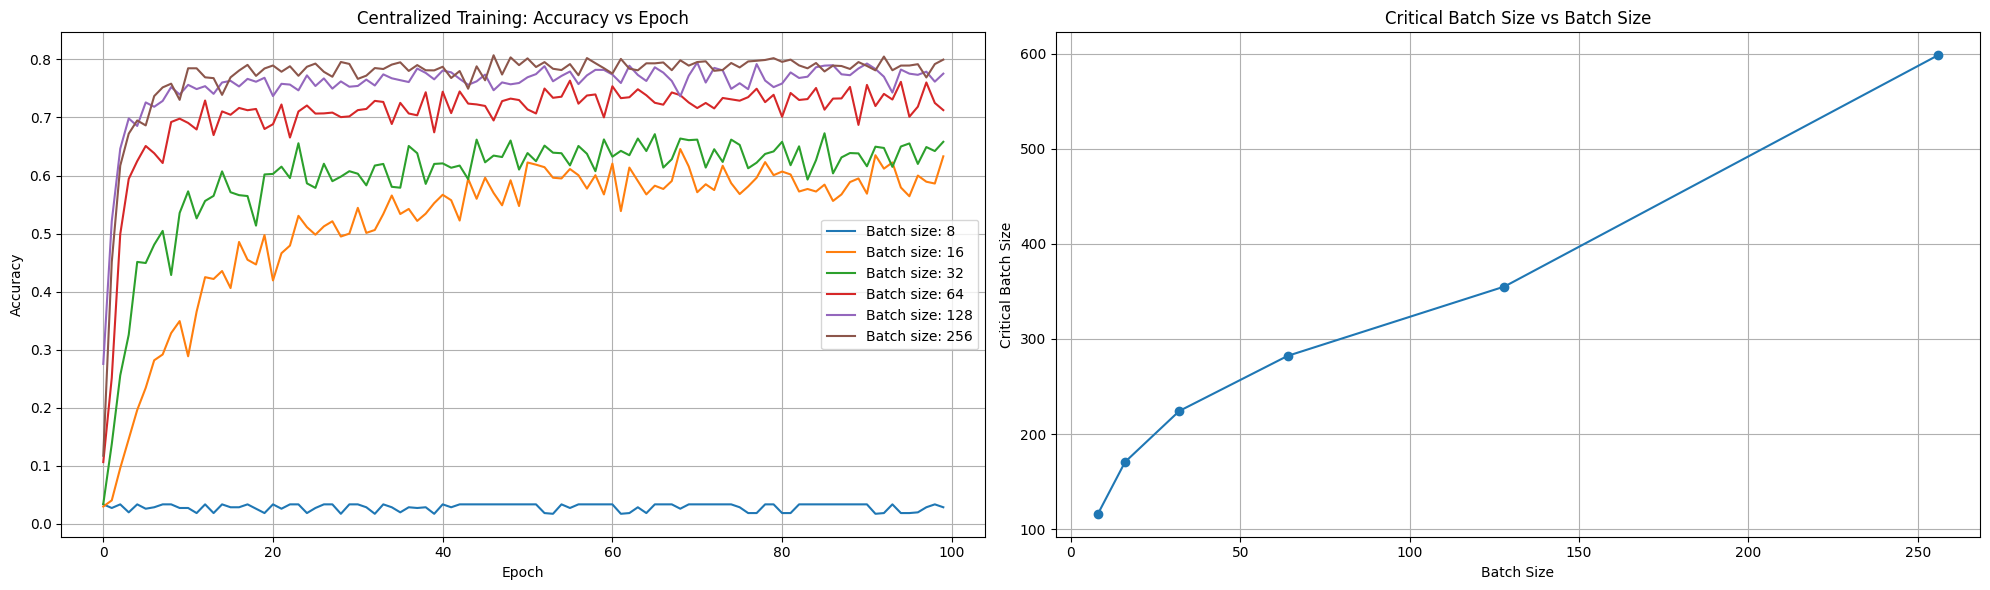

In [8]:
centralized_total_batch_results = []
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Epoch for each batch size configuration
for batch_size, results in centralized_experiment_results:
    axes[0].plot(results["accuracies"], label=f"Batch size: {batch_size}")
    bcrit = compute_critical_batch(results["noise_scales"], constant=0.01)
    centralized_total_batch_results.append((batch_size, bcrit))
    # Logging information (optional)
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Accuracies: {results['accuracies']}")
    log(INFO, f"Losses: {results['losses']}")
    log(INFO, f"Noise scales: {results['noise_scales']}")
    log(INFO, f"Critical batch size: {bcrit}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Centralized Training: Accuracy vs Epoch")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Critical Batch Size vs Batch Size
batch_sizes = [bs for bs, _ in centralized_total_batch_results]
bcrit_values = [bcrit for _, bcrit in centralized_total_batch_results]

axes[1].plot(batch_sizes, bcrit_values, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Critical Batch Size")
axes[1].set_title("Critical Batch Size vs Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

### **FL run with varying batch sizes**

In [9]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

INFO flwr 2025-02-24 12:55:48,964 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 12:55:48,969 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 12:55:48,972 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 12:55:48,974 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 12:55:48,977 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 12:55:48,980 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 12:55:48,982 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 12:55:48,985 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 12:55:48,988 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:55:48,991 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 12:55:48,994 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 12:55:48,996 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 12:55:48,999 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 12:55:49,002 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 12:55:49,006 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 12:55:49,009 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 12:55:49,014 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 12:55:49,017 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 12:55:49,021 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 12:55:49,025 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 12:55:49,030 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 12:55:49,037 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 12:55:49,042 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 12:55:49,045 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 12:55:49,049 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 12:55:49,056 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 12:55:49,061 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 12:55:49,065 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 12:55:49,069 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 12:55:49,073 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 12:55:49,077 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 12:55:49,081 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 12:55:49,084 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 12:55:49,090 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 12:55:49,094 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 12:55:49,101 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 12:55:49,105 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 12:55:49,109 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 12:55:49,115 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 12:55:49,118 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 12:55:49,124 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 12:55:49,131 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 12:55:49,137 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 12:55:49,141 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 12:55:49,144 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 12:55:49,147 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 12:55:49,149 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 12:55:49,152 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 12:55:49,155 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 12:55:49,159 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 12:55:49,161 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 12:55:49,165 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 12:55:49,167 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 12:55:49,170 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 12:55:49,172 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 12:55:49,176 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 12:55:49,178 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 12:55:49,182 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 12:55:49,185 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 12:55:49,188 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 12:55:49,190 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 12:55:49,193 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 12:55:49,197 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 12:55:49,199 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 12:55:49,203 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 12:55:49,205 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 12:55:49,209 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 12:55:49,212 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 12:55:49,216 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 12:55:49,219 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 12:55:49,222 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 12:55:49,224 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 12:55:49,227 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 12:55:49,230 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 12:55:49,233 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 12:55:49,237 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 12:55:49,239 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 12:55:49,242 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 12:55:49,243 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 12:55:49,245 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 12:55:49,249 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 12:55:49,251 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 12:55:49,255 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 12:55:49,257 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 12:55:49,260 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 12:55:49,262 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 12:55:49,264 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 12:55:49,268 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 12:55:49,271 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 12:55:49,273 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 12:55:49,275 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 12:55:49,278 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 12:55:49,280 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 12:55:49,282 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 12:55:49,285 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:55:49,288 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 12:55:49,290 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 12:55:49,294 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 12:55:49,297 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 12:55:49,299 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 12:55:49,302 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 12:55:49,304 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 12:55:49,306 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 12:55:49,306 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 12:55:49,307 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:17, 50.18it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:16, 52.93it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:16, 53.73it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:15, 57.52it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:15, 56.56it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:15, 56.21it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:14, 58.14it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:14, 57.33it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:14, 55.69it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:15, 54.90it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:14, 55.41it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:14, 56.58it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:14, 55.06it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:15, 52.49it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:15, 53.20it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:14, 55.60it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:13, 56.16it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:01<00:13, 56.57it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:13, 56.76it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:13, 56.68it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:02<00:13, 55.29it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:13, 54.53it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:13, 56.85it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:02<00:12, 57.20it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:02<00:12, 56.81it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:13, 55.81it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:13, 54.22it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:13, 54.96it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:13, 54.40it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:03<00:12, 54.49it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:03<00:13, 53.44it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:03<00:12, 54.61it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:03<00:12, 53.47it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:13, 52.53it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:03<00:12, 53.10it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:04<00:12, 52.85it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:04<00:12, 52.25it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:04<00:12, 52.34it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:12, 53.29it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:04<00:12, 53.38it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:12, 53.24it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:12, 52.40it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:11, 52.54it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:11, 54.21it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:05<00:11, 54.49it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:05<00:10, 55.82it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:05<00:10, 56.71it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:05<00:10, 57.20it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:05<00:09, 59.48it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:05<00:09, 60.55it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:05<00:09, 62.03it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:05<00:09, 63.19it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:05<00:08, 63.62it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:05<00:08, 63.29it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:06<00:08, 64.89it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:06<00:08, 67.28it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:06<00:08, 66.58it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:06<00:07, 66.65it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:06<00:07, 66.46it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:06<00:07, 67.07it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:06<00:07, 67.60it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:06<00:07, 67.22it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:06<00:07, 62.90it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:07<00:08, 57.07it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:07<00:08, 56.13it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:07<00:08, 53.16it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:07<00:09, 51.36it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:07<00:09, 49.94it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:09, 50.44it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:07<00:08, 53.38it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:08, 54.95it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:08<00:07, 54.81it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:08<00:07, 55.64it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:08<00:07, 56.18it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:08<00:07, 56.36it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:08<00:07, 56.62it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:08<00:06, 58.75it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:08<00:06, 57.43it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:08<00:06, 57.91it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:08<00:07, 55.02it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:09<00:07, 53.13it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:09<00:06, 54.36it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:09<00:06, 53.09it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:09<00:06, 53.47it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:09<00:06, 54.20it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:09<00:06, 51.91it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:09<00:07, 49.18it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:09<00:06, 51.37it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:09<00:06, 53.30it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:10<00:06, 53.90it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:10<00:05, 54.95it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:10<00:05, 56.78it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:10<00:05, 57.33it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:10<00:05, 54.67it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:10<00:05, 53.86it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:10<00:05, 56.94it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:10<00:04, 57.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:10<00:04, 57.26it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:11<00:04, 56.35it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:11<00:04, 56.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:11<00:04, 57.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:11<00:04, 55.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:11<00:04, 54.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:11<00:04, 53.31it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:11<00:04, 51.06it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:11<00:04, 53.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:11<00:04, 54.05it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:12<00:04, 52.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:12<00:03, 52.96it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:12<00:03, 53.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:12<00:03, 54.31it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:12<00:03, 54.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:12<00:03, 55.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:12<00:03, 52.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:12<00:03, 51.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:12<00:03, 53.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:13<00:02, 54.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:13<00:02, 55.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:13<00:02, 54.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:13<00:02, 60.27it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:13<00:02, 63.74it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:13<00:01, 66.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:13<00:01, 74.41it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:13<00:01, 79.02it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:13<00:01, 77.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:14<00:01, 76.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:14<00:01, 75.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:14<00:00, 75.10it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:14<00:00, 74.04it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:14<00:00, 72.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:14<00:00, 72.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:14<00:00, 72.61it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:14<00:00, 68.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:14<00:00, 67.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:15<00:00, 59.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:15<00:00, 58.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:15<00:00, 56.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:15<00:00, 53.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 57.51it/s]


INFO flwr 2025-02-24 12:56:05,121 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 12:56:05,122 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 12:56:05,123 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:56:05,124 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 12:56:05,126 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 12:56:05,128 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 12:56:05,130 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 12:56:05,134 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 12:56:05,139 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 12:56:05,143 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 12:56:05,167 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 12:56:05,173 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 12:56:05,175 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 12:56:17,575 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:14, 59.25it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:14, 59.97it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:15, 57.35it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:15, 54.55it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:16, 52.98it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:15, 55.69it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:15, 55.49it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:14, 56.43it/s]

  6%|██████▉                                                                                                      | 57/891 [00:00<00:14, 59.15it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:14, 57.20it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:14, 56.45it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:14, 56.16it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:14, 55.60it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:14, 55.59it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:14, 56.22it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:14, 56.26it/s]

 12%|████████████▊                                                                                               | 106/891 [00:01<00:13, 56.94it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:14, 54.96it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:13, 58.37it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:13, 57.16it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:14, 54.17it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:02<00:12, 57.93it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:02<00:12, 58.16it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:12, 57.61it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:12, 57.52it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:02<00:13, 55.64it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:03<00:13, 51.96it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:03<00:13, 51.89it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:03<00:13, 54.45it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:03<00:12, 55.21it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:03<00:13, 53.28it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:13, 52.54it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:13, 51.94it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:12, 55.21it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:03<00:11, 56.37it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:04<00:10, 60.80it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:10, 62.78it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:10, 64.79it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:04<00:09, 66.79it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:09, 66.89it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:09, 66.85it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:09, 66.14it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:09, 65.47it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:09, 65.98it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 66.60it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:05<00:08, 66.04it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:05<00:09, 65.16it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:05<00:09, 63.41it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:09, 62.92it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:08, 64.31it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:05<00:08, 64.71it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:05<00:08, 65.00it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:05<00:08, 65.24it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:05<00:08, 64.31it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:06<00:08, 66.00it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:06<00:08, 65.18it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:06<00:08, 62.11it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:06<00:08, 62.75it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:06<00:08, 57.53it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:06<00:08, 56.41it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:06<00:08, 58.57it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:06<00:08, 58.36it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:07<00:08, 55.84it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:07<00:08, 55.95it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:07<00:08, 53.51it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:07<00:08, 51.34it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:07<00:08, 52.82it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:07<00:08, 55.53it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:07<00:07, 56.14it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:07<00:07, 54.50it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:07, 53.94it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:08<00:07, 53.20it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:08<00:07, 52.02it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:08<00:07, 52.11it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:08<00:08, 50.34it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:08<00:07, 49.98it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:08<00:07, 53.93it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:08<00:06, 55.16it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:08<00:06, 57.06it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:06, 56.38it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:09<00:06, 55.26it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:09<00:06, 56.96it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:09<00:05, 58.89it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:09<00:06, 56.75it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:09<00:05, 57.36it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:09<00:05, 55.88it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:09<00:05, 56.48it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:05, 57.64it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:09<00:05, 59.23it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:10<00:05, 57.09it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:10<00:05, 57.50it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:10<00:05, 56.87it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:10<00:04, 60.00it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:10<00:04, 59.60it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:10<00:04, 60.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:10<00:04, 60.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:10<00:04, 62.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:10<00:03, 63.52it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:11<00:03, 65.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:11<00:03, 65.42it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:11<00:03, 67.19it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:11<00:03, 68.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:11<00:03, 68.21it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:11<00:03, 67.73it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:03, 66.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:11<00:02, 67.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:11<00:02, 67.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:12<00:02, 67.16it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:12<00:02, 67.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:12<00:02, 66.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:12<00:02, 65.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:12<00:02, 64.74it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:12<00:02, 61.28it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:12<00:02, 59.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:12<00:02, 60.19it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:12<00:02, 59.32it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:13<00:02, 57.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:13<00:01, 57.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:13<00:01, 57.46it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:13<00:01, 59.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:13<00:01, 61.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:13<00:01, 63.76it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:13<00:01, 62.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:13<00:01, 64.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:13<00:00, 66.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:14<00:00, 66.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:14<00:00, 64.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:14<00:00, 66.39it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:14<00:00, 67.03it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:14<00:00, 66.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:14<00:00, 67.37it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:14<00:00, 65.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:14<00:00, 63.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 63.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 59.82it/s]


INFO flwr 2025-02-24 12:56:32,728 | server_returns_parameters.py:120 | fit progress: (1, 3404.726475715637, {'accuracy': 0.07969133637320239}, 27.60589893400902)


INFO flwr 2025-02-24 12:56:32,729 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 12:56:32,730 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:56:32,731 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 12:56:32,734 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 12:56:32,734 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 12:56:32,736 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 12:56:32,742 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 12:56:32,744 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 12:56:32,747 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 12:56:32,748 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 12:56:32,750 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 12:56:32,753 | flwr_core.py:103 | cid: 1260


DEBUG flwr 2025-02-24 12:56:44,228 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:18, 48.78it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:16, 54.60it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:15, 56.34it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:15, 55.31it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:16, 53.86it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:16, 52.88it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:15, 54.47it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:15, 54.06it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:15, 53.47it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:14, 56.15it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:14, 57.33it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:14, 56.97it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:14, 57.14it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:13, 58.10it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:13, 57.51it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:14, 53.90it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:15, 52.31it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:14, 54.60it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:13, 57.37it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:12, 59.49it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:10, 72.55it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:02<00:08, 84.49it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:08, 85.76it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:02<00:09, 75.32it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:02<00:10, 70.22it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:02<00:10, 68.05it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:03<00:10, 67.19it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:03<00:10, 67.69it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:10, 67.91it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:09, 68.40it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:09, 68.31it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:03<00:09, 69.80it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:03<00:09, 69.59it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:03<00:09, 67.21it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:03<00:09, 65.20it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:09, 65.35it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:09, 65.92it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:09, 62.48it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:09, 62.76it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:09, 63.53it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 63.00it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:04<00:09, 64.22it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:04<00:09, 65.02it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:08, 64.58it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:08, 63.90it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:08, 63.41it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:05<00:08, 64.02it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:05<00:08, 63.63it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:05<00:08, 63.23it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:05<00:08, 64.38it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:05<00:08, 65.21it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:05<00:07, 66.83it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:05<00:07, 66.10it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:06<00:07, 67.46it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:06<00:07, 68.12it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:06<00:07, 67.81it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:07, 67.58it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:06<00:07, 66.43it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:06<00:06, 68.15it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:06, 67.12it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:06<00:06, 67.78it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:06<00:06, 66.21it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:06, 67.91it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:06, 69.06it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:06, 67.78it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:07<00:06, 67.84it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:07<00:06, 63.46it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:07<00:06, 62.27it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:07<00:06, 60.39it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:07<00:06, 59.73it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:07<00:06, 59.58it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:06, 62.40it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:05, 65.97it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:05, 66.96it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:08<00:05, 66.46it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:05, 63.63it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:08<00:05, 63.55it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:08<00:05, 64.55it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:08<00:05, 59.98it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:08<00:05, 62.32it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:09<00:05, 62.65it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:09<00:05, 61.76it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:09<00:04, 62.97it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:09<00:04, 63.44it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:09<00:04, 60.90it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:09<00:04, 61.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:09<00:04, 62.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:09<00:04, 61.75it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:09<00:04, 60.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:10<00:04, 57.41it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:10<00:04, 55.77it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:10<00:04, 54.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:10<00:04, 56.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:10<00:04, 53.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:10<00:04, 52.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:10<00:04, 53.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:04, 51.00it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:11<00:04, 49.73it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:11<00:03, 50.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:11<00:03, 50.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:03, 52.50it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:11<00:03, 52.86it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:11<00:03, 52.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:11<00:03, 51.50it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:11<00:03, 50.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:11<00:03, 49.88it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:12<00:02, 52.41it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:12<00:02, 55.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:12<00:02, 56.29it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:12<00:02, 54.23it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:12<00:02, 53.86it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:12<00:02, 54.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:02, 54.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:12<00:01, 55.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:12<00:01, 54.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:13<00:01, 53.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:13<00:01, 52.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:13<00:01, 51.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:13<00:01, 52.93it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:13<00:01, 55.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:13<00:01, 55.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:01, 55.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:00, 57.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:13<00:00, 56.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:14<00:00, 57.98it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:14<00:00, 59.75it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:14<00:00, 61.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:14<00:00, 63.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:14<00:00, 63.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:14<00:00, 65.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 60.91it/s]


INFO flwr 2025-02-24 12:56:59,132 | server_returns_parameters.py:120 | fit progress: (2, 3169.5579314231873, {'accuracy': 0.11725710277095756}, 54.01031076797517)


INFO flwr 2025-02-24 12:56:59,133 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 12:56:59,134 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:56:59,135 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 12:56:59,137 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 12:56:59,139 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 12:56:59,141 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:56:59,144 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 12:56:59,150 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 12:56:59,151 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 12:56:59,154 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 12:56:59,158 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:56:59,160 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 12:57:09,700 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:17, 51.13it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 54.94it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:14, 59.22it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:15, 55.45it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:16, 52.66it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:15, 53.81it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:14, 58.14it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:14, 59.64it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:13, 60.55it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:13, 59.96it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:13, 62.06it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:13, 62.07it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:12, 62.88it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:12, 62.19it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:12, 62.88it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:12, 61.86it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:12, 61.23it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:02<00:12, 60.53it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:02<00:12, 59.80it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:09, 77.28it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:09, 80.56it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:09, 73.31it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:02<00:11, 64.49it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:02<00:12, 59.49it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:02<00:11, 59.56it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:12, 58.07it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:03<00:11, 58.36it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:03<00:11, 61.00it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:03<00:11, 60.97it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:03<00:11, 56.95it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:03<00:11, 58.46it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:03<00:11, 58.45it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:03<00:11, 57.79it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:03<00:11, 56.70it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:04<00:11, 56.36it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:04<00:11, 56.00it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:04<00:11, 55.60it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:04<00:11, 56.82it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:04<00:11, 55.63it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:04<00:10, 58.59it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:04<00:10, 59.32it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:04<00:09, 60.64it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:04<00:09, 63.49it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:05<00:09, 62.39it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:05<00:09, 62.09it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:05<00:09, 60.57it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:08, 62.73it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:09, 59.36it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:05<00:09, 60.81it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:05<00:08, 61.37it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:08, 60.49it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:06<00:08, 61.29it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:06<00:08, 63.11it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:06<00:08, 62.27it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:06<00:07, 64.00it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:06<00:07, 64.42it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:07, 63.89it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:06<00:07, 62.81it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:06<00:07, 62.90it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:07, 62.80it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:06<00:07, 62.94it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:07<00:07, 62.66it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:07, 62.84it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 61.41it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:07<00:07, 60.95it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:07<00:06, 61.38it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:07<00:06, 62.37it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:07<00:06, 62.68it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:07<00:06, 63.11it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:07<00:06, 64.09it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:08<00:06, 64.35it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:08<00:05, 67.28it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:08<00:05, 69.07it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:05, 69.68it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:08<00:05, 69.43it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:08<00:05, 69.57it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:08<00:05, 68.35it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:08<00:04, 69.71it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:08<00:04, 70.64it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:09<00:04, 71.25it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:09<00:04, 71.62it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:04, 72.12it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:09<00:04, 72.54it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:09<00:04, 69.14it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:09<00:04, 65.98it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:04, 60.19it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:09<00:04, 58.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:10<00:04, 56.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:10<00:04, 56.75it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:10<00:04, 59.43it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:10<00:04, 59.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:10<00:04, 58.71it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:10<00:03, 59.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:10<00:03, 59.58it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:10<00:03, 61.62it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:10<00:03, 62.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:11<00:03, 62.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:03, 60.65it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:11<00:03, 61.18it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:11<00:03, 60.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:11<00:03, 58.39it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:11<00:03, 55.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:11<00:02, 56.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:11<00:02, 57.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:11<00:02, 56.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:12<00:02, 58.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:12<00:02, 57.14it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:12<00:02, 55.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:12<00:02, 56.23it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:12<00:02, 56.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:01, 58.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:01, 59.96it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:12<00:01, 61.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:01, 62.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:13<00:01, 60.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:13<00:01, 58.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:13<00:01, 63.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:13<00:00, 66.37it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:13<00:00, 64.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:13<00:00, 61.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:13<00:00, 59.46it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:13<00:00, 60.31it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:14<00:00, 61.02it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:14<00:00, 58.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:14<00:00, 58.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:14<00:00, 58.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:14<00:00, 56.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 61.44it/s]


INFO flwr 2025-02-24 12:57:24,460 | server_returns_parameters.py:120 | fit progress: (3, 2296.5615246891975, {'accuracy': 0.4176429323044546}, 79.33744755899534)


INFO flwr 2025-02-24 12:57:24,460 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 12:57:24,461 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:57:24,463 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 12:57:24,465 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 12:57:24,468 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 12:57:24,471 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 12:57:24,473 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 12:57:24,476 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 12:57:24,478 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 12:57:24,483 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 12:57:24,485 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 12:57:24,491 | flwr_core.py:103 | cid: 1258


DEBUG flwr 2025-02-24 12:57:34,325 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:18, 46.89it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:18, 47.86it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:16, 54.21it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:15, 55.40it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:16, 51.24it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:17, 49.48it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:16, 50.73it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:16, 51.91it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:15, 55.33it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:15, 53.50it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:15, 53.05it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:15, 54.39it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:14, 55.60it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:14, 55.73it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:13, 57.42it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:01<00:13, 57.91it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:12, 60.69it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:13, 59.23it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:12, 61.15it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:12, 60.48it/s]

 15%|████████████████                                                                                            | 133/891 [00:02<00:11, 65.79it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:10, 71.66it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:10, 72.09it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:09, 74.07it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:10, 71.93it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:02<00:10, 71.20it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:10, 68.37it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:10, 67.27it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:03<00:10, 67.21it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:03<00:10, 67.26it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:03<00:10, 66.06it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:03<00:10, 65.68it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:03<00:10, 64.51it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:10, 64.76it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:03<00:10, 63.35it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:09, 65.99it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:04<00:09, 68.51it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:04<00:09, 66.96it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:09, 66.48it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:08, 68.35it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:08, 68.81it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 66.15it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:04<00:09, 62.70it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:04<00:09, 61.55it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:05<00:09, 61.37it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:09, 60.19it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:10, 54.88it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:10, 53.93it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:05<00:10, 55.18it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:05<00:09, 55.86it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:05<00:09, 56.04it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:05<00:09, 57.67it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:05<00:09, 57.85it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:06<00:09, 55.97it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:06<00:09, 55.25it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:06<00:09, 55.78it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:09, 52.95it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:06<00:09, 52.54it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:06<00:09, 52.08it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:09, 52.50it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:06<00:08, 55.25it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:06<00:08, 56.22it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:07<00:08, 57.20it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:07<00:08, 57.23it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:07, 57.77it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:07, 57.60it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 59.84it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:07, 58.46it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:07<00:07, 56.89it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:07<00:07, 57.98it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:07<00:06, 59.62it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:08<00:06, 61.10it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:08<00:06, 60.59it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:08<00:06, 60.70it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:08<00:06, 61.52it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:08<00:06, 61.84it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:06, 59.55it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:08<00:06, 61.26it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:08<00:06, 59.48it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:08<00:05, 60.04it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:09<00:05, 58.28it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:09<00:06, 56.66it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:09<00:05, 55.96it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:09<00:05, 56.72it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:09<00:05, 56.63it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:09<00:05, 55.84it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:09<00:05, 57.27it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:09<00:05, 59.10it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:09<00:05, 58.94it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:10<00:04, 61.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:10<00:04, 61.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:10<00:04, 58.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:10<00:04, 58.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:10<00:04, 58.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:10<00:04, 59.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:10<00:04, 62.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:03, 62.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:10<00:03, 61.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:11<00:03, 64.81it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:11<00:03, 65.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:11<00:03, 64.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:11<00:03, 65.37it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:11<00:02, 67.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:11<00:02, 68.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:11<00:02, 69.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:11<00:02, 69.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:11<00:01, 88.07it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:12<00:01, 99.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:12<00:01, 87.48it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:12<00:01, 81.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:12<00:01, 79.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:12<00:01, 79.13it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:12<00:01, 73.35it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:01, 68.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:12<00:01, 64.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:13<00:01, 62.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:13<00:01, 60.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:13<00:01, 57.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:01, 55.36it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:13<00:00, 53.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:13<00:00, 53.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:13<00:00, 53.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:13<00:00, 58.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:14<00:00, 61.04it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:14<00:00, 63.42it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:14<00:00, 63.09it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:14<00:00, 64.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 61.72it/s]


INFO flwr 2025-02-24 12:57:49,040 | server_returns_parameters.py:120 | fit progress: (4, 2477.0402017235756, {'accuracy': 0.4260259558049807}, 103.91732375900028)


INFO flwr 2025-02-24 12:57:49,040 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 12:57:49,041 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:57:49,042 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 12:57:49,044 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 12:57:49,048 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 12:57:49,051 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 12:57:49,053 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 12:57:49,054 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 12:57:49,056 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:57:49,057 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 12:57:49,059 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 12:57:49,062 | flwr_core.py:103 | cid: 937


DEBUG flwr 2025-02-24 12:57:59,274 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:16, 53.73it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 57.16it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:15, 55.19it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:16, 52.75it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:16, 52.60it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:15, 55.90it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:15, 56.43it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:15, 53.06it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:15, 53.83it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:14, 55.40it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:14, 56.63it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:14, 55.48it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:14, 56.12it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:13, 58.28it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:13, 59.47it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:12, 61.47it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:12, 62.13it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:02<00:12, 61.65it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:02<00:12, 60.71it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:02<00:12, 60.29it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:02<00:11, 67.83it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:02<00:10, 70.58it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:02<00:10, 72.51it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:02<00:10, 69.15it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:02<00:10, 67.32it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:02<00:11, 64.85it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:03<00:11, 63.80it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:03<00:11, 63.00it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:03<00:10, 63.89it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:03<00:10, 64.11it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:10, 65.84it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:10, 64.13it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:03<00:10, 65.00it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:03<00:10, 65.39it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:03<00:09, 66.56it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:04<00:09, 68.81it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:09, 70.45it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:04<00:09, 69.29it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:04<00:09, 68.41it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:04<00:09, 62.24it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:04<00:10, 56.37it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:04<00:10, 59.77it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:04<00:09, 64.36it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:04<00:09, 64.36it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:05<00:09, 63.49it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:05<00:08, 63.79it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:05<00:08, 62.88it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:05<00:09, 57.85it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:05<00:09, 56.06it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:05<00:09, 56.20it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:05<00:09, 56.37it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:05<00:09, 57.02it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:09, 57.29it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:06<00:08, 57.82it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:06<00:08, 57.18it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:06<00:08, 58.37it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:06<00:08, 58.06it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:06<00:08, 59.13it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:06<00:08, 56.89it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:06<00:08, 54.66it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:06<00:08, 57.03it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:08, 56.78it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:07<00:08, 56.79it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:07, 58.36it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:08, 54.64it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:07<00:07, 56.01it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:07, 57.51it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:07<00:07, 58.91it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:07<00:06, 61.04it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:07<00:06, 60.83it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:07<00:07, 57.50it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:08<00:07, 56.34it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:08<00:06, 56.96it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:08<00:06, 59.17it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:08<00:06, 59.06it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:08<00:06, 56.85it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:08<00:06, 58.17it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:08<00:06, 58.98it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:08<00:06, 57.97it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:05, 59.51it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:09<00:05, 58.82it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:09<00:05, 60.04it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:09<00:05, 59.82it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:09<00:05, 59.81it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:09<00:05, 56.26it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:09<00:05, 53.68it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:09<00:05, 53.16it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:09<00:05, 55.50it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:10<00:04, 58.67it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:10<00:04, 62.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:10<00:04, 63.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:10<00:04, 66.58it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:10<00:03, 68.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:10<00:03, 68.51it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:10<00:03, 68.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:10<00:03, 68.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:10<00:03, 67.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:10<00:03, 69.31it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:11<00:03, 65.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:11<00:03, 67.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:02, 69.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:11<00:02, 70.19it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:11<00:02, 73.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:11<00:02, 76.22it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:11<00:01, 99.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 745/891 [00:11<00:01, 107.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:11<00:01, 95.41it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:12<00:01, 91.14it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:12<00:01, 83.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:01, 74.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:12<00:01, 69.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:12<00:01, 71.34it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:12<00:01, 72.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:12<00:01, 61.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:13<00:01, 59.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:13<00:01, 59.93it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:13<00:00, 60.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:13<00:00, 62.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:13<00:00, 61.37it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:13<00:00, 61.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:13<00:00, 62.03it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:13<00:00, 62.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:13<00:00, 59.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:14<00:00, 57.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.80it/s]

INFO flwr 2025-02-24 12:58:13,718 | server_returns_parameters.py:120 | fit progress: (5, 2669.5542111992836, {'accuracy': 0.3923535601543318}, 128.59626229200512)


INFO flwr 2025-02-24 12:58:13,719 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 12:58:13,720 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:58:13,721 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 12:58:13,723 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 12:58:13,725 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 12:58:13,727 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 12:58:13,730 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 12:58:13,734 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 12:58:13,736 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 12:58:13,737 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 12:58:13,740 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 12:58:13,742 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 12:58:24,101 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 56.94it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:14, 60.54it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:13, 64.05it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:13, 63.79it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:13, 64.61it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:13, 63.25it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:13, 62.77it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:13, 62.78it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:13, 62.69it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:13, 59.36it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:14, 57.97it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:14, 57.32it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:14, 53.90it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:15, 52.47it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:14, 54.00it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:14, 55.26it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:13, 56.97it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:13, 56.89it/s]

 14%|███████████████                                                                                             | 124/891 [00:02<00:13, 56.68it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:12, 59.88it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:02<00:11, 64.72it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:02<00:11, 67.42it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:02<00:10, 70.05it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:11, 65.44it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:02<00:11, 60.20it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:02<00:12, 58.04it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:03<00:12, 57.91it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:12, 57.73it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:03<00:12, 54.44it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:03<00:12, 55.54it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:03<00:12, 55.93it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:11, 56.61it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:11, 56.81it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:11, 56.39it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:11, 55.51it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:04<00:11, 54.81it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:04<00:11, 57.40it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:11, 58.09it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:10, 58.23it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:04<00:10, 59.40it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:10, 59.45it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:04<00:10, 59.58it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:04<00:09, 61.98it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 66.60it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:04<00:08, 68.61it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:05<00:08, 72.22it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:05<00:07, 72.27it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:07, 76.64it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:05<00:06, 79.83it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:05<00:06, 78.73it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:05<00:07, 75.14it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:07, 74.40it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:06, 75.56it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:05<00:06, 76.61it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:06<00:06, 78.98it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:06<00:06, 80.92it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:06<00:06, 78.78it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:06<00:05, 81.05it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:06<00:06, 78.10it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:06, 70.61it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:06<00:07, 64.01it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:06<00:07, 60.54it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:07<00:06, 64.00it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:06, 63.03it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:06, 64.17it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:07<00:07, 59.79it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:07<00:07, 55.81it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:07<00:07, 55.25it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:07<00:06, 58.11it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:07<00:06, 59.08it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:07<00:06, 60.26it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:06, 60.66it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:05, 64.18it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:05, 62.61it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:08<00:05, 59.88it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:06, 57.66it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:08<00:06, 56.85it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:08<00:05, 58.85it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:08<00:05, 59.90it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:09<00:05, 59.34it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:09<00:05, 59.32it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:09<00:05, 59.86it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:09<00:05, 58.07it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:09<00:05, 58.95it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:09<00:05, 57.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:09<00:04, 59.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:09<00:04, 58.50it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:09<00:04, 60.00it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:10<00:04, 60.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:10<00:04, 62.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:10<00:03, 65.78it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:03, 65.98it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:10<00:03, 68.49it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:10<00:03, 68.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:10<00:03, 65.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:10<00:03, 68.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:10<00:02, 70.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:02, 68.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:11<00:02, 68.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:11<00:02, 67.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:11<00:02, 64.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:11<00:01, 84.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:11<00:01, 95.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:11<00:01, 83.22it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:11<00:01, 75.26it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:12<00:01, 71.38it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:01, 66.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:01, 63.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:12<00:01, 61.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:01, 60.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:12<00:01, 59.30it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:12<00:01, 56.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:12<00:01, 56.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:12<00:01, 58.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:00, 62.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:00, 64.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:13<00:00, 64.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:13<00:00, 65.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:13<00:00, 64.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:13<00:00, 66.78it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:13<00:00, 70.93it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:13<00:00, 71.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.02it/s]


INFO flwr 2025-02-24 12:58:38,337 | server_returns_parameters.py:120 | fit progress: (6, 2518.2653506696224, {'accuracy': 0.4662223781129428}, 153.21500525297597)


INFO flwr 2025-02-24 12:58:38,338 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 12:58:38,338 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:58:38,339 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 12:58:38,342 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 12:58:38,345 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 12:58:38,347 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 12:58:38,348 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 12:58:38,355 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 12:58:38,358 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 12:58:38,360 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 12:58:38,367 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 12:58:38,368 | flwr_core.py:103 | cid: 2343


DEBUG flwr 2025-02-24 12:58:49,928 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 66.73it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 63.84it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:14, 61.59it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:14, 58.63it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:14, 59.68it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:13, 61.16it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:13, 60.30it/s]

  6%|██████▉                                                                                                      | 57/891 [00:00<00:13, 64.15it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:12, 66.39it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:13, 62.15it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:13, 60.79it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:13, 59.57it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:13, 58.17it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:13, 59.91it/s]

 12%|████████████▊                                                                                               | 106/891 [00:01<00:12, 60.89it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:01<00:13, 57.62it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:01<00:12, 61.64it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:02<00:11, 64.81it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:11, 68.44it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:02<00:10, 68.26it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:11, 65.76it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:02<00:10, 66.71it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:10, 66.53it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:02<00:10, 66.26it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:02<00:11, 61.16it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:03<00:11, 59.67it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:03<00:11, 61.15it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:03<00:10, 63.28it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:11, 60.18it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:03<00:11, 58.10it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:11, 57.70it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:03<00:11, 57.05it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:03<00:10, 61.87it/s]

 27%|█████████████████████████████▎                                                                              | 242/891 [00:03<00:10, 61.69it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:04<00:10, 59.83it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:10, 60.16it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:04<00:09, 65.54it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:04<00:09, 66.71it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:09, 67.58it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:04<00:09, 66.96it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:04<00:09, 63.02it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:09, 63.55it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:09, 64.50it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:05<00:08, 65.64it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:08, 69.27it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:08, 65.12it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:05<00:08, 61.93it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:05<00:08, 62.02it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:05<00:08, 60.23it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:05<00:08, 59.17it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:09, 57.95it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:05<00:08, 57.82it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:06<00:08, 59.45it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:06<00:08, 58.33it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:06<00:08, 56.98it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:06<00:08, 56.85it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:06<00:08, 58.84it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:06<00:08, 57.92it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:06<00:08, 56.27it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:08, 57.92it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:06<00:07, 59.91it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:07<00:07, 61.59it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:07<00:07, 61.46it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:07<00:06, 63.20it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:07<00:06, 62.29it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:07<00:06, 65.16it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:07<00:06, 65.99it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:07<00:06, 66.86it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:07<00:05, 67.67it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:07<00:05, 68.18it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:08<00:05, 68.05it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:08<00:05, 68.99it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:05, 66.72it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:08<00:05, 67.25it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:08<00:05, 67.12it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:08<00:05, 67.75it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:08<00:05, 68.34it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:08<00:04, 68.81it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:08<00:04, 68.77it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:08<00:04, 66.85it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:09<00:05, 61.31it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:09<00:05, 59.14it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:09<00:04, 61.66it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:09<00:04, 60.90it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:09<00:04, 64.40it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:09<00:04, 64.95it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:09<00:04, 66.23it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:09<00:04, 65.14it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:09<00:04, 65.41it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:10<00:03, 65.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:10<00:03, 66.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:10<00:03, 66.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:10<00:03, 67.90it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:10<00:03, 68.99it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:10<00:03, 66.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:10<00:03, 65.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:10<00:03, 65.09it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:10<00:03, 64.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:11<00:02, 66.23it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:11<00:02, 63.55it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:11<00:02, 62.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:11<00:02, 64.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:11<00:02, 71.28it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:11<00:01, 77.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:11<00:01, 71.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:11<00:01, 66.99it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:12<00:02, 60.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:12<00:02, 56.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:02, 56.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:12<00:01, 54.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:12<00:01, 53.29it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:12<00:01, 54.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:12<00:01, 55.57it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:12<00:01, 53.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:12<00:01, 53.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:13<00:01, 55.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:13<00:01, 56.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:01, 56.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:13<00:00, 55.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:13<00:00, 53.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:13<00:00, 49.35it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:13<00:00, 50.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 51.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:14<00:00, 53.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:14<00:00, 55.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:14<00:00, 54.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:14<00:00, 54.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 61.84it/s]


INFO flwr 2025-02-24 12:59:04,591 | server_returns_parameters.py:120 | fit progress: (7, 2340.322188794613, {'accuracy': 0.47944580848824975}, 179.46838403801667)


INFO flwr 2025-02-24 12:59:04,591 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 12:59:04,593 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:59:04,594 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 12:59:04,596 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 12:59:04,598 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 12:59:04,599 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 12:59:04,603 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 12:59:04,604 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 12:59:04,605 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 12:59:04,607 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 12:59:04,609 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 12:59:04,613 | flwr_core.py:103 | cid: 3178


DEBUG flwr 2025-02-24 12:59:13,771 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:18, 47.70it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:16, 52.89it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:15, 57.66it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:14, 58.86it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:14, 59.22it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:14, 60.80it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:13, 62.55it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:12, 65.29it/s]

  7%|███████▎                                                                                                     | 60/891 [00:00<00:12, 66.00it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:12, 65.50it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:12, 64.14it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:13, 61.10it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:01<00:13, 60.67it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:01<00:13, 60.85it/s]

 11%|████████████▎                                                                                               | 102/891 [00:01<00:12, 61.36it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:01<00:12, 61.68it/s]

 13%|██████████████                                                                                              | 116/891 [00:01<00:12, 61.88it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:12, 61.54it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:12, 61.37it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:12, 62.10it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:02<00:11, 63.34it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:11, 63.97it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:11, 64.90it/s]

 19%|████████████████████                                                                                        | 165/891 [00:02<00:11, 65.21it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:02<00:11, 65.13it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:02<00:10, 65.66it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:02<00:10, 65.85it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:03<00:10, 65.80it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:10, 65.60it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:03<00:10, 65.87it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:03<00:10, 65.68it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:10, 65.03it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:10, 66.01it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:03<00:09, 65.78it/s]

 27%|█████████████████████████████▎                                                                              | 242/891 [00:03<00:10, 63.75it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:03<00:10, 61.82it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:10, 61.68it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:04<00:09, 63.76it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:04<00:09, 62.95it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:04<00:09, 62.23it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:04<00:09, 60.76it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:04<00:09, 61.68it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:04<00:09, 62.18it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:04<00:09, 59.06it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:09, 58.87it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:05<00:09, 58.12it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:05<00:09, 58.53it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:09, 57.22it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:05<00:09, 57.07it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:09, 58.26it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:05<00:09, 58.73it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:05<00:09, 59.51it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:05<00:08, 63.82it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:05<00:07, 66.13it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:06<00:07, 67.58it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:07, 66.19it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:06<00:07, 66.35it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:06<00:07, 63.35it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:06<00:08, 56.53it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:06<00:09, 52.96it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:06<00:09, 51.08it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:06<00:09, 50.39it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:07<00:09, 50.07it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:07<00:08, 51.91it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:07<00:08, 54.52it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:07<00:07, 55.27it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:07, 56.21it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:07, 58.42it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:07<00:07, 59.02it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:07<00:07, 59.00it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:07<00:07, 56.75it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:08<00:07, 56.72it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:08<00:06, 58.99it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:08<00:06, 59.69it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:08<00:06, 59.49it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:08<00:06, 58.24it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:06, 60.10it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:08<00:06, 59.86it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:06, 59.36it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:05, 58.85it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:09<00:05, 59.83it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:09<00:05, 60.77it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:09<00:05, 60.41it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:09<00:05, 57.44it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:09<00:05, 54.40it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:09<00:05, 56.31it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:09<00:05, 56.52it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:09<00:05, 57.78it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:09<00:05, 57.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:10<00:04, 57.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:10<00:04, 58.71it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:10<00:04, 57.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:10<00:04, 57.03it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:10<00:04, 54.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:10<00:04, 56.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:10<00:04, 58.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:10<00:03, 61.24it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:10<00:03, 60.72it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:11<00:03, 61.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:11<00:03, 65.08it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:11<00:03, 66.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:11<00:02, 67.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:11<00:02, 68.39it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:11<00:02, 70.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:11<00:02, 70.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:11<00:02, 69.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:11<00:02, 67.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:12<00:02, 66.58it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:12<00:02, 66.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:12<00:02, 65.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:12<00:02, 66.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:12<00:01, 66.19it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:12<00:01, 63.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:01, 63.34it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:01, 62.96it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:12<00:01, 63.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:13<00:01, 58.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:13<00:01, 54.95it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:13<00:01, 55.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:13<00:01, 55.48it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:13<00:01, 53.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:13<00:01, 56.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:13<00:00, 55.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:13<00:00, 50.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:14<00:00, 53.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:14<00:00, 65.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:14<00:00, 86.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 108.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.10it/s]


INFO flwr 2025-02-24 12:59:28,371 | server_returns_parameters.py:120 | fit progress: (8, 2125.2207372039557, {'accuracy': 0.5605752367590319}, 203.24891082698014)


INFO flwr 2025-02-24 12:59:28,372 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 12:59:28,373 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:59:28,374 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 12:59:28,376 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 12:59:28,377 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 12:59:28,379 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 12:59:28,381 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 12:59:28,385 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 12:59:28,386 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 12:59:28,389 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 12:59:28,390 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 12:59:28,391 | flwr_core.py:103 | cid: 70


DEBUG flwr 2025-02-24 12:59:39,337 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:16, 53.29it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:17, 51.70it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:16, 54.49it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:15, 56.75it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:15, 56.69it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:15, 56.50it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:14, 56.89it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:14, 59.19it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:14, 59.04it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:14, 58.31it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:14, 58.10it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:14, 57.29it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:14, 57.26it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:14, 57.15it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:13, 57.63it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:14, 56.15it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:13, 56.70it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:14, 53.75it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:13, 56.18it/s]

 14%|███████████████                                                                                             | 124/891 [00:02<00:13, 57.81it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:13, 57.70it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:13, 55.08it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:13, 53.57it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:02<00:14, 49.91it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:02<00:14, 51.62it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:14, 51.32it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:13, 53.09it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:13, 52.62it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:13, 52.44it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:03<00:12, 55.41it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:12, 55.39it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:11, 60.53it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:10, 63.13it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:03<00:10, 67.43it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:10, 65.06it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:10, 64.72it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:04<00:09, 67.08it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:04<00:09, 66.39it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:04<00:09, 67.88it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:04<00:08, 71.10it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:04<00:08, 72.71it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:04<00:08, 72.03it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:08, 73.81it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:04<00:08, 70.96it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:04<00:08, 70.58it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:05<00:07, 74.82it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:05<00:07, 74.28it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:07, 74.00it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:05<00:07, 78.27it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:07, 77.27it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:05<00:06, 80.08it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:05<00:07, 75.64it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:05<00:07, 71.13it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:05<00:06, 74.67it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:06<00:07, 71.17it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:06<00:07, 70.51it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:06<00:07, 66.53it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:06<00:07, 65.30it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:06<00:07, 64.34it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:07, 62.27it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:06<00:07, 59.48it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:06<00:07, 59.87it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:07<00:07, 59.97it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:07<00:07, 60.96it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:07<00:07, 60.53it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:07<00:06, 61.01it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:07<00:06, 62.46it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:07<00:06, 63.06it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:07<00:06, 64.26it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:07<00:06, 61.63it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:07<00:06, 60.04it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:08<00:06, 58.12it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:08<00:06, 59.76it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:08<00:06, 60.43it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:08<00:05, 62.16it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:05, 64.10it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:08<00:05, 64.85it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:08<00:05, 59.26it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:08<00:05, 60.26it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:09<00:05, 61.85it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:09<00:05, 63.01it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:09<00:04, 64.24it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:04, 65.21it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:09<00:04, 63.33it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:09<00:04, 62.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:04, 62.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:09<00:04, 62.33it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:09<00:04, 63.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:10<00:04, 57.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:10<00:04, 57.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:10<00:04, 55.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:10<00:04, 52.67it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:10<00:04, 53.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:10<00:04, 54.38it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:10<00:04, 52.69it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:10<00:04, 50.37it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:10<00:04, 49.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:11<00:04, 52.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:11<00:03, 53.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:11<00:03, 54.38it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:11<00:03, 56.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:03, 53.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:11<00:03, 53.20it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:11<00:03, 57.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:11<00:02, 55.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:12<00:02, 53.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:12<00:02, 55.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:12<00:02, 52.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:12<00:02, 53.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:12<00:02, 54.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:12<00:02, 56.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:12<00:02, 57.46it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:12<00:01, 58.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:12<00:01, 59.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:13<00:01, 58.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:13<00:01, 59.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:13<00:01, 62.01it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:13<00:01, 63.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:13<00:01, 66.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:13<00:00, 67.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:00, 68.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:13<00:00, 69.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:13<00:00, 74.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:13<00:00, 85.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:14<00:00, 91.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:14<00:00, 97.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.48it/s]


INFO flwr 2025-02-24 12:59:53,853 | server_returns_parameters.py:120 | fit progress: (9, 2090.5587688088417, {'accuracy': 0.5236057523675903}, 228.73085564002395)


INFO flwr 2025-02-24 12:59:53,854 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 12:59:53,855 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 12:59:53,856 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 12:59:53,859 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 12:59:53,863 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 12:59:53,865 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 12:59:53,869 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 12:59:53,876 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 12:59:53,882 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 12:59:53,886 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 12:59:53,892 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 12:59:53,895 | flwr_core.py:103 | cid: 2274


DEBUG flwr 2025-02-24 13:00:05,132 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 59.65it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:14, 59.31it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:14, 58.70it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:14, 60.78it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:14, 58.13it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:14, 58.63it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:14, 58.06it/s]

  6%|██████▎                                                                                                      | 52/891 [00:00<00:14, 59.06it/s]

  7%|███████▏                                                                                                     | 59/891 [00:00<00:13, 60.89it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:13, 60.78it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:13, 61.36it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:13, 60.68it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:13, 60.24it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:13, 60.41it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:13, 59.89it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:12, 61.68it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:01<00:12, 62.96it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:02<00:11, 64.26it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:02<00:12, 63.33it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:11, 64.41it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:11, 62.51it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:12, 61.27it/s]

 18%|███████████████████                                                                                         | 157/891 [00:02<00:12, 59.83it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:02<00:12, 56.62it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:02<00:12, 56.17it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:02<00:12, 55.53it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:13, 53.35it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:03<00:13, 52.64it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:03<00:13, 51.32it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:13, 51.09it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:13, 50.90it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:13, 52.21it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:03<00:12, 53.20it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:03<00:13, 50.68it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:04<00:13, 49.70it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:04<00:13, 48.17it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:13, 47.75it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:04<00:13, 48.28it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:04<00:12, 50.72it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:04<00:12, 51.12it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:04<00:12, 49.44it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:12, 50.49it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:04<00:11, 52.63it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:05<00:10, 55.84it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:10, 59.10it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:05<00:09, 60.37it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:05<00:09, 61.62it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:05<00:10, 57.67it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:05<00:09, 57.95it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:05<00:09, 57.57it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:09, 60.51it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:09, 60.60it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:06<00:08, 62.51it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:06<00:08, 63.21it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:06<00:08, 61.89it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:06<00:08, 59.75it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:06<00:08, 59.35it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:06<00:08, 60.26it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:06<00:08, 62.85it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:06<00:07, 63.18it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:07, 63.99it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:07<00:07, 65.75it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:07<00:07, 64.82it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:07<00:07, 65.88it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:07<00:06, 66.32it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:06, 66.23it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:07<00:06, 66.10it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:07<00:06, 65.92it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:06, 63.96it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:06, 63.86it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:08<00:06, 63.51it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:08<00:06, 61.96it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:08<00:06, 62.91it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:08<00:06, 63.92it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:08<00:06, 63.52it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:08<00:05, 65.07it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:08<00:05, 64.48it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:05, 62.65it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:05, 63.63it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:08<00:05, 64.89it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:09<00:05, 65.30it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:09<00:05, 65.45it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:09<00:05, 65.86it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:09<00:04, 66.03it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:09<00:04, 65.87it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:09<00:04, 66.43it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:09<00:04, 62.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:09<00:04, 60.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:10<00:05, 57.34it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:10<00:05, 57.37it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:10<00:05, 54.90it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:10<00:04, 55.77it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:10<00:04, 55.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:10<00:05, 52.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:10<00:05, 51.73it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:10<00:04, 52.07it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:10<00:04, 54.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:11<00:04, 54.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:11<00:04, 55.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:11<00:03, 58.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:11<00:03, 59.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:11<00:03, 58.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:11<00:03, 57.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:03, 60.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:11<00:03, 60.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:11<00:03, 58.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:12<00:03, 57.71it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:12<00:02, 61.09it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:12<00:02, 62.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:12<00:02, 60.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:12<00:02, 60.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:12<00:02, 60.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:12<00:02, 62.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:12<00:02, 62.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:12<00:02, 61.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:13<00:01, 61.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:13<00:01, 60.31it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:13<00:01, 58.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:13<00:01, 58.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:13<00:01, 56.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:13<00:01, 56.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:13<00:01, 58.51it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:13<00:01, 60.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:13<00:01, 61.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:14<00:00, 63.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:14<00:00, 63.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:14<00:00, 62.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:14<00:00, 71.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:14<00:00, 81.20it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:14<00:00, 85.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:14<00:00, 88.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 60.57it/s]


INFO flwr 2025-02-24 13:00:20,096 | server_returns_parameters.py:120 | fit progress: (10, 2361.4128391444683, {'accuracy': 0.46902841108383025}, 254.97390338702826)


INFO flwr 2025-02-24 13:00:20,097 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:00:20,097 | server_returns_parameters.py:150 | FL finished in 254.9749600160285


INFO flwr 2025-02-24 13:00:20,098 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:00:20,098 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.3422949454059985, 'all': [(20, 0.2768842503428459), (20, 0.15892832744866608), (33, 0.27332913965889905), (19, 0.4179195102892424), (30, 0.44059288104375205), (33, 0.18834379744349103), (45, 0.4422623528374566), (18, 0.2702142604523235), (17, 0.42316915533121896), (32, 0.4476092690601945)]}), (2, {'avg': 0.20432003781082123, 'all': [(34, 0.18768482918248458), (20, 0.4273964732885361), (43, 0.19564507763053096), (19, 0.11217494112880606), (17, 0.21348947768702226), (29, 0.19771304765138134), (34, 0.1563523132354021), (20, 0.1832210611552), (19, 0.2600594194311845), (19, 0.16523607271282295)]}), (3, {'avg': 0.08283333988909267, 'all': [(17, 0.06896248569383341), (34, 0.07310467613313128), (18, 0.08464432373229), (43, 0.0951313846419717), (19, 0.09522581737684577), (19, 0.08403183019867069), (20, 0.07186022726818919), (19, 0.06817960812661208), (20, 0.08410365674644708), (19, 0.

INFO flwr 2025-02-24 13:00:20,099 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:00:20,099 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3404.726475715637), (2, 3169.5579314231873), (3, 2296.5615246891975), (4, 2477.0402017235756), (5, 2669.5542111992836), (6, 2518.2653506696224), (7, 2340.322188794613), (8, 2125.2207372039557), (9, 2090.5587688088417), (10, 2361.4128391444683)]


INFO flwr 2025-02-24 13:00:20,100 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.07969133637320239), (2, 0.11725710277095756), (3, 0.4176429323044546), (4, 0.4260259558049807), (5, 0.3923535601543318), (6, 0.4662223781129428), (7, 0.47944580848824975), (8, 0.5605752367590319), (9, 0.5236057523675903), (10, 0.46902841108383025)]}


INFO flwr 2025-02-24 13:00:20,110 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:00:20,113 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:00:20,115 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:00:20,118 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:00:20,120 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:00:20,123 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:00:20,124 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:00:20,127 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:00:20,130 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:00:20,132 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:00:20,134 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:00:20,137 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:00:20,139 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:00:20,142 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:00:20,145 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:00:20,147 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:00:20,150 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:00:20,152 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:00:20,154 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:00:20,157 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:00:20,160 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:00:20,164 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:00:20,166 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:00:20,169 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:00:20,171 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:00:20,175 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:00:20,177 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:00:20,180 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:00:20,182 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:00:20,184 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:00:20,187 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:00:20,189 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:00:20,191 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:00:20,195 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:00:20,197 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:00:20,201 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:00:20,204 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:00:20,206 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:00:20,210 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:00:20,212 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:00:20,215 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:00:20,219 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:00:20,223 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:00:20,225 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:00:20,228 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:00:20,230 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:00:20,233 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:00:20,235 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:00:20,239 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:00:20,242 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:00:20,245 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:00:20,248 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:00:20,251 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:00:20,253 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:00:20,256 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:00:20,258 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:00:20,260 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:00:20,264 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:00:20,268 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:00:20,271 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:00:20,273 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:00:20,276 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:00:20,279 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:00:20,282 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:00:20,285 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:00:20,288 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:00:20,290 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:00:20,294 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:00:20,298 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:00:20,301 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:00:20,304 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:00:20,306 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:00:20,308 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:00:20,311 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:00:20,314 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:00:20,318 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:00:20,320 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:00:20,323 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:00:20,325 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:00:20,327 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:00:20,330 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:00:20,333 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:00:20,337 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:00:20,339 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:00:20,342 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:00:20,344 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:00:20,347 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:00:20,351 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:00:20,354 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:00:20,357 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:00:20,360 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:00:20,362 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:00:20,365 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:00:20,367 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:00:20,370 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:00:20,373 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:00:20,375 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:00:20,379 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:00:20,382 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:00:20,385 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:00:20,387 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:00:20,396 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:00:20,396 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:00:20,397 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:00:20,401 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 65.75it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:14, 62.50it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:14, 59.31it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:14, 58.78it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:14, 58.55it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:14, 58.57it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:14, 60.09it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:13, 61.80it/s]

  7%|███████▎                                                                                                     | 60/891 [00:00<00:12, 64.17it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:12, 65.58it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:12, 65.45it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:11, 67.93it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:01<00:11, 67.41it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:01<00:11, 70.19it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:11, 67.47it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:11, 66.27it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:01<00:11, 67.95it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:01<00:11, 68.95it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:10, 71.01it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:02<00:10, 72.44it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:02<00:10, 69.89it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:10, 70.62it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:02<00:10, 71.46it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:02<00:10, 71.04it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:02<00:09, 71.87it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:02<00:09, 73.01it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:02<00:09, 72.06it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:09, 71.90it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:03<00:09, 70.87it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:03<00:09, 71.06it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:03<00:09, 68.50it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:03<00:09, 67.47it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:03<00:09, 68.29it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:03<00:09, 68.58it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:03<00:09, 66.70it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:03<00:09, 62.34it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:04<00:10, 60.72it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:04<00:10, 60.28it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:04<00:09, 60.66it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:04<00:09, 61.95it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:04<00:09, 61.26it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:04<00:09, 61.10it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:04<00:09, 61.36it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:04<00:09, 62.38it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:09, 59.43it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:05<00:09, 55.58it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:05<00:09, 55.12it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:05<00:10, 53.92it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:05<00:09, 53.79it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:05<00:09, 53.73it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:05<00:09, 53.93it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:05<00:09, 54.85it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:05<00:09, 56.23it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:08, 60.14it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:06<00:08, 61.44it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:06<00:08, 59.20it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:06<00:07, 60.51it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:07, 62.75it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:07, 65.61it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:06<00:06, 66.79it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:06<00:06, 68.42it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:06<00:06, 69.90it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:07<00:06, 70.09it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:07<00:06, 66.43it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:07<00:06, 64.32it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:07<00:06, 63.71it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:07<00:06, 61.30it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:07<00:06, 61.67it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:07<00:06, 60.37it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:07<00:06, 58.75it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:07<00:06, 60.33it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:08<00:06, 60.56it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:08<00:05, 62.05it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:08<00:05, 62.78it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:08<00:05, 61.01it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:08<00:05, 61.39it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:08<00:05, 62.80it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:08<00:05, 59.88it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                       | 566/891 [00:08<00:05, 60.10it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:09<00:05, 60.86it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:09<00:05, 61.74it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:09<00:04, 64.51it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:09<00:04, 62.75it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:09<00:04, 62.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:09<00:04, 59.47it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:09<00:04, 58.27it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:09<00:04, 58.21it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:09<00:04, 57.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:10<00:04, 57.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:10<00:04, 57.47it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:10<00:04, 59.13it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:10<00:03, 60.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:10<00:03, 61.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:10<00:03, 56.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:10<00:03, 58.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 61.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:10<00:03, 59.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:11<00:03, 60.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:11<00:03, 62.50it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:11<00:02, 65.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:11<00:02, 64.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:11<00:02, 63.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:11<00:02, 62.96it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:11<00:02, 64.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:11<00:02, 63.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:11<00:02, 66.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:12<00:01, 68.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:12<00:01, 71.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:12<00:01, 73.16it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:01, 74.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:12<00:01, 73.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:12<00:01, 74.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:12<00:01, 75.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:12<00:00, 75.40it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:12<00:00, 74.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:00, 67.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:00, 63.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:13<00:00, 60.93it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:13<00:00, 72.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:13<00:00, 76.35it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:13<00:00, 79.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:13<00:00, 83.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.70it/s]


INFO flwr 2025-02-24 13:00:34,421 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:00:34,422 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:00:34,423 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:00:34,424 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:00:34,428 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:00:34,432 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:00:34,434 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:00:34,439 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:00:34,441 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:00:34,445 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:00:34,450 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:00:34,451 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:00:34,454 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 13:00:44,506 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 67.39it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 66.58it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 66.11it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:13, 64.00it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:13, 63.07it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:13, 64.56it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:13, 60.21it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:14, 57.79it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:14, 56.93it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:14, 56.42it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:14, 56.85it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:14, 56.77it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:14, 54.95it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:14, 55.06it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:15, 52.68it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:14, 53.31it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:01<00:14, 55.26it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:13, 57.73it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:13, 58.24it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:13, 57.86it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:13, 55.60it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:13, 56.03it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:12, 58.43it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:13, 56.03it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:02<00:13, 54.99it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:02<00:13, 55.20it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:03<00:13, 52.86it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:03<00:13, 52.73it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:03<00:13, 53.39it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:03<00:12, 54.66it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:03<00:12, 54.62it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:03<00:12, 55.10it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:03<00:13, 51.08it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:03<00:13, 51.67it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:03<00:12, 53.46it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:04<00:12, 53.35it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:04<00:12, 52.98it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:12, 53.49it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:12, 52.32it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:04<00:12, 51.34it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:04<00:11, 55.45it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:04<00:10, 58.02it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:04<00:10, 59.52it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:04<00:09, 62.09it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:05<00:09, 62.49it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:05<00:09, 62.99it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:05<00:09, 63.98it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:05<00:09, 63.78it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:05<00:09, 63.92it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:05<00:08, 64.61it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:08, 65.95it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:08, 64.77it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:05<00:07, 71.93it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:06<00:07, 71.18it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:06<00:07, 67.98it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:06<00:07, 67.98it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:06<00:07, 66.20it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:06<00:07, 65.99it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:06<00:07, 66.26it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:06<00:07, 66.80it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:06<00:07, 64.24it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:06<00:07, 61.19it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:07<00:08, 57.82it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:07<00:08, 56.98it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:07<00:08, 55.23it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:08, 55.58it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:07<00:07, 58.19it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 57.90it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:07, 56.96it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:07<00:07, 58.15it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:07<00:07, 58.60it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:08<00:07, 58.09it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:08<00:07, 58.34it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:08<00:07, 55.38it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:08<00:07, 55.87it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:08<00:06, 56.29it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:08<00:06, 57.91it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:08<00:06, 60.57it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:06, 59.20it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:05, 61.26it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:09<00:05, 62.48it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:09<00:05, 62.66it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:09<00:05, 60.61it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:09<00:05, 59.11it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:09<00:05, 59.52it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:09<00:05, 59.61it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:09<00:05, 61.17it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:09<00:05, 61.49it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:09<00:05, 60.31it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:10<00:04, 61.52it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:10<00:04, 62.67it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:10<00:04, 63.39it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:10<00:04, 61.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:10<00:04, 61.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:10<00:04, 62.25it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:10<00:04, 60.46it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:10<00:04, 60.47it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:10<00:03, 61.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:11<00:03, 59.30it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:11<00:03, 57.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:11<00:03, 57.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:11<00:03, 58.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:11<00:03, 60.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:11<00:03, 61.97it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:11<00:03, 60.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:02, 62.33it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:12<00:02, 62.35it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:02, 58.38it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:12<00:02, 57.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:12<00:02, 59.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:12<00:02, 58.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:12<00:02, 59.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:12<00:02, 59.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:12<00:02, 59.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:12<00:02, 58.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:13<00:02, 57.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:13<00:01, 57.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:13<00:01, 56.37it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:13<00:01, 57.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:13<00:01, 58.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:13<00:01, 59.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:13<00:01, 61.31it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:13<00:01, 62.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:13<00:01, 61.18it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:14<00:00, 62.07it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:14<00:00, 63.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:14<00:00, 65.71it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:14<00:00, 71.22it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:14<00:00, 77.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:14<00:00, 79.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:14<00:00, 83.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 60.40it/s]


INFO flwr 2025-02-24 13:00:59,444 | server_returns_parameters.py:120 | fit progress: (1, 3454.1801936626434, {'accuracy': 0.07969133637320239}, 25.02145660604583)


INFO flwr 2025-02-24 13:00:59,445 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:00:59,445 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:00:59,446 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:00:59,448 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:00:59,452 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:00:59,453 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:00:59,455 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:00:59,458 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:00:59,460 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:00:59,463 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:00:59,464 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:00:59,467 | flwr_core.py:103 | cid: 1260


DEBUG flwr 2025-02-24 13:01:08,962 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 66.86it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 67.32it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:12, 67.02it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:12, 67.37it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:12, 67.65it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:11, 70.97it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:11, 73.30it/s]

  7%|███████▏                                                                                                     | 59/891 [00:00<00:11, 74.72it/s]

  8%|████████▏                                                                                                    | 67/891 [00:00<00:11, 74.88it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:11, 74.04it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:11, 72.34it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:11, 70.70it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:11, 70.21it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:11, 68.32it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:11, 64.90it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:01<00:13, 56.91it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:01<00:13, 58.05it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:02<00:13, 57.39it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:02<00:13, 55.97it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:02<00:13, 56.92it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:02<00:12, 56.98it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:13, 56.28it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:02<00:13, 55.46it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:02<00:13, 54.95it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:02<00:12, 55.76it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:02<00:12, 56.63it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:12, 56.05it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:03<00:12, 56.32it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:03<00:12, 55.81it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:03<00:12, 56.52it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:11, 56.60it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:12, 55.76it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:11, 56.02it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:11, 56.61it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:11, 57.11it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:03<00:11, 58.32it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:11, 55.11it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:11, 54.97it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:11, 55.62it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:11, 56.10it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:10, 57.14it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:04<00:10, 57.86it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:04<00:10, 56.06it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:04<00:10, 57.90it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:04<00:09, 59.32it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:05<00:09, 59.58it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:05<00:09, 59.60it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:05<00:09, 60.68it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:05<00:09, 61.83it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:05<00:08, 62.02it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:05<00:08, 61.76it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:05<00:08, 66.52it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:05<00:07, 67.03it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:05<00:07, 69.70it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:06<00:07, 71.24it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:06<00:07, 68.94it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:06<00:07, 68.61it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:06<00:07, 67.10it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:06<00:07, 66.01it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:06<00:07, 66.52it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:06<00:07, 63.84it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:08, 57.76it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:06<00:08, 57.16it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:07<00:07, 57.56it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:07<00:08, 56.34it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:07<00:07, 57.65it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:07<00:07, 57.69it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:07<00:07, 56.97it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:07<00:07, 58.93it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:07<00:06, 60.45it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:07<00:06, 60.35it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:07<00:06, 59.87it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:08<00:06, 58.57it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:08<00:06, 60.01it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:08<00:06, 61.46it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:08<00:05, 63.34it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:05, 64.06it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:08<00:05, 63.84it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:08<00:05, 65.01it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:08<00:05, 65.81it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:08<00:05, 66.67it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:09<00:04, 67.45it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:09<00:04, 68.54it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:09<00:04, 67.68it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:09<00:04, 67.14it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:09<00:04, 66.43it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:09<00:04, 66.32it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:09<00:04, 67.01it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:09<00:04, 67.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:04, 67.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:09<00:04, 67.50it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:10<00:03, 67.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:10<00:03, 68.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:10<00:03, 68.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:10<00:03, 69.10it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:10<00:03, 67.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:10<00:03, 66.43it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:10<00:03, 65.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:10<00:03, 63.31it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:10<00:03, 64.00it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:11<00:03, 60.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:11<00:03, 60.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:03, 61.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:11<00:02, 62.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:11<00:02, 58.99it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:11<00:02, 56.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:11<00:02, 57.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:11<00:02, 57.00it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:11<00:02, 55.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:12<00:02, 57.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:12<00:02, 57.12it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:12<00:02, 57.51it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:12<00:02, 56.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:12<00:02, 56.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:12<00:01, 56.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:12<00:01, 54.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:12<00:01, 53.60it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:12<00:01, 54.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:13<00:01, 52.73it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:13<00:01, 53.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:13<00:01, 55.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:13<00:01, 56.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:13<00:01, 56.98it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:13<00:00, 58.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:13<00:00, 57.93it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:13<00:00, 62.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:13<00:00, 68.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:14<00:00, 70.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:14<00:00, 72.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:14<00:00, 75.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.04it/s]


INFO flwr 2025-02-24 13:01:23,577 | server_returns_parameters.py:120 | fit progress: (2, 2942.241175889969, {'accuracy': 0.15878639074009118}, 49.15409646905027)


INFO flwr 2025-02-24 13:01:23,577 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:01:23,578 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:01:23,579 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:01:23,582 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:01:23,584 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:01:23,587 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:01:23,590 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:01:23,593 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:01:23,596 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:01:23,599 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:01:23,601 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:01:23,602 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 13:01:32,080 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 58.06it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 57.32it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:15, 56.26it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:15, 57.32it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:15, 56.00it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:14, 58.30it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:13, 60.62it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:13, 61.91it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:13, 63.59it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:12, 64.30it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:12, 63.07it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:13, 61.11it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:13, 61.77it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:12, 63.43it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:12, 62.38it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:12, 61.90it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:12, 62.51it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:01<00:12, 62.75it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:02<00:11, 63.93it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:12, 62.29it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:12, 61.67it/s]

 17%|██████████████████                                                                                          | 149/891 [00:02<00:11, 62.81it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:11, 62.41it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:11, 62.16it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:02<00:12, 60.02it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:02<00:12, 58.77it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:03<00:11, 60.26it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:11, 61.04it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:03<00:11, 62.00it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:12, 56.99it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:11, 58.53it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:03<00:11, 56.29it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:11, 58.21it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:11, 57.40it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:03<00:11, 57.85it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:04<00:11, 56.75it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:04<00:10, 58.91it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:04<00:10, 59.06it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:04<00:10, 57.41it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:10, 58.02it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:10, 60.69it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:09, 63.13it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 64.84it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:04<00:09, 65.89it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:04<00:08, 67.63it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:05<00:08, 67.88it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:05<00:08, 68.62it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:05<00:08, 68.09it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:05<00:08, 67.23it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:07, 70.00it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:05<00:07, 69.94it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:07, 67.30it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:05<00:07, 66.01it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:05<00:07, 66.66it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:06<00:07, 67.00it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:07, 68.49it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:06<00:07, 68.72it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:06<00:07, 68.02it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:06<00:07, 65.65it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:07, 65.49it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:06<00:07, 60.79it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:06<00:07, 58.67it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:06<00:07, 58.26it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:07, 59.63it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 59.46it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:07, 58.04it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:07<00:06, 63.78it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:07<00:06, 63.36it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:07<00:06, 60.81it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:07<00:06, 61.21it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:07<00:06, 60.31it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:08<00:06, 60.45it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:08<00:06, 60.29it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:06, 61.89it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:05, 65.07it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:05, 65.76it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:05, 67.47it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:08<00:05, 66.52it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:08<00:05, 60.99it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:08<00:05, 61.29it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:09<00:05, 62.37it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:09<00:05, 64.06it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:09<00:05, 60.85it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:05, 57.98it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:09<00:05, 59.38it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:09<00:04, 62.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:09<00:04, 61.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:04, 64.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:09<00:04, 65.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:10<00:04, 64.97it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:10<00:03, 64.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:10<00:03, 62.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:03, 62.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:10<00:03, 60.60it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:10<00:03, 58.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:10<00:03, 58.84it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:10<00:03, 58.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 58.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:11<00:03, 57.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:03, 60.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:11<00:02, 65.25it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:11<00:02, 65.23it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:11<00:02, 64.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:11<00:02, 63.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:11<00:02, 62.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:11<00:02, 62.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:11<00:02, 63.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:12<00:02, 60.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:12<00:02, 60.77it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:12<00:02, 62.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:12<00:01, 63.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:12<00:01, 63.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:12<00:01, 63.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:12<00:01, 60.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:12<00:01, 56.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:13<00:01, 57.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:13<00:01, 57.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:13<00:01, 59.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:13<00:01, 61.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:13<00:00, 63.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:00, 65.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:13<00:00, 68.58it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:13<00:00, 73.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:13<00:00, 76.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:13<00:00, 77.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:14<00:00, 79.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.98it/s]


INFO flwr 2025-02-24 13:01:46,478 | server_returns_parameters.py:120 | fit progress: (3, 2074.6272554397583, {'accuracy': 0.49884251139950897}, 72.05564250104362)


INFO flwr 2025-02-24 13:01:46,479 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:01:46,480 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:01:46,482 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:01:46,485 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:01:46,488 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:01:46,490 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:01:46,491 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:01:46,494 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:01:46,496 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:01:46,498 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:01:46,500 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:01:46,502 | flwr_core.py:103 | cid: 1258


DEBUG flwr 2025-02-24 13:01:54,742 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 65.27it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:12, 67.54it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:12, 68.42it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:12, 68.72it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:12, 68.93it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:12, 68.21it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:12, 68.02it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:11, 71.02it/s]

  7%|████████                                                                                                     | 66/891 [00:00<00:11, 73.53it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:11, 71.08it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:11, 68.83it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:01<00:11, 68.63it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:01<00:12, 65.80it/s]

 12%|████████████▍                                                                                               | 103/891 [00:01<00:12, 62.42it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:12, 60.50it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:12, 59.95it/s]

 14%|███████████████                                                                                             | 124/891 [00:01<00:12, 59.81it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:01<00:12, 61.50it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:02<00:12, 60.14it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:12, 58.12it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:13, 54.82it/s]

 18%|███████████████████                                                                                         | 157/891 [00:02<00:13, 53.27it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:13, 53.77it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:02<00:13, 53.90it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:02<00:13, 54.00it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:02<00:13, 52.76it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:03<00:14, 50.03it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:03<00:13, 53.10it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:12, 53.79it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:12, 54.74it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:11, 56.69it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:12, 52.71it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:12, 51.91it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:12, 52.88it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:03<00:11, 56.01it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:04<00:11, 56.12it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:11, 56.36it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:11, 56.99it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:10, 57.31it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:10, 58.23it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:10, 60.77it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:04<00:09, 64.48it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:04<00:09, 63.37it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:04<00:10, 59.09it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:05<00:10, 57.81it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:05<00:10, 56.31it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:05<00:10, 55.65it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:05<00:10, 56.66it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:09, 58.35it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:05<00:09, 58.66it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:05<00:08, 64.76it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:05<00:08, 61.47it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:05<00:08, 62.23it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:06<00:08, 63.46it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:06<00:08, 63.39it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:06<00:08, 61.56it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:08, 58.44it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:06<00:08, 59.00it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:06<00:08, 59.50it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:06<00:08, 55.58it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:06<00:09, 52.60it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:07<00:08, 54.25it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:07<00:08, 54.97it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:07<00:07, 57.61it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:07<00:07, 59.79it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:07<00:07, 62.17it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:07<00:06, 62.99it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:07<00:06, 62.68it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:07<00:07, 59.31it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:07<00:06, 62.78it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:08<00:06, 65.57it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:08<00:06, 66.58it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:08<00:05, 67.69it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:08<00:05, 68.04it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:05, 68.49it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:08<00:05, 69.47it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:08<00:05, 70.58it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:08<00:04, 71.37it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:08<00:04, 71.30it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:09<00:05, 67.88it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:09<00:05, 60.31it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:09<00:05, 56.00it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:09<00:06, 53.30it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:09<00:06, 51.70it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:05, 52.39it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:09<00:05, 55.77it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:09<00:05, 58.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:10<00:04, 58.84it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:10<00:04, 56.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:10<00:04, 56.12it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:10<00:05, 53.39it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:10<00:05, 52.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:10<00:05, 50.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:10<00:04, 51.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:10<00:04, 53.09it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:10<00:04, 50.52it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:11<00:04, 51.03it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:11<00:04, 52.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:11<00:04, 51.92it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:11<00:04, 52.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:11<00:04, 52.20it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:11<00:03, 53.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:03, 56.32it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:11<00:03, 57.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:11<00:03, 55.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:12<00:03, 55.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:02, 58.79it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:12<00:03, 54.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:12<00:03, 52.24it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:12<00:02, 54.20it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:12<00:02, 55.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:12<00:02, 57.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:12<00:02, 56.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:12<00:02, 56.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:13<00:02, 56.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:13<00:02, 57.39it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:13<00:01, 57.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:13<00:01, 58.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:13<00:01, 58.21it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:13<00:01, 52.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:13<00:01, 52.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:13<00:01, 54.62it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:13<00:01, 53.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:14<00:01, 55.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:14<00:01, 56.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:14<00:00, 55.34it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:14<00:00, 56.14it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:14<00:00, 56.50it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:14<00:00, 61.09it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:14<00:00, 61.16it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:14<00:00, 63.37it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:14<00:00, 61.72it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:15<00:00, 64.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 58.73it/s]


INFO flwr 2025-02-24 13:02:10,200 | server_returns_parameters.py:120 | fit progress: (4, 2082.916177123785, {'accuracy': 0.5263767099263417}, 95.77767972199945)


INFO flwr 2025-02-24 13:02:10,201 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:02:10,202 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:02:10,203 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:02:10,206 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:02:10,208 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:02:10,209 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:02:10,210 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:02:10,211 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:02:10,215 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:02:10,217 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:02:10,221 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:02:10,224 | flwr_core.py:103 | cid: 937


DEBUG flwr 2025-02-24 13:02:18,542 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:17, 51.87it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:16, 51.95it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:15, 54.93it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:15, 55.55it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:16, 53.38it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:15, 53.75it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:15, 55.20it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:14, 56.39it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:13, 61.08it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:13, 63.58it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:12, 68.22it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:12, 65.52it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:11, 68.78it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:11, 69.82it/s]

 11%|████████████▎                                                                                               | 102/891 [00:01<00:10, 72.33it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:10, 74.53it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:01<00:10, 70.99it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:02<00:12, 61.80it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:11, 66.77it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:11, 67.05it/s]

 17%|██████████████████                                                                                          | 149/891 [00:02<00:10, 67.83it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:10, 68.12it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:10, 68.29it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:02<00:10, 70.51it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:02<00:09, 74.30it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:02<00:09, 75.86it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:02<00:08, 77.49it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:09, 75.93it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:08, 76.05it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:08, 77.07it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:03<00:09, 66.86it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:03<00:10, 65.11it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:03<00:10, 63.45it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:09, 65.52it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:03<00:09, 67.40it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:04<00:09, 68.42it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:08, 68.60it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:08, 68.78it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:04<00:08, 67.68it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:04<00:08, 67.48it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:08, 67.11it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:08, 67.16it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:04<00:08, 65.17it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:04<00:08, 65.05it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:04<00:08, 63.19it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:05<00:09, 60.33it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:05<00:08, 64.56it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:05<00:08, 63.53it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:05<00:09, 58.61it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:08, 58.47it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:05<00:09, 56.61it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:05<00:09, 56.00it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:05<00:09, 56.03it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:06<00:09, 54.77it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:06<00:08, 56.01it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:06<00:08, 54.54it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:06<00:08, 55.41it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:08, 58.03it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:08, 58.21it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:07, 58.17it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:06<00:07, 59.49it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:06<00:07, 60.53it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:06<00:07, 61.29it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:07, 61.77it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:07<00:06, 62.64it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:07<00:06, 61.28it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:07<00:07, 58.70it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:07<00:06, 59.05it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:07<00:06, 58.63it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:07<00:06, 60.84it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:07<00:06, 62.81it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:07<00:05, 64.20it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:05, 63.85it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:08<00:05, 61.93it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:08<00:05, 61.36it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:08<00:05, 60.93it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:08<00:06, 56.43it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:08<00:06, 55.58it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:08<00:05, 56.11it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:08<00:05, 58.54it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:05, 58.24it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:09<00:05, 58.67it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:09<00:05, 58.39it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:09<00:05, 55.48it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:09<00:04, 59.21it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:09<00:04, 60.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:09<00:04, 62.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:09<00:04, 65.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:09<00:04, 65.98it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:10<00:03, 66.41it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:10<00:03, 65.98it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:10<00:03, 62.58it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:10<00:03, 61.47it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:10<00:03, 62.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:10<00:03, 63.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:10<00:03, 64.38it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 66.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:10<00:02, 68.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:11<00:02, 69.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:02, 70.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:11<00:02, 70.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:11<00:02, 70.77it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:11<00:02, 69.89it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:11<00:02, 67.72it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:11<00:02, 69.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:11<00:01, 69.65it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:11<00:01, 70.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:12<00:01, 66.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:12<00:01, 67.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:12<00:01, 65.57it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:12<00:01, 65.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:12<00:01, 63.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:12<00:01, 60.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:12<00:01, 58.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:12<00:01, 60.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:12<00:01, 61.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:13<00:00, 61.40it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:13<00:00, 63.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:13<00:00, 57.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:13<00:00, 62.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:13<00:00, 62.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:13<00:00, 68.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:13<00:00, 71.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:13<00:00, 73.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.00it/s]


INFO flwr 2025-02-24 13:02:32,725 | server_returns_parameters.py:120 | fit progress: (5, 2198.3254224658012, {'accuracy': 0.5039284461592424}, 118.30198330804706)


INFO flwr 2025-02-24 13:02:32,725 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:02:32,726 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:02:32,727 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:02:32,730 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:02:32,733 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:02:32,735 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:02:32,736 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:02:32,737 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:02:32,739 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:02:32,741 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:02:32,742 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:02:32,743 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:02:41,466 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 61.23it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 62.95it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:15, 57.01it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:15, 56.83it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:15, 56.23it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:14, 58.59it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:13, 62.69it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:12, 64.58it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:13, 62.38it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:13, 59.64it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:12, 64.36it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:12, 64.24it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:12, 64.47it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:13, 60.98it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:12, 60.59it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:12, 62.20it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:01<00:12, 63.52it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:02<00:12, 63.01it/s]

 15%|████████████████                                                                                            | 133/891 [00:02<00:12, 61.56it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:02<00:12, 60.16it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:02<00:12, 59.19it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:02<00:12, 58.75it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:12, 60.85it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:02<00:11, 61.82it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:02<00:11, 61.22it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:02<00:11, 59.53it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:03<00:11, 60.93it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:03<00:11, 59.67it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:03<00:11, 59.85it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:03<00:11, 59.68it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:03<00:11, 57.77it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:03<00:11, 59.54it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:11, 59.31it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:03<00:11, 59.16it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:03<00:10, 59.61it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:04<00:10, 60.52it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:11, 55.44it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:11, 56.93it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:11, 55.21it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:11, 53.27it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:04<00:11, 53.04it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:04<00:11, 52.18it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:04<00:11, 52.73it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:05<00:10, 55.01it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:05<00:10, 55.22it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:05<00:10, 53.03it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:10, 55.63it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:10, 56.60it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:09, 58.63it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:05<00:09, 59.14it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:05<00:08, 61.05it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:05<00:08, 61.85it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:06<00:08, 62.33it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:06<00:08, 61.87it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:06<00:08, 63.03it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:06<00:07, 65.77it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:06<00:07, 68.28it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:06<00:07, 68.84it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:07, 68.17it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:06<00:06, 68.90it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:06, 69.41it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:07<00:06, 69.09it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:07<00:06, 68.90it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:06, 68.16it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:06, 67.73it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:06, 68.58it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:06, 65.71it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:07<00:06, 66.67it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:07<00:06, 64.43it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:07<00:06, 64.74it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:08<00:06, 60.17it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:08<00:06, 56.20it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:08<00:07, 53.13it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:08<00:07, 52.81it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:07, 53.26it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:08<00:07, 51.80it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:08<00:06, 53.71it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:06, 52.05it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:09<00:06, 52.83it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:09<00:06, 54.40it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:09<00:06, 54.82it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:09<00:05, 55.44it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:09<00:05, 56.35it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:09<00:05, 57.24it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:09<00:05, 55.57it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:05, 56.52it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:09<00:05, 57.85it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:09<00:05, 57.62it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:10<00:05, 55.27it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:10<00:04, 56.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:10<00:04, 57.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:10<00:04, 58.51it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:10<00:03, 65.98it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:10<00:04, 57.68it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:10<00:04, 57.75it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:10<00:04, 57.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:11<00:04, 57.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:11<00:03, 59.07it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:11<00:03, 58.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:11<00:03, 59.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:11<00:03, 61.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:11<00:03, 62.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:11<00:03, 61.45it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:03, 61.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:11<00:02, 61.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:02, 61.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:12<00:02, 60.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:12<00:02, 56.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:12<00:02, 56.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:12<00:02, 53.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:12<00:02, 54.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:12<00:02, 53.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 763/891 [00:12<00:02, 53.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:12<00:02, 55.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:13<00:01, 58.36it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:13<00:01, 58.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:13<00:01, 61.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:13<00:01, 63.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:13<00:01, 60.97it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:13<00:01, 59.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:13<00:01, 60.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:13<00:01, 61.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:13<00:00, 63.00it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:14<00:00, 61.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:14<00:00, 63.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:14<00:00, 63.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:14<00:00, 66.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:14<00:00, 72.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:14<00:00, 75.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:14<00:00, 74.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 60.30it/s]


INFO flwr 2025-02-24 13:02:56,496 | server_returns_parameters.py:120 | fit progress: (6, 1836.261777177453, {'accuracy': 0.5842160645387583}, 142.07330776599701)


INFO flwr 2025-02-24 13:02:56,496 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:02:56,497 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:02:56,498 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:02:56,500 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:02:56,502 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:02:56,504 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:02:56,508 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:02:56,510 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:02:56,513 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:02:56,517 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:02:56,519 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:02:56,522 | flwr_core.py:103 | cid: 2343


DEBUG flwr 2025-02-24 13:03:06,366 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 83.71it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 85.41it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 82.15it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 80.03it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:11, 75.77it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:11, 72.28it/s]

  7%|███████▍                                                                                                     | 61/891 [00:00<00:11, 71.73it/s]

  8%|████████▍                                                                                                    | 69/891 [00:00<00:11, 72.47it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:11, 70.15it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:11, 70.83it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:11, 70.55it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:11, 68.41it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:12, 64.88it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:01<00:12, 62.81it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:01<00:12, 61.78it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:01<00:13, 58.22it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:01<00:12, 59.38it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:12, 59.09it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:11, 62.76it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:11, 66.03it/s]

 19%|████████████████████                                                                                        | 165/891 [00:02<00:11, 63.29it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:02<00:11, 64.23it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:02<00:11, 63.65it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:02<00:11, 60.28it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:02<00:11, 61.50it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:03<00:10, 64.59it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:10, 65.62it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:03<00:10, 66.11it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:03<00:09, 67.94it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:03<00:09, 67.10it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:09, 67.51it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:03<00:09, 64.72it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:10, 62.49it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:03<00:10, 62.62it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:03<00:09, 63.02it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:04<00:09, 64.39it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:04<00:09, 62.85it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:04<00:09, 62.39it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:04<00:09, 65.51it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:04<00:09, 64.69it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:04<00:09, 61.64it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:04<00:09, 62.37it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:04<00:09, 63.17it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:08, 62.95it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:09, 61.31it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:05<00:08, 62.66it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:05<00:08, 61.44it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:09, 58.53it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:05<00:08, 58.83it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:05<00:08, 58.06it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:05<00:09, 56.88it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:09, 54.83it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:06<00:09, 55.61it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:06<00:08, 56.24it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:06<00:08, 58.05it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:06<00:08, 57.84it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:08, 58.96it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:08, 58.75it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:07, 58.81it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:06<00:07, 58.35it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:06<00:07, 58.33it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:07<00:07, 59.02it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:07<00:07, 55.91it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:07<00:07, 54.59it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:07, 53.84it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:07<00:07, 55.39it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:07<00:07, 58.46it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:07<00:06, 59.94it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:07<00:06, 60.94it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:07<00:06, 61.99it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:08<00:06, 61.35it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:06, 60.86it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:08<00:06, 61.73it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:08<00:05, 62.01it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:08<00:05, 63.20it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:08<00:05, 64.08it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:08<00:05, 62.33it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:08<00:05, 64.81it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:08<00:04, 66.22it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:09<00:04, 67.21it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:09<00:04, 64.99it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:09<00:04, 66.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:09<00:04, 67.24it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:09<00:04, 66.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:04, 66.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:09<00:04, 67.09it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:09<00:04, 66.43it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:09<00:03, 68.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:09<00:03, 71.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:10<00:03, 70.36it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:10<00:03, 69.42it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:10<00:03, 70.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:10<00:03, 69.22it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:10<00:03, 69.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 63.43it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:10<00:03, 58.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:10<00:03, 54.54it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:11<00:03, 51.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:11<00:03, 54.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:11<00:03, 56.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:11<00:02, 57.88it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:11<00:03, 54.38it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:11<00:02, 54.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:11<00:02, 52.79it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:11<00:02, 53.77it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:12<00:02, 55.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:12<00:02, 54.33it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:12<00:02, 55.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:12<00:01, 60.17it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:12<00:01, 62.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:12<00:01, 61.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:12<00:01, 62.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:12<00:01, 60.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:12<00:01, 61.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:13<00:01, 62.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:13<00:01, 59.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:13<00:01, 60.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:13<00:00, 60.80it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:13<00:00, 62.62it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:13<00:00, 61.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:13<00:00, 63.96it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 64.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:13<00:00, 66.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:14<00:00, 62.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:14<00:00, 64.47it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 62.63it/s]


INFO flwr 2025-02-24 13:03:20,761 | server_returns_parameters.py:120 | fit progress: (7, 1849.1312182843685, {'accuracy': 0.5312521922132585}, 166.33841917203972)


INFO flwr 2025-02-24 13:03:20,762 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:03:20,762 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:03:20,764 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:03:20,766 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:03:20,767 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:03:20,770 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:03:20,774 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:03:20,776 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:03:20,777 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:03:20,782 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:03:20,785 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:03:20,790 | flwr_core.py:103 | cid: 3178


DEBUG flwr 2025-02-24 13:03:28,453 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:16, 54.38it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 55.06it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:14, 59.69it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:15, 57.66it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:15, 56.89it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:15, 55.90it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:14, 59.57it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:13, 61.75it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:13, 63.28it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:12, 64.08it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:12, 64.32it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:12, 62.74it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:12, 62.36it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:13, 60.24it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:13, 59.25it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:12, 61.28it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:12, 60.46it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:01<00:12, 62.55it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:02<00:11, 65.64it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:11, 66.62it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:11, 67.17it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:10, 68.41it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:10, 67.93it/s]

 19%|████████████████████                                                                                        | 165/891 [00:02<00:10, 66.67it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:02<00:10, 68.72it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:02<00:10, 69.67it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:02<00:10, 70.20it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:03<00:10, 68.01it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:03<00:10, 67.00it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:03<00:10, 66.39it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:03<00:10, 66.53it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:10, 64.97it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:03<00:10, 64.38it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:03<00:10, 64.96it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:03<00:09, 64.96it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:03<00:09, 64.47it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:04<00:10, 62.46it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:04<00:10, 62.12it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:10, 60.09it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:10, 60.91it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:04<00:09, 61.78it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:04<00:09, 62.72it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:09, 61.93it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:09, 62.26it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:04<00:09, 63.29it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:08, 65.01it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:08, 66.01it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:05<00:07, 69.11it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:05<00:07, 68.82it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:05<00:07, 73.56it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:06, 76.15it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:05<00:06, 77.66it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:06, 78.27it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:05<00:06, 77.31it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:06, 80.19it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:06<00:06, 78.53it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:06<00:05, 81.31it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:05, 78.48it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:06<00:05, 78.18it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:06<00:05, 76.84it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:06<00:05, 80.23it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:06<00:05, 79.92it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:06, 69.57it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:07<00:05, 69.58it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:07<00:05, 72.70it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:07<00:05, 75.06it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:07<00:05, 73.64it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:07<00:05, 69.08it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:05, 70.19it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:07<00:05, 69.07it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:07<00:05, 62.85it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:08<00:05, 63.79it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:08<00:05, 64.44it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:08<00:05, 63.68it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:08<00:05, 64.69it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:08<00:05, 63.89it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:08<00:04, 65.67it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:08<00:04, 62.80it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:04, 64.63it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:08<00:04, 66.60it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:09<00:04, 66.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:09<00:04, 66.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:09<00:04, 65.04it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:09<00:03, 68.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:09<00:03, 67.25it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:09<00:03, 64.03it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:09<00:03, 63.97it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:09<00:03, 63.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:09<00:03, 59.69it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:10<00:03, 61.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:10<00:03, 61.95it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:10<00:03, 62.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:10<00:03, 58.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:10<00:03, 58.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:10<00:02, 62.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:10<00:02, 65.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:10<00:02, 71.36it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:10<00:02, 71.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:11<00:02, 70.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:11<00:02, 71.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:11<00:01, 69.44it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 763/891 [00:11<00:01, 71.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:11<00:01, 68.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:11<00:01, 67.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:11<00:01, 64.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:11<00:01, 63.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:01, 64.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:12<00:01, 67.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:12<00:01, 68.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:12<00:00, 70.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:12<00:00, 68.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:12<00:00, 64.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:12<00:00, 63.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:12<00:00, 61.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:12<00:00, 59.97it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:13<00:00, 61.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:13<00:00, 61.45it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:13<00:00, 62.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:13<00:00, 64.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 66.38it/s]


INFO flwr 2025-02-24 13:03:42,155 | server_returns_parameters.py:120 | fit progress: (8, 1553.8614719435573, {'accuracy': 0.6427218519817608}, 187.73246821702924)


INFO flwr 2025-02-24 13:03:42,156 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:03:42,157 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:03:42,158 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:03:42,160 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:03:42,163 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:03:42,164 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:03:42,168 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:03:42,171 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:03:42,176 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:03:42,180 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:03:42,182 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:03:42,183 | flwr_core.py:103 | cid: 70


DEBUG flwr 2025-02-24 13:03:51,289 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 63.28it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 66.29it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 62.76it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:13, 62.78it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:12, 66.60it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:12, 70.30it/s]

  6%|██████▎                                                                                                      | 52/891 [00:00<00:11, 72.66it/s]

  7%|███████▎                                                                                                     | 60/891 [00:00<00:12, 68.61it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:12, 66.16it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:12, 65.85it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:11, 69.34it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:10, 79.78it/s]

 11%|████████████▎                                                                                               | 102/891 [00:01<00:10, 76.74it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:10, 74.75it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:01<00:10, 77.00it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:01<00:09, 77.80it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:01<00:10, 74.49it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:11, 66.72it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:10, 70.01it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:02<00:09, 73.41it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:02<00:09, 73.71it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:02<00:09, 74.01it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:02<00:09, 76.09it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:02<00:09, 76.96it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:02<00:08, 77.38it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:02<00:08, 77.89it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:02<00:09, 73.79it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:09, 73.75it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:03<00:09, 69.78it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:03<00:10, 62.44it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:03<00:10, 60.99it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:03<00:12, 50.70it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:03<00:12, 52.30it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:12, 48.77it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:04<00:13, 47.41it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:11, 53.85it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:04<00:11, 51.21it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:04<00:12, 49.68it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:04<00:10, 53.93it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:04<00:12, 48.21it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:04<00:11, 48.47it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:04<00:09, 58.07it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:05<00:10, 51.50it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:05<00:10, 55.51it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:09, 57.56it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:05<00:10, 52.32it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:05<00:10, 51.74it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:05<00:09, 58.01it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:05<00:10, 48.75it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:06<00:10, 48.51it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:06<00:09, 55.99it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:06<00:08, 59.92it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:06<00:08, 55.30it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:08, 58.55it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:06<00:08, 59.70it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:06<00:08, 55.88it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:06<00:08, 57.58it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:06<00:08, 54.08it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:07<00:07, 56.89it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:07<00:08, 54.37it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:07<00:08, 53.01it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:07<00:07, 58.19it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:07<00:08, 49.94it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:07<00:08, 50.26it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:07<00:07, 54.27it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:08<00:08, 46.68it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:08<00:08, 48.87it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:08<00:07, 53.61it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:08<00:07, 50.41it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:08<00:07, 50.85it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:08<00:07, 53.22it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:07, 50.26it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:08<00:07, 50.11it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:06, 54.54it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:09<00:06, 52.84it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:09<00:06, 53.21it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:09<00:06, 54.26it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:09<00:06, 49.92it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:09<00:06, 50.18it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:06, 49.08it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:09<00:06, 45.83it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:09<00:05, 51.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:10<00:05, 52.69it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:10<00:05, 50.25it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:10<00:05, 52.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:10<00:06, 47.15it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:10<00:05, 55.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:10<00:05, 49.01it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:10<00:05, 49.39it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:10<00:04, 54.30it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:11<00:04, 54.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:11<00:04, 57.25it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:11<00:04, 57.57it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:11<00:04, 52.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:11<00:03, 56.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:11<00:03, 56.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:11<00:03, 54.08it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:11<00:03, 60.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:12<00:03, 51.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:12<00:03, 58.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:12<00:03, 51.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:12<00:03, 52.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:12<00:03, 54.26it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:12<00:03, 49.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:12<00:02, 53.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:12<00:03, 48.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:13<00:02, 49.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:13<00:02, 52.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:13<00:02, 52.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:13<00:02, 58.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:13<00:02, 52.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:13<00:02, 53.23it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:13<00:01, 57.14it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:13<00:01, 51.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:14<00:01, 50.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:14<00:01, 56.96it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:14<00:01, 56.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:14<00:01, 53.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:14<00:01, 57.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:14<00:01, 51.60it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:14<00:00, 58.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:14<00:00, 54.30it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:15<00:00, 54.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:15<00:00, 59.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:15<00:00, 55.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:15<00:00, 52.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:15<00:00, 54.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:15<00:00, 51.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 56.83it/s]


INFO flwr 2025-02-24 13:04:07,203 | server_returns_parameters.py:120 | fit progress: (9, 1677.4086942076683, {'accuracy': 0.5714836899333567}, 212.78022163902642)


INFO flwr 2025-02-24 13:04:07,204 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:04:07,204 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:04:07,205 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:04:07,206 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:04:07,207 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:04:07,209 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:04:07,215 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:04:07,217 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:04:07,218 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:04:07,220 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:04:07,220 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:04:07,223 | flwr_core.py:103 | cid: 2274


DEBUG flwr 2025-02-24 13:04:20,647 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 64.25it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:20, 43.69it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:16, 52.73it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:19, 45.25it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:17, 49.21it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:17, 48.55it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:17, 48.25it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:15, 53.70it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:16, 49.87it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:15, 52.86it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:14, 55.67it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:19, 42.67it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:17, 46.08it/s]

 10%|███████████                                                                                                  | 90/891 [00:01<00:17, 47.09it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:01<00:16, 47.63it/s]

 11%|████████████▏                                                                                               | 101/891 [00:02<00:18, 41.60it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:17, 45.30it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:02<00:16, 46.07it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:17, 43.82it/s]

 14%|███████████████                                                                                             | 124/891 [00:02<00:15, 50.44it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:17, 44.59it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:15, 48.80it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:13, 55.11it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:03<00:14, 49.84it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:03<00:13, 54.67it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:03<00:15, 47.94it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:03<00:14, 50.60it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:12, 56.70it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:03<00:13, 51.43it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:12, 55.03it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:04<00:14, 49.36it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:04<00:13, 52.75it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:04<00:11, 59.06it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:04<00:13, 51.35it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:04<00:12, 52.77it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:04<00:12, 53.78it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:04<00:13, 49.63it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:04<00:11, 56.97it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:05<00:12, 51.02it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:05<00:11, 55.49it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:05<00:12, 48.50it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:05<00:11, 52.70it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:05<00:11, 55.63it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:05<00:11, 52.40it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:05<00:10, 56.15it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:05<00:11, 49.62it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:06<00:10, 53.76it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:06<00:10, 55.42it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:06<00:10, 55.10it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:06<00:09, 58.78it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:06<00:10, 52.41it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:06<00:09, 57.85it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:06<00:10, 53.87it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:06<00:10, 53.28it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:06<00:09, 56.83it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:07<00:10, 50.57it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:07<00:09, 54.82it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:07<00:08, 62.66it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:07<00:08, 60.48it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:07<00:07, 64.18it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:07<00:08, 56.10it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:07<00:07, 60.43it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:08<00:08, 55.28it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:08<00:07, 60.07it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:08<00:08, 55.39it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:08<00:08, 55.79it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:08<00:07, 58.16it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:08<00:08, 53.05it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:08<00:07, 58.56it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:08<00:08, 52.44it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:09<00:07, 58.57it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:09<00:07, 53.08it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:09<00:07, 53.89it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:09<00:06, 57.47it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:09<00:07, 53.21it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:09<00:06, 59.51it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:09<00:05, 62.83it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:09<00:06, 58.89it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:10<00:06, 57.85it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:10<00:05, 62.90it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:10<00:06, 54.73it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:10<00:05, 60.08it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:10<00:06, 52.73it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:10<00:05, 54.13it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:10<00:05, 54.21it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:10<00:05, 54.30it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:11<00:05, 59.94it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:11<00:05, 53.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:11<00:05, 56.92it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:11<00:05, 55.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:11<00:05, 52.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:11<00:04, 57.50it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:11<00:04, 54.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:11<00:04, 58.16it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:12<00:04, 51.96it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:12<00:04, 49.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:12<00:04, 56.94it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:12<00:04, 55.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:12<00:04, 54.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:12<00:03, 55.31it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:12<00:03, 54.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:12<00:03, 57.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:12<00:03, 54.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:13<00:03, 51.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:13<00:03, 56.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:13<00:03, 50.99it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:13<00:03, 54.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:13<00:03, 51.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:13<00:02, 56.42it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:13<00:03, 48.22it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:13<00:02, 50.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:14<00:02, 50.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:14<00:02, 44.93it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:14<00:02, 50.15it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:14<00:02, 45.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:14<00:02, 48.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:14<00:01, 59.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:14<00:01, 59.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:14<00:01, 61.00it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:15<00:01, 58.00it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:15<00:01, 52.40it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:15<00:01, 52.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:15<00:01, 52.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:15<00:01, 53.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:15<00:00, 51.71it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:15<00:00, 53.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:15<00:00, 52.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:16<00:00, 52.40it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:16<00:00, 55.41it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:16<00:00, 54.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:16<00:00, 50.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:16<00:00, 54.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 53.35it/s]


INFO flwr 2025-02-24 13:04:37,570 | server_returns_parameters.py:120 | fit progress: (10, 1887.7762192338705, {'accuracy': 0.5416345142055419}, 243.14687669702107)


INFO flwr 2025-02-24 13:04:37,570 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:04:37,571 | server_returns_parameters.py:150 | FL finished in 243.1480263430276


INFO flwr 2025-02-24 13:04:37,571 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:04:37,572 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.1411878828897731, 'all': [(8, 0.19839518889784813), (10, 0.19900583624839782), (9, 0.18297577069865334), (16, 0.20378580316901207), (10, 0.052631087228655817), (9, 0.15730917122628954), (16, 0.12028562091290951), (22, 0.06795565292916515), (16, 0.14742105174809694), (15, 0.15270756383736928)]}), (2, {'avg': 0.06709717105953925, 'all': [(9, 0.06948182359337807), (8, 0.08939217962324619), (9, 0.07765064885218938), (10, 0.06870780885219574), (21, 0.05970894092960017), (17, 0.03904039566131199), (10, 0.06993373483419418), (9, 0.11189154535531998), (17, 0.052808667916585415), (14, 0.07656845264136791)]}), (3, {'avg': 0.025436708460318612, 'all': [(8, 0.04005464445799589), (9, 0.04463451159083181), (9, 0.028149334532726143), (10, 0.027338803559541703), (10, 0.022796941781416537), (17, 0.014946937437771875), (9, 0.024252675473690033), (9, 0.018447285362829764), (21, 0.02380878939515

INFO flwr 2025-02-24 13:04:37,572 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:04:37,573 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3454.1801936626434), (2, 2942.241175889969), (3, 2074.6272554397583), (4, 2082.916177123785), (5, 2198.3254224658012), (6, 1836.261777177453), (7, 1849.1312182843685), (8, 1553.8614719435573), (9, 1677.4086942076683), (10, 1887.7762192338705)]


INFO flwr 2025-02-24 13:04:37,573 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.07969133637320239), (2, 0.15878639074009118), (3, 0.49884251139950897), (4, 0.5263767099263417), (5, 0.5039284461592424), (6, 0.5842160645387583), (7, 0.5312521922132585), (8, 0.6427218519817608), (9, 0.5714836899333567), (10, 0.5416345142055419)]}


INFO flwr 2025-02-24 13:04:37,592 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:04:37,595 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:04:37,597 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:04:37,599 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:04:37,600 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:04:37,602 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:04:37,604 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:04:37,606 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:04:37,608 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:04:37,610 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:04:37,611 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:04:37,613 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:04:37,615 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:04:37,617 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:04:37,619 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:04:37,621 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:04:37,623 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:04:37,624 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:04:37,626 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:04:37,628 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:04:37,629 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:04:37,632 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:04:37,634 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:04:37,635 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:04:37,637 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:04:37,640 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:04:37,641 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:04:37,643 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:04:37,645 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:04:37,646 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:04:37,648 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:04:37,649 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:04:37,651 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:04:37,653 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:04:37,655 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:04:37,658 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:04:37,660 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:04:37,661 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:04:37,664 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:04:37,666 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:04:37,668 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:04:37,671 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:04:37,674 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:04:37,676 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:04:37,678 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:04:37,680 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:04:37,682 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:04:37,683 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:04:37,686 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:04:37,689 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:04:37,695 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:04:37,701 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:04:37,707 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:04:37,710 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:04:37,718 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:04:37,723 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:04:37,727 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:04:37,731 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:04:37,738 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:04:37,740 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:04:37,746 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:04:37,753 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:04:37,762 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:04:37,765 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:04:37,771 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:04:37,773 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:04:37,776 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:04:37,782 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:04:37,786 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:04:37,796 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:04:37,799 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:04:37,803 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:04:37,806 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:04:37,815 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:04:37,818 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:04:37,824 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:04:37,827 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:04:37,829 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:04:37,831 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:04:37,833 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:04:37,836 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:04:37,838 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:04:37,843 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:04:37,845 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:04:37,847 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:04:37,850 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:04:37,852 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:04:37,855 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:04:37,858 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:04:37,863 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:04:37,866 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:04:37,868 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:04:37,871 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:04:37,874 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:04:37,878 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:04:37,885 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:04:37,887 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:04:37,891 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:04:37,896 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:04:37,898 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:04:37,902 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:04:37,909 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:04:37,910 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:04:37,914 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:04:37,915 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 55.88it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:15, 58.30it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:14, 62.00it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:17, 50.49it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:16, 52.52it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:15, 55.77it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:15, 54.10it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:14, 58.07it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:13, 59.31it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:15, 52.08it/s]

  9%|█████████▎                                                                                                   | 76/891 [00:01<00:13, 59.00it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:15, 53.44it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:12, 65.30it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:14, 55.81it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:13, 57.19it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:02<00:13, 57.07it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:02<00:14, 53.58it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:02<00:13, 57.22it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:02<00:15, 49.82it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:02<00:14, 51.71it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:02<00:12, 57.78it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:02<00:13, 53.81it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:12, 59.32it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:03<00:13, 52.62it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:12, 57.58it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:03<00:13, 53.21it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:12, 54.17it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:11, 58.84it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:12, 53.84it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:12, 55.11it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:10, 62.01it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:04<00:12, 53.89it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:04<00:11, 54.91it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:12, 50.17it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:13, 48.80it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:04<00:13, 47.52it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:04<00:13, 46.84it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:13, 47.48it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:12, 49.53it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:05<00:13, 45.92it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:05<00:11, 54.41it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:11, 54.13it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:05<00:11, 52.45it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:05<00:10, 58.07it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:05<00:11, 50.37it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:05<00:10, 53.25it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:05<00:11, 49.25it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:06<00:10, 51.89it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:06<00:11, 48.56it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:06<00:09, 55.09it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:06<00:10, 50.76it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:06<00:10, 52.80it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:06<00:09, 55.88it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:06<00:10, 51.52it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:07<00:09, 54.07it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:07<00:09, 51.24it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:07<00:09, 52.36it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:07<00:10, 48.33it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:07<00:09, 53.19it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:07<00:08, 54.54it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:07<00:08, 55.80it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:07<00:07, 61.05it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:07<00:08, 56.09it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:08<00:08, 54.29it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:08<00:07, 57.62it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:08<00:08, 50.82it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:08<00:07, 56.76it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:08<00:08, 51.47it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:08<00:07, 53.21it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:08<00:07, 52.86it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:08<00:08, 50.69it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:09<00:06, 57.33it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:09<00:07, 51.24it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:09<00:07, 53.19it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:09<00:07, 53.99it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:09<00:08, 44.86it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:09<00:07, 49.69it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:09<00:07, 46.81it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:09<00:07, 49.05it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:10<00:05, 58.77it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:10<00:05, 57.83it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:10<00:05, 56.08it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:10<00:05, 61.84it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:10<00:06, 51.32it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:10<00:05, 57.93it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:10<00:04, 66.61it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:11<00:04, 61.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:11<00:04, 58.78it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:11<00:04, 56.22it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:11<00:04, 57.32it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:11<00:05, 53.03it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:11<00:04, 59.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:11<00:04, 52.73it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:11<00:04, 52.65it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:12<00:04, 50.17it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:12<00:04, 53.70it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:12<00:04, 49.09it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:12<00:04, 53.33it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:12<00:03, 59.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:12<00:03, 56.26it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:12<00:03, 60.34it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:13<00:03, 51.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:13<00:03, 52.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:13<00:03, 49.35it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:13<00:03, 55.22it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:13<00:03, 49.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:13<00:02, 56.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:13<00:02, 53.09it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:13<00:02, 49.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:14<00:02, 54.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:14<00:02, 49.96it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:14<00:02, 56.79it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:14<00:02, 48.12it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:14<00:02, 52.03it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:14<00:02, 45.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:14<00:01, 53.21it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:14<00:01, 57.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:15<00:01, 57.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:15<00:01, 58.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:15<00:01, 61.05it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:15<00:01, 53.35it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:15<00:00, 58.89it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:15<00:00, 53.48it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:15<00:00, 55.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:16<00:00, 49.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:16<00:00, 50.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:16<00:00, 48.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:16<00:00, 53.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 49.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 53.77it/s]


INFO flwr 2025-02-24 13:04:54,689 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:04:54,690 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:04:54,690 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:04:54,691 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:04:54,692 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:04:54,692 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:04:54,695 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:04:54,697 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:04:54,700 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:04:54,705 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:04:54,718 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:04:54,726 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:04:54,727 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 13:05:06,519 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 62.46it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:18, 47.06it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:15, 55.20it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:16, 53.80it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:16, 53.07it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:15, 54.99it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:15, 53.46it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:16, 49.57it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:15, 54.08it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:16, 49.54it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:15, 51.41it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:16, 49.65it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:15, 51.71it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:12, 62.84it/s]

 12%|████████████▍                                                                                               | 103/891 [00:01<00:11, 69.33it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:01<00:11, 67.94it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:02<00:10, 70.85it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:02<00:12, 60.37it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:12, 61.29it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:14, 53.32it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:12, 57.55it/s]

 18%|███████████████████                                                                                         | 157/891 [00:02<00:14, 52.33it/s]

 19%|████████████████████                                                                                        | 165/891 [00:02<00:12, 57.64it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:12, 57.20it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:12, 55.21it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:03<00:11, 60.95it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:03<00:12, 56.00it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:12, 56.30it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:13, 49.83it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:03<00:13, 50.09it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:03<00:12, 54.47it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:04<00:13, 49.40it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:04<00:12, 52.88it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:11, 55.94it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:10, 61.92it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:04<00:10, 62.94it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:04<00:10, 61.78it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:04<00:10, 60.34it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:10, 58.20it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:04<00:09, 63.81it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:10, 55.42it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:05<00:09, 59.53it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:05<00:10, 53.82it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:05<00:10, 57.69it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:11, 51.98it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:05<00:10, 53.05it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:05<00:09, 59.12it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:06<00:10, 51.26it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:06<00:10, 53.59it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:06<00:11, 45.37it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:06<00:10, 50.15it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:06<00:11, 45.69it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:06<00:10, 50.02it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:06<00:09, 51.57it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:06<00:08, 58.72it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:07<00:07, 68.25it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:07<00:07, 63.90it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:07<00:07, 66.73it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:07<00:07, 61.10it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:07<00:07, 64.69it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:08, 56.32it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:07<00:08, 55.36it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 57.98it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:08<00:08, 52.06it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:08<00:07, 57.62it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:08<00:07, 54.78it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:08<00:08, 48.54it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:08<00:07, 52.68it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:08<00:08, 49.49it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:08<00:07, 56.26it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:08<00:07, 54.17it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:09<00:06, 57.49it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:09<00:07, 52.32it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:09<00:07, 51.76it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:09<00:06, 56.03it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:09<00:06, 54.23it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:09<00:05, 59.17it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:09<00:05, 63.87it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:09<00:05, 64.44it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:10<00:04, 66.76it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:10<00:04, 64.51it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:10<00:03, 83.45it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:10<00:04, 65.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:10<00:04, 68.18it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:10<00:04, 58.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:10<00:04, 55.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:11<00:04, 55.32it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:11<00:03, 65.39it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:11<00:04, 58.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:11<00:04, 59.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:11<00:04, 55.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:11<00:03, 59.71it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:11<00:03, 57.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:11<00:03, 57.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:12<00:03, 60.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:12<00:03, 60.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:12<00:02, 66.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:12<00:02, 70.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:02, 67.95it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:12<00:02, 58.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:12<00:03, 51.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:12<00:03, 50.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:13<00:02, 49.35it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:13<00:02, 55.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:13<00:02, 51.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:13<00:02, 54.39it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:13<00:02, 53.40it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:13<00:01, 55.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:13<00:01, 53.20it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:13<00:01, 52.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:14<00:01, 60.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:14<00:01, 52.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:14<00:01, 55.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:14<00:01, 57.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:14<00:01, 56.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:14<00:01, 55.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:14<00:00, 55.98it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:14<00:00, 61.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:15<00:00, 65.07it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:15<00:00, 63.48it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:15<00:00, 64.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:15<00:00, 56.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:15<00:00, 58.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 57.04it/s]


INFO flwr 2025-02-24 13:05:22,405 | server_returns_parameters.py:120 | fit progress: (1, 3438.507056951523, {'accuracy': 0.0753419852683269}, 27.71475319401361)


INFO flwr 2025-02-24 13:05:22,405 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:05:22,407 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:05:22,408 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:05:22,411 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:05:22,411 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:05:22,415 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:05:22,417 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:05:22,419 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:05:22,424 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:05:22,434 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:05:22,439 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:05:22,439 | flwr_core.py:103 | cid: 1260


DEBUG flwr 2025-02-24 13:05:32,601 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:24, 36.92it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:18, 46.82it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:15, 57.07it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:16, 52.26it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:14, 59.81it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:13, 63.19it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:13, 62.57it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:13, 61.93it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:14, 57.02it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:13, 59.58it/s]

  9%|█████████▎                                                                                                   | 76/891 [00:01<00:15, 51.66it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:14, 57.29it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:12, 63.14it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:12, 62.04it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:12, 63.89it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:12, 59.93it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:02<00:11, 64.42it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:11, 68.32it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:02<00:10, 72.74it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:02<00:09, 74.52it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:09, 78.15it/s]

 19%|████████████████████                                                                                        | 165/891 [00:02<00:09, 80.17it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:02<00:08, 81.30it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:02<00:08, 82.44it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:02<00:08, 82.97it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:02<00:08, 84.17it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:03<00:07, 85.63it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:07, 86.00it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:07, 86.12it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:07, 86.17it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:03<00:07, 85.45it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:03<00:07, 84.60it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:03<00:07, 83.50it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:03<00:07, 84.35it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:03<00:07, 85.22it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:04<00:07, 84.06it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:04<00:07, 83.79it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:06, 83.68it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:06, 84.80it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:04<00:06, 85.54it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:04<00:06, 81.48it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:04<00:06, 81.78it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:04<00:06, 81.13it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:04<00:06, 81.94it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:05<00:06, 81.90it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:05<00:06, 82.14it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:05<00:06, 83.37it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:05, 83.85it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:05<00:05, 84.38it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:05<00:05, 84.76it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:05<00:05, 83.63it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:05<00:05, 83.42it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:05<00:05, 83.05it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:05<00:05, 83.69it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:06<00:05, 84.04it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:06<00:04, 84.89it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:04, 85.48it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:06<00:04, 82.73it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:06<00:04, 80.63it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:06<00:04, 83.83it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:06<00:04, 85.15it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:06<00:04, 87.27it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:06<00:03, 88.75it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:07<00:03, 90.49it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:07<00:03, 90.41it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:07<00:03, 90.88it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                     | 580/891 [00:07<00:03, 101.70it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 592/891 [00:07<00:02, 104.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:07<00:02, 99.51it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:07<00:03, 90.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:07<00:02, 90.15it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:07<00:02, 94.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:08<00:02, 92.26it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:08<00:02, 91.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:08<00:02, 90.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:08<00:02, 89.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:08<00:02, 86.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:08<00:02, 87.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:08<00:02, 87.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:08<00:02, 87.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:08<00:01, 87.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:09<00:01, 88.86it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:09<00:01, 89.49it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:09<00:01, 88.50it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:09<00:01, 88.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:09<00:01, 87.97it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:09<00:01, 87.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:09<00:01, 86.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:09<00:01, 86.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:09<00:01, 85.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:10<00:00, 86.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:10<00:00, 85.39it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:10<00:00, 85.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:10<00:00, 84.44it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:10<00:00, 85.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:10<00:00, 86.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:10<00:00, 88.33it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:10<00:00, 88.93it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:10<00:00, 88.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 81.52it/s]


INFO flwr 2025-02-24 13:05:43,753 | server_returns_parameters.py:120 | fit progress: (2, 2971.6319584846497, {'accuracy': 0.20056120659417748}, 49.06348400202114)


INFO flwr 2025-02-24 13:05:43,754 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:05:43,755 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:05:43,755 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:05:43,758 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:05:43,760 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:05:43,764 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:05:43,768 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:05:43,771 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:05:43,773 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:05:43,775 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:05:43,776 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:05:43,779 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 13:05:49,531 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 86.39it/s]

  3%|███▍                                                                                                        | 28/891 [00:00<00:05, 145.04it/s]

  5%|█████▏                                                                                                      | 43/891 [00:00<00:05, 142.86it/s]

  7%|███████                                                                                                     | 58/891 [00:00<00:07, 116.84it/s]

  8%|████████▌                                                                                                   | 71/891 [00:00<00:07, 103.33it/s]

  9%|██████████                                                                                                   | 82/891 [00:00<00:08, 97.74it/s]

 11%|███████████▌                                                                                                | 95/891 [00:00<00:07, 103.75it/s]

 12%|████████████▊                                                                                               | 106/891 [00:00<00:08, 97.84it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:08, 93.97it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:01<00:08, 92.53it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:01<00:08, 91.21it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:01<00:08, 90.64it/s]

 18%|███████████████████                                                                                         | 157/891 [00:01<00:08, 88.21it/s]

 19%|████████████████████                                                                                        | 166/891 [00:01<00:08, 84.52it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:01<00:08, 82.63it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:01<00:08, 82.55it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:02<00:08, 82.98it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:02<00:08, 84.19it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:02<00:07, 85.22it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:02<00:07, 84.64it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:02<00:07, 83.68it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 83.61it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:02<00:08, 79.02it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:02<00:07, 80.77it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:02<00:07, 82.98it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:07, 84.17it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:03<00:07, 85.29it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:03<00:06, 86.49it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:06, 85.86it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:03<00:06, 84.52it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:03<00:06, 84.67it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:03<00:06, 84.67it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:03<00:06, 84.61it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:03<00:06, 87.24it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:03<00:06, 86.76it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:04<00:06, 86.74it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:04<00:05, 86.97it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:04<00:05, 87.79it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:04<00:05, 86.18it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:04<00:05, 86.18it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:04<00:05, 85.84it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:04<00:05, 86.49it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:04<00:05, 87.91it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:04<00:05, 85.39it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:05<00:04, 89.94it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:05<00:04, 91.14it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:05<00:04, 94.44it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:05<00:04, 96.71it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:05<00:04, 98.36it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 509/891 [00:05<00:03, 114.53it/s]

 58%|██████████████████████████████████████████████████████████████▌                                            | 521/891 [00:05<00:03, 110.83it/s]

 60%|████████████████████████████████████████████████████████████████                                           | 533/891 [00:05<00:03, 101.92it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:05<00:03, 98.08it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:06<00:03, 95.40it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:06<00:03, 94.85it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:06<00:03, 94.29it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 589/891 [00:06<00:02, 108.87it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 601/891 [00:06<00:02, 101.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:06<00:02, 97.41it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:06<00:02, 93.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:06<00:02, 96.35it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:06<00:02, 92.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:07<00:02, 91.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:07<00:02, 91.00it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:07<00:02, 88.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:07<00:02, 88.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:07<00:02, 87.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:07<00:02, 88.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:07<00:02, 88.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:07<00:01, 88.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:07<00:01, 88.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:08<00:01, 88.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:08<00:01, 87.92it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:08<00:01, 88.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:08<00:01, 88.02it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:08<00:01, 88.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:08<00:01, 88.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:08<00:01, 88.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:08<00:01, 87.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:08<00:00, 86.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:08<00:00, 85.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:09<00:00, 86.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:09<00:00, 86.72it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:09<00:00, 87.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:09<00:00, 89.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:09<00:00, 87.63it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:09<00:00, 87.72it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:09<00:00, 87.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 90.74it/s]


INFO flwr 2025-02-24 13:05:59,510 | server_returns_parameters.py:120 | fit progress: (3, 2372.0254434347153, {'accuracy': 0.39677306208347946}, 64.81983607501024)


INFO flwr 2025-02-24 13:05:59,510 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:05:59,511 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:05:59,511 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:05:59,514 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:05:59,514 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:05:59,517 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:05:59,521 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:05:59,526 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:05:59,529 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:05:59,532 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:05:59,538 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:05:59,539 | flwr_core.py:103 | cid: 1258


DEBUG flwr 2025-02-24 13:06:05,224 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:09, 91.73it/s]

  4%|███▉                                                                                                        | 32/891 [00:00<00:05, 161.15it/s]

  5%|█████▉                                                                                                      | 49/891 [00:00<00:06, 133.36it/s]

  7%|███████▋                                                                                                    | 63/891 [00:00<00:07, 105.02it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:00<00:08, 98.98it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:00<00:08, 94.64it/s]

 11%|████████████                                                                                                | 99/891 [00:00<00:07, 101.93it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:08, 97.41it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:01<00:08, 94.34it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:01<00:08, 92.60it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:01<00:08, 91.36it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:01<00:08, 90.61it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:01<00:08, 89.67it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:01<00:08, 89.62it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:01<00:07, 89.77it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:01<00:07, 89.74it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:02<00:07, 87.68it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:02<00:08, 85.54it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:02<00:07, 85.23it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:02<00:07, 86.43it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:02<00:07, 84.57it/s]

 27%|█████████████████████████████▎                                                                              | 242/891 [00:02<00:07, 85.30it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:02<00:07, 84.79it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:07, 85.37it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:02<00:07, 85.32it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:02<00:07, 85.38it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:03<00:07, 81.97it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:03<00:07, 83.08it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:07, 83.19it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:03<00:06, 84.64it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:03<00:06, 86.13it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:03<00:06, 87.13it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:03<00:06, 88.54it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:03<00:06, 88.54it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:03<00:06, 87.48it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:04<00:06, 86.07it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:04<00:05, 85.70it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:04<00:05, 86.49it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:04<00:05, 84.43it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:04<00:05, 83.95it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:04<00:05, 83.83it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:05, 87.41it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:04<00:05, 90.98it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:04<00:04, 90.63it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:05<00:04, 91.83it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:05<00:04, 93.55it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:05<00:04, 95.15it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:05<00:04, 95.55it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:05<00:04, 96.42it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 512/891 [00:05<00:03, 116.82it/s]

 59%|██████████████████████████████████████████████████████████████▉                                            | 524/891 [00:05<00:03, 103.74it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:05<00:03, 99.42it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:05<00:03, 97.78it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:06<00:03, 97.29it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:06<00:03, 99.01it/s]

 65%|█████████████████████████████████████████████████████████████████████▌                                     | 579/891 [00:06<00:02, 104.17it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 592/891 [00:06<00:02, 110.21it/s]

 68%|████████████████████████████████████████████████████████████████████████▌                                  | 604/891 [00:06<00:02, 106.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 615/891 [00:06<00:02, 104.53it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                               | 626/891 [00:06<00:02, 102.77it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 637/891 [00:06<00:02, 104.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 648/891 [00:06<00:02, 100.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 659/891 [00:07<00:02, 100.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:07<00:02, 98.96it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:07<00:02, 97.99it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:07<00:02, 96.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:07<00:02, 94.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:07<00:01, 93.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:07<00:01, 91.71it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:07<00:01, 91.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:07<00:01, 90.24it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:01, 89.30it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:08<00:01, 87.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:08<00:01, 88.04it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:08<00:01, 88.27it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:08<00:01, 89.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:08<00:01, 89.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:08<00:00, 89.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:08<00:00, 84.77it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:08<00:00, 83.12it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:08<00:00, 84.48it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:09<00:00, 84.99it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:09<00:00, 85.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:09<00:00, 86.96it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:09<00:00, 87.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:09<00:00, 87.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:09<00:00, 89.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 92.46it/s]


INFO flwr 2025-02-24 13:06:15,021 | server_returns_parameters.py:120 | fit progress: (4, 2534.816528260708, {'accuracy': 0.44023149772009823}, 80.33144354802789)


INFO flwr 2025-02-24 13:06:15,022 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:06:15,023 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:06:15,023 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:06:15,027 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:06:15,030 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:06:15,031 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:06:15,034 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:06:15,038 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:06:15,039 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:06:15,040 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:06:15,042 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:06:15,045 | flwr_core.py:103 | cid: 937


DEBUG flwr 2025-02-24 13:06:20,686 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 81.51it/s]

  3%|███▌                                                                                                        | 29/891 [00:00<00:05, 144.66it/s]

  5%|█████▎                                                                                                      | 44/891 [00:00<00:06, 137.37it/s]

  7%|███████                                                                                                     | 58/891 [00:00<00:07, 113.65it/s]

  8%|████████▍                                                                                                   | 70/891 [00:00<00:07, 103.65it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:00<00:08, 98.64it/s]

 11%|███████████▍                                                                                                | 94/891 [00:00<00:07, 105.29it/s]

 12%|████████████▋                                                                                               | 105/891 [00:00<00:07, 98.82it/s]

 13%|██████████████                                                                                              | 116/891 [00:01<00:08, 95.92it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:01<00:08, 91.94it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:01<00:08, 89.60it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:01<00:08, 89.26it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:01<00:08, 88.33it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:01<00:08, 87.29it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:01<00:08, 85.63it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:01<00:08, 85.95it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:01<00:08, 86.41it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:02<00:07, 87.33it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:02<00:07, 86.16it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:02<00:07, 85.97it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:02<00:07, 85.52it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:02<00:07, 85.56it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:02<00:07, 85.95it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:02<00:07, 84.30it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:02<00:07, 84.62it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:02<00:07, 84.24it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:07, 84.35it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:06, 86.23it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:03<00:06, 86.07it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:03<00:06, 86.20it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:03<00:06, 85.65it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:03<00:06, 85.59it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:03<00:06, 85.63it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:03<00:06, 88.14it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:03<00:06, 87.63it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:04<00:06, 87.32it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:04<00:05, 87.35it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:04<00:05, 86.83it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:04<00:05, 86.29it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:04<00:05, 87.25it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:04<00:05, 86.94it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:04<00:05, 90.43it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:04<00:04, 93.73it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:04<00:04, 95.79it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:04<00:04, 96.81it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:05<00:04, 97.51it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:05<00:04, 99.05it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:05<00:04, 96.28it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:05<00:04, 93.30it/s]

 57%|████████████████████████████████████████████████████████████▋                                              | 505/891 [00:05<00:03, 103.48it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 519/891 [00:05<00:03, 111.14it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 531/891 [00:05<00:03, 105.02it/s]

 61%|█████████████████████████████████████████████████████████████████                                          | 542/891 [00:05<00:03, 102.63it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                        | 553/891 [00:05<00:03, 101.37it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:06<00:03, 98.78it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:06<00:03, 98.12it/s]

 66%|██████████████████████████████████████████████████████████████████████▋                                    | 589/891 [00:06<00:02, 112.02it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                  | 601/891 [00:06<00:02, 104.27it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:06<00:02, 98.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:06<00:02, 96.32it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:06<00:02, 99.29it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:06<00:02, 97.36it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:06<00:02, 95.50it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:07<00:02, 94.40it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:07<00:02, 93.36it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:07<00:02, 93.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:07<00:02, 92.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:07<00:02, 91.78it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:07<00:01, 89.34it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:07<00:01, 88.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:07<00:01, 84.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:07<00:01, 82.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:01, 81.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:08<00:01, 84.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:08<00:01, 84.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:08<00:01, 85.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:08<00:01, 84.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:08<00:01, 85.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:08<00:00, 86.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:08<00:00, 86.62it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:08<00:00, 85.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:09<00:00, 85.42it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:09<00:00, 85.45it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:09<00:00, 86.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:09<00:00, 87.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:09<00:00, 87.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:09<00:00, 84.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:09<00:00, 85.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 91.77it/s]


INFO flwr 2025-02-24 13:06:30,557 | server_returns_parameters.py:120 | fit progress: (5, 2480.182172894478, {'accuracy': 0.47225534900035077}, 95.86691023898311)


INFO flwr 2025-02-24 13:06:30,557 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:06:30,558 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:06:30,559 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:06:30,561 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:06:30,564 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:06:30,567 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:06:30,568 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:06:30,571 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:06:30,574 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:06:30,578 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:06:30,581 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:06:30,583 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:06:36,858 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 87.94it/s]

  3%|███▌                                                                                                        | 29/891 [00:00<00:05, 150.62it/s]

  5%|█████▍                                                                                                      | 45/891 [00:00<00:06, 137.03it/s]

  7%|███████▏                                                                                                    | 59/891 [00:00<00:07, 114.26it/s]

  8%|████████▌                                                                                                   | 71/891 [00:00<00:07, 102.76it/s]

  9%|██████████                                                                                                   | 82/891 [00:00<00:08, 97.51it/s]

 11%|███████████▌                                                                                                | 95/891 [00:00<00:07, 105.12it/s]

 12%|████████████▋                                                                                              | 106/891 [00:00<00:07, 100.10it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:08, 95.15it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:01<00:08, 92.65it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:01<00:08, 90.70it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:01<00:08, 88.88it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:01<00:08, 87.20it/s]

 19%|████████████████████                                                                                        | 165/891 [00:01<00:08, 86.51it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:01<00:08, 88.76it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:01<00:08, 88.18it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:01<00:07, 87.84it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:02<00:07, 87.31it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:02<00:07, 85.70it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:02<00:07, 86.89it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:02<00:07, 85.10it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 85.24it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:02<00:07, 85.08it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:02<00:07, 85.45it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:02<00:07, 85.43it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:02<00:07, 87.21it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:03<00:06, 87.25it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:03<00:06, 87.22it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:03<00:06, 86.74it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:03<00:06, 86.32it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:06, 85.88it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:03<00:06, 86.02it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:03<00:06, 86.05it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:03<00:06, 89.30it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:03<00:06, 87.53it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:04<00:06, 86.37it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:04<00:06, 85.17it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:04<00:05, 86.49it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:04<00:05, 86.96it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:04<00:05, 85.57it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:04<00:05, 84.41it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:04<00:05, 83.87it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:04<00:05, 83.62it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:04<00:05, 83.84it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:04<00:05, 85.42it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:05<00:05, 85.70it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:05<00:04, 87.18it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:05<00:04, 87.26it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:05<00:04, 87.17it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:05<00:04, 87.36it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 508/891 [00:05<00:03, 103.50it/s]

 58%|██████████████████████████████████████████████████████████████▎                                            | 519/891 [00:05<00:03, 104.90it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:05<00:03, 99.79it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:05<00:03, 95.76it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:06<00:03, 94.62it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:06<00:03, 93.57it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:06<00:03, 92.22it/s]

 66%|██████████████████████████████████████████████████████████████████████▎                                    | 586/891 [00:06<00:02, 107.48it/s]

 67%|███████████████████████████████████████████████████████████████████████▋                                   | 597/891 [00:06<00:02, 101.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                  | 608/891 [00:06<00:02, 100.94it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:06<00:02, 99.64it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 631/891 [00:06<00:02, 104.19it/s]

 72%|█████████████████████████████████████████████████████████████████████████████                              | 642/891 [00:06<00:02, 103.27it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                            | 653/891 [00:07<00:02, 100.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:07<00:02, 97.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:07<00:02, 94.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:07<00:02, 90.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:07<00:02, 89.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:07<00:02, 87.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:07<00:02, 86.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:07<00:01, 87.11it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:07<00:01, 86.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:01, 87.39it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:08<00:01, 87.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:08<00:01, 88.07it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:08<00:01, 86.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:08<00:01, 86.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:08<00:01, 84.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:08<00:01, 84.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:08<00:01, 85.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:08<00:00, 85.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:08<00:00, 85.64it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:09<00:00, 85.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:09<00:00, 86.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:09<00:00, 87.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:09<00:00, 88.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:09<00:00, 89.26it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:09<00:00, 88.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:09<00:00, 88.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 91.02it/s]


INFO flwr 2025-02-24 13:06:46,808 | server_returns_parameters.py:120 | fit progress: (6, 2241.8391568511724, {'accuracy': 0.5464047702560505}, 112.11761066800682)


INFO flwr 2025-02-24 13:06:46,808 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:06:46,809 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:06:46,809 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:06:46,812 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:06:46,815 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:06:46,817 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:06:46,818 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:06:46,819 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:06:46,823 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:06:46,826 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:06:46,828 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:06:46,833 | flwr_core.py:103 | cid: 2343


DEBUG flwr 2025-02-24 13:06:53,965 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 86.92it/s]

  3%|███▍                                                                                                        | 28/891 [00:00<00:05, 145.48it/s]

  5%|█████▏                                                                                                      | 43/891 [00:00<00:06, 140.49it/s]

  7%|███████                                                                                                     | 58/891 [00:00<00:07, 112.66it/s]

  8%|████████▍                                                                                                   | 70/891 [00:00<00:07, 104.06it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:00<00:10, 80.21it/s]

 10%|███████████                                                                                                  | 90/891 [00:00<00:09, 81.31it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:09, 80.86it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:09, 81.11it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:09, 82.76it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:01<00:09, 84.32it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:01<00:08, 84.91it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:01<00:08, 83.40it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:01<00:08, 83.09it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:01<00:08, 83.90it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:01<00:08, 82.42it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:02<00:08, 83.61it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:02<00:08, 84.39it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:02<00:08, 83.67it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:02<00:08, 83.04it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:02<00:07, 84.46it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:02<00:07, 85.20it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:02<00:07, 85.97it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:02<00:07, 85.25it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:02<00:07, 85.41it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:02<00:07, 84.55it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:03<00:07, 86.64it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:06, 87.94it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:03<00:06, 86.89it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:03<00:06, 85.64it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:03<00:06, 84.91it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:03<00:06, 84.77it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:03<00:06, 83.27it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:03<00:06, 83.16it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:03<00:06, 82.60it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:04<00:06, 82.44it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:04<00:06, 81.25it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:04<00:06, 81.16it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:04<00:06, 79.88it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:04<00:06, 78.81it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:04<00:06, 79.63it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:04<00:06, 80.00it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:05, 81.07it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:05, 81.92it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:05<00:05, 80.17it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:05<00:05, 79.70it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:05<00:05, 79.54it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:05<00:05, 79.90it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:05<00:05, 80.52it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:05<00:05, 81.81it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:05<00:05, 80.01it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:05<00:04, 79.66it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:05<00:04, 80.17it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:06<00:04, 80.17it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:06<00:04, 80.33it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:06<00:04, 80.89it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:06<00:04, 84.91it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:06<00:03, 86.68it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:06<00:03, 87.12it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:06<00:03, 87.10it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:06<00:03, 86.91it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:03, 85.60it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:07<00:03, 84.16it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:07<00:03, 84.03it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:07<00:03, 83.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:07<00:03, 83.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:07<00:03, 82.86it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:07<00:02, 83.36it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:07<00:02, 82.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:07<00:02, 83.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:07<00:02, 83.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:08<00:02, 82.51it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:08<00:02, 81.76it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:08<00:02, 81.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:08<00:02, 81.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:08<00:02, 81.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:08<00:02, 82.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:01, 82.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:01, 83.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:08<00:01, 83.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:08<00:01, 83.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:09<00:01, 83.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:09<00:01, 83.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:09<00:01, 81.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:09<00:01, 78.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:09<00:01, 77.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:09<00:01, 77.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:09<00:00, 78.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:09<00:00, 78.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:09<00:00, 78.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:10<00:00, 79.00it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:10<00:00, 80.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:10<00:00, 80.31it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:10<00:00, 80.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:10<00:00, 80.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:10<00:00, 80.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 83.54it/s]


INFO flwr 2025-02-24 13:07:04,791 | server_returns_parameters.py:120 | fit progress: (7, 2079.2035470604897, {'accuracy': 0.5254647492108032}, 130.10072763002245)


INFO flwr 2025-02-24 13:07:04,791 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:07:04,792 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:07:04,793 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:07:04,795 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:07:04,798 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:07:04,800 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:07:04,801 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:07:04,803 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:07:04,805 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:07:04,810 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:07:04,813 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:07:04,814 | flwr_core.py:103 | cid: 3178


DEBUG flwr 2025-02-24 13:07:10,502 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 85.95it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 82.56it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 83.15it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 82.64it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:10, 82.79it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:10, 82.93it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:10, 82.55it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:09, 83.98it/s]

 10%|███████████▎                                                                                                | 93/891 [00:00<00:06, 119.72it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:05, 145.38it/s]

 15%|████████████████▎                                                                                          | 136/891 [00:01<00:04, 163.98it/s]

 18%|██████████████████▊                                                                                        | 157/891 [00:01<00:04, 177.05it/s]

 20%|█████████████████████▍                                                                                     | 178/891 [00:01<00:03, 183.24it/s]

 22%|███████████████████████▉                                                                                   | 199/891 [00:01<00:03, 188.92it/s]

 24%|██████████████████████████▏                                                                                | 218/891 [00:01<00:04, 157.20it/s]

 26%|████████████████████████████▏                                                                              | 235/891 [00:01<00:05, 126.76it/s]

 28%|██████████████████████████████                                                                             | 250/891 [00:02<00:05, 111.40it/s]

 30%|███████████████████████████████▌                                                                           | 263/891 [00:02<00:06, 103.56it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:02<00:06, 96.54it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:02<00:06, 93.12it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:02<00:06, 90.89it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:02<00:06, 89.18it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:02<00:06, 86.60it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:02<00:06, 86.04it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:03<00:06, 85.29it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:03<00:06, 83.78it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:03<00:06, 82.88it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:03<00:06, 82.32it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:03<00:06, 81.90it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:03<00:06, 80.49it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:03<00:06, 79.97it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:03<00:06, 78.57it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:03<00:06, 77.44it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:04<00:06, 78.48it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:04<00:05, 78.37it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:04<00:05, 78.80it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:04<00:05, 79.13it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:04<00:05, 79.44it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:04<00:05, 79.95it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:04<00:05, 79.71it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:04<00:05, 80.64it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:04<00:05, 80.60it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:05<00:04, 81.09it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:05<00:04, 82.52it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:05<00:04, 85.10it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:05<00:04, 81.30it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:05<00:04, 83.74it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:05<00:04, 87.07it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:05<00:03, 88.30it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:05<00:03, 88.49it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:05<00:03, 89.55it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:05<00:03, 89.62it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:06<00:03, 90.92it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:06<00:03, 93.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:06<00:03, 92.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:06<00:02, 93.62it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:06<00:02, 93.46it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:06<00:02, 94.41it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:06<00:02, 93.58it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:06<00:02, 86.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:06<00:02, 86.10it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:07<00:02, 87.97it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:07<00:02, 88.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:07<00:02, 88.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:07<00:02, 87.14it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:07<00:02, 87.09it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:07<00:01, 86.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:07<00:01, 85.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:07<00:01, 83.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:07<00:01, 82.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:08<00:01, 82.01it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:08<00:01, 81.73it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:08<00:01, 82.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:08<00:01, 83.43it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:08<00:01, 83.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:08<00:01, 83.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:08<00:00, 82.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:08<00:00, 82.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:08<00:00, 82.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:09<00:00, 83.29it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:09<00:00, 82.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:09<00:00, 83.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:09<00:00, 84.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:09<00:00, 84.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:09<00:00, 83.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 92.24it/s]


INFO flwr 2025-02-24 13:07:20,322 | server_returns_parameters.py:120 | fit progress: (8, 1605.4083463698626, {'accuracy': 0.6259908803928446}, 145.63240236701677)


INFO flwr 2025-02-24 13:07:20,323 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:07:20,323 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:07:20,324 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:07:20,327 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:07:20,328 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:07:20,331 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:07:20,333 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:07:20,336 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:07:20,339 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:07:20,347 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:07:20,348 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:07:20,350 | flwr_core.py:103 | cid: 70


DEBUG flwr 2025-02-24 13:07:27,134 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 82.65it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 80.41it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 81.48it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 81.91it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:10, 81.45it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:10, 81.71it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:10, 82.48it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:09, 84.42it/s]

 10%|███████████▎                                                                                                | 93/891 [00:00<00:06, 121.50it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:05, 146.64it/s]

 15%|████████████████▏                                                                                          | 135/891 [00:01<00:04, 164.73it/s]

 18%|██████████████████▋                                                                                        | 156/891 [00:01<00:04, 177.29it/s]

 20%|█████████████████████▎                                                                                     | 177/891 [00:01<00:03, 185.27it/s]

 22%|███████████████████████▊                                                                                   | 198/891 [00:01<00:03, 190.71it/s]

 24%|██████████████████████████▏                                                                                | 218/891 [00:01<00:04, 149.99it/s]

 26%|████████████████████████████▏                                                                              | 235/891 [00:01<00:06, 102.54it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:02<00:07, 82.94it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:09, 68.40it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:02<00:09, 64.04it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:02<00:10, 58.76it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:03<00:11, 50.86it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:03<00:13, 45.10it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:03<00:14, 42.48it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:03<00:14, 41.01it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:14, 41.14it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:03<00:12, 46.37it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:03<00:12, 47.58it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:04<00:11, 49.11it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:04<00:11, 49.37it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:04<00:11, 48.98it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:04<00:11, 48.26it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:04<00:11, 47.17it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:04<00:11, 45.47it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:04<00:11, 44.82it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:04<00:10, 49.60it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:04<00:10, 49.31it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:05<00:09, 54.09it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:05<00:09, 51.60it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:05<00:09, 55.43it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:05<00:09, 53.69it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:05<00:11, 41.84it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:05<00:11, 41.87it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:09, 47.93it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:05<00:09, 48.08it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:06<00:09, 48.36it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:06<00:08, 52.45it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:06<00:07, 59.58it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:06, 66.61it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:06<00:06, 67.44it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:06<00:06, 61.82it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:07, 58.22it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:06<00:07, 55.72it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:07<00:08, 49.22it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:07<00:08, 46.07it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:07<00:09, 43.84it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:07<00:09, 40.31it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:07<00:09, 40.84it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:07<00:09, 39.87it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:07<00:08, 43.42it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:07<00:07, 48.17it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:08<00:07, 48.55it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:08<00:07, 48.09it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:08<00:06, 53.89it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:08<00:06, 51.25it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:08<00:06, 49.13it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:08<00:06, 50.70it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:08<00:06, 51.71it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:08<00:05, 58.95it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:08<00:05, 61.51it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:09<00:04, 71.45it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:09<00:04, 72.43it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:03, 78.84it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:03, 78.06it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:09<00:04, 65.21it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:09<00:04, 59.44it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:09<00:04, 57.15it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:09<00:04, 56.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:04, 60.09it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:10<00:03, 66.95it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:10<00:03, 69.78it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:10<00:03, 65.77it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:10<00:03, 62.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:10<00:03, 63.16it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:10<00:03, 61.36it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:10<00:03, 59.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:11<00:03, 58.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:11<00:02, 62.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:11<00:02, 68.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:11<00:02, 73.67it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:11<00:01, 77.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:11<00:01, 78.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:11<00:01, 77.97it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:11<00:01, 66.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:11<00:01, 71.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:12<00:01, 74.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:12<00:01, 70.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:12<00:01, 74.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:12<00:01, 69.31it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:12<00:01, 68.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:12<00:01, 64.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:12<00:00, 66.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:12<00:00, 67.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:13<00:00, 68.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:13<00:00, 70.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:13<00:00, 56.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:13<00:00, 44.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:13<00:00, 41.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:13<00:00, 42.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 50.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 63.93it/s]


INFO flwr 2025-02-24 13:07:41,234 | server_returns_parameters.py:120 | fit progress: (9, 1676.303036853671, {'accuracy': 0.5998947737635917}, 166.54420838999795)


INFO flwr 2025-02-24 13:07:41,235 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:07:41,236 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:07:41,237 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:07:41,240 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:07:41,245 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:07:41,246 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:07:41,251 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:07:41,258 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:07:41,260 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:07:41,262 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:07:41,264 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:07:41,267 | flwr_core.py:103 | cid: 2274


DEBUG flwr 2025-02-24 13:07:48,510 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 77.95it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:09, 87.61it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:09, 89.50it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:09, 87.99it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:10, 83.83it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:09, 85.52it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:10, 82.25it/s]

  8%|████████▉                                                                                                    | 73/891 [00:00<00:10, 78.84it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:00<00:08, 91.52it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:01<00:08, 90.65it/s]

 13%|█████████████▍                                                                                             | 112/891 [00:01<00:07, 109.11it/s]

 14%|███████████████▏                                                                                           | 126/891 [00:01<00:06, 117.05it/s]

 16%|█████████████████                                                                                          | 142/891 [00:01<00:05, 128.41it/s]

 18%|███████████████████▏                                                                                       | 160/891 [00:01<00:05, 142.69it/s]

 20%|█████████████████████▍                                                                                     | 178/891 [00:01<00:04, 151.63it/s]

 22%|███████████████████████▎                                                                                   | 194/891 [00:01<00:04, 144.07it/s]

 23%|█████████████████████████                                                                                  | 209/891 [00:01<00:04, 137.26it/s]

 25%|██████████████████████████▊                                                                                | 223/891 [00:02<00:06, 110.16it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:02<00:06, 93.83it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:02<00:07, 88.30it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:02<00:07, 87.23it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:02<00:07, 86.52it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:02<00:07, 86.32it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:02<00:07, 83.83it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:02<00:07, 77.99it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:07, 76.89it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:03<00:07, 75.66it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:03<00:07, 76.54it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:03<00:08, 69.12it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:03<00:08, 67.42it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:03<00:08, 64.27it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:03<00:09, 58.73it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:03<00:09, 53.88it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:04<00:10, 51.08it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:04<00:10, 48.50it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:04<00:11, 44.41it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:04<00:12, 42.70it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:04<00:12, 41.85it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:04<00:13, 38.40it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:04<00:12, 39.19it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:05<00:12, 38.43it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:12, 40.23it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:05<00:11, 41.61it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:05<00:09, 48.37it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:05<00:08, 58.71it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:05<00:07, 65.63it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:05<00:06, 67.56it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:05<00:06, 67.71it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:05<00:06, 68.06it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:06, 64.67it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:06<00:06, 64.63it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:06<00:07, 56.45it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:07, 56.33it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:06<00:08, 47.81it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:06<00:08, 44.70it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:06<00:08, 44.81it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:06<00:08, 45.67it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:07<00:08, 43.83it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:07<00:07, 52.56it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:07<00:06, 54.14it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:07<00:05, 60.76it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:05, 59.27it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:07<00:05, 58.79it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:07<00:05, 65.62it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:07<00:04, 70.79it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:07<00:04, 74.22it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:08<00:04, 76.79it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:03, 79.77it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:08<00:03, 85.23it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:08<00:03, 86.87it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:08<00:03, 87.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:08<00:03, 80.63it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:08<00:03, 81.27it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:08<00:03, 81.90it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:08<00:02, 83.96it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:09<00:02, 83.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:09<00:03, 67.14it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:09<00:03, 70.03it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:09<00:02, 73.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:09<00:02, 80.57it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:09<00:02, 84.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:09<00:01, 87.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:09<00:01, 87.34it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:10<00:01, 78.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:10<00:01, 81.57it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:10<00:01, 83.51it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:10<00:01, 86.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:10<00:01, 84.99it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:10<00:01, 82.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:10<00:01, 80.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:10<00:01, 82.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:10<00:00, 85.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:11<00:00, 86.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:11<00:00, 74.36it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:11<00:00, 70.78it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:11<00:00, 61.35it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:11<00:00, 64.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:11<00:00, 59.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:11<00:00, 62.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:11<00:00, 65.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:12<00:00, 63.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:12<00:00, 64.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:12<00:00, 73.13it/s]


INFO flwr 2025-02-24 13:08:00,855 | server_returns_parameters.py:120 | fit progress: (10, 1959.949456743896, {'accuracy': 0.5558049807085234}, 186.1645970660029)


INFO flwr 2025-02-24 13:08:00,855 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:08:00,856 | server_returns_parameters.py:150 | FL finished in 186.16561450099107


INFO flwr 2025-02-24 13:08:00,856 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:08:00,857 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10228085471317172, 'all': [(5, 0.10294601768255233), (4, 0.09265713207423687), (4, 0.09944398328661919), (8, 0.0925864027813077), (11, 0.10631785541772842), (8, 0.10363251343369484), (7, 0.10590831083910805), (4, 0.10547735169529915), (5, 0.09442457556724548), (8, 0.11102524399757385)]}), (2, {'avg': 0.06992136093519502, 'all': [(5, 0.06133654043078422), (4, 0.08403883501887321), (4, 0.09722806699573994), (7, 0.07653604128531047), (10, 0.06485017128288746), (4, 0.08270787075161934), (4, 0.07211379148066044), (8, 0.05893237888813019), (5, 0.07153282314538956), (8, 0.057618273422122)]}), (3, {'avg': 0.02786367406280568, 'all': [(4, 0.037010712549090385), (8, 0.018223400227725506), (10, 0.021305944491177797), (4, 0.029637654311954975), (5, 0.030074445903301238), (4, 0.03633333928883076), (4, 0.026236583944410086), (4, 0.04438742529600859), (4, 0.035297978669404984), (5, 0.020815

INFO flwr 2025-02-24 13:08:00,857 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:08:00,858 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3438.507056951523), (2, 2971.6319584846497), (3, 2372.0254434347153), (4, 2534.816528260708), (5, 2480.182172894478), (6, 2241.8391568511724), (7, 2079.2035470604897), (8, 1605.4083463698626), (9, 1676.303036853671), (10, 1959.949456743896)]


INFO flwr 2025-02-24 13:08:00,858 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.20056120659417748), (3, 0.39677306208347946), (4, 0.44023149772009823), (5, 0.47225534900035077), (6, 0.5464047702560505), (7, 0.5254647492108032), (8, 0.6259908803928446), (9, 0.5998947737635917), (10, 0.5558049807085234)]}


INFO flwr 2025-02-24 13:08:00,870 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:08:00,873 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:08:00,876 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:08:00,878 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:08:00,880 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:08:00,882 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:08:00,884 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:08:00,887 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:08:00,890 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:08:00,893 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:08:00,896 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:08:00,898 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:08:00,901 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:08:00,904 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:08:00,908 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:08:00,910 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:08:00,913 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:08:00,916 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:08:00,918 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:08:00,921 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:08:00,923 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:08:00,928 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:08:00,931 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:08:00,934 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:08:00,936 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:08:00,940 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:08:00,943 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:08:00,945 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:08:00,947 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:08:00,950 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:08:00,952 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:08:00,955 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:08:00,957 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:08:00,961 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:08:00,964 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:08:00,968 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:08:00,971 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:08:00,974 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:08:00,978 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:08:00,981 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:08:00,984 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:08:00,988 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:08:00,994 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:08:00,996 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:08:00,998 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:08:00,999 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:08:01,001 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:08:01,003 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:08:01,006 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:08:01,008 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:08:01,010 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:08:01,012 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:08:01,014 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:08:01,016 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:08:01,019 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:08:01,021 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:08:01,022 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:08:01,025 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:08:01,028 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:08:01,029 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:08:01,031 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:08:01,033 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:08:01,036 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:08:01,037 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:08:01,040 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:08:01,042 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:08:01,044 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:08:01,046 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:08:01,049 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:08:01,052 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:08:01,054 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:08:01,055 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:08:01,057 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:08:01,059 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:08:01,062 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:08:01,064 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:08:01,066 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:08:01,068 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:08:01,069 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:08:01,071 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:08:01,074 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:08:01,076 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:08:01,079 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:08:01,080 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:08:01,082 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:08:01,084 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:08:01,086 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:08:01,089 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:08:01,091 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:08:01,093 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:08:01,095 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:08:01,096 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:08:01,098 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:08:01,100 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:08:01,102 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:08:01,103 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:08:01,105 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:08:01,108 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:08:01,110 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:08:01,112 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:08:01,113 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:08:01,115 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:08:01,119 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:08:01,120 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:08:01,121 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:08:01,122 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 78.01it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:11, 74.37it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:11, 73.89it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:11, 77.94it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:11, 73.96it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:11, 71.68it/s]

  6%|██████▉                                                                                                      | 57/891 [00:00<00:12, 68.25it/s]

  7%|████████                                                                                                     | 66/891 [00:00<00:11, 71.85it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:09, 81.89it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:08, 98.89it/s]

 12%|████████████▊                                                                                              | 107/891 [00:01<00:06, 112.69it/s]

 14%|██████████████▊                                                                                            | 123/891 [00:01<00:06, 125.23it/s]

 16%|████████████████▋                                                                                          | 139/891 [00:01<00:05, 133.53it/s]

 17%|██████████████████▌                                                                                        | 155/891 [00:01<00:05, 139.47it/s]

 19%|████████████████████▍                                                                                      | 170/891 [00:01<00:05, 139.21it/s]

 21%|██████████████████████                                                                                     | 184/891 [00:01<00:05, 130.16it/s]

 22%|███████████████████████▊                                                                                   | 198/891 [00:01<00:05, 131.28it/s]

 24%|█████████████████████████▍                                                                                 | 212/891 [00:01<00:05, 124.51it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:02<00:07, 86.16it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:02<00:08, 76.71it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:02<00:10, 63.51it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:02<00:10, 62.11it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:10, 62.22it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:09, 63.03it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:03<00:09, 67.84it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:03<00:09, 66.33it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:09, 63.59it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:03<00:09, 63.93it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:09, 63.69it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:03<00:09, 60.04it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:08, 64.56it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:03<00:08, 66.84it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:04<00:07, 71.60it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:04<00:07, 74.99it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:04<00:07, 76.51it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:04<00:08, 62.66it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:04<00:07, 68.86it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:04<00:07, 71.95it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:04<00:07, 64.19it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:04<00:08, 58.88it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:05<00:07, 64.41it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:07, 62.71it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:05<00:07, 65.93it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:05<00:06, 73.29it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:05<00:06, 70.21it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:05<00:05, 74.25it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:05<00:05, 75.48it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:05<00:05, 79.97it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:06<00:05, 77.99it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:06<00:05, 76.94it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:06<00:05, 79.25it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:06<00:04, 80.23it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:06<00:06, 60.55it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:06<00:06, 62.19it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:06<00:06, 60.41it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:06<00:05, 61.75it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:07<00:06, 56.91it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:07<00:05, 59.45it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:07<00:05, 64.55it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:07<00:05, 65.84it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:07<00:04, 67.70it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:07<00:04, 67.86it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:07<00:04, 65.68it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:07<00:05, 59.69it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:07<00:05, 56.26it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:08<00:04, 59.19it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:08<00:05, 56.01it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:08<00:05, 47.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:08<00:06, 44.35it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:08<00:05, 44.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:08<00:05, 44.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:08<00:05, 43.06it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:09<00:05, 46.65it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:09<00:04, 55.30it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:03, 61.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:03, 61.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:09<00:03, 56.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:09<00:03, 59.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:09<00:03, 62.45it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:09<00:03, 63.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:09<00:03, 61.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:10<00:02, 62.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:10<00:02, 66.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:10<00:02, 62.10it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:10<00:02, 62.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:10<00:02, 66.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:10<00:02, 70.61it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:10<00:02, 58.92it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:10<00:02, 56.61it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:11<00:01, 62.05it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:11<00:01, 67.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:11<00:01, 72.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:11<00:01, 71.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:11<00:01, 61.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:11<00:01, 60.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:11<00:01, 66.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:11<00:00, 71.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:11<00:00, 73.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:12<00:00, 65.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:12<00:00, 66.30it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:12<00:00, 59.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:12<00:00, 52.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:12<00:00, 44.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:12<00:00, 51.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:12<00:00, 56.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.51it/s]


INFO flwr 2025-02-24 13:08:14,382 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:08:14,384 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:08:14,385 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:08:14,387 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:08:14,393 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:08:14,395 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:08:14,401 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:08:14,408 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:08:14,410 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:08:14,412 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:08:14,413 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:08:14,415 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:08:14,418 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 13:08:20,505 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:15, 58.26it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:18, 47.81it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:18, 47.63it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:20, 42.16it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:23, 36.94it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:22, 38.74it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:23, 36.17it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:19, 43.97it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:16, 52.09it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:14, 56.71it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:15, 51.94it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:16, 49.23it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:10, 74.70it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:08, 94.33it/s]

 13%|██████████████                                                                                             | 117/891 [00:01<00:06, 111.26it/s]

 15%|████████████████                                                                                           | 134/891 [00:01<00:06, 125.03it/s]

 17%|██████████████████                                                                                         | 150/891 [00:02<00:05, 133.00it/s]

 18%|███████████████████▋                                                                                       | 164/891 [00:02<00:05, 129.62it/s]

 20%|█████████████████████▌                                                                                     | 180/891 [00:02<00:05, 135.53it/s]

 22%|███████████████████████▌                                                                                   | 196/891 [00:02<00:04, 141.20it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:02<00:05, 133.36it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:02<00:07, 94.30it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:09, 70.91it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:03<00:09, 67.25it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:03<00:09, 69.75it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:03<00:08, 70.16it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:03<00:08, 71.76it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:03<00:08, 74.10it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:03<00:08, 72.59it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:03<00:08, 70.93it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:04<00:08, 68.87it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:04<00:09, 64.01it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:04<00:09, 58.36it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:04<00:10, 55.37it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:04<00:09, 60.94it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:04<00:09, 59.81it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:04<00:09, 59.58it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:04<00:08, 60.49it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:05<00:08, 60.97it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:05<00:08, 60.99it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:05<00:08, 61.30it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:05<00:08, 60.53it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:05<00:08, 62.08it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:05<00:08, 61.56it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:05<00:07, 61.43it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:07, 60.89it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:05<00:08, 57.64it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:06<00:08, 54.04it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:06<00:08, 52.74it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:06<00:08, 53.64it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:06<00:08, 52.32it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:06<00:08, 53.46it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:06<00:08, 54.30it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:06<00:08, 53.55it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:06<00:07, 55.15it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:06<00:07, 58.51it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:07<00:07, 58.70it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:07<00:07, 57.32it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:07<00:07, 56.90it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:07<00:06, 57.44it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:07<00:07, 53.38it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:07<00:07, 52.75it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:07<00:07, 51.35it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:07<00:07, 51.57it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:07<00:06, 53.51it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:08<00:06, 51.97it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:07, 45.86it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:08<00:07, 44.10it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:08<00:07, 44.78it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:08<00:08, 41.08it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:08<00:07, 43.37it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:08<00:07, 43.88it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:09<00:06, 47.79it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:09<00:06, 51.69it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:09<00:05, 53.14it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:09<00:05, 52.57it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:09<00:05, 54.08it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:05, 54.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:09<00:05, 54.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:09<00:05, 52.62it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:09<00:05, 49.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:10<00:05, 51.93it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:10<00:05, 50.77it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:10<00:05, 49.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:10<00:05, 47.20it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:10<00:05, 47.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:10<00:05, 46.42it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:10<00:05, 43.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:10<00:05, 42.46it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:10<00:04, 45.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:11<00:04, 48.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:11<00:04, 50.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:04, 42.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:05, 39.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:11<00:05, 37.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:11<00:05, 37.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:11<00:04, 40.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:12<00:04, 44.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:03, 45.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:12<00:03, 43.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:12<00:03, 43.88it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:12<00:03, 41.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:12<00:03, 41.69it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:12<00:03, 45.44it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:12<00:03, 46.42it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:12<00:02, 46.70it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:13<00:02, 46.48it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:13<00:02, 42.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:13<00:02, 42.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:13<00:02, 46.22it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:13<00:02, 44.31it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:13<00:02, 43.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:13<00:02, 46.65it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:13<00:01, 47.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:14<00:02, 43.10it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:14<00:01, 46.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:14<00:01, 44.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:14<00:01, 44.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:14<00:01, 39.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:14<00:01, 40.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:14<00:01, 41.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:14<00:01, 40.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:14<00:00, 46.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:15<00:00, 54.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:15<00:00, 58.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:15<00:00, 59.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:15<00:00, 62.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:15<00:00, 62.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:15<00:00, 62.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 56.83it/s]


INFO flwr 2025-02-24 13:08:36,357 | server_returns_parameters.py:120 | fit progress: (1, 3437.457583427429, {'accuracy': 0.07986671343388285}, 21.97213358298177)


INFO flwr 2025-02-24 13:08:36,358 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:08:36,359 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:08:36,360 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:08:36,362 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:08:36,364 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:08:36,366 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:08:36,369 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:08:36,374 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:08:36,376 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:08:36,386 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:08:36,394 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:08:36,395 | flwr_core.py:103 | cid: 1260


DEBUG flwr 2025-02-24 13:08:42,098 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:12, 72.57it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:11, 77.47it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:11, 77.95it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:11, 74.94it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:11, 72.52it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:10, 77.58it/s]

  7%|███████▎                                                                                                     | 60/891 [00:00<00:10, 79.29it/s]

  8%|████████▍                                                                                                    | 69/891 [00:00<00:10, 81.91it/s]

  9%|██████████                                                                                                   | 82/891 [00:00<00:08, 94.46it/s]

 11%|████████████                                                                                                | 99/891 [00:01<00:06, 115.76it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:06, 125.62it/s]

 14%|███████████████▍                                                                                           | 129/891 [00:01<00:05, 131.09it/s]

 16%|█████████████████▏                                                                                         | 143/891 [00:01<00:05, 133.50it/s]

 18%|███████████████████                                                                                        | 159/891 [00:01<00:05, 141.23it/s]

 20%|████████████████████▉                                                                                      | 174/891 [00:01<00:04, 143.50it/s]

 21%|██████████████████████▊                                                                                    | 190/891 [00:01<00:04, 146.82it/s]

 23%|████████████████████████▉                                                                                  | 208/891 [00:01<00:04, 152.58it/s]

 25%|██████████████████████████▉                                                                                | 224/891 [00:02<00:06, 110.57it/s]

 27%|████████████████████████████▍                                                                              | 237/891 [00:02<00:06, 100.56it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:02<00:06, 92.82it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:07, 89.50it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:02<00:06, 89.53it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:02<00:06, 90.12it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:02<00:06, 90.36it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:02<00:06, 89.13it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:03<00:06, 88.30it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:06, 89.10it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:03<00:06, 89.57it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:03<00:07, 78.38it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:03<00:06, 83.06it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:03<00:06, 86.37it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:03<00:05, 87.60it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:03<00:06, 84.62it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:03<00:05, 87.26it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:04<00:05, 88.08it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:04<00:05, 85.78it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:04<00:05, 86.84it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:04<00:05, 89.86it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:04<00:05, 82.91it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:04<00:05, 81.53it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:04<00:05, 78.79it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:04<00:05, 78.41it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:05<00:05, 75.54it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:05<00:05, 77.37it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:05<00:05, 72.96it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:05<00:05, 72.25it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:05<00:05, 76.25it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:05<00:04, 75.62it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:05<00:04, 77.16it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:05<00:04, 79.02it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:05<00:04, 80.41it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:06<00:04, 81.26it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:06<00:04, 77.76it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:06<00:04, 78.79it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:06<00:03, 80.28it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:06<00:04, 73.50it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:06<00:04, 72.09it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:06<00:04, 71.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:06<00:03, 73.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:06<00:03, 76.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:07<00:03, 74.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:07<00:03, 73.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:07<00:03, 69.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:07<00:03, 70.96it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:07<00:03, 69.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:07<00:03, 70.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:07<00:03, 69.56it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:07<00:02, 71.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:07<00:02, 72.44it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:08<00:02, 75.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:08<00:02, 74.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:08<00:02, 70.93it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:08<00:02, 69.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:02, 71.77it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:02, 75.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:08<00:01, 74.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:08<00:01, 70.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:08<00:01, 73.25it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:09<00:01, 72.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:09<00:01, 75.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:09<00:01, 70.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:09<00:01, 68.96it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:09<00:01, 68.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:09<00:01, 68.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:09<00:01, 68.57it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:09<00:00, 66.44it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:10<00:00, 70.71it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:10<00:00, 75.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:10<00:00, 79.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:10<00:00, 76.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:10<00:00, 76.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:10<00:00, 78.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:10<00:00, 81.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 83.33it/s]


INFO flwr 2025-02-24 13:08:52,952 | server_returns_parameters.py:120 | fit progress: (2, 3057.571030855179, {'accuracy': 0.0753069098561908}, 38.56689030799316)


INFO flwr 2025-02-24 13:08:52,953 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:08:52,955 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:08:52,956 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:08:52,957 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:08:52,959 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:08:52,960 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:08:52,962 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:08:52,968 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:08:52,971 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:08:52,972 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:08:52,975 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:08:52,976 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 13:08:58,563 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 65.47it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:14, 61.81it/s]

  2%|██▋                                                                                                          | 22/891 [00:00<00:12, 67.32it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:11, 73.91it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:10, 77.66it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:11, 74.96it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:11, 73.15it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:11, 73.42it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:10, 74.87it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:01<00:08, 98.55it/s]

 12%|████████████▌                                                                                              | 105/891 [00:01<00:06, 118.57it/s]

 14%|██████████████▋                                                                                            | 122/891 [00:01<00:05, 132.64it/s]

 15%|████████████████▌                                                                                          | 138/891 [00:01<00:05, 139.49it/s]

 17%|██████████████████▌                                                                                        | 155/891 [00:01<00:04, 147.71it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:04, 156.65it/s]

 22%|███████████████████████▏                                                                                   | 193/891 [00:01<00:04, 167.49it/s]

 24%|█████████████████████████▏                                                                                 | 210/891 [00:01<00:04, 153.54it/s]

 25%|███████████████████████████▏                                                                               | 226/891 [00:02<00:05, 119.77it/s]

 27%|████████████████████████████▊                                                                              | 240/891 [00:02<00:05, 108.55it/s]

 28%|██████████████████████████████▎                                                                            | 252/891 [00:02<00:06, 102.12it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:02<00:06, 90.90it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:02<00:07, 84.13it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:02<00:07, 82.21it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:02<00:07, 82.00it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:03<00:07, 78.84it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:03<00:07, 76.34it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:03<00:07, 74.55it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:03<00:07, 72.84it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:03<00:07, 74.42it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:03<00:07, 77.10it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:03<00:07, 76.75it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:03<00:07, 71.35it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:03<00:07, 74.42it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:04<00:06, 76.44it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:04<00:06, 73.31it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:04<00:07, 65.52it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:04<00:07, 66.40it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:04<00:06, 70.61it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:06, 72.79it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:04<00:06, 72.49it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:04<00:06, 73.71it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:04<00:05, 76.20it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:05<00:06, 72.85it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:05<00:06, 71.30it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:05<00:05, 72.57it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:05<00:05, 71.03it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:05<00:05, 70.06it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:05<00:05, 73.49it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:05<00:05, 73.22it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:05<00:05, 76.88it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:05<00:04, 78.52it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:06<00:04, 74.35it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:06<00:05, 67.66it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:06<00:04, 70.70it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:06<00:04, 71.66it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:06<00:04, 72.51it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:06<00:04, 70.01it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:06<00:04, 73.32it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:04, 76.43it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:06<00:03, 77.81it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:07<00:03, 79.97it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:07<00:03, 82.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:07<00:03, 83.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:07<00:03, 83.01it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:07<00:03, 79.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:07<00:03, 81.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:07<00:02, 82.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:07<00:02, 77.92it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:07<00:02, 78.98it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:08<00:02, 78.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:08<00:02, 77.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:08<00:02, 77.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:08<00:02, 80.24it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:08<00:02, 81.15it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:08<00:02, 81.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:01, 82.24it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:01, 82.88it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:08<00:01, 84.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:09<00:01, 81.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:09<00:01, 77.32it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:09<00:01, 76.64it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:09<00:01, 76.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:09<00:01, 78.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:09<00:01, 76.69it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:09<00:01, 78.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:09<00:00, 76.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:09<00:00, 70.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:10<00:00, 68.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:10<00:00, 67.93it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:10<00:00, 71.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:10<00:00, 75.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:10<00:00, 77.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:10<00:00, 79.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:10<00:00, 80.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 82.29it/s]


INFO flwr 2025-02-24 13:09:09,644 | server_returns_parameters.py:120 | fit progress: (3, 2888.635228872299, {'accuracy': 0.16892318484742197}, 55.25860649900278)


INFO flwr 2025-02-24 13:09:09,644 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:09:09,645 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:09:09,646 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:09:09,648 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:09:09,651 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:09:09,653 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:09:09,656 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:09:09,659 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:09:09,662 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:09:09,664 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:09:09,666 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:09:09,668 | flwr_core.py:103 | cid: 875


DEBUG flwr 2025-02-24 13:09:15,050 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:09, 88.96it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:12, 69.95it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:12, 69.52it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:12, 70.39it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:12, 70.22it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:11, 72.45it/s]

  7%|███████▏                                                                                                     | 59/891 [00:00<00:10, 75.91it/s]

  8%|████████▎                                                                                                    | 68/891 [00:00<00:10, 77.81it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:09, 85.99it/s]

 11%|███████████▌                                                                                                | 95/891 [00:01<00:07, 106.71it/s]

 12%|█████████████▎                                                                                             | 111/891 [00:01<00:06, 121.13it/s]

 14%|███████████████▏                                                                                           | 126/891 [00:01<00:05, 128.07it/s]

 16%|█████████████████                                                                                          | 142/891 [00:01<00:05, 135.67it/s]

 18%|██████████████████▊                                                                                        | 157/891 [00:01<00:05, 137.22it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:05, 141.22it/s]

 21%|██████████████████████▌                                                                                    | 188/891 [00:01<00:05, 127.61it/s]

 23%|████████████████████████▎                                                                                  | 202/891 [00:01<00:05, 118.04it/s]

 24%|█████████████████████████▊                                                                                 | 215/891 [00:02<00:06, 111.62it/s]

 25%|███████████████████████████▎                                                                               | 227/891 [00:02<00:06, 103.27it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:06, 96.33it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:02<00:07, 90.46it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:02<00:07, 83.53it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:02<00:07, 87.00it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:02<00:07, 86.00it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:02<00:06, 88.04it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:03<00:06, 87.76it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:06, 88.02it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:03<00:06, 83.62it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:03<00:06, 83.53it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:03<00:06, 84.78it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:03<00:06, 84.82it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:03<00:06, 84.67it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:03<00:06, 84.12it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:03<00:06, 86.72it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:04<00:05, 88.80it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:04<00:06, 82.13it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:04<00:05, 83.61it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:04<00:05, 83.60it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:06, 72.25it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:06, 74.52it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:04<00:06, 75.12it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:04<00:06, 69.54it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:04<00:06, 70.87it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:05<00:06, 69.94it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:05<00:06, 70.04it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:05<00:05, 73.78it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:05<00:05, 77.75it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:05<00:04, 79.96it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:05<00:04, 80.75it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:05<00:04, 81.73it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:05<00:04, 80.30it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:06<00:04, 73.20it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:06<00:04, 72.54it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:06<00:04, 71.57it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:06<00:04, 71.50it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:06<00:04, 72.65it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:06<00:04, 72.56it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:06<00:04, 76.06it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:03, 80.68it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:06<00:03, 80.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:07<00:03, 81.55it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:07<00:03, 81.30it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:07<00:03, 82.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:07<00:03, 81.74it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:07<00:03, 81.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:07<00:02, 81.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:07<00:02, 81.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:07<00:02, 82.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:07<00:02, 83.51it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:07<00:02, 83.17it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:08<00:02, 84.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:08<00:02, 85.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:08<00:02, 84.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:08<00:01, 85.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:01, 85.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:01, 85.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:01, 88.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:08<00:01, 90.06it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:08<00:01, 91.58it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:09<00:01, 88.94it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:09<00:01, 88.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:09<00:01, 89.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:09<00:00, 90.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:09<00:00, 91.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:09<00:00, 90.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:09<00:00, 88.95it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:09<00:00, 89.24it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:09<00:00, 90.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:10<00:00, 90.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:10<00:00, 92.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:10<00:00, 94.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 86.81it/s]


INFO flwr 2025-02-24 13:09:25,566 | server_returns_parameters.py:120 | fit progress: (4, 2683.0854281187057, {'accuracy': 0.2559452823570677}, 71.18105438601924)


INFO flwr 2025-02-24 13:09:25,567 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:09:25,567 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:09:25,568 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:09:25,571 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:09:25,572 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:09:25,573 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:09:25,579 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:09:25,583 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:09:25,584 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:09:25,585 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:09:25,587 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:09:25,588 | flwr_core.py:103 | cid: 2251


DEBUG flwr 2025-02-24 13:09:31,098 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 84.26it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 85.30it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 82.59it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 83.24it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:10, 84.10it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:09, 83.88it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:09, 83.10it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:09, 84.07it/s]

 10%|███████████▎                                                                                                | 93/891 [00:00<00:06, 121.49it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:05, 144.98it/s]

 15%|████████████████▏                                                                                          | 135/891 [00:01<00:04, 163.63it/s]

 18%|██████████████████▋                                                                                        | 156/891 [00:01<00:04, 175.83it/s]

 20%|█████████████████████▎                                                                                     | 177/891 [00:01<00:03, 185.66it/s]

 22%|███████████████████████▊                                                                                   | 198/891 [00:01<00:03, 190.78it/s]

 24%|██████████████████████████▏                                                                                | 218/891 [00:01<00:04, 159.65it/s]

 26%|████████████████████████████▏                                                                              | 235/891 [00:01<00:05, 126.13it/s]

 28%|██████████████████████████████                                                                             | 250/891 [00:02<00:05, 112.57it/s]

 30%|███████████████████████████████▌                                                                           | 263/891 [00:02<00:05, 107.06it/s]

 31%|█████████████████████████████████                                                                          | 275/891 [00:02<00:05, 102.85it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:02<00:06, 99.51it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:02<00:06, 89.86it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:02<00:06, 87.79it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:02<00:06, 86.45it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:02<00:06, 85.67it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:03<00:06, 85.54it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:03<00:06, 84.69it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:03<00:06, 84.63it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:03<00:06, 84.29it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:03<00:06, 84.01it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:03<00:06, 84.75it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:03<00:06, 83.67it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:03<00:05, 83.93it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:03<00:05, 82.45it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:05, 81.26it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:05, 82.23it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:04<00:05, 82.58it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:04<00:05, 82.20it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:04<00:05, 82.90it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:04<00:05, 82.99it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:04<00:05, 81.75it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:04<00:05, 81.02it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:04<00:04, 81.37it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:04<00:04, 81.59it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:05<00:04, 80.88it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:05<00:04, 81.66it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:05<00:04, 80.96it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:05<00:04, 82.13it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:05<00:04, 83.05it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:05<00:04, 82.92it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:05<00:04, 82.65it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:05<00:03, 81.65it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:05<00:03, 81.44it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:06<00:03, 82.53it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:06<00:03, 82.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:06<00:03, 81.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:06<00:03, 80.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:06<00:03, 81.35it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:06<00:03, 81.03it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:06<00:03, 80.79it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:06<00:03, 80.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:06<00:02, 79.96it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:07<00:02, 79.47it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:07<00:02, 84.38it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:07<00:02, 87.21it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:07<00:02, 88.08it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:07<00:02, 87.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:07<00:02, 86.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:07<00:01, 86.35it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:07<00:01, 85.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:07<00:01, 84.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:01, 83.29it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:08<00:01, 83.04it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:08<00:01, 82.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:08<00:01, 82.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:08<00:01, 83.11it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:08<00:01, 83.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:08<00:01, 83.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:08<00:00, 82.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:08<00:00, 82.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:09<00:00, 82.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:09<00:00, 83.60it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:09<00:00, 83.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:09<00:00, 83.03it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:09<00:00, 82.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:09<00:00, 83.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:09<00:00, 83.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 91.39it/s]


INFO flwr 2025-02-24 13:09:41,007 | server_returns_parameters.py:120 | fit progress: (5, 2307.161251306534, {'accuracy': 0.37790249035426166}, 86.62192738201702)


INFO flwr 2025-02-24 13:09:41,008 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:09:41,008 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:09:41,010 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:09:41,012 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:09:41,013 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:09:41,017 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:09:41,019 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:09:41,023 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:09:41,026 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:09:41,030 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:09:41,032 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:09:41,034 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:09:46,463 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 78.48it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 80.83it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 82.33it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 82.30it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 82.69it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 83.63it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:09, 83.95it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:09, 83.53it/s]

 10%|███████████                                                                                                 | 91/891 [00:00<00:06, 117.79it/s]

 12%|█████████████▎                                                                                             | 111/891 [00:01<00:05, 141.64it/s]

 15%|███████████████▋                                                                                           | 131/891 [00:01<00:04, 157.87it/s]

 17%|██████████████████▎                                                                                        | 152/891 [00:01<00:04, 172.39it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:03, 182.42it/s]

 22%|███████████████████████                                                                                    | 192/891 [00:01<00:03, 183.75it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:01<00:04, 158.14it/s]

 26%|███████████████████████████▍                                                                               | 228/891 [00:01<00:05, 120.31it/s]

 27%|█████████████████████████████                                                                              | 242/891 [00:02<00:06, 107.02it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:02<00:06, 91.78it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:02<00:06, 89.39it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:02<00:07, 84.47it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:02<00:07, 79.94it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:02<00:07, 79.03it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:02<00:07, 80.79it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:02<00:07, 79.72it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:03<00:07, 75.93it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:03<00:07, 75.20it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:03<00:07, 75.89it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:03<00:07, 73.68it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:03<00:07, 72.19it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:03<00:07, 72.24it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:03<00:07, 72.69it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:03<00:06, 73.43it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:03<00:07, 72.15it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:04<00:07, 67.52it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:04<00:07, 68.75it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:04<00:06, 73.08it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:04<00:06, 73.15it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:04<00:06, 74.06it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:04<00:06, 71.84it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:04<00:06, 70.37it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:04<00:06, 67.36it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:05<00:06, 67.26it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:05<00:06, 67.53it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:05<00:06, 67.59it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:05<00:05, 70.30it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:05<00:06, 67.27it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:05<00:05, 70.61it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:05<00:05, 74.17it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:05<00:04, 76.43it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:05<00:04, 77.71it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:06<00:04, 74.74it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:06<00:04, 75.75it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:06<00:04, 76.70it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:06<00:04, 73.86it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:06<00:04, 74.93it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:06<00:04, 77.45it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:03, 78.62it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:06<00:04, 73.45it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:06<00:04, 69.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:07<00:04, 65.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:07<00:04, 66.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:07<00:04, 67.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:07<00:03, 69.11it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:07<00:03, 68.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:07<00:03, 72.99it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:07<00:03, 72.03it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:07<00:03, 70.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:07<00:03, 71.99it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:08<00:02, 72.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:08<00:02, 74.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:08<00:02, 71.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:08<00:02, 70.32it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:08<00:02, 69.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:08<00:02, 71.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:08<00:02, 71.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:08<00:02, 70.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:02, 69.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:09<00:02, 68.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:09<00:01, 72.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:09<00:01, 72.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:09<00:01, 71.44it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:09<00:01, 70.55it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:09<00:01, 70.06it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:09<00:01, 72.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:09<00:01, 73.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:09<00:01, 71.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:10<00:00, 72.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:10<00:00, 70.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:10<00:00, 71.37it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:10<00:00, 72.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:10<00:00, 70.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:10<00:00, 68.96it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:10<00:00, 70.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:10<00:00, 73.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:11<00:00, 72.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 80.40it/s]


INFO flwr 2025-02-24 13:09:57,713 | server_returns_parameters.py:120 | fit progress: (6, 2351.9558767676353, {'accuracy': 0.43402314977200984}, 103.32776639197255)


INFO flwr 2025-02-24 13:09:57,713 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:09:57,714 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:09:57,715 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:09:57,718 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:09:57,721 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:09:57,722 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:09:57,726 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:09:57,727 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:09:57,732 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:09:57,736 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:09:57,739 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:09:57,741 | flwr_core.py:103 | cid: 937


DEBUG flwr 2025-02-24 13:10:05,728 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 63.20it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:12, 68.11it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:12, 69.93it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:12, 66.91it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:12, 67.14it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:12, 67.49it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:12, 67.41it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:12, 67.67it/s]

  7%|███████▉                                                                                                     | 65/891 [00:00<00:12, 66.24it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:12, 66.86it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:10, 78.41it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:01<00:08, 90.02it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:08, 90.74it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:01<00:09, 83.57it/s]

 14%|███████████████                                                                                             | 124/891 [00:01<00:09, 82.07it/s]

 15%|████████████████                                                                                            | 133/891 [00:01<00:09, 83.79it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:01<00:08, 89.43it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:02<00:09, 80.86it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:09, 77.23it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:02<00:10, 71.86it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:02<00:10, 68.17it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:02<00:10, 66.90it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:02<00:09, 71.59it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:02<00:08, 78.66it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:02<00:09, 71.04it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:02<00:09, 68.78it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:03<00:09, 68.70it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:09, 68.90it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:03<00:09, 70.01it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:03<00:09, 70.80it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:03<00:08, 71.46it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:03<00:08, 70.95it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:03<00:08, 71.25it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:03<00:08, 71.35it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:04<00:08, 70.46it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:04<00:08, 69.94it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:08, 71.08it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:04<00:08, 71.34it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:04<00:07, 72.02it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:04<00:07, 72.23it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:04<00:07, 70.51it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:04<00:07, 70.82it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:04<00:07, 71.44it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:07, 71.71it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:05<00:07, 69.38it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:05<00:07, 71.39it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:05<00:06, 73.05it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:05<00:06, 74.49it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:05<00:06, 74.30it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:05<00:06, 69.24it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:05<00:07, 64.83it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:05<00:07, 62.64it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:06<00:07, 63.69it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:06<00:06, 64.25it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:06<00:06, 64.08it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:06<00:06, 64.80it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:06<00:06, 65.97it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:06<00:06, 66.43it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:06<00:06, 63.54it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:06<00:06, 63.53it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:06<00:06, 61.67it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:07<00:06, 63.54it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:07<00:06, 64.26it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:07<00:05, 64.97it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:05, 65.33it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:07<00:05, 65.94it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:07<00:05, 65.36it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:07<00:05, 64.20it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:07<00:05, 64.80it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:05, 64.57it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:08<00:05, 64.10it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:08<00:04, 64.84it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:08<00:04, 65.50it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:08<00:04, 66.30it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:08<00:04, 66.20it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:08<00:04, 66.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:08<00:04, 67.22it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:08<00:04, 63.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:08<00:04, 58.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:09<00:04, 59.86it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:09<00:04, 61.90it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:09<00:03, 63.94it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:09<00:03, 63.92it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:09<00:03, 65.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:03, 66.09it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:09<00:03, 67.33it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:09<00:03, 67.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:09<00:03, 67.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:09<00:03, 67.45it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:10<00:02, 67.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:10<00:02, 67.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:10<00:02, 64.76it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:10<00:02, 68.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:10<00:02, 70.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:10<00:02, 70.89it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:10<00:02, 70.57it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:10<00:02, 69.38it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:10<00:02, 65.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 763/891 [00:11<00:01, 66.00it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:11<00:01, 66.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:11<00:01, 66.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:11<00:01, 66.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:11<00:01, 66.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:11<00:01, 65.78it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:11<00:01, 65.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:11<00:01, 65.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:11<00:01, 66.00it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:12<00:01, 64.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:12<00:00, 64.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:12<00:00, 65.00it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:12<00:00, 65.00it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:12<00:00, 64.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:12<00:00, 62.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:12<00:00, 60.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:12<00:00, 62.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:12<00:00, 62.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:13<00:00, 59.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.15it/s]


INFO flwr 2025-02-24 13:10:19,055 | server_returns_parameters.py:120 | fit progress: (7, 2371.126594364643, {'accuracy': 0.40729568572430724}, 124.67024882801343)


INFO flwr 2025-02-24 13:10:19,056 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:10:19,057 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:10:19,058 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:10:19,060 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:10:19,064 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:10:19,067 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:10:19,069 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:10:19,073 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:10:19,075 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:10:19,077 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:10:19,081 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:10:19,085 | flwr_core.py:103 | cid: 2274


DEBUG flwr 2025-02-24 13:10:24,951 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 57.80it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:13, 62.93it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:13, 65.89it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:12, 67.00it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:12, 66.76it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:12, 67.34it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:12, 67.97it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:12, 68.11it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:12, 68.10it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:12, 67.41it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:10, 77.05it/s]

 10%|███████████                                                                                                  | 90/891 [00:01<00:09, 84.66it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:08, 88.53it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:01<00:08, 90.88it/s]

 14%|██████████████▊                                                                                            | 123/891 [00:01<00:07, 101.47it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:01<00:07, 96.20it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:01<00:07, 96.02it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:01<00:09, 81.67it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:09, 76.14it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:02<00:09, 74.55it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:02<00:09, 75.85it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:02<00:09, 75.59it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:02<00:08, 84.24it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:02<00:08, 82.02it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:02<00:08, 75.57it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:02<00:09, 69.13it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:03<00:09, 67.82it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:03<00:09, 66.99it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:03<00:09, 66.15it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:03<00:09, 66.34it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:03<00:09, 66.33it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:09, 64.37it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:09, 64.05it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:09, 64.50it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:03<00:09, 64.80it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:04<00:09, 64.90it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:09, 65.08it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:08, 65.38it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:04<00:08, 64.04it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:04<00:08, 63.99it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:04<00:08, 65.02it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:04<00:08, 65.23it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:04<00:08, 64.70it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:04<00:09, 57.96it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:05<00:08, 59.68it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:09, 58.00it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:05<00:09, 56.05it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:05<00:08, 58.35it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:05<00:08, 60.97it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:05<00:07, 62.69it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:07, 64.03it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:05<00:07, 64.49it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:05<00:07, 64.47it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:07, 65.19it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:06<00:07, 66.08it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:06<00:06, 66.34it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:06<00:07, 63.14it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:06, 63.92it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:06<00:06, 67.45it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:06<00:06, 70.80it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:06<00:05, 71.63it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:05, 71.86it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:06<00:05, 72.43it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:07<00:05, 72.37it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:07<00:05, 67.89it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:07<00:05, 65.76it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:05, 68.16it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:07<00:05, 70.39it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:07<00:05, 70.33it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:07<00:04, 70.40it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:07<00:05, 65.31it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:08<00:05, 65.76it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                       | 566/891 [00:08<00:04, 68.21it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:08<00:04, 70.00it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:08<00:04, 67.41it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:08<00:04, 67.87it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:08<00:04, 68.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:08<00:04, 67.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:08<00:04, 68.04it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:08<00:04, 67.90it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:09<00:03, 66.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:09<00:03, 66.26it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:09<00:03, 66.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:09<00:03, 66.99it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:09<00:03, 66.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:03, 65.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:03, 64.75it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:09<00:03, 65.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:09<00:03, 65.97it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:09<00:03, 65.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:10<00:02, 66.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:10<00:02, 65.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:10<00:02, 65.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:10<00:02, 65.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:10<00:02, 66.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:10<00:02, 58.36it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:10<00:02, 59.40it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:10<00:02, 62.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:10<00:02, 62.36it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:11<00:02, 63.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:11<00:02, 62.42it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:11<00:01, 63.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:11<00:01, 65.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:11<00:01, 65.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:11<00:01, 65.12it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:11<00:01, 65.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:11<00:01, 65.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:11<00:01, 66.03it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:12<00:01, 67.10it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:12<00:00, 68.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:12<00:00, 69.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:12<00:00, 69.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:12<00:00, 68.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:12<00:00, 65.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:12<00:00, 66.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:12<00:00, 67.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:12<00:00, 68.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:13<00:00, 69.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.19it/s]


INFO flwr 2025-02-24 13:10:38,269 | server_returns_parameters.py:120 | fit progress: (8, 1887.9200027287006, {'accuracy': 0.5236057523675903}, 143.88390582200373)


INFO flwr 2025-02-24 13:10:38,270 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:10:38,270 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:10:38,272 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:10:38,275 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:10:38,276 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:10:38,278 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:10:38,279 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:10:38,288 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:10:38,289 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:10:38,291 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:10:38,294 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:10:38,296 | flwr_core.py:103 | cid: 70


DEBUG flwr 2025-02-24 13:10:46,141 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:19, 45.73it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 57.38it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:14, 61.79it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:14, 58.15it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:14, 60.30it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:13, 63.03it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:12, 67.44it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:12, 66.85it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:12, 66.14it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:12, 66.26it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:11, 72.92it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:09, 85.23it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:08, 96.82it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:07, 97.20it/s]

 14%|███████████████                                                                                             | 124/891 [00:01<00:08, 95.00it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:01<00:07, 95.70it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:01<00:07, 96.11it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:01<00:08, 89.25it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:02<00:08, 84.08it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:02<00:08, 81.33it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:02<00:07, 90.43it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:02<00:07, 93.18it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:02<00:06, 97.63it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:02<00:07, 84.21it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:02<00:08, 79.11it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:02<00:08, 75.37it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:03<00:09, 65.85it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:09, 66.20it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:03<00:09, 67.14it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:03<00:09, 68.52it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:03<00:08, 68.88it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:08, 70.31it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:03<00:08, 70.15it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:03<00:08, 70.38it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:08, 70.52it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:04<00:08, 70.84it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:04<00:08, 68.03it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:04<00:08, 67.31it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:04<00:08, 68.12it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:04<00:08, 62.63it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:08, 64.40it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:04<00:08, 66.43it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:04<00:07, 67.89it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:05<00:07, 68.80it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:07, 69.43it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:05<00:07, 68.11it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:05<00:07, 62.02it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:05<00:08, 59.76it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:05<00:08, 55.70it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:05<00:08, 57.71it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:05<00:07, 59.45it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:05<00:07, 61.20it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:06<00:07, 63.32it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:06<00:06, 64.43it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:06<00:06, 65.42it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:06, 66.13it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:06<00:06, 65.78it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:06<00:06, 66.68it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:06, 66.95it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:06<00:05, 67.40it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:06<00:05, 66.17it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:07<00:06, 64.04it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:07<00:05, 63.95it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:07<00:05, 63.99it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:07<00:05, 64.78it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:07<00:05, 65.95it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:05, 66.21it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:07<00:05, 60.18it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:07<00:05, 59.68it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:07<00:05, 60.47it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:08<00:05, 61.83it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:08<00:05, 62.99it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:08<00:04, 63.45it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:08<00:04, 64.36it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:04, 64.59it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:08<00:04, 64.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:08<00:04, 65.26it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:08<00:04, 63.89it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:08<00:04, 63.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:09<00:04, 63.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:09<00:03, 64.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:09<00:03, 64.32it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:09<00:03, 65.01it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:09<00:03, 65.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:09<00:03, 66.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:09<00:03, 64.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:09<00:03, 63.30it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:09<00:03, 65.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:10<00:02, 67.66it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:10<00:02, 67.39it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:10<00:02, 67.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:10<00:02, 64.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:10<00:02, 61.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:10<00:02, 60.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:10<00:02, 59.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:10<00:02, 61.64it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:10<00:02, 63.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:11<00:02, 63.98it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:11<00:02, 64.08it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:11<00:01, 64.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:11<00:01, 65.27it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:11<00:01, 59.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:11<00:01, 61.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:11<00:01, 63.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:11<00:01, 64.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:11<00:01, 65.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:12<00:01, 66.70it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:12<00:00, 67.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:12<00:00, 67.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:12<00:00, 66.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:12<00:00, 68.02it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:12<00:00, 67.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:12<00:00, 66.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:12<00:00, 66.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:12<00:00, 66.93it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:12<00:00, 67.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:13<00:00, 67.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.08it/s]


INFO flwr 2025-02-24 13:10:59,481 | server_returns_parameters.py:120 | fit progress: (9, 2255.605223953724, {'accuracy': 0.5015433181339881}, 165.0955027450109)


INFO flwr 2025-02-24 13:10:59,481 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:10:59,482 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:10:59,483 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:10:59,487 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:10:59,490 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:10:59,496 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:10:59,503 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:10:59,506 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:10:59,509 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:10:59,512 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:10:59,513 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:10:59,516 | flwr_core.py:103 | cid: 2975


DEBUG flwr 2025-02-24 13:11:05,431 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 62.54it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 64.09it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 65.05it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:13, 65.60it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:12, 65.86it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:12, 66.26it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:12, 67.01it/s]

  6%|██████▉                                                                                                      | 57/891 [00:00<00:11, 69.55it/s]

  7%|███████▉                                                                                                     | 65/891 [00:00<00:11, 72.51it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:10, 74.73it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:08, 90.78it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:08, 97.97it/s]

 12%|█████████████▎                                                                                             | 111/891 [00:01<00:07, 106.68it/s]

 14%|██████████████▉                                                                                            | 124/891 [00:01<00:06, 113.29it/s]

 15%|████████████████▍                                                                                          | 137/891 [00:01<00:06, 117.07it/s]

 17%|█████████████████▉                                                                                         | 149/891 [00:01<00:06, 113.51it/s]

 18%|███████████████████▎                                                                                       | 161/891 [00:01<00:06, 115.16it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:06, 102.64it/s]

 21%|██████████████████████▎                                                                                    | 186/891 [00:02<00:06, 108.21it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:02<00:07, 96.60it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:02<00:07, 91.10it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:02<00:08, 80.80it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:02<00:08, 77.29it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:02<00:08, 73.94it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:02<00:08, 72.44it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:02<00:09, 70.14it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:03<00:09, 68.71it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:09, 68.30it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:09, 66.49it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:09, 66.23it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:03<00:10, 57.21it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:03<00:10, 56.66it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:09, 59.19it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:03<00:09, 60.81it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:04<00:09, 62.28it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:04<00:09, 61.32it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:04<00:08, 63.03it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:04<00:08, 64.24it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:04<00:08, 65.17it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:08, 62.12it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:04<00:08, 61.72it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:04<00:08, 63.02it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:04<00:08, 63.63it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:05<00:07, 64.29it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:05<00:07, 65.35it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:05<00:07, 65.70it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:07, 66.32it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:05<00:07, 66.27it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:05<00:07, 67.25it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:05<00:07, 67.11it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:05<00:06, 67.57it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:05<00:06, 68.53it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:05<00:06, 70.38it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:06<00:06, 71.54it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:06, 69.10it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:06<00:06, 68.38it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:06<00:06, 67.66it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:06, 66.26it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:06<00:06, 63.79it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:06<00:06, 64.77it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:06<00:06, 64.85it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:07<00:06, 56.50it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:07<00:06, 58.90it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:07<00:06, 60.66it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:07<00:05, 61.75it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:05, 63.16it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:07<00:05, 58.40it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:07<00:05, 59.63it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:07<00:05, 61.44it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:07<00:05, 60.24it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:08<00:05, 61.50it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:08<00:05, 62.51it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:08<00:05, 60.74it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:05, 55.86it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:08<00:05, 57.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:08<00:04, 57.59it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:08<00:04, 59.16it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:08<00:04, 60.92it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:08<00:04, 62.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:09<00:04, 63.64it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:09<00:03, 63.24it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:09<00:03, 64.00it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:09<00:03, 64.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:09<00:03, 64.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:09<00:03, 63.97it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:09<00:03, 64.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:09<00:03, 65.30it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:09<00:03, 65.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:10<00:02, 65.19it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:10<00:02, 65.41it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:10<00:02, 66.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:10<00:02, 59.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:10<00:02, 58.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:10<00:02, 56.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:10<00:02, 58.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:10<00:02, 61.00it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:10<00:02, 62.08it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:11<00:02, 64.74it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:11<00:01, 67.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:11<00:01, 69.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:11<00:01, 71.01it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:11<00:01, 72.18it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:11<00:01, 70.30it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:11<00:01, 68.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:11<00:01, 66.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:11<00:01, 66.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:12<00:00, 66.75it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:12<00:00, 65.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:12<00:00, 67.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:12<00:00, 68.48it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:12<00:00, 68.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:12<00:00, 68.99it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:12<00:00, 69.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:12<00:00, 62.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:12<00:00, 61.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.39it/s]


INFO flwr 2025-02-24 13:11:18,712 | server_returns_parameters.py:120 | fit progress: (10, 1722.260101377964, {'accuracy': 0.5991581901087337}, 184.32658533198992)


INFO flwr 2025-02-24 13:11:18,712 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:11:18,713 | server_returns_parameters.py:150 | FL finished in 184.3278016379918


INFO flwr 2025-02-24 13:11:18,713 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:11:18,714 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.05174912211413567, 'all': [(3, 0.053921482215325035), (2, 0.05055690184235573), (4, 0.04950723797082901), (2, 0.04937697388231754), (2, 0.05018247105181217), (5, 0.0549585796892643), (2, 0.05010301060974598), (2, 0.05163094028830528), (2, 0.05334976874291897), (2, 0.0502453725785017)]}), (2, {'avg': 0.05289557964230577, 'all': [(2, 0.052442871034145355), (4, 0.052555655129253864), (4, 0.05535048618912697), (2, 0.05231548845767975), (1, 0.05446289852261543), (2, 0.049170324578881264), (2, 0.048779524862766266), (3, 0.0573039340476195), (2, 0.05136606656014919), (2, 0.0516730472445488)]}), (3, {'avg': 0.04343537714642783, 'all': [(2, 0.04970035143196583), (2, 0.049570001661777496), (2, 0.050753574818372726), (2, 0.047601306810975075), (2, 0.0455065593123436), (4, 0.028903183061629534), (2, 0.04836421459913254), (4, 0.03673189412802458), (2, 0.048313578590750694), (2, 0.05014478

INFO flwr 2025-02-24 13:11:18,714 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:11:18,715 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3437.457583427429), (2, 3057.571030855179), (3, 2888.635228872299), (4, 2683.0854281187057), (5, 2307.161251306534), (6, 2351.9558767676353), (7, 2371.126594364643), (8, 1887.9200027287006), (9, 2255.605223953724), (10, 1722.260101377964)]


INFO flwr 2025-02-24 13:11:18,716 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.07986671343388285), (2, 0.0753069098561908), (3, 0.16892318484742197), (4, 0.2559452823570677), (5, 0.37790249035426166), (6, 0.43402314977200984), (7, 0.40729568572430724), (8, 0.5236057523675903), (9, 0.5015433181339881), (10, 0.5991581901087337)]}


INFO flwr 2025-02-24 13:11:18,729 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:11:18,732 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:11:18,735 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:11:18,737 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:11:18,740 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:11:18,742 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:11:18,744 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:11:18,746 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:11:18,749 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:11:18,752 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:11:18,754 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:11:18,757 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:11:18,759 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:11:18,761 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:11:18,764 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:11:18,766 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:11:18,769 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:11:18,771 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:11:18,774 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:11:18,776 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:11:18,779 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:11:18,783 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:11:18,787 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:11:18,789 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:11:18,791 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:11:18,795 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:11:18,797 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:11:18,800 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:11:18,802 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:11:18,804 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:11:18,806 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:11:18,808 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:11:18,810 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:11:18,814 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:11:18,816 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:11:18,820 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:11:18,822 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:11:18,825 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:11:18,828 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:11:18,830 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:11:18,833 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:11:18,837 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:11:18,841 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:11:18,843 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:11:18,845 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:11:18,848 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:11:18,850 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:11:18,852 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:11:18,856 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:11:18,859 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:11:18,862 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:11:18,865 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:11:18,867 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:11:18,869 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:11:18,872 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:11:18,874 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:11:18,876 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:11:18,879 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:11:18,885 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:11:18,887 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:11:18,890 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:11:18,892 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:11:18,895 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:11:18,898 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:11:18,901 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:11:18,903 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:11:18,907 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:11:18,910 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:11:18,914 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:11:18,917 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:11:18,919 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:11:18,921 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:11:18,923 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:11:18,926 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:11:18,929 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:11:18,933 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:11:18,935 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:11:18,937 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:11:18,939 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:11:18,941 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:11:18,944 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:11:18,946 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:11:18,950 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:11:18,952 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:11:18,954 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:11:18,956 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:11:18,958 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:11:18,961 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:11:18,964 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:11:18,966 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:11:18,968 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:11:18,970 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:11:18,972 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:11:18,974 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:11:18,977 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:11:18,979 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:11:18,981 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:11:18,985 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:11:18,987 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:11:18,989 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:11:18,991 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:11:18,993 | flwr_core.py:103 | cid: 2391


INFO flwr 2025-02-24 13:11:18,995 | flwr_core.py:103 | cid: 1864


INFO flwr 2025-02-24 13:11:18,997 | flwr_core.py:103 | cid: 100


INFO flwr 2025-02-24 13:11:19,001 | flwr_core.py:103 | cid: 2139


INFO flwr 2025-02-24 13:11:19,004 | flwr_core.py:103 | cid: 1997


INFO flwr 2025-02-24 13:11:19,006 | flwr_core.py:103 | cid: 2221


INFO flwr 2025-02-24 13:11:19,008 | flwr_core.py:103 | cid: 3080


INFO flwr 2025-02-24 13:11:19,011 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:11:19,015 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:11:19,017 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:11:19,018 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:11:19,019 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 60.30it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 64.01it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 65.65it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:13, 65.56it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:13, 65.74it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:13, 65.30it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:12, 65.39it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:12, 64.95it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:13, 63.18it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:16, 50.67it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:12, 64.64it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:09, 81.28it/s]

 12%|████████████▊                                                                                               | 106/891 [00:01<00:08, 91.54it/s]

 13%|██████████████                                                                                              | 116/891 [00:01<00:08, 90.03it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:01<00:08, 88.17it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:01<00:08, 88.62it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:01<00:08, 87.67it/s]

 18%|███████████████████                                                                                         | 157/891 [00:02<00:07, 93.24it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:02<00:08, 86.90it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:02<00:07, 91.36it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:02<00:07, 94.62it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:02<00:07, 98.63it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:02<00:07, 89.49it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:02<00:08, 82.33it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:02<00:08, 78.12it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:08, 74.70it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:03<00:08, 72.49it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:03<00:09, 70.18it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:03<00:10, 62.19it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:03<00:10, 56.93it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:10, 56.81it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:03<00:10, 56.39it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:03<00:10, 56.53it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:04<00:11, 52.88it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:04<00:11, 49.50it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:04<00:11, 51.61it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:11, 50.41it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:04<00:11, 48.81it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:04<00:12, 45.09it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:04<00:13, 42.53it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:04<00:14, 39.25it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:15, 36.67it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:05<00:15, 35.13it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:05<00:15, 36.08it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:05<00:15, 35.50it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:05<00:15, 33.75it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:14, 36.10it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:05<00:15, 34.69it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:15, 33.83it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:06<00:14, 35.79it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:06<00:14, 36.30it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:06<00:14, 36.60it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:06<00:14, 34.63it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:06<00:13, 37.65it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:06<00:13, 37.42it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:06<00:13, 36.38it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:14, 34.04it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:07<00:13, 37.33it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:07<00:13, 35.29it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:07<00:14, 33.86it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:07<00:12, 36.91it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:07<00:12, 37.11it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:07<00:12, 36.69it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:07<00:11, 40.16it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:10, 42.12it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:07<00:10, 42.45it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:08<00:10, 40.70it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:08<00:10, 41.05it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:08<00:10, 41.14it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:08<00:12, 35.89it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:08<00:12, 35.02it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:08<00:11, 36.13it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:08<00:11, 37.00it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:08<00:11, 37.29it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:09<00:10, 37.55it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:09<00:10, 38.94it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:09<00:10, 39.22it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:09<00:10, 37.50it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:09<00:11, 35.51it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:09<00:10, 35.61it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:09<00:10, 38.20it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:09<00:08, 44.33it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:09<00:08, 44.63it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:10<00:07, 49.58it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:10<00:07, 49.48it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:10<00:07, 49.61it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:10<00:07, 45.87it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:10<00:07, 46.26it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:10<00:07, 45.78it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:10<00:07, 43.33it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:10<00:07, 46.42it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:11<00:08, 40.28it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:11<00:08, 38.78it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:11<00:08, 37.47it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:11<00:08, 36.37it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:11<00:08, 36.05it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:11<00:08, 34.18it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:11<00:09, 32.43it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:11<00:08, 33.78it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:12<00:09, 31.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:12<00:09, 31.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:12<00:09, 30.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:12<00:08, 31.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:12<00:08, 31.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:12<00:08, 30.42it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:12<00:07, 34.50it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:12<00:07, 35.23it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:13<00:06, 36.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:13<00:06, 37.62it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:13<00:06, 36.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:13<00:06, 35.39it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:13<00:07, 33.96it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:13<00:07, 32.26it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:13<00:06, 33.65it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:13<00:06, 35.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:14<00:06, 34.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:14<00:05, 37.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:14<00:05, 37.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:14<00:06, 34.42it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:14<00:05, 35.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:14<00:05, 36.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:14<00:05, 34.89it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:14<00:05, 33.10it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:14<00:05, 33.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:15<00:05, 35.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:15<00:04, 36.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:15<00:04, 36.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:15<00:04, 37.97it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:15<00:04, 38.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:15<00:04, 37.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:15<00:04, 35.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:15<00:04, 35.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:16<00:04, 35.44it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:16<00:03, 37.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:16<00:03, 36.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:16<00:03, 35.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:16<00:03, 35.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:16<00:03, 36.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:16<00:03, 37.14it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:16<00:03, 38.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:16<00:02, 39.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:17<00:02, 37.43it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:17<00:02, 36.17it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:17<00:02, 37.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:17<00:02, 37.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:17<00:02, 37.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:17<00:02, 37.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:17<00:02, 37.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:17<00:02, 38.79it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:17<00:01, 38.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:18<00:01, 39.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:18<00:01, 37.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:18<00:01, 36.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:18<00:01, 37.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:18<00:01, 36.18it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:18<00:01, 34.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:18<00:01, 34.82it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:18<00:01, 35.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:19<00:01, 34.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:19<00:00, 35.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:19<00:00, 35.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:19<00:00, 35.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:19<00:00, 34.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:19<00:00, 33.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:19<00:00, 34.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:19<00:00, 36.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:19<00:00, 36.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:20<00:00, 38.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:20<00:00, 44.24it/s]


INFO flwr 2025-02-24 13:11:39,398 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:11:39,399 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:11:39,401 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:11:39,402 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:11:39,406 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:11:39,413 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:11:39,415 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:11:39,422 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:11:39,423 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:11:39,430 | flwr_core.py:103 | cid: 3016


INFO flwr 2025-02-24 13:11:39,440 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:11:39,451 | flwr_core.py:103 | cid: 3080


INFO flwr 2025-02-24 13:11:39,456 | flwr_core.py:103 | cid: 2471


DEBUG flwr 2025-02-24 13:11:49,385 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:18, 47.95it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:20, 42.33it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:22, 39.67it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:19, 45.65it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:14, 57.74it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:13, 63.41it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:14, 57.91it/s]

  6%|██████▎                                                                                                      | 52/891 [00:00<00:14, 59.89it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:14, 56.45it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:14, 58.52it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:12, 66.70it/s]

 11%|███████████▌                                                                                                | 95/891 [00:01<00:07, 101.90it/s]

 12%|█████████████▏                                                                                             | 110/891 [00:01<00:06, 113.65it/s]

 14%|███████████████                                                                                            | 125/891 [00:01<00:06, 123.49it/s]

 16%|████████████████▉                                                                                          | 141/891 [00:01<00:05, 132.32it/s]

 17%|██████████████████▌                                                                                        | 155/891 [00:01<00:05, 134.41it/s]

 19%|████████████████████▍                                                                                      | 170/891 [00:01<00:05, 137.07it/s]

 21%|██████████████████████▎                                                                                    | 186/891 [00:02<00:04, 141.48it/s]

 23%|████████████████████████▏                                                                                  | 201/891 [00:02<00:05, 128.35it/s]

 24%|█████████████████████████▊                                                                                 | 215/891 [00:02<00:06, 110.71it/s]

 25%|███████████████████████████▎                                                                               | 227/891 [00:02<00:06, 102.03it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 91.16it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:02<00:08, 76.86it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:02<00:08, 76.25it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:03<00:08, 75.94it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:08, 72.05it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:03<00:08, 69.15it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:03<00:08, 68.92it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:03<00:09, 63.23it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:03<00:08, 67.87it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:03<00:08, 66.92it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:08, 66.06it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:04<00:08, 69.50it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:04<00:07, 74.13it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:04<00:07, 70.29it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:04<00:07, 71.02it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:04<00:07, 69.93it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:04<00:07, 71.54it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:04<00:07, 69.24it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:04<00:06, 73.27it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:04<00:06, 73.59it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:05<00:07, 68.86it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:05<00:07, 65.00it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:05<00:07, 60.11it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:05<00:07, 60.97it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:05<00:08, 52.93it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:05<00:08, 55.62it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:05<00:08, 53.54it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:05<00:09, 48.53it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:06<00:08, 53.54it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:06<00:07, 54.43it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:07, 54.45it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:06<00:07, 58.03it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:06<00:06, 63.36it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:06<00:07, 54.79it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:06<00:06, 61.99it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:06<00:06, 59.06it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:07<00:05, 64.94it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:07<00:05, 69.31it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:07<00:05, 67.04it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:07<00:05, 63.38it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:07<00:05, 64.14it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:07<00:04, 67.24it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:07<00:05, 59.55it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:07<00:05, 58.18it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:08<00:04, 64.59it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:04, 73.79it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:08<00:03, 76.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:08<00:03, 78.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:08<00:03, 82.92it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:08<00:03, 85.39it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:08<00:03, 83.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:08<00:02, 87.04it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:08<00:02, 88.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:08<00:02, 85.29it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:09<00:03, 68.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:09<00:03, 65.46it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:09<00:03, 65.61it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:09<00:03, 54.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:09<00:03, 52.20it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:09<00:03, 54.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:10<00:03, 50.34it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:10<00:03, 47.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:10<00:03, 49.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:10<00:03, 50.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:10<00:02, 52.59it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:10<00:03, 45.67it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:10<00:03, 42.44it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:10<00:03, 41.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 763/891 [00:11<00:02, 50.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:11<00:02, 48.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:11<00:02, 43.45it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:11<00:02, 42.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:11<00:02, 39.00it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:11<00:02, 38.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:11<00:02, 37.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:02, 37.99it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:12<00:02, 37.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:12<00:02, 40.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:12<00:01, 39.05it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:12<00:01, 39.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:12<00:01, 41.68it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:12<00:01, 42.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:12<00:01, 40.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:12<00:01, 37.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:13<00:01, 35.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:13<00:01, 37.28it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:13<00:01, 36.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:13<00:00, 36.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:13<00:00, 34.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 36.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:13<00:00, 35.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:13<00:00, 33.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:14<00:00, 35.23it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:14<00:00, 36.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:14<00:00, 34.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:14<00:00, 30.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 61.12it/s]


INFO flwr 2025-02-24 13:12:04,199 | server_returns_parameters.py:120 | fit progress: (1, 3402.445126056671, {'accuracy': 0.07134338828481235}, 24.798842144024093)


INFO flwr 2025-02-24 13:12:04,200 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:12:04,202 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:12:04,204 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:12:04,208 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:12:04,210 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:12:04,218 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:12:04,220 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:12:04,225 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:12:04,228 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:12:04,230 | flwr_core.py:103 | cid: 1997


INFO flwr 2025-02-24 13:12:04,237 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:12:04,240 | flwr_core.py:103 | cid: 2855


DEBUG flwr 2025-02-24 13:12:08,921 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:25, 35.06it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:28, 30.90it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:24, 36.44it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:25, 34.90it/s]

  2%|██▋                                                                                                          | 22/891 [00:00<00:23, 37.29it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:23, 37.48it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:23, 36.99it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:22, 38.75it/s]

  4%|████▊                                                                                                        | 39/891 [00:01<00:22, 38.25it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:22, 38.05it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:23, 36.33it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:22, 37.54it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:21, 39.06it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:21, 39.46it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:22, 37.24it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:21, 38.28it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:14, 54.00it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:02<00:12, 64.95it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:11, 68.13it/s]

 12%|█████████████                                                                                               | 108/891 [00:02<00:10, 72.24it/s]

 13%|██████████████                                                                                              | 116/891 [00:02<00:10, 72.08it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:09, 76.98it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:09, 82.23it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:02<00:09, 80.25it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:02<00:09, 73.93it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:03<00:09, 79.19it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:08, 80.75it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:08, 83.55it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:08, 79.28it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:08, 79.72it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:03<00:09, 74.04it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:03<00:10, 61.56it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:04<00:13, 49.23it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:04<00:12, 50.90it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:04<00:14, 45.45it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:04<00:14, 46.06it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:14, 44.76it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:04<00:14, 42.99it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:04<00:15, 40.02it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:04<00:14, 42.29it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:12, 49.25it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:05<00:13, 45.44it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:05<00:13, 45.63it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:05<00:12, 49.72it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:05<00:11, 54.11it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:05<00:11, 50.21it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:05<00:12, 46.33it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:05<00:11, 50.35it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:06<00:11, 49.47it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:06<00:10, 52.08it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:06<00:11, 50.73it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:06<00:12, 45.76it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:06<00:13, 40.79it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:06<00:14, 36.80it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:06<00:13, 40.52it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:06<00:12, 42.64it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:07<00:12, 40.86it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:07<00:12, 40.86it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:07<00:11, 45.07it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:07<00:10, 49.42it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:07<00:10, 45.97it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:07<00:09, 53.34it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:07<00:08, 59.85it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:07<00:07, 64.86it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:08<00:07, 61.14it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:08<00:09, 51.24it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:08<00:08, 53.09it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:08<00:10, 44.77it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:08<00:10, 41.73it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:08<00:11, 39.39it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:08<00:10, 40.92it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:09<00:09, 46.86it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:09<00:08, 51.59it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:09<00:07, 54.32it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:09<00:07, 56.79it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:09<00:07, 55.07it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:09<00:08, 47.44it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:09<00:08, 43.92it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:09<00:07, 49.73it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:10<00:06, 54.83it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:10<00:07, 50.72it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:10<00:08, 44.83it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:10<00:08, 44.66it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:10<00:07, 48.35it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:10<00:06, 55.94it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:10<00:06, 54.97it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:10<00:06, 53.98it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:11<00:06, 51.64it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:11<00:06, 51.34it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:11<00:05, 53.24it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:11<00:06, 48.59it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:11<00:05, 55.02it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:11<00:04, 61.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:11<00:04, 67.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:11<00:04, 66.35it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:12<00:04, 57.37it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:12<00:04, 64.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:12<00:03, 64.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:12<00:03, 62.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:12<00:03, 67.94it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:12<00:03, 69.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:12<00:03, 68.01it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:12<00:03, 59.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:13<00:03, 54.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:13<00:04, 49.48it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:13<00:03, 53.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:13<00:03, 51.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:13<00:03, 51.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:13<00:03, 49.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:13<00:03, 43.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:13<00:03, 42.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:14<00:03, 46.13it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:14<00:03, 47.67it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:14<00:02, 50.08it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:14<00:03, 45.92it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:14<00:03, 42.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:14<00:03, 38.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:14<00:03, 37.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:14<00:03, 35.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:15<00:03, 35.27it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:15<00:03, 37.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:15<00:02, 37.77it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:15<00:02, 37.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:15<00:02, 36.35it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:15<00:03, 32.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:15<00:02, 32.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:15<00:02, 34.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:16<00:02, 36.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:16<00:02, 38.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:16<00:02, 37.86it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:16<00:01, 38.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:16<00:01, 40.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:16<00:01, 38.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:16<00:01, 38.00it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:16<00:01, 35.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:17<00:01, 36.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:17<00:01, 35.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:17<00:01, 35.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:17<00:01, 34.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:17<00:01, 33.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:17<00:00, 30.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:17<00:00, 29.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:17<00:00, 30.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:18<00:00, 32.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:18<00:00, 33.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:18<00:00, 35.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:18<00:00, 35.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:18<00:00, 36.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:18<00:00, 48.06it/s]


INFO flwr 2025-02-24 13:12:27,697 | server_returns_parameters.py:120 | fit progress: (2, 3105.7820632457733, {'accuracy': 0.06990529638723254}, 48.29629238002235)


INFO flwr 2025-02-24 13:12:27,698 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:12:27,699 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:12:27,701 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:12:27,706 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:12:27,710 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:12:27,713 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:12:27,717 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:12:27,719 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:12:27,727 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:12:27,734 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:12:27,737 | flwr_core.py:103 | cid: 2391


INFO flwr 2025-02-24 13:12:27,746 | flwr_core.py:103 | cid: 2828


DEBUG flwr 2025-02-24 13:12:34,760 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:20, 44.23it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:21, 41.47it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:24, 36.12it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:20, 41.84it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:24, 35.99it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:24, 35.85it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:22, 37.45it/s]

  4%|████▊                                                                                                        | 39/891 [00:01<00:22, 37.24it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:23, 35.45it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:24, 34.62it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:22, 37.48it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:19, 41.78it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:19, 41.50it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:20, 39.66it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:19, 41.92it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:15, 52.79it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:02<00:11, 67.72it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:10, 73.43it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:10, 73.34it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:09, 82.06it/s]

 15%|████████████████                                                                                            | 132/891 [00:02<00:09, 83.41it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:09, 76.50it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:02<00:09, 81.36it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:02<00:08, 82.37it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:03<00:09, 77.96it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:03<00:08, 82.56it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:09, 77.03it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:08, 82.17it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:08, 79.45it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:03<00:09, 67.99it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:03<00:10, 61.33it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:04<00:12, 51.60it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:14, 46.05it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:04<00:15, 41.90it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:04<00:15, 41.87it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:04<00:15, 40.30it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:04<00:16, 37.60it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:17, 36.95it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:05<00:17, 35.02it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:05<00:18, 34.42it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:05<00:17, 35.00it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:05<00:17, 34.74it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:05<00:17, 33.91it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:05<00:19, 31.40it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:05<00:19, 30.69it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:05<00:18, 32.42it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:06<00:18, 32.94it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:06<00:17, 33.32it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:06<00:18, 31.74it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:18, 31.69it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:06<00:16, 34.34it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:06<00:16, 33.97it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:06<00:15, 36.67it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:06<00:17, 33.04it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:07<00:16, 33.95it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:07<00:17, 32.31it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:07<00:16, 32.85it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:07<00:15, 34.42it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:07<00:16, 33.77it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:07<00:15, 34.22it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:07<00:14, 37.06it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:07<00:14, 37.10it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:07<00:14, 35.39it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:08<00:15, 33.39it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:08<00:14, 34.59it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:08<00:14, 36.06it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:08<00:14, 35.66it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:08<00:14, 33.81it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:08<00:13, 36.56it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:08<00:12, 40.92it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:08<00:12, 40.21it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:09<00:13, 36.21it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:09<00:13, 35.15it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:09<00:13, 34.02it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:09<00:14, 33.49it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:09<00:13, 34.57it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:09<00:13, 35.32it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:09<00:13, 34.37it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:10<00:14, 32.46it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:10<00:12, 35.13it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:10<00:13, 33.84it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:10<00:13, 32.48it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:10<00:13, 32.51it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:10<00:13, 31.66it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:10<00:14, 29.80it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:10<00:11, 35.73it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:11<00:10, 41.13it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:11<00:09, 44.37it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:11<00:08, 46.88it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:11<00:08, 46.39it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:11<00:08, 45.88it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:11<00:08, 44.24it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:11<00:09, 41.20it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:11<00:10, 37.71it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:11<00:09, 40.26it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:12<00:09, 40.09it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:12<00:09, 40.35it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:12<00:09, 38.64it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:12<00:10, 35.29it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:12<00:09, 35.38it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:12<00:09, 37.05it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:12<00:09, 38.04it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:12<00:07, 42.95it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:13<00:06, 48.32it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:13<00:06, 49.50it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:13<00:06, 49.22it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:13<00:07, 41.10it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:13<00:08, 38.02it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:13<00:08, 36.50it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:13<00:08, 36.10it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:14<00:07, 38.97it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:14<00:07, 38.98it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:14<00:08, 35.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:14<00:08, 32.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:14<00:08, 33.77it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:14<00:08, 33.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:14<00:08, 33.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:14<00:08, 31.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:15<00:07, 35.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:15<00:06, 38.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:15<00:06, 38.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:15<00:06, 37.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:15<00:07, 33.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:15<00:06, 34.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:15<00:07, 33.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:15<00:07, 32.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:15<00:07, 31.32it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:16<00:06, 32.72it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:16<00:06, 32.85it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:16<00:06, 35.14it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:16<00:06, 35.22it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:16<00:06, 32.78it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:16<00:05, 35.92it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:16<00:05, 35.98it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:16<00:05, 33.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:17<00:05, 32.39it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:17<00:05, 33.21it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:17<00:05, 32.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:17<00:05, 34.44it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:17<00:04, 35.16it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:17<00:04, 38.17it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:17<00:04, 38.20it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:17<00:04, 35.77it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:18<00:03, 39.01it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:18<00:04, 37.94it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:18<00:04, 36.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:18<00:03, 39.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:18<00:03, 38.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:18<00:03, 38.05it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:18<00:03, 39.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:18<00:03, 37.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:18<00:03, 37.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:19<00:03, 36.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:19<00:03, 35.04it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:19<00:02, 36.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:19<00:02, 38.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:19<00:02, 39.65it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:19<00:02, 43.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:19<00:01, 46.77it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:19<00:01, 50.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:19<00:01, 52.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:20<00:01, 51.39it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:20<00:01, 56.31it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:20<00:00, 62.79it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:20<00:00, 63.18it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:20<00:00, 65.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:20<00:00, 64.28it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:20<00:00, 55.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:20<00:00, 60.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:21<00:00, 61.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:21<00:00, 63.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:21<00:00, 42.11it/s]


INFO flwr 2025-02-24 13:12:56,155 | server_returns_parameters.py:120 | fit progress: (3, 3045.962907552719, {'accuracy': 0.0705717292178183}, 76.75462881202111)


INFO flwr 2025-02-24 13:12:56,155 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:12:56,156 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:12:56,157 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:12:56,160 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:12:56,163 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:12:56,168 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:12:56,172 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:12:56,174 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:12:56,177 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:12:56,179 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:12:56,182 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:12:56,184 | flwr_core.py:103 | cid: 2164


DEBUG flwr 2025-02-24 13:13:01,708 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:11, 78.84it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:15, 56.82it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:14, 60.35it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:13, 64.62it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:13, 61.96it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:13, 64.50it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:12, 68.33it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:11, 73.14it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:11, 69.18it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:09, 84.25it/s]

 11%|████████████                                                                                                 | 99/891 [00:01<00:08, 98.80it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:06, 111.29it/s]

 15%|███████████████▌                                                                                           | 130/891 [00:01<00:06, 124.17it/s]

 16%|█████████████████▏                                                                                         | 143/891 [00:01<00:07, 102.78it/s]

 18%|██████████████████▋                                                                                        | 156/891 [00:01<00:06, 109.00it/s]

 19%|████████████████████▏                                                                                      | 168/891 [00:01<00:06, 104.29it/s]

 20%|█████████████████████▊                                                                                     | 182/891 [00:02<00:06, 113.32it/s]

 22%|████████████████████████                                                                                   | 200/891 [00:02<00:05, 131.04it/s]

 24%|█████████████████████████▋                                                                                 | 214/891 [00:02<00:06, 111.90it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:02<00:06, 97.62it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 92.37it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:02<00:07, 87.16it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:02<00:07, 81.12it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:08, 72.96it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:03<00:09, 66.97it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:03<00:09, 65.39it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:03<00:09, 66.25it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:03<00:09, 64.06it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:03<00:10, 57.19it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:03<00:09, 61.48it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:08, 66.64it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:04<00:08, 67.60it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:04<00:08, 68.19it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:04<00:08, 68.45it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:04<00:07, 73.74it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:04<00:06, 77.43it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:04<00:06, 78.42it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:04<00:06, 77.46it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:04<00:06, 75.52it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:04<00:07, 66.96it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:05<00:07, 63.01it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:05<00:07, 67.84it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:05<00:07, 67.53it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:05<00:07, 63.85it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:05<00:07, 62.40it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:05<00:07, 61.33it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:05<00:07, 62.86it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:05<00:07, 57.30it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:06<00:07, 58.40it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:06<00:06, 62.50it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:06<00:06, 68.46it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:06<00:06, 59.93it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:06<00:07, 52.12it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:06<00:06, 57.76it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:06<00:05, 67.18it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:06<00:05, 65.57it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:07<00:05, 71.57it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:07<00:04, 76.44it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:07<00:04, 80.43it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:04, 82.98it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:07<00:04, 67.53it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:07<00:04, 66.00it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:07<00:04, 62.74it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:07<00:05, 55.03it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:06, 47.18it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:08<00:05, 53.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:08<00:04, 60.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:08<00:04, 66.42it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:08<00:04, 63.36it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:08<00:04, 62.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:08<00:04, 54.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:09<00:04, 50.13it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:09<00:04, 56.42it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:09<00:04, 51.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:04, 47.49it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:09<00:04, 48.02it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:09<00:04, 46.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:09<00:03, 51.99it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:09<00:04, 48.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:10<00:03, 52.78it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:10<00:03, 52.70it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:10<00:03, 58.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:10<00:02, 62.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:10<00:02, 55.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:10<00:03, 51.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:10<00:03, 47.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:10<00:03, 41.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:11<00:03, 40.28it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:11<00:03, 38.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:11<00:03, 36.63it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:11<00:03, 36.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:11<00:03, 34.14it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:11<00:03, 31.75it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:11<00:02, 41.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:12<00:02, 39.42it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:12<00:02, 38.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:12<00:01, 48.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:12<00:01, 57.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:12<00:01, 58.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:12<00:01, 63.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:12<00:01, 59.30it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:12<00:01, 52.99it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:01, 48.78it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:13<00:00, 54.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:13<00:00, 60.72it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 63.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:13<00:00, 56.24it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:13<00:00, 51.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:13<00:00, 55.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.06it/s]


INFO flwr 2025-02-24 13:13:15,764 | server_returns_parameters.py:120 | fit progress: (4, 3061.0683653354645, {'accuracy': 0.07969133637320239}, 96.36364435602445)


INFO flwr 2025-02-24 13:13:15,764 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:13:15,765 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:13:15,766 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:13:15,769 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:13:15,772 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:13:15,775 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:13:15,776 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:13:15,778 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:13:15,783 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:13:15,791 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:13:15,792 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:13:15,794 | flwr_core.py:103 | cid: 2645


DEBUG flwr 2025-02-24 13:13:22,067 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 81.52it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 79.92it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 80.20it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:11, 72.01it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:12, 66.30it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:14, 59.71it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:16, 50.61it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:18, 44.74it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:18, 44.98it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:16, 48.40it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:12, 65.07it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:10, 74.66it/s]

 12%|█████████████                                                                                               | 108/891 [00:01<00:09, 81.11it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:01<00:09, 85.27it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:01<00:09, 81.24it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:01<00:09, 83.37it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:09, 78.19it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:02<00:09, 81.11it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:08, 86.86it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:02<00:08, 87.03it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:02<00:08, 87.62it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:02<00:07, 89.91it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:02<00:08, 78.92it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:02<00:09, 68.81it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:12, 53.95it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:13, 50.14it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:03<00:13, 48.56it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:03<00:14, 45.31it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:03<00:15, 41.86it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:03<00:15, 41.44it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:15, 40.70it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:04<00:16, 38.57it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:04<00:15, 40.26it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:04<00:16, 37.06it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:17, 35.31it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:04<00:15, 38.61it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:04<00:15, 39.74it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:16, 37.49it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:05<00:17, 34.35it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:05<00:16, 36.24it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:05<00:15, 37.83it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:05<00:14, 40.26it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:05<00:13, 41.31it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:05<00:13, 41.61it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:05<00:14, 38.02it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:06<00:15, 35.55it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:06<00:14, 37.97it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:06<00:15, 34.69it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:06<00:15, 34.50it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:06<00:14, 37.67it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:06<00:12, 44.55it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:06<00:11, 45.18it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:06<00:11, 44.90it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:06<00:10, 50.23it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:07<00:10, 50.07it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:07<00:10, 47.76it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:07<00:11, 42.61it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:07<00:11, 44.08it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:07<00:10, 47.04it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:07<00:09, 50.09it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:07<00:09, 48.55it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:07<00:10, 47.24it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:08<00:10, 43.91it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:08<00:11, 41.72it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:08<00:12, 37.05it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:08<00:11, 38.67it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:08<00:11, 40.53it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:08<00:12, 36.78it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:08<00:11, 38.77it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:09<00:11, 36.95it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:09<00:12, 35.43it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:09<00:11, 36.20it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:09<00:11, 36.92it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:09<00:11, 36.37it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:09<00:11, 35.26it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:09<00:11, 36.17it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:09<00:10, 38.78it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:09<00:10, 37.43it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:10<00:09, 41.24it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:10<00:09, 40.56it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:10<00:09, 39.23it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:10<00:09, 40.53it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:10<00:09, 39.54it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:10<00:10, 36.99it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:10<00:09, 38.81it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:10<00:09, 37.18it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:11<00:08, 41.77it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:11<00:08, 43.77it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:11<00:09, 36.94it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:11<00:09, 37.29it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:11<00:08, 39.53it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:11<00:08, 38.66it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:11<00:09, 35.19it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:11<00:07, 40.79it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:12<00:07, 43.04it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:12<00:07, 42.58it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:12<00:07, 42.59it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:12<00:07, 38.84it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:12<00:07, 37.67it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:12<00:07, 38.19it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:12<00:07, 38.29it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:12<00:07, 40.13it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:12<00:07, 39.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:13<00:07, 37.63it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:13<00:07, 37.77it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:13<00:07, 36.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:13<00:06, 39.00it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:13<00:05, 43.58it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:13<00:05, 44.95it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:13<00:05, 48.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:13<00:05, 48.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:14<00:04, 49.96it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:14<00:04, 52.36it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:14<00:04, 48.62it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:14<00:04, 46.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:14<00:04, 42.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:14<00:05, 41.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:14<00:04, 41.33it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:14<00:04, 42.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:15<00:04, 39.06it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:15<00:04, 46.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:15<00:03, 51.47it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:15<00:03, 55.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:15<00:02, 56.26it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:15<00:02, 56.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:15<00:02, 52.77it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:15<00:02, 52.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:15<00:02, 53.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:16<00:02, 51.90it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:16<00:02, 53.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:16<00:02, 54.91it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:16<00:02, 56.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:16<00:02, 48.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:16<00:02, 44.10it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:16<00:02, 42.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:16<00:02, 43.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:17<00:02, 43.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:17<00:01, 46.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:17<00:01, 45.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:17<00:01, 49.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:17<00:01, 47.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:17<00:01, 46.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:17<00:01, 44.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:17<00:01, 40.84it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:17<00:01, 41.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:18<00:01, 41.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:18<00:00, 39.41it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:18<00:00, 43.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:18<00:00, 42.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:18<00:00, 41.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:18<00:00, 38.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:18<00:00, 38.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:18<00:00, 39.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:19<00:00, 40.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 46.44it/s]


INFO flwr 2025-02-24 13:13:41,410 | server_returns_parameters.py:120 | fit progress: (5, 3056.3827316761017, {'accuracy': 0.09210803226937916}, 122.01005411997903)


INFO flwr 2025-02-24 13:13:41,412 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:13:41,414 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:13:41,415 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:13:41,417 | flwr_core.py:103 | cid: 3080


INFO flwr 2025-02-24 13:13:41,419 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:13:41,422 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:13:41,426 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:13:41,427 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:13:41,432 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:13:41,434 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:13:41,435 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:13:41,440 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:13:46,916 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:22, 39.24it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:22, 38.54it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:23, 38.05it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:21, 39.86it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:22, 38.71it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:24, 35.46it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:24, 35.45it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:25, 33.60it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:24, 34.89it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:24, 35.15it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:23, 35.76it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:22, 36.89it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:22, 37.65it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:24, 33.89it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:24, 34.17it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:23, 34.57it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:22, 36.95it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:16, 48.50it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:02<00:13, 58.81it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:02<00:11, 67.74it/s]

 12%|████████████▊                                                                                               | 106/891 [00:02<00:10, 71.87it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:09, 79.77it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:02<00:09, 81.59it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:08, 86.35it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:02<00:08, 84.33it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:02<00:08, 83.91it/s]

 19%|████████████████████                                                                                        | 166/891 [00:03<00:08, 89.08it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:03<00:08, 88.11it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:03<00:08, 87.43it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:03<00:08, 84.69it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:03<00:07, 86.14it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:03<00:09, 72.00it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:03<00:11, 56.08it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:04<00:12, 53.47it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:13, 49.80it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:04<00:13, 48.41it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:04<00:14, 45.16it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:13, 46.08it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:15, 41.95it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:04<00:15, 41.83it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:04<00:15, 40.60it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:05<00:14, 43.87it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:05<00:12, 50.19it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:05<00:10, 56.57it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:05<00:10, 57.23it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:05<00:10, 55.62it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:05<00:11, 49.46it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:05<00:12, 47.56it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:05<00:12, 45.09it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:06<00:14, 40.24it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:06<00:13, 42.77it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:06<00:12, 44.03it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:06<00:13, 40.52it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:06<00:12, 42.65it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:06<00:13, 41.68it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:06<00:11, 44.96it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:07<00:13, 38.37it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:07<00:13, 40.09it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:07<00:11, 44.78it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:07<00:09, 52.63it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:07<00:09, 54.85it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:07<00:08, 58.59it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:07<00:08, 58.56it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:07<00:09, 51.82it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:07<00:10, 47.39it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:08<00:10, 47.11it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:08<00:11, 42.17it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:08<00:10, 42.80it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:08<00:11, 39.88it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:08<00:12, 37.33it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:08<00:12, 35.96it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:08<00:13, 34.37it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:09<00:13, 33.21it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:09<00:14, 31.23it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:09<00:12, 34.28it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:09<00:13, 32.03it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:09<00:12, 33.85it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:09<00:12, 33.47it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:09<00:12, 33.91it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:09<00:12, 34.26it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:10<00:12, 33.15it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:10<00:11, 35.57it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:10<00:11, 36.49it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:10<00:10, 37.22it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:10<00:09, 40.07it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:10<00:10, 37.79it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:10<00:10, 37.07it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:10<00:09, 38.63it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:10<00:10, 36.76it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:11<00:10, 35.93it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:11<00:10, 36.52it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:11<00:10, 35.95it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:11<00:09, 38.99it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:11<00:08, 40.26it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:11<00:08, 38.75it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:11<00:08, 38.52it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:11<00:08, 37.93it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:12<00:09, 35.00it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:12<00:09, 36.30it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:12<00:08, 37.58it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:12<00:09, 35.73it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:12<00:09, 34.33it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:12<00:08, 37.99it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:12<00:07, 41.11it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:12<00:06, 44.51it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:12<00:06, 42.76it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:13<00:07, 40.35it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:13<00:06, 41.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:13<00:06, 41.07it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:13<00:06, 40.90it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:13<00:06, 40.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:13<00:06, 38.92it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:13<00:07, 36.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:13<00:07, 36.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:14<00:07, 35.75it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:14<00:06, 36.87it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:14<00:06, 36.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:14<00:06, 35.56it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:14<00:07, 32.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:14<00:06, 35.01it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:14<00:06, 36.32it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:14<00:05, 37.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:15<00:05, 39.51it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:15<00:05, 36.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:15<00:06, 32.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:15<00:05, 34.98it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:15<00:06, 33.20it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:15<00:05, 34.51it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:15<00:05, 36.50it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:15<00:05, 35.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:16<00:05, 34.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:16<00:05, 32.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:16<00:05, 34.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:16<00:05, 31.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:16<00:05, 31.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:16<00:05, 32.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:16<00:04, 33.36it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:17<00:04, 31.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:17<00:04, 31.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:17<00:04, 32.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:17<00:04, 33.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:17<00:03, 35.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:17<00:03, 34.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:17<00:03, 37.41it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:17<00:03, 36.51it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:17<00:03, 39.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:18<00:02, 42.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:18<00:02, 45.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:18<00:02, 39.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:18<00:02, 35.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:18<00:02, 35.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:18<00:02, 34.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:18<00:02, 35.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:18<00:02, 38.36it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:19<00:01, 38.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:19<00:01, 40.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:19<00:01, 37.30it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:19<00:01, 36.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:19<00:01, 35.47it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:19<00:01, 33.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:19<00:01, 37.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:19<00:01, 37.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:20<00:01, 39.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:20<00:00, 38.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:20<00:00, 35.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:20<00:00, 33.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:20<00:00, 33.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:20<00:00, 33.73it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:20<00:00, 34.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:20<00:00, 34.31it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:21<00:00, 34.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:21<00:00, 35.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:21<00:00, 36.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:21<00:00, 41.94it/s]


INFO flwr 2025-02-24 13:14:08,397 | server_returns_parameters.py:120 | fit progress: (6, 2925.896520137787, {'accuracy': 0.10834794808839004}, 148.99626928102225)


INFO flwr 2025-02-24 13:14:08,398 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:14:08,399 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:14:08,401 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:14:08,403 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:14:08,414 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:14:08,419 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:14:08,422 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:14:08,423 | flwr_core.py:103 | cid: 100


INFO flwr 2025-02-24 13:14:08,425 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:14:08,428 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:14:08,435 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:14:08,447 | flwr_core.py:103 | cid: 2975


DEBUG flwr 2025-02-24 13:14:16,284 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:25, 35.42it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:24, 35.94it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:26, 33.51it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:24, 35.89it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:24, 35.34it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:23, 36.14it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:23, 35.92it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:22, 38.14it/s]

  4%|████▋                                                                                                        | 38/891 [00:01<00:23, 36.87it/s]

  5%|█████▏                                                                                                       | 42/891 [00:01<00:24, 35.36it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:22, 36.87it/s]

  6%|██████▏                                                                                                      | 51/891 [00:01<00:22, 37.31it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:22, 37.62it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:21, 38.27it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:20, 39.70it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:21, 38.48it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:22, 36.90it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:02<00:15, 51.37it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:02<00:12, 62.66it/s]

 11%|████████████▏                                                                                               | 101/891 [00:02<00:11, 70.50it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:10, 75.60it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:10, 75.58it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:02<00:10, 72.52it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:10, 75.34it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:09, 77.59it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:02<00:09, 76.95it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:03<00:09, 79.83it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:03<00:09, 79.44it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:03<00:08, 79.58it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:03<00:08, 80.91it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:03<00:09, 75.72it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:03<00:09, 75.42it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:10, 62.85it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:03<00:12, 52.91it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:04<00:13, 50.00it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:04<00:14, 44.18it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:04<00:15, 42.42it/s]

 27%|█████████████████████████████▎                                                                              | 242/891 [00:04<00:15, 42.72it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:04<00:14, 42.94it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:04<00:14, 42.82it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:04<00:16, 39.21it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:05<00:15, 39.54it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:05<00:15, 40.48it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:05<00:15, 39.62it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:05<00:16, 37.73it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:05<00:16, 36.29it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:05<00:17, 35.56it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:05<00:16, 36.02it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:05<00:17, 34.14it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:06<00:17, 33.20it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:06<00:17, 33.80it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:06<00:17, 32.74it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:17, 32.53it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:06<00:17, 33.67it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:06<00:15, 36.06it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:06<00:16, 35.27it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:06<00:15, 35.47it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:07<00:14, 37.21it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:07<00:14, 37.12it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:07<00:15, 35.93it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:07<00:16, 33.65it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:07<00:14, 36.88it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:07<00:14, 37.35it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:07<00:13, 39.02it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:07<00:14, 37.00it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:08<00:15, 34.73it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:08<00:13, 38.04it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:08<00:15, 34.00it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:08<00:14, 34.76it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:08<00:15, 32.00it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:08<00:16, 31.20it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:08<00:15, 31.63it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:08<00:14, 33.64it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:09<00:15, 32.43it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:09<00:15, 32.39it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:09<00:14, 34.32it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:09<00:13, 35.51it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:09<00:13, 34.33it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:09<00:12, 36.90it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:09<00:13, 35.49it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:09<00:12, 37.21it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:10<00:12, 36.80it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:10<00:12, 37.25it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:10<00:10, 43.48it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:10<00:09, 46.55it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:10<00:07, 56.51it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:10<00:06, 64.28it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:10<00:05, 69.80it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:10<00:06, 64.27it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:10<00:06, 61.13it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:11<00:06, 62.17it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:11<00:05, 63.69it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:11<00:06, 61.06it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:11<00:05, 63.14it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:11<00:06, 56.35it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:11<00:05, 61.09it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:11<00:05, 64.72it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:11<00:05, 59.34it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:12<00:05, 58.79it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:12<00:05, 60.65it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:12<00:05, 55.23it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:12<00:06, 49.54it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:12<00:05, 51.51it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:12<00:05, 56.90it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:12<00:05, 52.34it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:13<00:06, 46.43it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:13<00:06, 44.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:13<00:06, 44.17it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:13<00:05, 52.19it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:13<00:04, 58.07it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:13<00:04, 55.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:13<00:04, 56.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:13<00:03, 59.49it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:13<00:03, 65.97it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:14<00:03, 67.81it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:14<00:02, 71.94it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:14<00:02, 73.34it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:14<00:02, 69.38it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:14<00:02, 68.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:14<00:02, 74.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:14<00:02, 69.16it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:14<00:02, 70.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:14<00:02, 73.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:15<00:02, 59.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:15<00:02, 61.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:15<00:01, 67.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:15<00:01, 69.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:15<00:01, 67.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:15<00:01, 71.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:15<00:01, 74.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:15<00:01, 66.32it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:16<00:01, 64.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:16<00:01, 60.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:16<00:01, 52.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:16<00:01, 52.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:16<00:01, 50.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:16<00:00, 49.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:16<00:00, 50.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:16<00:00, 53.79it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:17<00:00, 45.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:17<00:00, 51.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:17<00:00, 50.32it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:17<00:00, 47.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:17<00:00, 53.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 50.23it/s]


INFO flwr 2025-02-24 13:14:34,261 | server_returns_parameters.py:120 | fit progress: (7, 2685.960731983185, {'accuracy': 0.22230796211855489}, 174.86056378501235)


INFO flwr 2025-02-24 13:14:34,262 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:14:34,264 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:14:34,265 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:14:34,268 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:14:34,274 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:14:34,275 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:14:34,277 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:14:34,282 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:14:34,284 | flwr_core.py:103 | cid: 3080


INFO flwr 2025-02-24 13:14:34,289 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:14:34,291 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:14:34,292 | flwr_core.py:103 | cid: 2504


DEBUG flwr 2025-02-24 13:14:39,663 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 76.14it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 81.78it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:11, 77.27it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 80.18it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 81.64it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 81.15it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:10, 78.30it/s]

  8%|████████▌                                                                                                    | 70/891 [00:00<00:10, 74.69it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:08, 94.75it/s]

 11%|████████████                                                                                                | 99/891 [00:01<00:07, 106.62it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:06, 117.94it/s]

 14%|███████████████▏                                                                                           | 126/891 [00:01<00:06, 116.93it/s]

 16%|████████████████▊                                                                                          | 140/891 [00:01<00:06, 120.73it/s]

 17%|██████████████████▎                                                                                        | 153/891 [00:01<00:06, 117.95it/s]

 19%|███████████████████▉                                                                                       | 166/891 [00:01<00:06, 119.50it/s]

 20%|█████████████████████▊                                                                                     | 182/891 [00:01<00:05, 129.93it/s]

 22%|███████████████████████▌                                                                                   | 196/891 [00:01<00:05, 130.10it/s]

 24%|█████████████████████████▏                                                                                 | 210/891 [00:01<00:05, 124.85it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:02<00:06, 96.69it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:02<00:08, 77.45it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:02<00:08, 73.78it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:02<00:08, 72.45it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:08, 71.42it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:02<00:08, 73.37it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:03<00:08, 69.96it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:03<00:10, 60.04it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:12, 49.36it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:03<00:12, 46.31it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:03<00:13, 43.16it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:03<00:13, 44.17it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:03<00:12, 44.75it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:04<00:13, 41.74it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:04<00:14, 40.53it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:04<00:14, 38.51it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:04<00:14, 38.34it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:04<00:14, 38.60it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:04<00:14, 37.28it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:04<00:15, 35.84it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:04<00:14, 38.68it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:05<00:14, 36.69it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:05<00:14, 38.09it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:05<00:14, 37.82it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:05<00:14, 37.46it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:05<00:14, 36.16it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:05<00:13, 37.02it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:05<00:13, 36.69it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:14, 34.56it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:05<00:13, 38.47it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:06<00:14, 35.30it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:06<00:13, 36.34it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:13, 35.57it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:12, 38.89it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:06<00:12, 37.88it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:06<00:13, 35.08it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:06<00:12, 36.58it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:06<00:12, 38.13it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:07<00:11, 39.49it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:07<00:10, 42.16it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:07<00:11, 38.25it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:07<00:11, 40.45it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:07<00:11, 38.10it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:07<00:12, 36.58it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:07<00:11, 37.33it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:07<00:11, 36.31it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:08<00:11, 36.20it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:08<00:10, 38.69it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:08<00:10, 38.19it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:08<00:10, 40.06it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:08<00:10, 38.01it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:08<00:11, 36.54it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:08<00:10, 39.89it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:08<00:10, 38.73it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:09<00:10, 38.59it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:09<00:09, 40.24it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:09<00:08, 42.29it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:09<00:09, 38.38it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:09<00:09, 37.62it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:09<00:10, 36.44it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:09<00:09, 36.36it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:09<00:09, 38.73it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:09<00:08, 39.80it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:10<00:09, 37.18it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:10<00:08, 39.29it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:10<00:09, 37.41it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:10<00:08, 37.42it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:10<00:08, 37.69it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:10<00:09, 34.90it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:10<00:09, 35.21it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:10<00:08, 36.67it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:11<00:07, 39.06it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:11<00:08, 38.27it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:11<00:07, 40.22it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:11<00:06, 42.72it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:11<00:06, 45.33it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:11<00:06, 43.31it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:11<00:06, 40.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:11<00:07, 39.23it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:12<00:07, 38.51it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:12<00:06, 38.78it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:12<00:06, 38.44it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:12<00:06, 38.33it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:12<00:06, 41.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:12<00:06, 40.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:12<00:06, 39.62it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:12<00:06, 39.60it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:12<00:05, 39.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:13<00:05, 40.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:13<00:05, 38.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:13<00:05, 40.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:13<00:05, 41.94it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:13<00:04, 43.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:13<00:04, 44.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:13<00:04, 41.38it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:13<00:04, 42.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:13<00:04, 44.32it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:14<00:04, 41.74it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:14<00:04, 44.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:14<00:03, 46.34it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:14<00:03, 47.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:14<00:03, 46.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:14<00:03, 51.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:14<00:03, 47.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:14<00:03, 47.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:15<00:03, 41.60it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:15<00:03, 40.36it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:15<00:03, 41.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:15<00:03, 38.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:15<00:03, 36.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:15<00:03, 38.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:15<00:02, 40.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:15<00:02, 41.14it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:16<00:02, 40.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:16<00:02, 40.20it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:16<00:02, 39.42it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:16<00:02, 41.96it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:16<00:01, 40.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:16<00:01, 42.79it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:16<00:01, 43.00it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:16<00:01, 40.01it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:17<00:01, 39.35it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:17<00:01, 48.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:17<00:00, 55.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:17<00:00, 54.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:17<00:00, 60.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:17<00:00, 66.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:17<00:00, 73.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:17<00:00, 76.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 49.74it/s]


INFO flwr 2025-02-24 13:14:57,722 | server_returns_parameters.py:120 | fit progress: (8, 2383.107523560524, {'accuracy': 0.300385829533497}, 198.32210145401768)


INFO flwr 2025-02-24 13:14:57,724 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:14:57,725 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:14:57,726 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:14:57,728 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:14:57,734 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:14:57,741 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:14:57,747 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:14:57,749 | flwr_core.py:103 | cid: 3080


INFO flwr 2025-02-24 13:14:57,751 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:14:57,752 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:14:57,754 | flwr_core.py:103 | cid: 100


INFO flwr 2025-02-24 13:14:57,758 | flwr_core.py:103 | cid: 1167


DEBUG flwr 2025-02-24 13:15:03,377 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 83.04it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 81.11it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:11, 74.72it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:13, 62.10it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:13, 61.36it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:13, 63.46it/s]

  6%|██████▉                                                                                                      | 57/891 [00:00<00:13, 62.87it/s]

  7%|███████▉                                                                                                     | 65/891 [00:00<00:12, 67.37it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:10, 76.33it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:09, 87.52it/s]

 12%|████████████▍                                                                                              | 104/891 [00:01<00:07, 110.57it/s]

 13%|██████████████▎                                                                                            | 119/891 [00:01<00:06, 119.84it/s]

 15%|███████████████▊                                                                                           | 132/891 [00:01<00:06, 110.91it/s]

 16%|█████████████████▎                                                                                         | 144/891 [00:01<00:06, 111.93it/s]

 18%|███████████████████▏                                                                                       | 160/891 [00:01<00:05, 123.62it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:06, 114.21it/s]

 21%|██████████████████████▌                                                                                    | 188/891 [00:01<00:05, 123.55it/s]

 23%|████████████████████████▏                                                                                  | 201/891 [00:02<00:05, 124.55it/s]

 24%|█████████████████████████▋                                                                                 | 214/891 [00:02<00:05, 113.27it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:02<00:07, 93.67it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:02<00:07, 83.73it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:02<00:07, 82.88it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:02<00:07, 80.90it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:02<00:08, 73.11it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:03<00:08, 75.80it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:03<00:07, 80.20it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:03<00:08, 69.06it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:09, 60.02it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:03<00:10, 56.42it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:03<00:09, 60.43it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:03<00:08, 65.02it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:04<00:08, 69.01it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:04<00:07, 71.18it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:07, 74.72it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:04<00:07, 75.81it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:04<00:07, 71.01it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:04<00:07, 67.25it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:04<00:07, 70.05it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:04<00:06, 73.13it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:04<00:06, 75.67it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:05<00:06, 75.90it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:05<00:06, 69.37it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:05<00:07, 62.85it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:05<00:07, 64.33it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:05<00:07, 64.70it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:05<00:07, 60.67it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:05<00:06, 65.28it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:05<00:06, 65.49it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:05<00:06, 63.37it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:06<00:07, 56.09it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:06<00:07, 57.75it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:06<00:07, 50.80it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:06<00:06, 58.42it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:06<00:06, 55.94it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:06<00:07, 50.16it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:07<00:09, 40.58it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:07<00:09, 39.95it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:07<00:09, 39.49it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:07<00:08, 40.45it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:09, 38.45it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:07<00:09, 37.49it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:07<00:09, 37.77it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:07<00:09, 34.95it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:08<00:09, 37.03it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:08<00:08, 38.30it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:08<00:07, 42.81it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:08<00:08, 38.61it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:08<00:07, 42.71it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:08<00:06, 47.60it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:06, 49.16it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:08<00:05, 51.80it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:09<00:05, 51.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:09<00:05, 47.52it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:05, 51.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:09<00:05, 50.17it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:09<00:06, 42.42it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:09<00:06, 42.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:09<00:06, 40.51it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:10<00:06, 37.27it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:10<00:06, 37.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:06, 36.04it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:10<00:06, 35.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:10<00:06, 34.22it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:10<00:06, 35.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:10<00:06, 36.20it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:10<00:06, 35.16it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:10<00:05, 40.00it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:11<00:05, 40.92it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:11<00:05, 39.35it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:11<00:05, 35.00it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:11<00:04, 40.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:11<00:04, 42.69it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:11<00:04, 43.70it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:11<00:05, 35.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:11<00:04, 36.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:12<00:04, 38.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:12<00:04, 37.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:12<00:04, 35.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:12<00:04, 35.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:12<00:04, 34.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:12<00:04, 35.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:12<00:03, 39.14it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:12<00:03, 40.80it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:13<00:03, 35.96it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:13<00:03, 33.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:13<00:03, 32.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:13<00:03, 32.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:13<00:03, 32.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:13<00:03, 33.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:13<00:03, 35.05it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:13<00:02, 36.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:14<00:02, 35.95it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:14<00:03, 32.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:14<00:02, 35.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:14<00:02, 35.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:14<00:02, 36.42it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:14<00:01, 43.89it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:14<00:01, 44.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:14<00:01, 40.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:15<00:01, 39.05it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:15<00:01, 38.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:15<00:01, 40.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:15<00:01, 42.96it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:15<00:01, 43.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:15<00:01, 40.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:15<00:00, 37.41it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:15<00:00, 40.36it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:15<00:00, 42.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:16<00:00, 37.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:16<00:00, 36.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:16<00:00, 37.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:16<00:00, 37.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:16<00:00, 39.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 38.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 53.44it/s]


INFO flwr 2025-02-24 13:15:20,206 | server_returns_parameters.py:120 | fit progress: (9, 2208.9236809015274, {'accuracy': 0.35341985268326903}, 220.80537153797923)


INFO flwr 2025-02-24 13:15:20,207 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:15:20,208 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:15:20,210 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:15:20,213 | flwr_core.py:103 | cid: 2391


INFO flwr 2025-02-24 13:15:20,216 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:15:20,222 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:15:20,224 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:15:20,231 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:15:20,235 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:15:20,238 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:15:20,244 | flwr_core.py:103 | cid: 2139


INFO flwr 2025-02-24 13:15:20,249 | flwr_core.py:103 | cid: 740


DEBUG flwr 2025-02-24 13:15:29,239 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▎                                                                                                             | 3/891 [00:00<00:32, 27.74it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:29, 30.47it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:28, 31.34it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:26, 33.38it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:25, 34.17it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:24, 35.67it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:24, 35.54it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:25, 33.26it/s]

  4%|████▍                                                                                                        | 36/891 [00:01<00:24, 34.49it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:23, 36.46it/s]

  5%|█████▋                                                                                                       | 46/891 [00:01<00:23, 36.62it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:23, 35.78it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:21, 38.05it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:21, 38.67it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:22, 37.20it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:24, 33.09it/s]

  8%|████████▊                                                                                                    | 72/891 [00:02<00:25, 31.56it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:02<00:18, 42.73it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:14, 57.12it/s]

 11%|████████████                                                                                                | 100/891 [00:02<00:11, 67.29it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:02<00:10, 75.14it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:09, 77.85it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:02<00:09, 78.66it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:10, 73.87it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:10, 72.82it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:03<00:09, 76.89it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:03<00:09, 80.37it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:09, 79.38it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:08, 82.87it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:03<00:08, 80.94it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:08, 78.11it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:03<00:08, 80.65it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:04<00:12, 54.77it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:04<00:15, 44.18it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:04<00:16, 39.29it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:04<00:17, 37.05it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:04<00:18, 36.09it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:04<00:17, 36.98it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:05<00:17, 36.51it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:05<00:16, 38.07it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:05<00:18, 34.24it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:05<00:17, 34.97it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:05<00:17, 35.88it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:05<00:16, 36.75it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:05<00:17, 35.97it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:05<00:16, 37.20it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:06<00:16, 36.05it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:06<00:16, 35.63it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:06<00:17, 33.57it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:06<00:16, 35.13it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:06<00:15, 38.35it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:06<00:15, 38.62it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:16, 36.02it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:06<00:15, 36.12it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:06<00:16, 35.05it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:07<00:17, 32.79it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:07<00:16, 33.77it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:07<00:16, 33.82it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:07<00:15, 35.01it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:07<00:15, 35.53it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:07<00:15, 35.70it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:07<00:15, 35.24it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:07<00:15, 34.34it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:08<00:16, 31.95it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:08<00:15, 34.24it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:08<00:16, 31.92it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:08<00:16, 32.66it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:08<00:14, 36.67it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:08<00:13, 37.15it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:08<00:13, 37.63it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:08<00:13, 36.25it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:08<00:12, 39.60it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:09<00:12, 40.69it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:09<00:11, 42.08it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:09<00:11, 41.85it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:09<00:11, 42.87it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:09<00:10, 44.18it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:09<00:10, 43.58it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:09<00:11, 42.27it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:09<00:12, 37.95it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:10<00:12, 36.45it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:10<00:12, 35.29it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:10<00:12, 35.99it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:10<00:11, 39.21it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:10<00:11, 39.58it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:10<00:10, 40.27it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:10<00:11, 38.87it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:10<00:11, 38.18it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:11<00:11, 36.34it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:11<00:11, 35.20it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:11<00:12, 32.41it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:11<00:12, 33.15it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:12, 32.06it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:11<00:11, 35.19it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:11<00:11, 35.99it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:11<00:11, 33.05it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:12<00:11, 32.57it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:12<00:12, 31.30it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:12<00:12, 29.97it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:12<00:11, 32.12it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:12<00:11, 32.38it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:12<00:11, 32.82it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:12<00:11, 32.07it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:12<00:10, 33.65it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:13<00:10, 34.57it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:13<00:10, 33.51it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:13<00:10, 33.65it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:13<00:10, 34.36it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:13<00:10, 31.07it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:13<00:10, 31.05it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:13<00:11, 29.41it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:13<00:10, 31.30it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:14<00:09, 32.86it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:14<00:09, 32.14it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:14<00:09, 32.47it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:14<00:09, 33.42it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:14<00:09, 33.42it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:14<00:09, 30.91it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:14<00:09, 31.73it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:14<00:08, 32.98it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:15<00:08, 33.11it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:15<00:08, 32.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:15<00:08, 33.04it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:15<00:08, 34.02it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:15<00:08, 33.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:15<00:06, 42.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:15<00:06, 40.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:15<00:06, 39.09it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:16<00:07, 35.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:16<00:07, 35.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:16<00:06, 40.61it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:16<00:04, 50.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:16<00:03, 58.27it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:16<00:03, 64.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:16<00:03, 69.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:16<00:02, 71.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:16<00:02, 73.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:16<00:02, 75.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:17<00:02, 76.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:17<00:02, 78.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:17<00:02, 79.50it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:17<00:01, 80.26it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:17<00:01, 80.05it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:17<00:01, 79.96it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:17<00:01, 80.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:17<00:01, 80.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:17<00:01, 79.37it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:18<00:01, 79.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:18<00:01, 80.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:18<00:00, 80.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:18<00:00, 80.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:18<00:00, 80.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:18<00:00, 81.14it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:18<00:00, 80.36it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:18<00:00, 79.35it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:18<00:00, 78.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:19<00:00, 80.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:19<00:00, 77.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 46.12it/s]


INFO flwr 2025-02-24 13:15:48,792 | server_returns_parameters.py:120 | fit progress: (10, 2474.4316744804382, {'accuracy': 0.3136794107330761}, 249.3921275010216)


INFO flwr 2025-02-24 13:15:48,793 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:15:48,793 | server_returns_parameters.py:150 | FL finished in 249.3929725990165


INFO flwr 2025-02-24 13:15:48,794 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:15:48,794 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.027641242943131007, 'all': [(1, 0.02784685045480728), (1, 0.025763344019651413), (1, 0.02769458293914795), (2, 0.0284196762368083), (1, 0.030102094635367393), (1, 0.024216845631599426), (1, 0.0252089686691761), (2, 0.02877138089388609), (1, 0.026479128748178482), (2, 0.02882111445069313)]}), (2, {'avg': 0.02755245063453913, 'all': [(1, 0.02605631574988365), (1, 0.029146473854780197), (1, 0.024967992678284645), (1, 0.028730416670441628), (1, 0.026701509952545166), (1, 0.028831686824560165), (1, 0.028168732300400734), (1, 0.027229614555835724), (1, 0.028368525207042694), (1, 0.02732323855161667)]}), (3, {'avg': 0.02683784948153929, 'all': [(1, 0.026824455708265305), (1, 0.025474727153778076), (1, 0.026353545486927032), (1, 0.0284044798463583), (1, 0.026557423174381256), (1, 0.026363898068666458), (1, 0.02637663669884205), (2, 0.028330967761576176), (1, 0.025967536494135857), (1

INFO flwr 2025-02-24 13:15:48,795 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:15:48,796 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3402.445126056671), (2, 3105.7820632457733), (3, 3045.962907552719), (4, 3061.0683653354645), (5, 3056.3827316761017), (6, 2925.896520137787), (7, 2685.960731983185), (8, 2383.107523560524), (9, 2208.9236809015274), (10, 2474.4316744804382)]


INFO flwr 2025-02-24 13:15:48,796 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.07134338828481235), (2, 0.06990529638723254), (3, 0.0705717292178183), (4, 0.07969133637320239), (5, 0.09210803226937916), (6, 0.10834794808839004), (7, 0.22230796211855489), (8, 0.300385829533497), (9, 0.35341985268326903), (10, 0.3136794107330761)]}


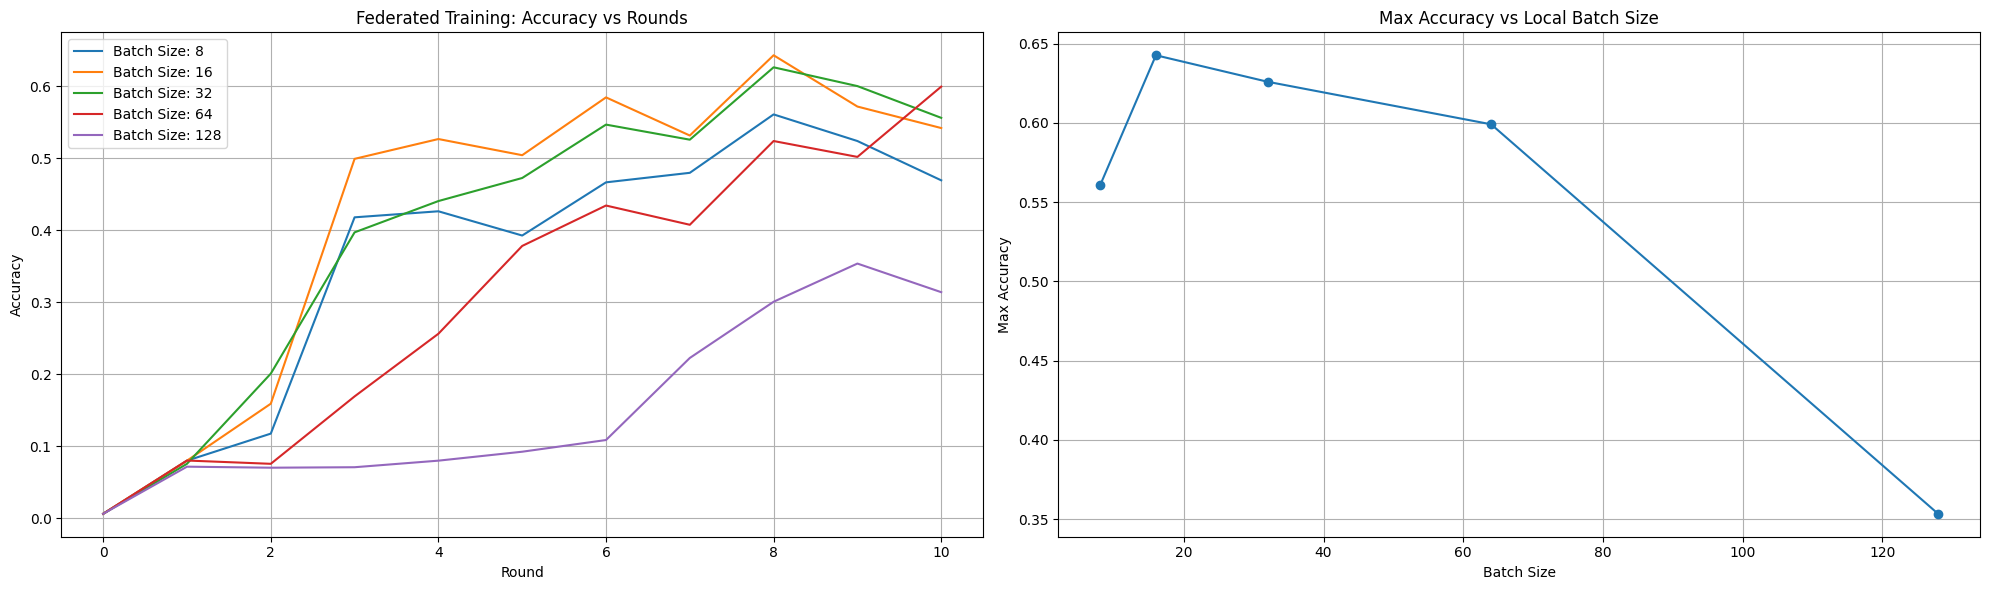

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for batch_size, params, hist in total_batch_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Batch Size: {batch_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Batch Size
batch_sizes = []
max_accuracies = []
for batch_size, params, hist in total_batch_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        batch_sizes.append(batch_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(batch_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Local Batch Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [11]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

Batch size:  8
--- 12.073390981287602
--- 25.393857799614953
--- 23.101182021090946
--- 19.78022941146352
--- 15.31749877431236
--- 19.949081219922416
--- 16.691428861940953
--- 10.191472076856193
--- 13.107580586632167
--- 15.101426052345998
17.07071477854671
Batch size:  16
--- 33.126450136424566
--- 25.442015222546704
--- 24.166597698247717
--- 24.16385721318045
--- 20.697473838365557
--- 17.324679052432625
--- 12.271038884955837
--- 14.750850559807633
--- 10.443173393881006
--- 9.18870821163695
19.157484421147906
Batch size:  32
--- 11.051405093763668
--- 47.43920188025331
--- 31.923322264134733
--- 27.053256376075595
--- 40.41943464083909
--- 25.242187906463972
--- 24.357643072856863
--- 16.830958440848022
--- 16.366230446457138
--- 23.632577733938717
26.431621785563106
Batch size:  64
--- 24.090970657676817
--- 21.17241968939245
--- 84.16958424916797
--- 147.781959435597
--- 82.42931785544539
--- 76.95999533466117
--- 80.93985634578716
--- 47.884730517259406
--- 56.91456414381466

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

## **Running FL with varying cohort sizes**

In [12]:
total_cohort_results = []

for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))

INFO flwr 2025-02-24 13:15:49,502 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:15:49,504 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:15:49,505 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:15:49,507 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:15:49,510 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 79.91it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 82.62it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 80.01it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 79.96it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 80.08it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 80.31it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:10, 81.81it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:10, 76.06it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:08, 96.40it/s]

 12%|████████████▋                                                                                              | 106/891 [00:01<00:06, 124.95it/s]

 14%|███████████████                                                                                            | 125/891 [00:01<00:05, 143.07it/s]

 16%|█████████████████▎                                                                                         | 144/891 [00:01<00:04, 155.21it/s]

 18%|███████████████████▌                                                                                       | 163/891 [00:01<00:04, 164.38it/s]

 21%|█████████████████████▉                                                                                     | 183/891 [00:01<00:04, 171.70it/s]

 23%|████████████████████████▎                                                                                  | 202/891 [00:01<00:03, 174.55it/s]

 25%|██████████████████████████▍                                                                                | 220/891 [00:01<00:04, 139.32it/s]

 26%|████████████████████████████▎                                                                              | 236/891 [00:02<00:06, 108.87it/s]

 28%|█████████████████████████████▉                                                                             | 249/891 [00:02<00:06, 101.38it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:02<00:06, 96.43it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:02<00:06, 91.72it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:02<00:06, 89.04it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:02<00:06, 87.82it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:02<00:06, 86.34it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:02<00:06, 85.45it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:03<00:06, 84.85it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:03<00:06, 85.12it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:03<00:06, 84.80it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:03<00:06, 83.70it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:03<00:06, 83.22it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:03<00:06, 83.37it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:03<00:05, 86.28it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:03<00:05, 85.61it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:03<00:05, 83.55it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:04<00:05, 83.51it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:04<00:05, 83.56it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:04<00:05, 84.94it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:04<00:05, 84.92it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:04<00:05, 84.51it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:04<00:05, 85.55it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:04<00:05, 84.76it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:04<00:05, 82.38it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:04<00:05, 81.86it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:05<00:05, 81.01it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:05<00:05, 79.74it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:05<00:04, 79.46it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:05<00:04, 79.02it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:05<00:04, 78.96it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:05<00:04, 79.07it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:05<00:04, 79.75it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:05<00:04, 80.57it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:05<00:04, 80.44it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:05<00:04, 81.22it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:06<00:03, 80.92it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:06<00:03, 80.46it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:03, 80.75it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:06<00:03, 80.30it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:06<00:03, 79.94it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:06<00:03, 80.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:06<00:03, 80.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:06<00:03, 81.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:06<00:03, 80.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:07<00:02, 81.22it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:07<00:02, 81.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:07<00:02, 80.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:07<00:02, 81.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:07<00:02, 81.75it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:07<00:02, 80.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:07<00:02, 80.21it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:07<00:02, 79.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:07<00:02, 79.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:08<00:02, 80.37it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:08<00:01, 80.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:08<00:01, 79.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:08<00:01, 79.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:08<00:01, 80.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:08<00:01, 82.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:08<00:01, 84.17it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:08<00:01, 82.76it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:08<00:01, 82.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:09<00:00, 82.39it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:09<00:00, 81.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:09<00:00, 82.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:09<00:00, 81.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:09<00:00, 82.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:09<00:00, 81.18it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:09<00:00, 80.93it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:09<00:00, 80.13it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:09<00:00, 79.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:10<00:00, 88.49it/s]


INFO flwr 2025-02-24 13:15:59,721 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:15:59,721 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:15:59,722 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:15:59,723 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:15:59,725 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:15:59,726 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:15:59,728 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:15:59,729 | flwr_core.py:103 | cid: 1287


DEBUG flwr 2025-02-24 13:16:04,135 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:11, 78.74it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:11, 79.32it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 81.22it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 81.99it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 82.63it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 82.98it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:10, 82.51it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:09, 83.05it/s]

 10%|██████████▊                                                                                                 | 89/891 [00:00<00:07, 110.93it/s]

 12%|████████████▊                                                                                              | 107/891 [00:01<00:05, 131.35it/s]

 14%|███████████████▏                                                                                           | 126/891 [00:01<00:05, 148.72it/s]

 16%|█████████████████▌                                                                                         | 146/891 [00:01<00:04, 161.38it/s]

 19%|███████████████████▊                                                                                       | 165/891 [00:01<00:04, 168.53it/s]

 21%|██████████████████████                                                                                     | 184/891 [00:01<00:04, 173.89it/s]

 23%|████████████████████████▍                                                                                  | 204/891 [00:01<00:03, 179.78it/s]

 25%|██████████████████████████▊                                                                                | 223/891 [00:01<00:04, 140.49it/s]

 27%|████████████████████████████▋                                                                              | 239/891 [00:01<00:05, 116.89it/s]

 28%|██████████████████████████████▍                                                                            | 253/891 [00:02<00:06, 105.29it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:02<00:06, 98.33it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:02<00:06, 93.06it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:02<00:06, 89.03it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:02<00:06, 87.01it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:02<00:06, 86.52it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:02<00:06, 86.40it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:03<00:06, 85.43it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:03<00:06, 84.00it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:03<00:06, 84.06it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:03<00:06, 83.59it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:03<00:06, 82.53it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:03<00:06, 82.74it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:03<00:06, 85.39it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:03<00:06, 83.78it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:03<00:05, 84.06it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:03<00:05, 82.93it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:04<00:05, 82.78it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:04<00:05, 81.69it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:04<00:05, 81.70it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:04<00:05, 81.54it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:04<00:05, 80.89it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:04<00:05, 80.59it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:04<00:05, 79.76it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:04<00:04, 84.58it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:04<00:04, 88.41it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:05<00:04, 89.24it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:05<00:04, 81.54it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:05<00:04, 82.29it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:05<00:04, 82.61it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:05<00:04, 82.05it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:05<00:04, 81.64it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:05<00:04, 81.23it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:05<00:04, 81.49it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:06<00:03, 81.81it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:06<00:03, 81.09it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:06<00:03, 80.94it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:06<00:03, 79.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:06<00:03, 80.44it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:06<00:03, 81.09it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:06<00:03, 81.19it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:06<00:03, 80.84it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:06<00:03, 80.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:07<00:02, 80.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:07<00:02, 79.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:07<00:02, 80.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:07<00:02, 80.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:07<00:02, 80.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:07<00:02, 79.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:07<00:02, 79.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:07<00:02, 80.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:07<00:02, 81.22it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:01, 81.21it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:08<00:01, 81.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:08<00:01, 80.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:08<00:01, 80.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:08<00:01, 81.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:08<00:01, 81.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:08<00:01, 83.91it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:08<00:01, 83.12it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:08<00:01, 83.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:08<00:00, 83.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:09<00:00, 81.68it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:09<00:00, 81.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:09<00:00, 81.38it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:09<00:00, 80.62it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:09<00:00, 80.51it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:09<00:00, 80.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:09<00:00, 81.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:09<00:00, 81.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 89.53it/s]


INFO flwr 2025-02-24 13:16:14,248 | server_returns_parameters.py:120 | fit progress: (1, 3434.334930896759, {'accuracy': 0.08049807085233252}, 14.52688096096972)


INFO flwr 2025-02-24 13:16:14,249 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:16:14,250 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:16:14,251 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:16:14,254 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:16:14,257 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:16:14,260 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:16:14,263 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 13:16:18,517 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 78.27it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 79.57it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:10, 79.75it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:10, 80.47it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:10, 80.65it/s]

  6%|██████▎                                                                                                      | 52/891 [00:00<00:10, 83.04it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:09, 86.51it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:09, 87.24it/s]

 10%|██████████▉                                                                                                 | 90/891 [00:00<00:06, 117.03it/s]

 12%|█████████████▏                                                                                             | 110/891 [00:01<00:05, 140.84it/s]

 15%|███████████████▌                                                                                           | 130/891 [00:01<00:04, 158.38it/s]

 17%|██████████████████                                                                                         | 150/891 [00:01<00:04, 170.77it/s]

 19%|████████████████████▍                                                                                      | 170/891 [00:01<00:04, 177.15it/s]

 21%|██████████████████████▊                                                                                    | 190/891 [00:01<00:03, 181.13it/s]

 23%|█████████████████████████                                                                                  | 209/891 [00:01<00:03, 175.63it/s]

 25%|███████████████████████████▎                                                                               | 227/891 [00:01<00:05, 132.76it/s]

 27%|█████████████████████████████                                                                              | 242/891 [00:01<00:05, 114.93it/s]

 29%|██████████████████████████████▌                                                                            | 255/891 [00:02<00:06, 104.23it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:02<00:06, 97.84it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:02<00:06, 93.16it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:02<00:06, 89.78it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:02<00:06, 86.48it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:02<00:06, 85.15it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:02<00:06, 84.38it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:02<00:06, 85.10it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:03<00:06, 84.42it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:03<00:06, 83.92it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:03<00:06, 82.93it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:03<00:06, 81.65it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:03<00:06, 82.65it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:03<00:06, 83.10it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:03<00:06, 82.79it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:03<00:06, 82.22it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:03<00:05, 81.89it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:05, 82.46it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:05, 82.03it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:04<00:05, 83.02it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:04<00:05, 83.07it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:04<00:05, 82.48it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:04<00:05, 80.37it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:04<00:05, 80.67it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:04<00:05, 80.91it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:04<00:04, 81.09it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:05<00:04, 80.66it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:05<00:04, 81.01it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:05<00:04, 81.38it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:05<00:04, 81.01it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:05<00:04, 82.08it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:05<00:04, 80.48it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:05<00:04, 82.43it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:05<00:03, 85.22it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:05<00:03, 88.35it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:06<00:03, 90.05it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:06<00:03, 90.13it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:06<00:03, 89.26it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:06<00:03, 89.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:06<00:03, 86.67it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:06<00:03, 85.46it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:06<00:03, 84.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:06<00:02, 83.72it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:06<00:02, 83.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:07<00:02, 83.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:07<00:02, 83.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:07<00:02, 82.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:07<00:02, 82.43it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:07<00:02, 81.98it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:07<00:02, 82.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:07<00:02, 82.47it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:07<00:02, 81.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:07<00:01, 81.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:08<00:01, 81.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:08<00:01, 82.48it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:08<00:01, 81.31it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:08<00:01, 80.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:08<00:01, 81.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:08<00:01, 83.85it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:08<00:01, 82.66it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:08<00:01, 81.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:08<00:00, 81.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:09<00:00, 82.19it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:09<00:00, 82.41it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:09<00:00, 82.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:09<00:00, 82.04it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:09<00:00, 82.09it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:09<00:00, 82.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:09<00:00, 81.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:09<00:00, 81.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 90.63it/s]


INFO flwr 2025-02-24 13:16:28,495 | server_returns_parameters.py:120 | fit progress: (2, 2935.5331555604935, {'accuracy': 0.24289722904244124}, 28.773306255985517)


INFO flwr 2025-02-24 13:16:28,495 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:16:28,496 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:16:28,497 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:16:28,498 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:16:28,502 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:16:28,504 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:16:28,507 | flwr_core.py:103 | cid: 275


DEBUG flwr 2025-02-24 13:16:32,294 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 77.56it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 80.25it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 80.79it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 81.20it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 82.23it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 81.78it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:10, 80.80it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:10, 81.53it/s]

 10%|██████████▉                                                                                                 | 90/891 [00:00<00:07, 111.66it/s]

 12%|█████████████▏                                                                                             | 110/891 [00:01<00:05, 136.39it/s]

 14%|███████████████▍                                                                                           | 129/891 [00:01<00:05, 151.99it/s]

 17%|█████████████████▉                                                                                         | 149/891 [00:01<00:04, 165.91it/s]

 19%|████████████████████                                                                                       | 167/891 [00:01<00:04, 169.54it/s]

 21%|██████████████████████▍                                                                                    | 187/891 [00:01<00:03, 176.96it/s]

 23%|████████████████████████▊                                                                                  | 207/891 [00:01<00:03, 182.60it/s]

 25%|███████████████████████████▏                                                                               | 226/891 [00:01<00:04, 135.17it/s]

 27%|█████████████████████████████                                                                              | 242/891 [00:02<00:05, 115.43it/s]

 29%|██████████████████████████████▋                                                                            | 256/891 [00:02<00:06, 105.58it/s]

 30%|████████████████████████████████▏                                                                          | 268/891 [00:02<00:06, 101.35it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:02<00:06, 98.13it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:02<00:06, 94.94it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:02<00:06, 92.06it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:02<00:06, 90.78it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:02<00:06, 88.99it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:03<00:06, 88.58it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:03<00:06, 87.85it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:03<00:06, 86.09it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:03<00:06, 85.43it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:03<00:06, 84.97it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:03<00:06, 86.08it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:03<00:05, 85.62it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:03<00:05, 85.13it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:03<00:05, 85.21it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:03<00:05, 83.90it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:04<00:05, 83.11it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:04<00:05, 82.75it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:04<00:05, 83.02it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:04<00:05, 82.85it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:04<00:05, 81.47it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:04<00:05, 81.74it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:04<00:05, 81.39it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:04<00:04, 82.12it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:04<00:04, 82.06it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:05<00:04, 82.63it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:05<00:04, 82.94it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:05<00:04, 83.21it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:05<00:04, 83.09it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:05<00:04, 82.69it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:05<00:04, 82.59it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:05<00:04, 82.73it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:05<00:03, 83.20it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:05<00:03, 82.39it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:03, 81.35it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:06<00:03, 81.07it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:06<00:03, 80.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:06<00:03, 81.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:06<00:03, 81.15it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:06<00:03, 80.11it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:06<00:03, 80.50it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:06<00:03, 81.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:06<00:02, 81.28it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:07<00:02, 80.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:07<00:02, 81.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:07<00:02, 81.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:07<00:02, 86.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:07<00:02, 89.50it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:07<00:01, 90.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:07<00:01, 90.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:07<00:01, 89.44it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:07<00:01, 87.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:08<00:01, 86.28it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:08<00:01, 85.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:08<00:01, 84.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:08<00:01, 83.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:08<00:01, 85.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:08<00:01, 85.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:08<00:01, 84.73it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:08<00:00, 83.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:08<00:00, 81.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:09<00:00, 82.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:09<00:00, 83.07it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:09<00:00, 84.04it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:09<00:00, 83.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:09<00:00, 83.29it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:09<00:00, 82.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:09<00:00, 82.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 91.42it/s]


INFO flwr 2025-02-24 13:16:42,183 | server_returns_parameters.py:120 | fit progress: (3, 3170.38005900383, {'accuracy': 0.33672395650648895}, 42.461808154010214)


INFO flwr 2025-02-24 13:16:42,184 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:16:42,185 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:16:42,186 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:16:42,188 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:16:42,191 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:16:42,195 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:16:42,197 | flwr_core.py:103 | cid: 2471


DEBUG flwr 2025-02-24 13:16:45,087 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 83.83it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 83.20it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 81.34it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 82.03it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:10, 81.71it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:10, 81.17it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:10, 80.64it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:10, 81.42it/s]

 10%|███████████                                                                                                 | 91/891 [00:00<00:07, 111.92it/s]

 13%|█████████████▍                                                                                             | 112/891 [00:01<00:05, 139.20it/s]

 15%|███████████████▉                                                                                           | 133/891 [00:01<00:04, 156.79it/s]

 17%|██████████████████▎                                                                                        | 153/891 [00:01<00:04, 165.74it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:04, 173.74it/s]

 22%|███████████████████████▏                                                                                   | 193/891 [00:01<00:03, 179.07it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:01<00:03, 170.41it/s]

 26%|███████████████████████████▌                                                                               | 229/891 [00:01<00:05, 129.66it/s]

 27%|█████████████████████████████▎                                                                             | 244/891 [00:02<00:05, 112.90it/s]

 29%|██████████████████████████████▊                                                                            | 257/891 [00:02<00:06, 104.17it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:02<00:06, 98.39it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:02<00:06, 94.08it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:02<00:06, 91.41it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:02<00:06, 88.51it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:02<00:06, 86.94it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:02<00:06, 85.66it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:03<00:06, 85.05it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:03<00:06, 84.22it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:03<00:06, 83.55it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:03<00:06, 82.25it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:03<00:06, 81.67it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:03<00:06, 85.47it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:03<00:06, 83.22it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:03<00:06, 81.42it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:03<00:06, 81.83it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:04<00:05, 80.63it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:04<00:05, 81.22it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:04<00:05, 80.63it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:04<00:05, 81.33it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:04<00:05, 80.35it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:04<00:05, 80.75it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:04<00:05, 81.11it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:04<00:05, 80.61it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:04<00:04, 82.88it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:05<00:04, 85.77it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:05<00:04, 85.25it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:05<00:04, 83.61it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:05<00:04, 83.69it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:05<00:04, 84.48it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:05<00:04, 82.48it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:05<00:04, 82.69it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:05<00:04, 82.33it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:05<00:03, 82.94it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:06<00:03, 82.96it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:03, 83.66it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:06<00:03, 83.55it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:06<00:03, 83.31it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:06<00:03, 83.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:06<00:03, 82.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:06<00:03, 81.99it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:06<00:03, 82.36it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:06<00:02, 83.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:06<00:02, 82.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:07<00:02, 82.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:07<00:02, 82.27it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:07<00:02, 82.23it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:07<00:02, 82.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:07<00:02, 82.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:07<00:02, 83.22it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:07<00:02, 83.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:07<00:01, 84.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:07<00:01, 83.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:08<00:01, 83.95it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:08<00:01, 82.84it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:08<00:01, 82.47it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:08<00:01, 82.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:08<00:01, 83.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:08<00:01, 85.46it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:08<00:01, 83.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:08<00:01, 82.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:08<00:00, 82.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:09<00:00, 83.40it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:09<00:00, 82.47it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:09<00:00, 82.29it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:09<00:00, 81.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:09<00:00, 80.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:09<00:00, 81.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:09<00:00, 81.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:09<00:00, 81.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 90.31it/s]


INFO flwr 2025-02-24 13:16:55,097 | server_returns_parameters.py:120 | fit progress: (4, 2419.552949845791, {'accuracy': 0.5010873377762188}, 55.37574162601959)


INFO flwr 2025-02-24 13:16:55,098 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:16:55,098 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:16:55,099 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:16:55,100 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:16:55,102 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:16:55,106 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:16:55,107 | flwr_core.py:103 | cid: 3175


DEBUG flwr 2025-02-24 13:16:58,819 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 83.76it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 81.66it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:10, 82.83it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:10, 83.88it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:10, 82.70it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:10, 83.30it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:09, 83.76it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:09, 82.49it/s]

 10%|███████████                                                                                                 | 91/891 [00:00<00:07, 114.07it/s]

 12%|█████████████▎                                                                                             | 111/891 [00:01<00:05, 138.73it/s]

 15%|███████████████▌                                                                                           | 130/891 [00:01<00:04, 152.59it/s]

 17%|██████████████████                                                                                         | 150/891 [00:01<00:04, 165.52it/s]

 19%|████████████████████▏                                                                                      | 168/891 [00:01<00:04, 168.98it/s]

 21%|██████████████████████▍                                                                                    | 187/891 [00:01<00:04, 173.05it/s]

 23%|████████████████████████▌                                                                                  | 205/891 [00:01<00:03, 174.74it/s]

 25%|██████████████████████████▊                                                                                | 223/891 [00:01<00:06, 109.03it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 88.78it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:02<00:07, 84.07it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:02<00:08, 78.47it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:02<00:08, 76.27it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:02<00:08, 75.15it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:02<00:07, 75.89it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:02<00:08, 73.23it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:08, 70.89it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:03<00:08, 67.32it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:09, 62.20it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:03<00:09, 60.21it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:03<00:09, 58.48it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:03<00:09, 58.73it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:03<00:09, 58.29it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:03<00:08, 65.27it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:04<00:07, 68.65it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:04<00:07, 73.19it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:04<00:06, 75.72it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:04<00:06, 76.46it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:04<00:06, 77.73it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:04<00:06, 77.87it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:04<00:06, 75.21it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:06, 70.08it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:05<00:06, 66.16it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:05<00:07, 61.67it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:05<00:06, 65.31it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:05<00:06, 69.71it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:05<00:05, 72.78it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:05<00:05, 73.43it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:05<00:05, 77.74it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:05<00:05, 75.76it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:05<00:04, 78.48it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:06<00:04, 81.67it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:06<00:04, 82.08it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:06<00:04, 81.66it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:06<00:04, 83.38it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:06<00:04, 84.13it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:06<00:04, 82.61it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:06<00:04, 81.57it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:06<00:03, 81.34it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:04, 71.41it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:07<00:04, 73.05it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:07<00:04, 72.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:07<00:03, 73.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:07<00:04, 69.04it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:07<00:03, 72.48it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:07<00:03, 72.64it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:07<00:03, 75.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:07<00:03, 76.40it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:07<00:03, 73.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:08<00:03, 75.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:08<00:02, 76.96it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:08<00:02, 79.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:08<00:02, 80.43it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:08<00:02, 81.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:08<00:02, 81.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:08<00:02, 82.39it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:08<00:02, 82.43it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:08<00:01, 82.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:09<00:01, 81.19it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:09<00:01, 78.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:09<00:01, 79.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:09<00:01, 80.49it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:09<00:01, 81.42it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:09<00:01, 84.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:09<00:01, 82.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:09<00:01, 77.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:10<00:01, 62.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:10<00:01, 64.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:10<00:00, 68.69it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:10<00:00, 70.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:10<00:00, 65.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:10<00:00, 54.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:10<00:00, 60.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:10<00:00, 67.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:10<00:00, 74.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:11<00:00, 74.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 80.27it/s]


INFO flwr 2025-02-24 13:17:10,065 | server_returns_parameters.py:120 | fit progress: (5, 2714.2066224217415, {'accuracy': 0.4153981059277447}, 70.34340780001367)


INFO flwr 2025-02-24 13:17:10,066 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:17:10,066 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:17:10,067 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:17:10,069 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:17:10,071 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:17:10,072 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:17:10,074 | flwr_core.py:103 | cid: 2614


DEBUG flwr 2025-02-24 13:17:12,815 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 79.83it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:11, 75.06it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:11, 78.38it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:11, 76.74it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:10, 77.35it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:10, 78.79it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:10, 79.12it/s]

  8%|████████▏                                                                                                    | 67/891 [00:00<00:10, 80.74it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:00<00:08, 93.76it/s]

 11%|███████████▍                                                                                                | 94/891 [00:01<00:07, 106.25it/s]

 12%|█████████████▎                                                                                             | 111/891 [00:01<00:06, 122.84it/s]

 14%|██████████████▉                                                                                            | 124/891 [00:01<00:06, 123.58it/s]

 16%|████████████████▉                                                                                          | 141/891 [00:01<00:05, 137.03it/s]

 17%|██████████████████▌                                                                                        | 155/891 [00:01<00:05, 137.25it/s]

 19%|████████████████████▋                                                                                      | 172/891 [00:01<00:04, 145.54it/s]

 21%|██████████████████████▍                                                                                    | 187/891 [00:01<00:04, 144.78it/s]

 23%|████████████████████████▎                                                                                  | 202/891 [00:01<00:04, 141.77it/s]

 24%|██████████████████████████                                                                                 | 217/891 [00:01<00:05, 126.88it/s]

 26%|███████████████████████████▌                                                                               | 230/891 [00:02<00:05, 113.95it/s]

 27%|█████████████████████████████                                                                              | 242/891 [00:02<00:06, 101.83it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:02<00:06, 92.75it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:02<00:07, 89.08it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:02<00:07, 86.79it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:02<00:07, 84.04it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:02<00:07, 84.27it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:02<00:07, 84.31it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:03<00:06, 83.70it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:03<00:07, 81.20it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:03<00:06, 81.78it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:03<00:07, 77.13it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:03<00:07, 77.85it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:03<00:06, 77.85it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:03<00:06, 77.25it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:03<00:07, 72.86it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:03<00:06, 80.52it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:04<00:06, 81.26it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:04<00:05, 82.48it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:04<00:06, 80.37it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:04<00:06, 78.15it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:05, 79.17it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:04<00:05, 79.71it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:04<00:05, 79.59it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:04<00:05, 80.39it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:04<00:05, 79.71it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:05<00:05, 79.65it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:05<00:05, 76.59it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:05<00:05, 70.81it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:05<00:05, 73.60it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:05<00:05, 76.07it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:05<00:04, 78.21it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:05<00:04, 79.87it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:05<00:04, 81.10it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:05<00:04, 78.45it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:06<00:04, 79.15it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:06<00:04, 78.88it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:06<00:04, 78.36it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:06<00:04, 78.76it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:06<00:03, 78.60it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:03, 79.83it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:06<00:03, 79.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:06<00:04, 71.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:06<00:04, 68.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:07<00:03, 72.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:07<00:03, 72.80it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:07<00:03, 74.49it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:07<00:03, 77.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:07<00:03, 76.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:07<00:03, 74.78it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:07<00:02, 74.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:07<00:02, 77.70it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:07<00:02, 76.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:08<00:02, 76.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:08<00:02, 76.27it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:08<00:02, 73.02it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:08<00:02, 74.95it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:08<00:02, 73.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:08<00:02, 65.97it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:08<00:02, 67.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:08<00:02, 67.20it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:08<00:01, 69.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:09<00:01, 71.58it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:09<00:01, 70.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:09<00:01, 65.30it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:09<00:01, 68.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:09<00:01, 64.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:09<00:01, 62.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:09<00:01, 58.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:09<00:01, 58.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:10<00:01, 54.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:10<00:01, 52.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:10<00:01, 52.19it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:10<00:00, 52.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:10<00:00, 53.38it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:10<00:00, 53.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:10<00:00, 53.43it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:10<00:00, 51.95it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:11<00:00, 51.98it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:11<00:00, 50.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:11<00:00, 52.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:11<00:00, 52.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 78.22it/s]


INFO flwr 2025-02-24 13:17:24,352 | server_returns_parameters.py:120 | fit progress: (6, 1974.5462456643581, {'accuracy': 0.5732374605401613}, 84.6307477899827)


INFO flwr 2025-02-24 13:17:24,354 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:17:24,355 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:17:24,357 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:17:24,358 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:17:24,364 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:17:24,368 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:17:24,371 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:17:27,640 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 65.76it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 64.82it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 64.76it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:12, 67.85it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:12, 67.52it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:11, 72.01it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:12, 68.74it/s]

  7%|███████▍                                                                                                     | 61/891 [00:00<00:11, 71.99it/s]

  8%|████████▌                                                                                                    | 70/891 [00:00<00:10, 74.70it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:09, 88.92it/s]

 11%|████████████                                                                                               | 100/891 [00:01<00:07, 109.67it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:01<00:06, 117.86it/s]

 14%|███████████████▎                                                                                           | 127/891 [00:01<00:06, 118.67it/s]

 16%|█████████████████▏                                                                                         | 143/891 [00:01<00:05, 130.17it/s]

 18%|██████████████████▉                                                                                        | 158/891 [00:01<00:05, 133.38it/s]

 19%|████████████████████▊                                                                                      | 173/891 [00:01<00:05, 136.79it/s]

 21%|██████████████████████▊                                                                                    | 190/891 [00:01<00:04, 145.18it/s]

 23%|████████████████████████▌                                                                                  | 205/891 [00:01<00:05, 137.00it/s]

 25%|██████████████████████████▎                                                                                | 219/891 [00:02<00:05, 113.52it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:02<00:06, 97.95it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:02<00:07, 90.38it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:02<00:07, 86.72it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:02<00:07, 86.32it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:02<00:07, 84.30it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:02<00:07, 83.07it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:06, 86.71it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:06, 87.78it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:03<00:06, 87.48it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:03<00:06, 89.80it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:03<00:06, 88.68it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:03<00:06, 86.92it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:03<00:06, 86.67it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:03<00:06, 86.18it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:03<00:06, 87.12it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:03<00:05, 92.90it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:04<00:05, 89.27it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:04<00:05, 84.55it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:04<00:05, 81.63it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:04<00:05, 82.73it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:04<00:05, 80.98it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:04<00:05, 82.10it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:04<00:05, 83.81it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:04<00:05, 82.39it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:05<00:05, 83.87it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:05<00:04, 85.86it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:05<00:04, 86.78it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:05<00:04, 87.11it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:05<00:04, 85.17it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:05<00:04, 86.30it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:05<00:04, 83.85it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:05<00:04, 81.91it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:05<00:04, 83.28it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:05<00:04, 83.98it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:06<00:04, 80.91it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:06<00:04, 78.30it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:06<00:03, 81.73it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:06<00:03, 83.22it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:03, 84.10it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:06<00:03, 81.14it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:06<00:03, 79.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:06<00:03, 76.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:07<00:03, 70.46it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:07<00:03, 70.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:07<00:03, 70.43it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:07<00:03, 69.95it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:07<00:03, 69.09it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:07<00:03, 68.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:07<00:03, 69.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:07<00:03, 61.84it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:07<00:03, 60.76it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:08<00:03, 62.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:08<00:03, 64.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:08<00:02, 64.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:08<00:02, 65.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:08<00:02, 64.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:08<00:02, 64.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:08<00:02, 64.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:08<00:02, 65.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:08<00:02, 64.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:09<00:02, 64.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:09<00:02, 64.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:09<00:01, 64.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:09<00:01, 62.06it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:09<00:01, 61.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:09<00:01, 64.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:09<00:01, 65.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:09<00:01, 65.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:09<00:01, 66.57it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:10<00:01, 66.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:10<00:01, 66.69it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:10<00:00, 66.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:10<00:00, 65.64it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:10<00:00, 65.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:10<00:00, 66.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:10<00:00, 63.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:10<00:00, 63.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:10<00:00, 64.59it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:10<00:00, 63.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:11<00:00, 64.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 79.65it/s]


INFO flwr 2025-02-24 13:17:38,970 | server_returns_parameters.py:120 | fit progress: (7, 2173.5944437384605, {'accuracy': 0.5582953349701859}, 99.24873934598872)


INFO flwr 2025-02-24 13:17:38,971 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:17:38,972 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:17:38,973 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:17:38,974 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:17:38,976 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:17:38,980 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:17:38,983 | flwr_core.py:103 | cid: 3020


DEBUG flwr 2025-02-24 13:17:41,445 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 62.41it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 65.06it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 66.38it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:12, 66.96it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:13, 62.18it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:13, 62.83it/s]

  5%|█████▉                                                                                                       | 49/891 [00:00<00:13, 64.13it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:12, 65.32it/s]

  7%|███████▋                                                                                                     | 63/891 [00:00<00:12, 65.91it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:12, 65.34it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:10, 74.93it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:09, 86.58it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:07, 98.71it/s]

 13%|██████████████                                                                                             | 117/891 [00:01<00:07, 103.46it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:01<00:07, 98.98it/s]

 16%|████████████████▊                                                                                          | 140/891 [00:01<00:07, 104.31it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:01<00:07, 98.88it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:01<00:07, 94.66it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:02<00:08, 89.48it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:02<00:08, 86.46it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:02<00:07, 89.39it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:02<00:07, 88.51it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:02<00:07, 87.35it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:02<00:08, 78.22it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:02<00:08, 75.30it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:02<00:09, 72.38it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:03<00:09, 70.19it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:09, 69.67it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:03<00:09, 69.40it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:03<00:09, 68.59it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:03<00:09, 67.24it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:03<00:09, 67.67it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:03<00:08, 67.83it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:03<00:08, 67.58it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:03<00:08, 69.79it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:04<00:08, 70.64it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:08, 70.11it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:04<00:08, 69.81it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:04<00:08, 69.15it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:04<00:08, 68.85it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:04<00:07, 68.97it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:04<00:08, 65.79it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:04<00:08, 64.93it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:04<00:07, 65.56it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:04<00:07, 68.47it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:05<00:07, 68.40it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:05<00:07, 69.48it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:05<00:07, 67.16it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:05<00:07, 66.72it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:07, 66.28it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:05<00:07, 67.29it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:05<00:06, 67.05it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:05<00:06, 66.46it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:05<00:06, 66.89it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:06<00:06, 66.50it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:06<00:06, 67.43it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:06<00:06, 68.46it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:06, 68.11it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:06<00:06, 67.82it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:06<00:06, 67.57it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:06<00:05, 67.69it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:06<00:05, 68.16it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:06<00:05, 68.12it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:07<00:05, 66.35it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:07<00:05, 64.93it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:07<00:05, 65.63it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:07<00:05, 66.28it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:07<00:05, 66.58it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:07<00:05, 66.75it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:07<00:05, 67.16it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:07<00:04, 67.23it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:07<00:04, 66.19it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:07<00:04, 66.99it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:08<00:04, 67.54it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:04, 67.76it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:08<00:04, 67.76it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:08<00:04, 67.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:08<00:04, 67.60it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:08<00:04, 67.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:08<00:04, 65.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:08<00:03, 65.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:08<00:03, 65.71it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:09<00:03, 66.72it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:09<00:03, 69.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:03, 69.23it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:03, 66.92it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:09<00:03, 67.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:09<00:03, 59.29it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:09<00:03, 55.04it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:09<00:03, 54.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:09<00:03, 50.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:10<00:03, 47.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:10<00:04, 41.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:10<00:04, 38.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:10<00:04, 38.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:10<00:04, 38.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:10<00:03, 42.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:10<00:03, 41.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:11<00:03, 40.12it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:11<00:03, 39.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:11<00:03, 36.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:11<00:03, 37.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:11<00:03, 35.16it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:11<00:03, 39.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:11<00:03, 39.08it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:11<00:02, 43.07it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:12<00:02, 42.31it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:12<00:02, 41.19it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:12<00:02, 37.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:12<00:02, 39.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:12<00:02, 39.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:12<00:02, 41.42it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:12<00:01, 43.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:12<00:01, 40.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:13<00:02, 35.42it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:13<00:01, 35.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:13<00:01, 33.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:13<00:01, 32.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:13<00:01, 32.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:13<00:01, 34.22it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:13<00:01, 36.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:13<00:01, 35.97it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:14<00:01, 36.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:14<00:00, 35.01it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:14<00:00, 33.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:14<00:00, 34.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:14<00:00, 36.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:14<00:00, 34.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:14<00:00, 33.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:14<00:00, 32.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:15<00:00, 35.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:15<00:00, 58.75it/s]


INFO flwr 2025-02-24 13:17:56,841 | server_returns_parameters.py:120 | fit progress: (8, 1967.220780044794, {'accuracy': 0.5701157488600491}, 117.11969391000457)


INFO flwr 2025-02-24 13:17:56,843 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:17:56,845 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:17:56,846 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:17:56,849 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:17:56,852 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:17:56,858 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:17:56,868 | flwr_core.py:103 | cid: 1770


DEBUG flwr 2025-02-24 13:18:03,727 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:23, 38.16it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:21, 40.22it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:21, 40.64it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:24, 35.61it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:26, 33.05it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:24, 35.61it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:22, 37.92it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:22, 37.90it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:22, 37.06it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:23, 36.41it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:23, 35.35it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:22, 36.80it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:22, 36.35it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:25, 32.24it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:26, 30.85it/s]

  8%|████████▌                                                                                                    | 70/891 [00:02<00:27, 30.24it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:02<00:23, 34.72it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:17, 45.73it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:12, 61.83it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:10, 71.96it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:02<00:10, 77.06it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:09, 78.79it/s]

 15%|████████████████                                                                                            | 132/891 [00:02<00:09, 77.80it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:09, 79.15it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:09, 79.62it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:03<00:09, 77.85it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:03<00:09, 77.64it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:03<00:10, 71.16it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:03<00:09, 75.28it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:03<00:08, 80.17it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:03<00:08, 77.75it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:03<00:10, 65.56it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:04<00:13, 51.19it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:04<00:15, 43.44it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:04<00:16, 39.67it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:04<00:17, 37.82it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:04<00:17, 37.33it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:04<00:18, 34.38it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:05<00:19, 33.63it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:05<00:20, 31.73it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:05<00:19, 31.83it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:05<00:21, 29.28it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:05<00:22, 28.16it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:05<00:21, 29.58it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:05<00:20, 30.92it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:05<00:18, 33.87it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:06<00:18, 33.99it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:06<00:18, 32.60it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:06<00:17, 34.16it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:06<00:17, 34.06it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:06<00:17, 33.62it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:06<00:17, 34.23it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:06<00:16, 36.34it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:06<00:15, 36.44it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:07<00:17, 33.22it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:07<00:18, 30.83it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:07<00:17, 33.01it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:07<00:16, 34.10it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:07<00:15, 35.52it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:07<00:14, 39.04it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:07<00:13, 40.99it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:07<00:12, 42.41it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:07<00:13, 38.96it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:08<00:14, 38.15it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:08<00:14, 37.26it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:08<00:12, 42.58it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:08<00:13, 38.42it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:08<00:13, 38.35it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:08<00:14, 35.42it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:08<00:14, 35.23it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:08<00:14, 34.57it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:09<00:14, 34.89it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:09<00:13, 35.80it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:09<00:14, 33.40it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:09<00:14, 34.15it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:09<00:13, 35.35it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:09<00:13, 35.94it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:09<00:13, 36.21it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:09<00:13, 35.90it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:09<00:13, 35.55it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:10<00:13, 33.80it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:10<00:13, 33.50it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:10<00:13, 34.99it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:10<00:13, 33.23it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:10<00:13, 32.28it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:10<00:14, 31.61it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:10<00:12, 34.03it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:10<00:12, 35.47it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:11<00:12, 35.60it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:11<00:11, 37.13it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:11<00:11, 36.32it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:11<00:12, 34.99it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:11<00:11, 35.14it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:11<00:12, 32.72it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:11<00:12, 33.95it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:12, 31.39it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:12<00:12, 32.69it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:12<00:12, 32.32it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:12<00:12, 31.17it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:12<00:11, 32.84it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:12<00:11, 34.34it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:12<00:11, 32.96it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:12<00:11, 32.55it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:12<00:11, 31.69it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:13<00:10, 33.58it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:13<00:10, 33.42it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:13<00:10, 33.68it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:13<00:10, 34.40it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:13<00:09, 35.70it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:13<00:09, 36.37it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:13<00:08, 38.04it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:13<00:08, 37.61it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:13<00:08, 38.25it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:14<00:08, 37.62it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:14<00:08, 36.53it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:14<00:08, 37.88it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:14<00:08, 38.56it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:14<00:08, 38.14it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:14<00:08, 35.44it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:14<00:08, 35.65it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:14<00:08, 36.74it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:15<00:07, 37.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:15<00:06, 45.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:15<00:05, 55.24it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:15<00:04, 55.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:15<00:04, 60.68it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:15<00:04, 54.40it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:15<00:05, 47.58it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:16<00:05, 42.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:16<00:05, 41.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:16<00:06, 37.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:16<00:05, 44.05it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:16<00:04, 47.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:16<00:04, 49.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:16<00:03, 56.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:16<00:03, 62.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:16<00:03, 63.37it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:17<00:02, 62.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:17<00:03, 58.43it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:17<00:03, 49.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:17<00:03, 53.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:17<00:02, 54.63it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:17<00:02, 53.23it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:17<00:02, 60.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:17<00:02, 60.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:18<00:02, 54.72it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:18<00:01, 61.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:18<00:01, 61.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:18<00:01, 59.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:18<00:01, 58.24it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:18<00:01, 59.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:18<00:01, 55.97it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:18<00:01, 61.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:19<00:01, 66.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:19<00:00, 68.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:19<00:00, 64.05it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:19<00:00, 69.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:19<00:00, 73.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:19<00:00, 58.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:19<00:00, 54.32it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:20<00:00, 51.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:20<00:00, 59.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:20<00:00, 44.15it/s]


INFO flwr 2025-02-24 13:18:24,141 | server_returns_parameters.py:120 | fit progress: (9, 2078.8084034472704, {'accuracy': 0.5140652402665732}, 144.41974794800626)


INFO flwr 2025-02-24 13:18:24,142 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:18:24,142 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 100)


INFO flwr 2025-02-24 13:18:24,144 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:18:24,146 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:18:24,150 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:18:24,151 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:18:24,153 | flwr_core.py:103 | cid: 1852


DEBUG flwr 2025-02-24 13:18:26,280 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 77.86it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:09, 88.05it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:09, 92.98it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:09, 88.83it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:09, 86.11it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:11, 73.34it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:11, 69.67it/s]

  8%|████████▊                                                                                                    | 72/891 [00:00<00:12, 67.61it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:01<00:09, 87.47it/s]

 12%|████████████▎                                                                                              | 103/891 [00:01<00:07, 105.11it/s]

 13%|██████████████▎                                                                                            | 119/891 [00:01<00:06, 119.54it/s]

 15%|████████████████▏                                                                                          | 135/891 [00:01<00:05, 129.46it/s]

 17%|██████████████████                                                                                         | 150/891 [00:01<00:05, 132.55it/s]

 18%|███████████████████▋                                                                                       | 164/891 [00:01<00:05, 127.40it/s]

 20%|█████████████████████▋                                                                                     | 181/891 [00:01<00:05, 137.82it/s]

 22%|███████████████████████▌                                                                                   | 196/891 [00:01<00:04, 140.89it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:01<00:05, 117.60it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:02<00:07, 92.59it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:02<00:07, 90.48it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:02<00:09, 70.74it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:02<00:10, 61.74it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:02<00:11, 54.78it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:03<00:11, 55.08it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:03<00:10, 59.76it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:03<00:09, 65.37it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:03<00:08, 70.35it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:03<00:08, 71.96it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:03<00:08, 67.38it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:03<00:09, 61.56it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:04<00:10, 52.79it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:04<00:10, 55.67it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:04<00:11, 48.89it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:04<00:10, 52.64it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:04<00:09, 55.89it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:04<00:10, 52.41it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:04<00:09, 53.60it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:04<00:08, 62.64it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:04<00:07, 68.22it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:05<00:07, 67.31it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:05<00:06, 71.76it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:05<00:06, 78.23it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:05<00:05, 78.81it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:05<00:06, 68.24it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:05<00:07, 62.44it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:05<00:08, 51.24it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:08, 51.94it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:06<00:09, 46.27it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:10, 41.12it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:06<00:10, 40.75it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:11, 36.54it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:06<00:10, 38.58it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:06<00:10, 40.76it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:06<00:09, 44.92it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:07<00:07, 53.91it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:07<00:07, 54.77it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:07<00:07, 50.49it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:07<00:07, 48.11it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:07<00:07, 50.82it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:07<00:07, 47.47it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:07<00:08, 43.75it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:06, 51.52it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:08<00:05, 59.84it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:08<00:05, 65.08it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:08<00:04, 69.10it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:08<00:05, 60.38it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:08<00:04, 66.40it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:04, 71.13it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:08<00:03, 74.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:08<00:03, 73.99it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:03, 73.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:09<00:03, 73.18it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:09<00:03, 76.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:09<00:03, 79.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:09<00:03, 78.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:09<00:02, 79.08it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:09<00:03, 69.45it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:09<00:02, 73.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 57.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:10<00:03, 57.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:10<00:03, 50.68it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:10<00:03, 56.24it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:10<00:03, 55.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:10<00:02, 58.23it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:10<00:03, 53.45it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:10<00:03, 53.30it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:11<00:02, 52.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:11<00:02, 58.14it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:11<00:02, 56.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:11<00:02, 56.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:11<00:02, 53.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:11<00:02, 49.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:11<00:02, 46.10it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:11<00:02, 50.18it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:12<00:01, 53.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:12<00:01, 60.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:12<00:01, 66.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:12<00:01, 68.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:12<00:01, 61.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:12<00:00, 67.96it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:12<00:00, 67.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:12<00:00, 71.72it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:12<00:00, 66.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:13<00:00, 69.14it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:13<00:00, 67.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:13<00:00, 63.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:13<00:00, 67.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 65.95it/s]


INFO flwr 2025-02-24 13:18:39,936 | server_returns_parameters.py:120 | fit progress: (10, 1654.667930394411, {'accuracy': 0.6023149772009821}, 160.21435713401297)


INFO flwr 2025-02-24 13:18:39,937 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:18:39,938 | server_returns_parameters.py:150 | FL finished in 160.21605951199308


INFO flwr 2025-02-24 13:18:39,938 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:18:39,939 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.08751469682301244, 'all': [(4, 0.10673032514750957), (8, 0.07108709122985601), (8, 0.0682665528729558), (4, 0.10236655548214912), (7, 0.10881984659603663)]}), (2, {'avg': 0.025481031304507545, 'all': [(5, 0.02467085849493742), (8, 0.026037324918434024), (4, 0.040944228414446115), (5, 0.02442873828113079), (11, 0.02030004874210466)]}), (3, {'avg': 0.017191656089077394, 'all': [(10, 0.01182615403085947), (8, 0.010475689370650798), (4, 0.039592791348695755), (7, 0.020262334495782852), (4, 0.016262522200122476)]}), (4, {'avg': 0.007661170040426607, 'all': [(5, 0.004313199920579791), (4, 0.007808527443557978), (4, 0.011670851847156882), (5, 0.0045493426732718945), (4, 0.011578877689316869)]}), (5, {'avg': 0.007967131775027761, 'all': [(4, 0.0069737209705635905), (4, 0.005727841635234654), (10, 0.010711639828514308), (4, 0.005945947545114905), (8, 0.007163439295254648)]}), (6, {'av

INFO flwr 2025-02-24 13:18:39,940 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:18:39,940 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3434.334930896759), (2, 2935.5331555604935), (3, 3170.38005900383), (4, 2419.552949845791), (5, 2714.2066224217415), (6, 1974.5462456643581), (7, 2173.5944437384605), (8, 1967.220780044794), (9, 2078.8084034472704), (10, 1654.667930394411)]


INFO flwr 2025-02-24 13:18:39,941 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.08049807085233252), (2, 0.24289722904244124), (3, 0.33672395650648895), (4, 0.5010873377762188), (5, 0.4153981059277447), (6, 0.5732374605401613), (7, 0.5582953349701859), (8, 0.5701157488600491), (9, 0.5140652402665732), (10, 0.6023149772009821)]}


INFO flwr 2025-02-24 13:18:39,953 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:18:39,958 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:18:39,961 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:18:39,961 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:18:39,964 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:29, 30.29it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:30, 28.76it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:30, 29.05it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:27, 32.17it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:21, 40.56it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:18, 47.57it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:19, 44.46it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:20, 41.70it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:20, 40.47it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:19, 42.44it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:21, 38.47it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:21, 39.10it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:19, 41.64it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:19, 42.96it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:13, 61.35it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:08, 89.45it/s]

 13%|█████████████▋                                                                                             | 114/891 [00:02<00:07, 107.09it/s]

 14%|███████████████▏                                                                                           | 126/891 [00:02<00:07, 106.71it/s]

 16%|████████████████▊                                                                                          | 140/891 [00:02<00:06, 113.38it/s]

 17%|██████████████████▎                                                                                        | 152/891 [00:02<00:06, 112.70it/s]

 18%|███████████████████▋                                                                                       | 164/891 [00:02<00:06, 106.65it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:02<00:07, 99.81it/s]

 21%|██████████████████████▉                                                                                    | 191/891 [00:02<00:06, 114.04it/s]

 23%|████████████████████████▍                                                                                  | 203/891 [00:02<00:06, 113.16it/s]

 24%|█████████████████████████▊                                                                                 | 215/891 [00:02<00:06, 109.96it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:03<00:06, 95.98it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:07, 84.66it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:03<00:07, 84.26it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:03<00:07, 84.31it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:03<00:08, 75.56it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:03<00:09, 63.27it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:03<00:09, 66.71it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:04<00:09, 65.19it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:04<00:09, 60.30it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:04<00:11, 49.06it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:14, 41.19it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:04<00:14, 38.53it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:04<00:15, 37.27it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:13, 41.50it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:05<00:12, 44.43it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:05<00:10, 52.01it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:05<00:10, 53.04it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:05<00:11, 45.65it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:05<00:09, 53.27it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:05<00:08, 59.74it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:05<00:08, 64.38it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:07, 63.96it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:06<00:09, 54.72it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:06<00:10, 47.44it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:06<00:10, 46.38it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:06<00:10, 47.06it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:08, 53.69it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:08, 54.25it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:06<00:08, 57.41it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:07, 62.58it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:07<00:08, 56.07it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:07<00:07, 56.27it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:08, 51.57it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:07<00:10, 42.40it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:07<00:08, 50.35it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:07<00:07, 52.20it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:07<00:07, 52.65it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:08<00:08, 49.62it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:08<00:07, 53.26it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:08<00:07, 50.45it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:08<00:08, 46.15it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:08<00:07, 52.79it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:06, 57.29it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:08<00:07, 50.69it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:08<00:06, 51.73it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:09<00:05, 58.35it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:09<00:05, 62.34it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:09<00:05, 59.99it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:09<00:05, 64.65it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:09<00:05, 63.79it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:09<00:05, 52.35it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:09<00:06, 47.45it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:10<00:06, 44.77it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:10<00:06, 45.27it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:10<00:06, 43.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:10<00:07, 40.23it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:10<00:07, 38.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:10<00:07, 35.50it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:10<00:08, 31.98it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:11<00:08, 30.96it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:11<00:07, 33.29it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:11<00:07, 36.31it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:11<00:06, 36.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:11<00:06, 36.98it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:11<00:06, 35.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:11<00:06, 37.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:11<00:06, 36.08it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:11<00:05, 38.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:12<00:05, 42.32it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:12<00:05, 43.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:12<00:05, 40.24it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:12<00:05, 37.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:12<00:06, 34.23it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:12<00:06, 32.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:12<00:06, 32.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:13<00:05, 33.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:13<00:05, 34.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:13<00:05, 34.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:13<00:05, 35.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:13<00:04, 37.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:13<00:04, 36.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:13<00:04, 36.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:13<00:04, 38.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:13<00:04, 36.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:14<00:04, 33.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:14<00:04, 30.89it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:14<00:04, 32.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:14<00:04, 32.99it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:14<00:04, 32.18it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:14<00:04, 31.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:14<00:04, 29.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▍               | 763/891 [00:14<00:04, 31.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:15<00:02, 43.02it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:15<00:02, 51.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:15<00:02, 51.63it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:15<00:02, 47.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:15<00:01, 50.39it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:15<00:01, 52.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:15<00:01, 50.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:15<00:01, 46.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:16<00:01, 51.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:16<00:01, 55.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:16<00:00, 62.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:16<00:00, 62.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:16<00:00, 67.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:16<00:00, 56.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:16<00:00, 58.59it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:16<00:00, 62.75it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:17<00:00, 56.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:17<00:00, 54.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 51.72it/s]


INFO flwr 2025-02-24 13:18:57,424 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:18:57,425 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:18:57,427 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:18:57,429 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:18:57,433 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:18:57,434 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:18:57,442 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:18:57,447 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:18:57,451 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:18:57,456 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:18:57,462 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:18:57,465 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:18:57,470 | flwr_core.py:103 | cid: 2782


DEBUG flwr 2025-02-24 13:19:08,176 | server_returns_parameters.py:237 | fit_round 1 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:24, 36.91it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:23, 38.35it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:25, 35.12it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:18, 47.39it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:15, 56.00it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:14, 60.26it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:13, 64.77it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:11, 73.76it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:11, 71.52it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:14, 55.26it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:11, 69.99it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:01<00:09, 87.40it/s]

 12%|█████████████▏                                                                                             | 110/891 [00:01<00:07, 103.10it/s]

 14%|███████████████▎                                                                                           | 127/891 [00:01<00:06, 119.79it/s]

 16%|█████████████████▏                                                                                         | 143/891 [00:01<00:05, 128.86it/s]

 18%|██████████████████▊                                                                                        | 157/891 [00:01<00:05, 125.62it/s]

 19%|████████████████████▌                                                                                      | 171/891 [00:01<00:05, 129.51it/s]

 21%|██████████████████████▏                                                                                    | 185/891 [00:02<00:05, 127.58it/s]

 22%|███████████████████████▊                                                                                   | 198/891 [00:02<00:05, 128.07it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:02<00:06, 110.51it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:02<00:08, 75.74it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:02<00:10, 65.54it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:02<00:09, 68.04it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:03<00:10, 62.23it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:03<00:09, 65.84it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:03<00:09, 63.22it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:03<00:09, 66.97it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:03<00:08, 71.12it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:08, 74.35it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:03<00:07, 77.13it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:03<00:07, 76.93it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:04<00:08, 71.10it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:04<00:08, 69.59it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:04<00:08, 65.43it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:04<00:07, 70.58it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:07, 74.54it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:04<00:06, 77.40it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:04<00:06, 79.07it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:04<00:06, 85.26it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:04<00:05, 85.02it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:05<00:05, 85.70it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:05<00:05, 85.91it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:05<00:05, 85.91it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:05<00:06, 70.21it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:05<00:06, 66.30it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:05<00:06, 69.34it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:05<00:07, 56.87it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:06<00:08, 52.59it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:06<00:09, 46.95it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:06<00:07, 53.46it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:06<00:07, 53.55it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:06<00:08, 49.31it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:06<00:07, 54.11it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:06<00:07, 53.88it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:06<00:08, 48.48it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:07<00:08, 46.08it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:07<00:07, 49.34it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:07<00:06, 57.92it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:07<00:06, 55.76it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:07<00:06, 54.57it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:07<00:07, 46.17it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:07<00:07, 43.59it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:07, 47.80it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:08<00:07, 46.14it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:08<00:05, 54.20it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:08<00:05, 60.60it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:08<00:04, 65.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:08<00:04, 69.62it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:08<00:04, 63.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:08<00:04, 60.19it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:08<00:04, 55.97it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:09<00:04, 62.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:09<00:04, 63.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:09<00:04, 58.92it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:09<00:04, 58.72it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:09<00:04, 57.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:09<00:04, 55.57it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:09<00:03, 58.01it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:09<00:04, 52.05it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:10<00:03, 58.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:10<00:03, 62.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:10<00:03, 59.22it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:10<00:03, 51.48it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:10<00:03, 59.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:10<00:02, 65.27it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:10<00:02, 65.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:10<00:02, 67.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:10<00:02, 67.69it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:11<00:02, 61.98it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:11<00:02, 63.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:11<00:02, 55.62it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:11<00:02, 54.60it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:11<00:02, 57.69it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:11<00:01, 63.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:11<00:01, 68.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:11<00:01, 74.26it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:12<00:01, 64.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:12<00:01, 54.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:12<00:01, 45.52it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:12<00:01, 41.49it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:12<00:01, 41.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:12<00:01, 44.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:13<00:01, 42.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:13<00:01, 41.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:13<00:00, 51.07it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 59.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:13<00:00, 62.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:13<00:00, 64.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:13<00:00, 69.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.97it/s]


INFO flwr 2025-02-24 13:19:22,123 | server_returns_parameters.py:120 | fit progress: (1, 3451.9490723609924, {'accuracy': 0.0753419852683269}, 24.696986757044215)


INFO flwr 2025-02-24 13:19:22,124 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:19:22,125 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:19:22,126 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:19:22,126 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:19:22,128 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:19:22,131 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:19:22,133 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:19:22,136 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:19:22,137 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:19:22,143 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:19:22,153 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:19:22,157 | flwr_core.py:103 | cid: 1260


DEBUG flwr 2025-02-24 13:19:29,672 | server_returns_parameters.py:237 | fit_round 2 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 78.27it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 83.65it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:09, 86.58it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:09, 87.24it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:09, 86.53it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:09, 87.40it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:09, 87.83it/s]

  8%|████████▉                                                                                                    | 73/891 [00:00<00:09, 88.36it/s]

 10%|███████████▎                                                                                                | 93/891 [00:00<00:06, 120.48it/s]

 13%|█████████████▍                                                                                             | 112/891 [00:01<00:05, 140.05it/s]

 15%|███████████████▊                                                                                           | 132/891 [00:01<00:04, 156.90it/s]

 17%|██████████████████▎                                                                                        | 152/891 [00:01<00:04, 169.10it/s]

 19%|████████████████████▌                                                                                      | 171/891 [00:01<00:04, 173.58it/s]

 21%|██████████████████████▉                                                                                    | 191/891 [00:01<00:03, 177.83it/s]

 23%|█████████████████████████                                                                                  | 209/891 [00:01<00:03, 173.37it/s]

 25%|███████████████████████████▎                                                                               | 227/891 [00:01<00:04, 134.90it/s]

 27%|█████████████████████████████                                                                              | 242/891 [00:01<00:05, 117.49it/s]

 29%|██████████████████████████████▌                                                                            | 255/891 [00:02<00:05, 107.36it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:02<00:06, 99.26it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:02<00:06, 95.12it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:02<00:06, 91.30it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:02<00:06, 89.51it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:02<00:06, 87.79it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:02<00:06, 86.40it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:02<00:06, 85.22it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:03<00:06, 82.93it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:03<00:06, 82.49it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:03<00:06, 82.56it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:03<00:06, 82.43it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:03<00:06, 85.57it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:03<00:05, 86.08it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:03<00:05, 85.97it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:03<00:05, 86.71it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:03<00:05, 86.38it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:04<00:05, 85.43it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:04<00:05, 84.68it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:04<00:05, 84.66it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:04<00:05, 84.34it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:04<00:05, 83.28it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:04<00:05, 85.04it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:04<00:05, 83.58it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:04<00:04, 83.72it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:04<00:04, 84.10it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:05<00:04, 84.74it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:05<00:04, 85.60it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:05<00:04, 84.78it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:05<00:04, 84.08it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:05<00:04, 82.04it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:05<00:04, 82.48it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:05<00:04, 82.67it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:05<00:03, 83.75it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:05<00:03, 83.78it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:05<00:03, 83.16it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:06<00:03, 82.17it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:06<00:03, 83.04it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:06<00:03, 82.91it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:06<00:03, 82.18it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:06<00:03, 82.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:06<00:03, 82.65it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:06<00:02, 83.47it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:06<00:02, 84.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:06<00:02, 83.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:07<00:02, 82.93it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:07<00:02, 82.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:07<00:02, 82.11it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:07<00:02, 82.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:07<00:02, 83.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:07<00:02, 82.28it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:07<00:02, 81.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:07<00:01, 81.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:07<00:01, 83.11it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:01, 82.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:08<00:01, 83.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:08<00:01, 83.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:08<00:01, 83.31it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:08<00:01, 84.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:08<00:01, 84.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:08<00:01, 77.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:08<00:00, 78.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:08<00:00, 80.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:09<00:00, 79.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:09<00:00, 80.70it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:09<00:00, 81.23it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:09<00:00, 80.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:09<00:00, 80.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:09<00:00, 81.50it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:09<00:00, 86.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:09<00:00, 91.40it/s]


INFO flwr 2025-02-24 13:19:39,572 | server_returns_parameters.py:120 | fit progress: (2, 2954.4853146076202, {'accuracy': 0.16054016134689583}, 42.14546710101422)


INFO flwr 2025-02-24 13:19:39,572 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:19:39,573 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:19:39,574 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:19:39,576 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:19:39,578 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:19:39,581 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:19:39,584 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:19:39,586 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:19:39,589 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:19:39,591 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:19:39,596 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:19:39,601 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 13:19:47,292 | server_returns_parameters.py:237 | fit_round 3 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 79.58it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:10, 81.11it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 82.99it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:10, 84.19it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:10, 83.81it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:10, 83.28it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:09, 83.47it/s]

  8%|████████▋                                                                                                    | 71/891 [00:00<00:09, 84.59it/s]

 10%|██████████▉                                                                                                 | 90/891 [00:00<00:06, 115.00it/s]

 12%|█████████████▏                                                                                             | 110/891 [00:01<00:05, 138.90it/s]

 15%|███████████████▌                                                                                           | 130/891 [00:01<00:04, 155.92it/s]

 17%|██████████████████                                                                                         | 150/891 [00:01<00:04, 168.39it/s]

 19%|████████████████████▏                                                                                      | 168/891 [00:01<00:04, 171.67it/s]

 21%|██████████████████████▍                                                                                    | 187/891 [00:01<00:03, 176.59it/s]

 23%|████████████████████████▋                                                                                  | 206/891 [00:01<00:03, 178.30it/s]

 25%|██████████████████████████▉                                                                                | 224/891 [00:01<00:04, 136.29it/s]

 27%|████████████████████████████▊                                                                              | 240/891 [00:01<00:05, 118.61it/s]

 29%|██████████████████████████████▌                                                                            | 254/891 [00:02<00:05, 108.56it/s]

 30%|███████████████████████████████▉                                                                           | 266/891 [00:02<00:06, 102.83it/s]

 31%|█████████████████████████████████▎                                                                         | 277/891 [00:02<00:06, 101.12it/s]

 32%|██████████████████████████████████▌                                                                        | 288/891 [00:02<00:06, 100.50it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:02<00:06, 97.70it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:02<00:06, 93.62it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:02<00:06, 94.21it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:02<00:05, 94.17it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:03<00:05, 93.72it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:03<00:05, 93.72it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:03<00:05, 93.79it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:03<00:05, 92.43it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:03<00:05, 96.63it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:03<00:05, 90.09it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:03<00:05, 86.11it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:03<00:05, 81.17it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:03<00:06, 78.27it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:04<00:05, 80.11it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:04<00:05, 77.29it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:04<00:06, 72.66it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:04<00:05, 73.92it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:04<00:05, 74.64it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:04<00:06, 69.89it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:04<00:05, 70.49it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:04<00:06, 65.56it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:05<00:05, 71.02it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:05<00:05, 65.19it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:05<00:05, 69.61it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:05<00:05, 74.31it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:05<00:04, 77.51it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:05<00:04, 77.43it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:05<00:04, 78.85it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:05<00:04, 77.36it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:05<00:04, 66.06it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:06<00:05, 60.65it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:06<00:05, 56.26it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:06<00:06, 49.85it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:06<00:06, 47.35it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:06<00:05, 51.81it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:06<00:05, 53.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:06<00:05, 51.56it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:07<00:05, 51.33it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:07<00:05, 50.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:07<00:06, 42.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:07<00:04, 52.42it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:07<00:03, 62.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:07<00:03, 68.97it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:07<00:03, 68.69it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:07<00:03, 71.51it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:08<00:03, 67.33it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:08<00:02, 72.72it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:08<00:02, 79.02it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:08<00:02, 79.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:08<00:02, 80.65it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:08<00:02, 80.48it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:08<00:01, 81.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:08<00:01, 76.94it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:08<00:02, 68.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:09<00:02, 66.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:09<00:01, 63.23it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:09<00:02, 56.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:09<00:02, 45.75it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:09<00:02, 44.58it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:09<00:02, 49.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:09<00:01, 49.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:10<00:01, 46.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:10<00:01, 54.59it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:10<00:01, 54.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:10<00:01, 52.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:10<00:01, 50.62it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:10<00:01, 48.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:10<00:01, 48.25it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:10<00:00, 50.97it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:11<00:00, 48.98it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:11<00:00, 49.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:11<00:00, 51.70it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:11<00:00, 53.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:11<00:00, 62.45it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:11<00:00, 69.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 76.62it/s]


INFO flwr 2025-02-24 13:19:59,069 | server_returns_parameters.py:120 | fit progress: (3, 2423.0986764431, {'accuracy': 0.3748509294984216}, 61.64244335202966)


INFO flwr 2025-02-24 13:19:59,069 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:19:59,070 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:19:59,071 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:19:59,073 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:19:59,077 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:19:59,082 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:19:59,086 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:19:59,087 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:19:59,092 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:19:59,097 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:19:59,099 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:19:59,102 | flwr_core.py:103 | cid: 1258


DEBUG flwr 2025-02-24 13:20:05,728 | server_returns_parameters.py:237 | fit_round 4 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:14, 59.98it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:14, 61.35it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:14, 60.51it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:16, 53.74it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:16, 50.77it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:17, 48.89it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:16, 50.39it/s]

  6%|██████▏                                                                                                      | 51/891 [00:01<00:17, 46.98it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:18, 46.39it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:17, 48.63it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:17, 48.07it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:16, 50.31it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:12, 63.77it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:10, 75.33it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:09, 84.04it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:08, 93.37it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:01<00:07, 97.62it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:02<00:07, 97.03it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:02<00:07, 96.22it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:08, 91.42it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:02<00:07, 91.54it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:02<00:07, 90.24it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:02<00:07, 92.54it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:02<00:07, 95.20it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:02<00:07, 93.13it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:08, 77.49it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:03<00:10, 66.06it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:03<00:10, 60.15it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:03<00:11, 57.41it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:03<00:11, 54.72it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:03<00:11, 55.16it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:03<00:11, 53.03it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:04<00:12, 49.83it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:11, 52.16it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:11, 54.32it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:04<00:10, 55.21it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:04<00:10, 56.04it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:04<00:10, 54.88it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:04<00:10, 55.90it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:10, 56.36it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:04<00:10, 56.93it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:05<00:10, 52.47it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:05<00:10, 54.43it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:09, 56.45it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:09, 57.14it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:05<00:09, 54.50it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:05<00:09, 54.74it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:05<00:09, 56.49it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:05<00:09, 54.07it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:05<00:09, 56.83it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:06<00:08, 57.29it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:09, 55.81it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:06<00:09, 53.78it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:06<00:09, 53.44it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:09, 49.26it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:06<00:10, 46.87it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:10, 46.24it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:06<00:10, 46.62it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:06<00:09, 48.56it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:07<00:09, 47.45it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:07<00:09, 47.00it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:07<00:09, 47.73it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:07<00:09, 48.19it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:07<00:08, 49.06it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:07<00:08, 51.07it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:07<00:08, 51.36it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:07<00:08, 52.15it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:07<00:08, 51.33it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:08<00:07, 51.95it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:08<00:07, 51.03it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:08<00:08, 48.84it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:08<00:07, 49.87it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:08<00:07, 50.77it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:08<00:07, 50.86it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:08<00:08, 46.31it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:08<00:07, 47.94it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:09<00:07, 49.57it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:09<00:07, 49.01it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:09<00:06, 50.07it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:09<00:06, 52.37it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:09<00:06, 50.56it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:09<00:06, 49.49it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:09<00:06, 48.82it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:06, 50.42it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:09<00:06, 50.72it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:10<00:06, 50.47it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:10<00:05, 52.91it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:10<00:05, 53.35it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:10<00:05, 54.41it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:10<00:05, 55.28it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:10<00:04, 56.29it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:10<00:04, 55.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:10<00:04, 53.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:11<00:05, 47.55it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:11<00:05, 46.16it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:11<00:05, 46.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:11<00:05, 48.52it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:11<00:05, 47.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:11<00:04, 49.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:11<00:04, 51.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:11<00:04, 51.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:11<00:04, 52.32it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:12<00:04, 47.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:12<00:04, 47.74it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:12<00:04, 47.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:12<00:03, 50.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:12<00:03, 49.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:12<00:03, 46.33it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:12<00:03, 45.76it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:12<00:03, 44.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:12<00:03, 45.21it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:13<00:03, 44.22it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:13<00:03, 44.94it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:13<00:03, 45.20it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:13<00:03, 45.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:13<00:03, 44.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:13<00:03, 42.59it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:13<00:03, 41.27it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:13<00:03, 42.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:14<00:02, 41.64it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:14<00:02, 42.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:14<00:02, 44.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:14<00:02, 46.80it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:14<00:02, 49.62it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:14<00:01, 50.25it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:14<00:01, 48.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:14<00:01, 49.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:14<00:01, 47.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:15<00:01, 47.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:15<00:01, 48.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:15<00:01, 49.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:15<00:01, 49.38it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:15<00:01, 49.04it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:15<00:00, 47.14it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:15<00:00, 47.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:15<00:00, 48.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:15<00:00, 47.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:16<00:00, 48.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:16<00:00, 47.99it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:16<00:00, 45.96it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:16<00:00, 48.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:16<00:00, 48.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 53.78it/s]


INFO flwr 2025-02-24 13:20:22,528 | server_returns_parameters.py:120 | fit progress: (4, 2431.6883270144463, {'accuracy': 0.4354612416695896}, 85.10144037602004)


INFO flwr 2025-02-24 13:20:22,529 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:20:22,531 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:20:22,532 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:20:22,533 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:20:22,537 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:20:22,539 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:20:22,542 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:20:22,549 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:20:22,556 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:20:22,560 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:20:22,563 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:20:22,564 | flwr_core.py:103 | cid: 937


DEBUG flwr 2025-02-24 13:20:30,589 | server_returns_parameters.py:237 | fit_round 5 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:20, 44.29it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:17, 51.61it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:17, 50.03it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:17, 49.34it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:18, 46.13it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:17, 48.96it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:16, 51.72it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:16, 51.08it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:15, 52.75it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:16, 50.76it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:17, 48.48it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:16, 49.88it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:13, 60.09it/s]

 10%|███████████                                                                                                  | 90/891 [00:01<00:10, 72.84it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:09, 83.00it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:01<00:09, 85.80it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:01<00:08, 88.55it/s]

 15%|████████████████                                                                                            | 133/891 [00:02<00:07, 96.05it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:07, 95.46it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:02<00:08, 91.89it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:07, 91.08it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:02<00:07, 89.95it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:02<00:07, 92.44it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:02<00:07, 87.95it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:02<00:07, 91.83it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:02<00:08, 83.48it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:03<00:10, 64.55it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:03<00:11, 57.00it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:03<00:11, 56.01it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:03<00:11, 55.65it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:11, 55.08it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:03<00:11, 54.39it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:03<00:12, 51.58it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:12, 51.78it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:04<00:12, 50.78it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:12, 48.44it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:04<00:13, 44.87it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:04<00:13, 43.75it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:04<00:13, 44.47it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:12, 47.54it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:04<00:12, 47.66it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:05<00:11, 49.51it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:05<00:11, 50.58it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:12, 46.08it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:05<00:12, 44.28it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:05<00:11, 46.68it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:05<00:11, 47.18it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:05<00:10, 52.01it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:05<00:10, 53.39it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:06<00:10, 51.52it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:06<00:10, 50.11it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:06<00:09, 53.95it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:06<00:09, 52.82it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:06<00:10, 50.33it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:06<00:10, 49.54it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:06<00:09, 49.87it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:06<00:10, 44.46it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:07<00:10, 46.44it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:07<00:10, 46.80it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:07<00:09, 50.17it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:07<00:08, 51.82it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:07<00:08, 51.24it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:07<00:09, 47.18it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:07<00:09, 47.04it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:07<00:09, 44.85it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:07<00:09, 45.19it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:08<00:09, 45.56it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:08<00:09, 45.38it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:08<00:09, 45.15it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:08<00:07, 52.94it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:08<00:06, 58.49it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:08<00:05, 66.80it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:08<00:05, 69.89it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:08<00:05, 70.29it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:08<00:05, 73.01it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:09<00:04, 73.47it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:09<00:04, 71.96it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:09<00:04, 75.76it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:09<00:04, 77.51it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:09<00:04, 78.32it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:09<00:04, 73.85it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:09<00:04, 72.26it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:09<00:04, 72.30it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:09<00:04, 69.05it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:10<00:04, 67.30it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:10<00:04, 67.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:10<00:04, 67.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:10<00:03, 71.68it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:10<00:03, 74.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:10<00:03, 74.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:10<00:03, 75.30it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:10<00:03, 73.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:10<00:03, 74.33it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:11<00:03, 72.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:11<00:02, 76.03it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:02, 74.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:11<00:02, 74.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:11<00:02, 74.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:11<00:02, 75.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:11<00:02, 76.08it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:11<00:02, 72.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:11<00:02, 73.67it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:12<00:02, 72.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:12<00:01, 70.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:12<00:01, 73.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:12<00:01, 74.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:12<00:01, 73.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:12<00:01, 74.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:12<00:01, 75.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:12<00:01, 75.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:12<00:01, 77.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:13<00:00, 75.42it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:13<00:00, 72.95it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:13<00:00, 71.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:13<00:00, 69.18it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:13<00:00, 68.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:13<00:00, 67.01it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:13<00:00, 67.31it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:13<00:00, 70.58it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:13<00:00, 73.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:14<00:00, 75.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 63.41it/s]


INFO flwr 2025-02-24 13:20:44,875 | server_returns_parameters.py:120 | fit progress: (5, 2216.979350090027, {'accuracy': 0.46450368291827426}, 107.4491304840194)


INFO flwr 2025-02-24 13:20:44,876 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:20:44,877 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:20:44,878 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:20:44,880 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:20:44,882 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:20:44,885 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:20:44,886 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:20:44,888 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:20:44,890 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:20:44,892 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:20:44,895 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:20:44,900 | flwr_core.py:103 | cid: 2907


DEBUG flwr 2025-02-24 13:20:52,189 | server_returns_parameters.py:237 | fit_round 6 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:10, 80.64it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:10, 79.66it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:10, 79.51it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:10, 79.41it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:10, 79.40it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:11, 75.23it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:11, 74.33it/s]

  7%|████████                                                                                                     | 66/891 [00:00<00:11, 74.66it/s]

  9%|█████████▎                                                                                                   | 76/891 [00:00<00:10, 80.99it/s]

 10%|███████████▏                                                                                                | 92/891 [00:01<00:07, 103.68it/s]

 12%|████████████▋                                                                                              | 106/891 [00:01<00:06, 112.67it/s]

 14%|██████████████▋                                                                                            | 122/891 [00:01<00:06, 125.50it/s]

 15%|████████████████▍                                                                                          | 137/891 [00:01<00:05, 132.40it/s]

 17%|██████████████████▎                                                                                        | 153/891 [00:01<00:05, 138.35it/s]

 19%|████████████████████▎                                                                                      | 169/891 [00:01<00:05, 143.52it/s]

 21%|██████████████████████                                                                                     | 184/891 [00:01<00:05, 136.64it/s]

 22%|████████████████████████                                                                                   | 200/891 [00:01<00:04, 142.70it/s]

 24%|█████████████████████████▊                                                                                 | 215/891 [00:01<00:05, 131.75it/s]

 26%|███████████████████████████▌                                                                               | 229/891 [00:02<00:05, 112.41it/s]

 27%|████████████████████████████▉                                                                              | 241/891 [00:02<00:06, 101.65it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:02<00:06, 94.67it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:02<00:07, 86.38it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:02<00:07, 82.99it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:02<00:07, 78.59it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:02<00:08, 74.66it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:03<00:08, 69.24it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:03<00:08, 67.25it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:03<00:09, 64.49it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:03<00:09, 62.87it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:03<00:08, 64.40it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:03<00:08, 64.08it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:03<00:08, 66.24it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:03<00:07, 68.08it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:03<00:07, 68.20it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:04<00:07, 70.34it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:04<00:07, 72.52it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:04<00:06, 77.07it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:04<00:06, 78.31it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:04<00:06, 79.39it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:04<00:06, 78.61it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:04<00:06, 74.49it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:04<00:06, 74.34it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:04<00:06, 75.35it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:05<00:05, 75.93it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:05<00:05, 75.39it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:05<00:05, 74.94it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:05<00:05, 74.48it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:05<00:05, 74.61it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:05<00:05, 73.99it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:05<00:05, 73.13it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:05<00:05, 72.37it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:05<00:05, 70.98it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:06<00:05, 68.48it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:06<00:05, 67.08it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:06<00:05, 68.68it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:06<00:05, 69.31it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:06<00:05, 67.61it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:06<00:05, 66.29it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:06<00:05, 66.90it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:06<00:04, 67.11it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:06<00:04, 64.93it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:07<00:04, 67.98it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:07<00:04, 69.37it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:07<00:04, 68.00it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:07<00:04, 66.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:07<00:04, 66.02it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:07<00:04, 67.46it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:07<00:04, 67.84it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:07<00:03, 70.10it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:07<00:03, 71.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:07<00:03, 72.09it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:08<00:03, 72.30it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:08<00:03, 72.30it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:08<00:03, 73.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:08<00:03, 70.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:08<00:03, 69.13it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:08<00:02, 69.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:08<00:02, 67.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:08<00:02, 67.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:09<00:02, 67.58it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:09<00:02, 68.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:09<00:02, 64.95it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:09<00:02, 66.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:09<00:02, 68.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:09<00:02, 66.79it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:09<00:01, 67.94it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:09<00:01, 67.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:09<00:01, 67.28it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:09<00:01, 67.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:10<00:01, 70.04it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:10<00:01, 68.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:10<00:01, 68.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:10<00:01, 68.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:10<00:01, 68.34it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:10<00:00, 68.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:10<00:00, 67.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:10<00:00, 67.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:10<00:00, 67.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:11<00:00, 67.76it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:11<00:00, 67.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:11<00:00, 66.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:11<00:00, 67.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:11<00:00, 64.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:11<00:00, 64.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 76.34it/s]


INFO flwr 2025-02-24 13:21:04,008 | server_returns_parameters.py:120 | fit progress: (6, 2113.5319595336914, {'accuracy': 0.557593826727464}, 126.58148808800615)


INFO flwr 2025-02-24 13:21:04,008 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:21:04,009 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:21:04,010 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:21:04,012 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:21:04,013 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:21:04,016 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:21:04,019 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:21:04,021 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:21:04,023 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:21:04,027 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:21:04,032 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:21:04,034 | flwr_core.py:103 | cid: 2343


DEBUG flwr 2025-02-24 13:21:12,067 | server_returns_parameters.py:237 | fit_round 7 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:14, 59.28it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:13, 63.40it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:13, 64.92it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:12, 66.87it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:12, 66.95it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:12, 66.72it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:12, 67.16it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:12, 67.81it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:12, 67.57it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:12, 67.97it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:10, 76.98it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:09, 88.46it/s]

 12%|████████████▍                                                                                               | 103/891 [00:01<00:08, 95.50it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:01<00:08, 95.60it/s]

 14%|███████████████                                                                                             | 124/891 [00:01<00:08, 94.20it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:01<00:07, 97.32it/s]

 16%|█████████████████▋                                                                                         | 147/891 [00:01<00:07, 101.39it/s]

 18%|██████████████████▉                                                                                        | 158/891 [00:01<00:07, 102.41it/s]

 19%|████████████████████▎                                                                                      | 169/891 [00:02<00:07, 101.37it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:02<00:07, 99.47it/s]

 21%|██████████████████████▉                                                                                    | 191/891 [00:02<00:06, 101.37it/s]

 23%|████████████████████████▎                                                                                  | 202/891 [00:02<00:06, 103.06it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:02<00:07, 94.18it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:02<00:07, 85.68it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:02<00:08, 80.16it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:02<00:08, 75.92it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:02<00:08, 73.41it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:03<00:09, 69.89it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:03<00:09, 67.53it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:03<00:09, 66.59it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:03<00:09, 66.86it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:03<00:09, 65.70it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:03<00:09, 64.00it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:03<00:09, 65.20it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:03<00:09, 64.72it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:04<00:08, 65.06it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:04<00:08, 65.14it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:04<00:08, 66.04it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:04<00:08, 66.54it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:04<00:08, 67.37it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:04<00:08, 64.48it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:04<00:08, 66.03it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:04<00:07, 67.07it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:04<00:07, 69.53it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:04<00:07, 70.90it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:05<00:07, 68.86it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:05<00:07, 68.84it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:05<00:07, 68.12it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:05<00:07, 66.33it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:05<00:07, 62.44it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:05<00:09, 51.96it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:05<00:09, 47.32it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:06<00:10, 44.83it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:06<00:10, 45.19it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:06<00:10, 41.10it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:06<00:11, 38.46it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:06<00:11, 38.90it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:10, 41.11it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:06<00:10, 40.90it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:10, 41.57it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:07<00:09, 42.44it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:07<00:10, 40.73it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:07<00:10, 39.98it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:07<00:09, 41.19it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:07<00:09, 40.66it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:07<00:10, 38.10it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:07<00:10, 35.31it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:07<00:10, 35.90it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:08<00:10, 36.25it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:10, 35.09it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:08<00:10, 35.96it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:08<00:10, 35.65it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:08<00:10, 35.30it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:08<00:10, 35.66it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:08<00:09, 36.31it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:08<00:09, 36.58it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:08<00:09, 37.64it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:09<00:09, 34.24it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:09<00:09, 34.82it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:09<00:09, 34.39it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:09<00:09, 34.31it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:09<00:09, 32.64it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:08, 36.78it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:09<00:08, 36.27it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:09<00:09, 32.75it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:10<00:09, 34.31it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:10<00:08, 35.61it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:10<00:07, 39.02it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:10<00:08, 36.29it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:10<00:08, 35.60it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:10<00:07, 36.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:10<00:07, 35.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:10<00:07, 36.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:10<00:06, 39.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:11<00:07, 37.30it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:11<00:06, 40.35it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:11<00:06, 38.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:11<00:06, 37.93it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:11<00:06, 37.93it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:11<00:05, 40.72it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:11<00:06, 38.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:11<00:06, 38.23it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:12<00:05, 39.33it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:12<00:05, 40.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:12<00:05, 38.14it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:12<00:05, 39.93it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:12<00:05, 36.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:12<00:05, 37.90it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:12<00:05, 35.58it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:13<00:05, 35.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:13<00:05, 36.17it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:13<00:05, 36.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:13<00:05, 34.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:13<00:05, 34.26it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:13<00:04, 38.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:13<00:04, 37.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:13<00:04, 37.32it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:13<00:04, 38.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:14<00:04, 38.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:14<00:04, 36.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:14<00:04, 35.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:14<00:03, 36.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:14<00:03, 38.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:14<00:03, 35.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:14<00:03, 38.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:14<00:03, 39.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:14<00:03, 37.97it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:15<00:02, 40.98it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:15<00:02, 40.86it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:15<00:02, 46.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:15<00:02, 47.14it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:15<00:01, 47.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:15<00:01, 47.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:15<00:01, 46.95it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:15<00:01, 46.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:16<00:01, 45.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:16<00:01, 45.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:16<00:01, 42.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:16<00:01, 38.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:16<00:01, 38.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:16<00:01, 39.36it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:16<00:01, 38.97it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:16<00:01, 37.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:17<00:00, 37.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:17<00:00, 37.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:17<00:00, 39.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:17<00:00, 41.22it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:17<00:00, 51.10it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:17<00:00, 59.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 50.34it/s]


INFO flwr 2025-02-24 13:21:30,003 | server_returns_parameters.py:120 | fit progress: (7, 1774.789933077991, {'accuracy': 0.5493160294633462}, 152.57654342299793)


INFO flwr 2025-02-24 13:21:30,004 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:21:30,005 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:21:30,007 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:21:30,009 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:21:30,013 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:21:30,018 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:21:30,022 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:21:30,025 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:21:30,028 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:21:30,031 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:21:30,033 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:21:30,039 | flwr_core.py:103 | cid: 3178


DEBUG flwr 2025-02-24 13:21:36,341 | server_returns_parameters.py:237 | fit_round 8 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 77.41it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:13, 66.80it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:13, 65.63it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:14, 59.30it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:16, 50.37it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:18, 47.03it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:18, 46.64it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:14, 56.07it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:15, 54.06it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:15, 53.34it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:11, 72.35it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:10, 78.92it/s]

 12%|████████████▊                                                                                               | 106/891 [00:01<00:08, 95.17it/s]

 13%|██████████████▎                                                                                            | 119/891 [00:01<00:07, 103.46it/s]

 15%|███████████████▉                                                                                           | 133/891 [00:01<00:06, 113.72it/s]

 17%|██████████████████▏                                                                                        | 151/891 [00:01<00:05, 132.24it/s]

 19%|███████████████████▊                                                                                       | 165/891 [00:01<00:05, 131.23it/s]

 20%|█████████████████████▍                                                                                     | 179/891 [00:02<00:05, 131.16it/s]

 22%|███████████████████████▍                                                                                   | 195/891 [00:02<00:05, 137.36it/s]

 24%|█████████████████████████▏                                                                                 | 210/891 [00:02<00:04, 139.47it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:02<00:07, 86.29it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:02<00:09, 66.16it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:03<00:10, 59.42it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:03<00:10, 62.06it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:03<00:09, 63.88it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:03<00:10, 59.57it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:03<00:09, 62.64it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:03<00:11, 54.74it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:03<00:11, 53.73it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:04<00:11, 50.98it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:04<00:10, 54.65it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:04<00:12, 48.15it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:12, 44.47it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:04<00:11, 48.08it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:04<00:11, 50.63it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:04<00:09, 57.59it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:05<00:10, 51.63it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:05<00:09, 57.93it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:05<00:08, 64.45it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:05<00:07, 71.19it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:05<00:08, 59.92it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:05<00:07, 62.81it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:05<00:07, 66.25it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:05<00:07, 64.41it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:05<00:07, 63.73it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:06<00:07, 62.93it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:06<00:07, 66.40it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:06<00:08, 56.83it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:06<00:07, 59.60it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:06, 64.47it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:06<00:06, 69.80it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:06<00:06, 63.43it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:06<00:06, 67.37it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:07<00:06, 64.13it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:07<00:05, 69.42it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:07<00:05, 73.52it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:07<00:05, 75.97it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:07<00:04, 77.58it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:07<00:04, 78.80it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:07<00:04, 79.75it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:07<00:04, 79.54it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:07<00:04, 76.61it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:08<00:04, 73.61it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:08<00:04, 67.55it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:08<00:04, 71.09it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:08<00:04, 66.33it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:04, 67.68it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:08<00:04, 70.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:08<00:04, 63.12it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:08<00:04, 63.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:09<00:04, 63.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:09<00:03, 68.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:09<00:03, 65.13it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:09<00:04, 54.50it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:09<00:04, 54.64it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:04, 51.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:09<00:04, 48.99it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:10<00:04, 47.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:10<00:04, 47.46it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:10<00:03, 52.67it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:10<00:03, 57.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:10<00:03, 59.44it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:10<00:02, 63.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:10<00:02, 67.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:10<00:02, 70.41it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:10<00:02, 72.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:11<00:02, 70.78it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:11<00:02, 67.61it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:11<00:02, 65.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:11<00:02, 57.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:11<00:02, 49.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:11<00:02, 56.21it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:11<00:01, 61.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:11<00:01, 61.09it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:12<00:01, 59.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:12<00:01, 64.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:12<00:01, 61.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:12<00:01, 63.26it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:12<00:00, 64.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:12<00:00, 62.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:12<00:00, 61.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:12<00:00, 58.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:12<00:00, 57.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:13<00:00, 51.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:13<00:00, 55.64it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:13<00:00, 54.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:13<00:00, 50.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:13<00:00, 54.27it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 64.92it/s]


INFO flwr 2025-02-24 13:21:50,219 | server_returns_parameters.py:120 | fit progress: (8, 1611.2255993634462, {'accuracy': 0.6245527884952649}, 172.79313082102453)


INFO flwr 2025-02-24 13:21:50,220 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:21:50,221 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:21:50,222 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:21:50,225 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:21:50,232 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:21:50,235 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:21:50,237 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:21:50,243 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:21:50,245 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:21:50,247 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:21:50,250 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:21:50,251 | flwr_core.py:103 | cid: 70


DEBUG flwr 2025-02-24 13:21:58,914 | server_returns_parameters.py:237 | fit_round 9 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:19, 45.02it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:21, 40.39it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:17, 50.30it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:17, 48.67it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:16, 51.34it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:16, 51.37it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:14, 58.13it/s]

  6%|██████                                                                                                       | 50/891 [00:00<00:14, 58.56it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:12, 64.30it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:12, 68.15it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:11, 70.68it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:01<00:08, 92.70it/s]

 12%|████████████▎                                                                                              | 103/891 [00:01<00:07, 104.50it/s]

 13%|██████████████                                                                                             | 117/891 [00:01<00:06, 114.00it/s]

 15%|███████████████▊                                                                                           | 132/891 [00:01<00:06, 124.23it/s]

 17%|█████████████████▉                                                                                         | 149/891 [00:01<00:05, 136.42it/s]

 18%|███████████████████▋                                                                                       | 164/891 [00:01<00:05, 140.28it/s]

 20%|█████████████████████▊                                                                                     | 182/891 [00:01<00:04, 149.10it/s]

 22%|███████████████████████▋                                                                                   | 197/891 [00:02<00:05, 128.30it/s]

 24%|█████████████████████████▎                                                                                 | 211/891 [00:02<00:05, 121.53it/s]

 25%|██████████████████████████▉                                                                                | 224/891 [00:02<00:06, 110.22it/s]

 26%|████████████████████████████▎                                                                              | 236/891 [00:02<00:06, 101.16it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:02<00:06, 96.40it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:02<00:08, 75.88it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:03<00:08, 73.50it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:03<00:08, 74.12it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:03<00:08, 71.60it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:03<00:08, 74.45it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:03<00:07, 76.55it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:03<00:08, 71.09it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:03<00:08, 68.35it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:03<00:07, 72.36it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:03<00:07, 73.67it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:04<00:07, 72.58it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:07, 70.16it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:04<00:08, 60.69it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:04<00:09, 54.23it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:04<00:09, 56.42it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:04<00:09, 52.76it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:04<00:09, 50.81it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:05<00:10, 48.18it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:05<00:10, 48.35it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:05<00:09, 49.78it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:05<00:10, 44.09it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:11, 42.23it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:05<00:10, 44.91it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:05<00:10, 45.68it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:05<00:11, 41.18it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:06<00:12, 37.96it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:06<00:11, 37.97it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:06<00:10, 42.22it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:06<00:10, 40.35it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:06<00:10, 42.05it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:06<00:09, 44.06it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:06<00:09, 44.71it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:06<00:09, 45.27it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:06<00:08, 46.55it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:07<00:10, 38.51it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:07<00:10, 37.41it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:07<00:09, 41.52it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:07<00:10, 38.38it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:07<00:09, 42.03it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:07<00:09, 39.40it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:08<00:10, 35.06it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:08<00:09, 39.20it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:08<00:08, 41.31it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:08<00:08, 42.11it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:08<00:08, 43.40it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:08<00:08, 41.95it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:08<00:08, 42.06it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:08<00:08, 41.18it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:08<00:07, 44.25it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:09<00:07, 43.29it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:09<00:06, 48.89it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:09<00:06, 51.79it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:09<00:05, 53.31it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:09<00:05, 53.42it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:09<00:05, 52.28it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:09<00:06, 47.05it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:09<00:06, 47.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:06, 47.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:10<00:05, 50.10it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:10<00:05, 51.58it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:10<00:05, 53.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:10<00:05, 50.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:10<00:05, 47.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:10<00:05, 49.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:10<00:05, 42.98it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:10<00:05, 45.99it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:11<00:05, 41.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:11<00:05, 38.40it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:11<00:05, 39.90it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:11<00:04, 44.01it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:11<00:05, 38.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:11<00:05, 40.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:11<00:04, 42.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:12<00:04, 41.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:12<00:04, 40.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:12<00:04, 40.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:12<00:04, 40.30it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:12<00:04, 40.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:12<00:04, 41.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:12<00:03, 44.97it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:12<00:03, 47.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:13<00:03, 45.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:13<00:03, 43.72it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 746/891 [00:13<00:03, 44.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:13<00:03, 43.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:13<00:03, 41.23it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:13<00:02, 45.74it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:13<00:02, 41.46it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:13<00:02, 44.31it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:13<00:02, 44.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:14<00:02, 47.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:14<00:02, 50.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:14<00:01, 49.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:14<00:01, 46.27it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:14<00:01, 45.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:14<00:01, 46.47it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:14<00:01, 42.63it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:14<00:01, 43.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:15<00:01, 42.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:15<00:01, 43.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:15<00:01, 43.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:15<00:01, 43.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:15<00:00, 46.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:15<00:00, 48.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:15<00:00, 50.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:15<00:00, 55.30it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:15<00:00, 61.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:16<00:00, 62.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:16<00:00, 64.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:16<00:00, 55.12it/s]


INFO flwr 2025-02-24 13:22:15,231 | server_returns_parameters.py:120 | fit progress: (9, 1486.849092029035, {'accuracy': 0.6225885654156437}, 197.805351470015)


INFO flwr 2025-02-24 13:22:15,232 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:22:15,233 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 10 clients (out of 100)


INFO flwr 2025-02-24 13:22:15,234 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:22:15,235 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:22:15,240 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:22:15,243 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:22:15,249 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:22:15,251 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:22:15,252 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:22:15,254 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:22:15,257 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:22:15,263 | flwr_core.py:103 | cid: 2274


DEBUG flwr 2025-02-24 13:22:22,788 | server_returns_parameters.py:237 | fit_round 10 received 10 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 66.99it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:12, 67.56it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:12, 67.30it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:11, 72.08it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:11, 74.59it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:11, 76.78it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:10, 83.27it/s]

  7%|████████                                                                                                     | 66/891 [00:00<00:09, 87.29it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:00<00:08, 95.27it/s]

 10%|███████████▎                                                                                                | 93/891 [00:01<00:07, 111.00it/s]

 12%|████████████▉                                                                                              | 108/891 [00:01<00:06, 122.25it/s]

 14%|██████████████▊                                                                                            | 123/891 [00:01<00:05, 129.34it/s]

 15%|████████████████▎                                                                                          | 136/891 [00:01<00:06, 125.81it/s]

 17%|██████████████████▎                                                                                        | 152/891 [00:01<00:05, 132.72it/s]

 19%|████████████████████                                                                                       | 167/891 [00:01<00:05, 137.07it/s]

 20%|█████████████████████▋                                                                                     | 181/891 [00:01<00:05, 126.47it/s]

 22%|███████████████████████▉                                                                                   | 199/891 [00:01<00:04, 138.54it/s]

 24%|█████████████████████████▋                                                                                 | 214/891 [00:01<00:05, 123.22it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:02<00:06, 99.09it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:02<00:07, 84.97it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:02<00:08, 77.45it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:02<00:08, 76.25it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:02<00:08, 74.64it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:02<00:08, 73.55it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:02<00:08, 72.31it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:03<00:08, 72.61it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:03<00:08, 69.84it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:03<00:08, 71.37it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:03<00:07, 74.90it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:03<00:07, 77.30it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:03<00:07, 76.54it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:03<00:07, 74.42it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:03<00:07, 74.37it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:03<00:07, 73.22it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:04<00:06, 76.64it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:04<00:06, 81.89it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:04<00:06, 77.25it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:04<00:06, 75.26it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:04<00:06, 74.15it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:04<00:06, 74.72it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:04<00:06, 75.36it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:04<00:06, 73.20it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:04<00:06, 72.17it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:05<00:06, 71.60it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:05<00:05, 74.92it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:05<00:05, 77.12it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:05<00:05, 76.74it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:05<00:05, 71.62it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:05<00:05, 74.88it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:05<00:05, 75.12it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:05<00:05, 75.50it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:05<00:05, 75.09it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:06<00:04, 77.83it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:06<00:04, 76.37it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:06<00:04, 74.55it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:06<00:04, 73.18it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:06<00:04, 73.52it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:06<00:04, 74.06it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:06<00:04, 72.44it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:06<00:04, 71.08it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:07<00:04, 69.37it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:07<00:04, 65.63it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:07<00:04, 67.60it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:07<00:04, 67.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:07<00:04, 67.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:07<00:04, 67.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:07<00:04, 65.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:07<00:03, 65.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:07<00:03, 68.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:07<00:03, 68.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:08<00:03, 68.23it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:08<00:03, 70.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:08<00:03, 68.32it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:08<00:03, 68.33it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:08<00:02, 72.06it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:08<00:02, 73.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:08<00:02, 76.29it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:08<00:02, 73.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:08<00:02, 70.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:09<00:02, 68.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:09<00:02, 65.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:09<00:02, 66.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:09<00:02, 69.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:09<00:01, 73.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:09<00:01, 75.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:09<00:01, 76.42it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:09<00:01, 73.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:09<00:01, 71.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:10<00:01, 70.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:10<00:01, 70.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:10<00:01, 69.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:10<00:01, 68.68it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:10<00:00, 68.05it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:10<00:00, 70.50it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:10<00:00, 68.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:10<00:00, 70.71it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:10<00:00, 72.65it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:11<00:00, 73.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:11<00:00, 75.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:11<00:00, 76.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:11<00:00, 78.20it/s]


INFO flwr 2025-02-24 13:22:34,330 | server_returns_parameters.py:120 | fit progress: (10, 1710.2756521776319, {'accuracy': 0.5694142406173273}, 216.90401299804216)


INFO flwr 2025-02-24 13:22:34,331 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:22:34,331 | server_returns_parameters.py:150 | FL finished in 216.90480318001937


INFO flwr 2025-02-24 13:22:34,331 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:22:34,332 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10211248463019729, 'all': [(5, 0.0923324316740036), (4, 0.10219533182680607), (8, 0.10927476361393929), (8, 0.10244499612599611), (5, 0.10307260304689407), (4, 0.09623799473047256), (8, 0.09719275031238794), (4, 0.09866776876151562), (11, 0.1068370985713872), (7, 0.10332304239273071)]}), (2, {'avg': 0.060653659309876165, 'all': [(4, 0.07550065405666828), (5, 0.07319512516260147), (4, 0.0658588046208024), (10, 0.03994986191391945), (4, 0.08978636935353279), (8, 0.03739329054951668), (8, 0.04879742581397295), (5, 0.06993633285164833), (7, 0.08771023047821862), (4, 0.05883233342319727)]}), (3, {'avg': 0.023917305113102954, 'all': [(4, 0.026287535671144724), (5, 0.02811776101589203), (10, 0.014202483324334025), (8, 0.013020262704230845), (4, 0.03270311979576945), (5, 0.02038523033261299), (4, 0.03769396897405386), (4, 0.025853962637484074), (4, 0.037674202118068933), (4, 0.028536

INFO flwr 2025-02-24 13:22:34,332 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:22:34,333 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3451.9490723609924), (2, 2954.4853146076202), (3, 2423.0986764431), (4, 2431.6883270144463), (5, 2216.979350090027), (6, 2113.5319595336914), (7, 1774.789933077991), (8, 1611.2255993634462), (9, 1486.849092029035), (10, 1710.2756521776319)]


INFO flwr 2025-02-24 13:22:34,333 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.16054016134689583), (3, 0.3748509294984216), (4, 0.4354612416695896), (5, 0.46450368291827426), (6, 0.557593826727464), (7, 0.5493160294633462), (8, 0.6245527884952649), (9, 0.6225885654156437), (10, 0.5694142406173273)]}


INFO flwr 2025-02-24 13:22:34,343 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:22:34,347 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:22:34,348 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:22:34,348 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:22:34,349 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:12, 70.95it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:12, 70.46it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:11, 73.40it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:12, 70.78it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:11, 73.35it/s]

  5%|█████▊                                                                                                       | 48/891 [00:00<00:11, 75.13it/s]

  6%|██████▊                                                                                                      | 56/891 [00:00<00:11, 75.46it/s]

  7%|███████▊                                                                                                     | 64/891 [00:00<00:11, 75.11it/s]

  8%|████████▉                                                                                                    | 73/891 [00:00<00:10, 78.81it/s]

 10%|██████████▊                                                                                                 | 89/891 [00:01<00:07, 100.74it/s]

 12%|████████████▌                                                                                              | 105/891 [00:01<00:06, 118.00it/s]

 13%|██████████████▏                                                                                            | 118/891 [00:01<00:06, 119.94it/s]

 15%|███████████████▊                                                                                           | 132/891 [00:01<00:06, 123.53it/s]

 17%|█████████████████▉                                                                                         | 149/891 [00:01<00:05, 136.21it/s]

 18%|███████████████████▋                                                                                       | 164/891 [00:01<00:05, 138.52it/s]

 20%|█████████████████████▍                                                                                     | 179/891 [00:01<00:05, 139.79it/s]

 22%|███████████████████████▋                                                                                   | 197/891 [00:01<00:04, 149.64it/s]

 24%|█████████████████████████▍                                                                                 | 212/891 [00:01<00:04, 137.01it/s]

 25%|███████████████████████████▏                                                                               | 226/891 [00:02<00:06, 109.16it/s]

 27%|████████████████████████████▌                                                                              | 238/891 [00:02<00:06, 100.52it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:02<00:06, 96.12it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:02<00:07, 88.41it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:02<00:07, 84.01it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:02<00:07, 81.60it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:02<00:07, 78.98it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:03<00:07, 79.81it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:03<00:07, 78.90it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:03<00:07, 77.48it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:03<00:07, 76.98it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:03<00:07, 79.47it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:03<00:07, 75.57it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:03<00:07, 70.99it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:03<00:07, 71.59it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:03<00:07, 69.24it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:04<00:07, 68.99it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:04<00:07, 72.38it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:04<00:06, 74.11it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:04<00:06, 74.06it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:04<00:06, 72.77it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:04<00:06, 69.90it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:04<00:06, 70.12it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:04<00:06, 70.08it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:04<00:06, 69.75it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:05<00:06, 67.94it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:05<00:06, 65.44it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:05<00:06, 64.83it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:05<00:06, 64.70it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:05<00:06, 64.22it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:05<00:06, 63.79it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:05<00:06, 64.44it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:05<00:06, 64.97it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:05<00:06, 64.82it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:06<00:05, 64.61it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:06<00:05, 64.10it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:06<00:05, 64.57it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:06<00:05, 64.55it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:06<00:05, 65.45it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:06<00:05, 65.20it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:06<00:05, 63.56it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:06<00:05, 62.33it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:06<00:05, 63.72it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:07<00:05, 64.04it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:07<00:04, 63.56it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:07<00:04, 63.84it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:07<00:04, 64.84it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:07<00:04, 63.44it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:07<00:04, 64.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:07<00:04, 63.42it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:07<00:04, 62.03it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:07<00:04, 62.31it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:08<00:04, 58.28it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:08<00:04, 60.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:08<00:03, 63.74it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:08<00:03, 64.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:08<00:03, 65.31it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:08<00:03, 63.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:08<00:03, 63.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:08<00:03, 63.92it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:08<00:03, 64.42it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:09<00:02, 65.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:09<00:02, 65.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:09<00:02, 65.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:09<00:02, 67.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:09<00:02, 67.10it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:09<00:02, 67.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:09<00:02, 64.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:09<00:02, 63.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:09<00:02, 63.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:10<00:02, 64.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:10<00:01, 64.51it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:10<00:01, 64.45it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:10<00:01, 65.36it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:10<00:01, 65.75it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:10<00:01, 64.61it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:10<00:01, 65.42it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:10<00:01, 65.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:10<00:01, 64.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:11<00:01, 62.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:11<00:00, 63.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:11<00:00, 64.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:11<00:00, 64.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:11<00:00, 64.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:11<00:00, 64.98it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:11<00:00, 64.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:11<00:00, 65.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:11<00:00, 66.58it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:11<00:00, 66.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:12<00:00, 73.87it/s]


INFO flwr 2025-02-24 13:22:46,559 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:22:46,560 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:22:46,561 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:22:46,562 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:22:46,563 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:22:46,568 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:22:46,571 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:22:46,574 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:22:46,576 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:22:46,580 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:22:46,584 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:22:46,585 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:22:46,586 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:22:46,593 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:22:46,594 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:22:46,598 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:22:46,600 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:22:46,603 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:22:46,606 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:22:46,613 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:22:46,630 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:22:46,632 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:22:46,637 | flwr_core.py:103 | cid: 2364


DEBUG flwr 2025-02-24 13:23:14,262 | server_returns_parameters.py:237 | fit_round 1 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:21, 40.40it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:25, 34.80it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:25, 34.45it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:23, 37.47it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:24, 36.09it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:23, 36.16it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:24, 35.46it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:24, 35.22it/s]

  4%|████▊                                                                                                        | 39/891 [00:01<00:23, 35.88it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:23, 36.58it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:24, 34.90it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:22, 36.58it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:22, 36.89it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:21, 38.44it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:24, 33.57it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:25, 31.66it/s]

  8%|████████▉                                                                                                    | 73/891 [00:02<00:25, 32.50it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:02<00:15, 51.60it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:12, 63.01it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:10, 71.67it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:02<00:09, 80.32it/s]

 14%|███████████████                                                                                             | 124/891 [00:02<00:09, 82.00it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:02<00:08, 89.54it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:08, 87.01it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:02<00:08, 84.13it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:03<00:08, 83.83it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:03<00:08, 87.81it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:08, 86.19it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:03<00:07, 89.45it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:03<00:07, 88.52it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:03<00:08, 80.32it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:10, 63.73it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:04<00:12, 51.79it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:13, 47.82it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:04<00:14, 45.63it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:04<00:15, 41.36it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:04<00:15, 41.01it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:04<00:16, 38.57it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:04<00:16, 38.83it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:05<00:16, 38.54it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:15, 40.08it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:15, 39.46it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:05<00:16, 36.33it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:05<00:18, 33.66it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:05<00:18, 32.95it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:17, 33.78it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:05<00:17, 34.68it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:06<00:17, 33.98it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:06<00:16, 36.47it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:06<00:14, 39.07it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:06<00:15, 38.16it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:06<00:14, 40.47it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:06<00:14, 38.37it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:06<00:16, 35.22it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:06<00:14, 38.71it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:06<00:15, 36.35it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:07<00:15, 34.89it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:07<00:16, 33.51it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:07<00:15, 35.03it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:07<00:15, 34.61it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:07<00:17, 31.49it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:07<00:15, 33.81it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:07<00:15, 34.96it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:07<00:14, 36.21it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:08<00:12, 40.39it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:08<00:13, 38.22it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:08<00:14, 36.27it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:08<00:13, 36.86it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:08<00:14, 33.39it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:08<00:14, 33.72it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:08<00:13, 36.24it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:08<00:13, 36.60it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:09<00:14, 33.55it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:09<00:14, 34.19it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:09<00:13, 34.12it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:09<00:13, 34.70it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:09<00:13, 34.24it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:09<00:13, 33.48it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:09<00:13, 34.84it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:09<00:12, 35.09it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:10<00:12, 35.30it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:10<00:13, 33.66it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:10<00:12, 35.13it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:10<00:10, 39.76it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:10<00:10, 40.77it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:10<00:10, 39.12it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:10<00:10, 38.76it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:10<00:10, 39.01it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:10<00:10, 40.28it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:11<00:10, 37.27it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:11<00:10, 39.03it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:11<00:10, 37.39it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:11<00:10, 36.86it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:11<00:09, 39.37it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:11<00:10, 36.67it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:11<00:10, 37.11it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:11<00:09, 41.34it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:12<00:08, 42.89it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:12<00:08, 43.54it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:12<00:09, 37.26it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:12<00:09, 36.83it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:12<00:09, 38.93it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:12<00:09, 36.44it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:12<00:08, 38.34it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:12<00:08, 39.55it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:13<00:08, 39.53it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:13<00:08, 39.22it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:13<00:08, 38.29it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:13<00:09, 33.07it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:13<00:10, 31.45it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:13<00:10, 31.35it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:13<00:09, 33.25it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:13<00:08, 34.32it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:14<00:09, 33.55it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:14<00:09, 32.87it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:14<00:09, 31.53it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:14<00:09, 31.04it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:14<00:09, 30.65it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:14<00:09, 30.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:14<00:08, 34.40it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:14<00:07, 36.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:15<00:07, 35.04it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:15<00:07, 36.19it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:15<00:07, 34.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:15<00:07, 35.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:15<00:07, 33.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:15<00:07, 31.42it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:15<00:07, 34.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:15<00:06, 36.16it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:16<00:06, 36.10it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:16<00:06, 35.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:16<00:06, 36.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:16<00:05, 37.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:16<00:06, 35.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:16<00:05, 36.37it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:16<00:05, 35.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:16<00:05, 36.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:16<00:05, 36.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:17<00:05, 38.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:17<00:05, 36.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:17<00:04, 39.50it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:17<00:04, 39.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:17<00:04, 37.60it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:17<00:04, 35.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:17<00:05, 33.60it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:17<00:04, 33.28it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:18<00:04, 36.31it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:18<00:04, 36.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:18<00:04, 37.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:18<00:03, 37.27it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:18<00:04, 35.94it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:18<00:03, 37.33it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:18<00:03, 38.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:18<00:03, 35.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:18<00:03, 36.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:19<00:03, 32.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:19<00:03, 31.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:19<00:03, 30.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:19<00:03, 30.45it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:19<00:03, 33.95it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:19<00:03, 31.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:19<00:03, 31.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:20<00:02, 31.00it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:20<00:03, 29.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:20<00:02, 30.09it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:20<00:02, 31.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:20<00:02, 32.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:20<00:02, 33.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:20<00:02, 33.10it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:20<00:01, 33.07it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:21<00:01, 32.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:21<00:01, 33.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:21<00:01, 36.03it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:21<00:01, 36.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:21<00:01, 35.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:21<00:01, 36.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:21<00:01, 35.10it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:21<00:00, 36.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:21<00:00, 36.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:22<00:00, 35.93it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:22<00:00, 35.11it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:22<00:00, 38.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:22<00:00, 37.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:22<00:00, 37.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:22<00:00, 36.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:22<00:00, 39.21it/s]


INFO flwr 2025-02-24 13:23:37,230 | server_returns_parameters.py:120 | fit progress: (1, 3432.511491537094, {'accuracy': 0.07969133637320239}, 50.66984169697389)


INFO flwr 2025-02-24 13:23:37,232 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:23:37,233 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:23:37,235 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:23:37,236 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:23:37,240 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:23:37,242 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:23:37,246 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:23:37,250 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:23:37,252 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:23:37,256 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:23:37,258 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:23:37,265 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:23:37,267 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:23:37,270 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:23:37,279 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:23:37,282 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:23:37,286 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:23:37,288 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:23:37,291 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:23:37,298 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:23:37,299 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:23:37,301 | flwr_core.py:103 | cid: 2504


DEBUG flwr 2025-02-24 13:24:18,740 | server_returns_parameters.py:237 | fit_round 2 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:28, 30.67it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:26, 33.43it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:26, 33.57it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:26, 33.54it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:26, 32.69it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:26, 32.45it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:28, 30.75it/s]

  4%|███▉                                                                                                         | 32/891 [00:01<00:27, 31.02it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:25, 33.99it/s]

  5%|█████▏                                                                                                       | 42/891 [00:01<00:23, 36.58it/s]

  5%|█████▋                                                                                                       | 46/891 [00:01<00:23, 35.93it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:23, 35.34it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:23, 34.94it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:25, 32.70it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:23, 34.59it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:24, 33.03it/s]

  8%|████████▋                                                                                                    | 71/891 [00:02<00:26, 31.15it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:02<00:18, 43.85it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:13, 57.77it/s]

 11%|████████████                                                                                                | 100/891 [00:02<00:11, 67.90it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:02<00:10, 74.65it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:02<00:09, 80.55it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:08, 85.42it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:02<00:08, 86.09it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:03<00:09, 81.68it/s]

 18%|███████████████████                                                                                         | 157/891 [00:03<00:09, 80.68it/s]

 19%|████████████████████                                                                                        | 166/891 [00:03<00:08, 81.98it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:03<00:08, 83.64it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:03<00:08, 86.35it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:03<00:07, 87.07it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:03<00:07, 86.79it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:09, 73.23it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:04<00:11, 56.36it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:04<00:12, 53.58it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:04<00:14, 46.50it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:15, 42.08it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:04<00:16, 39.29it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:04<00:16, 39.20it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:15, 41.34it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:05<00:16, 37.88it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:05<00:17, 36.70it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:17, 36.51it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:05<00:17, 35.22it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:05<00:17, 35.11it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:05<00:17, 35.91it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:05<00:16, 36.30it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:17, 34.95it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:06<00:18, 33.11it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:06<00:17, 33.28it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:06<00:16, 35.39it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:06<00:17, 32.89it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:16, 34.52it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:06<00:15, 36.57it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:06<00:16, 35.57it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:06<00:16, 35.44it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:07<00:15, 37.11it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:07<00:16, 34.55it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:07<00:15, 35.78it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:07<00:15, 34.68it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:07<00:14, 36.99it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:07<00:14, 37.50it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:07<00:14, 36.83it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:07<00:14, 37.68it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:07<00:14, 35.72it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:08<00:14, 35.42it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:08<00:15, 34.03it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:08<00:13, 37.44it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:08<00:13, 37.23it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:08<00:13, 37.18it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:08<00:13, 36.95it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:08<00:14, 34.20it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:08<00:14, 33.94it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:09<00:15, 32.58it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:09<00:15, 32.16it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:09<00:15, 32.09it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:09<00:14, 32.64it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:09<00:14, 31.97it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:09<00:15, 31.15it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:09<00:14, 32.21it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:09<00:14, 32.26it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:10<00:13, 33.88it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:10<00:12, 35.09it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:10<00:13, 34.55it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:10<00:12, 36.92it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:10<00:12, 34.17it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:10<00:12, 35.43it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:10<00:12, 34.93it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:10<00:11, 37.19it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:11<00:10, 40.66it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:11<00:10, 40.71it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:11<00:10, 39.14it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:11<00:10, 38.46it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:10, 38.64it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:11<00:10, 38.69it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:11<00:10, 37.77it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:11<00:10, 37.69it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:11<00:09, 39.21it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:12<00:09, 39.08it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:12<00:09, 39.67it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:12<00:09, 37.80it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:12<00:09, 39.93it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:12<00:10, 35.69it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:12<00:10, 34.82it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:12<00:10, 35.06it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:12<00:10, 33.94it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:13<00:10, 34.44it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:13<00:10, 33.73it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:13<00:09, 34.17it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:13<00:09, 35.32it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:13<00:09, 35.07it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:13<00:10, 31.81it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:13<00:09, 33.39it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:13<00:08, 37.22it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:14<00:08, 38.88it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:14<00:08, 37.24it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:14<00:07, 39.10it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:14<00:07, 41.45it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:14<00:07, 40.44it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:14<00:07, 40.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:14<00:07, 37.98it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:14<00:07, 37.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:14<00:07, 38.06it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:15<00:07, 36.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:15<00:07, 35.62it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:15<00:07, 34.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:15<00:07, 34.07it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:15<00:07, 34.21it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:15<00:07, 33.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:15<00:07, 32.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:15<00:07, 33.69it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:16<00:07, 32.39it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:16<00:07, 30.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:16<00:06, 33.76it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:16<00:06, 33.29it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:16<00:07, 30.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:16<00:07, 31.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:16<00:06, 31.70it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:17<00:06, 32.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:17<00:06, 32.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:17<00:06, 31.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:17<00:06, 32.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:17<00:05, 36.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:17<00:04, 39.11it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:17<00:04, 39.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:17<00:05, 34.23it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:17<00:05, 35.29it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:18<00:04, 35.97it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:18<00:04, 35.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:18<00:04, 35.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:18<00:04, 36.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:18<00:04, 36.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:18<00:04, 37.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:18<00:03, 37.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:18<00:03, 39.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:19<00:03, 37.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:19<00:04, 32.52it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:19<00:03, 32.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:19<00:03, 32.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:19<00:03, 33.20it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:19<00:03, 32.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:19<00:03, 31.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:19<00:03, 32.99it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:20<00:02, 35.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:20<00:02, 34.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:20<00:03, 30.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:20<00:02, 31.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:20<00:02, 32.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:20<00:02, 37.04it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:20<00:02, 35.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:20<00:02, 34.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:21<00:01, 37.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:21<00:01, 40.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:21<00:01, 40.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:21<00:01, 44.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:21<00:01, 46.27it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:21<00:00, 48.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:21<00:00, 51.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:21<00:00, 54.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:21<00:00, 61.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:22<00:00, 68.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:22<00:00, 69.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:22<00:00, 40.14it/s]


INFO flwr 2025-02-24 13:24:41,183 | server_returns_parameters.py:120 | fit progress: (2, 2836.6272025108337, {'accuracy': 0.234093300596282}, 114.62231223395793)


INFO flwr 2025-02-24 13:24:41,183 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:24:41,184 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:24:41,185 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:24:41,187 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:24:41,191 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:24:41,195 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:24:41,197 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:24:41,200 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:24:41,203 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:24:41,204 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:24:41,206 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:24:41,210 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:24:41,214 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:24:41,221 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:24:41,225 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:24:41,229 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:24:41,240 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:24:41,243 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:24:41,246 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:24:41,253 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:24:41,257 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:24:41,262 | flwr_core.py:103 | cid: 2434


DEBUG flwr 2025-02-24 13:24:56,385 | server_returns_parameters.py:237 | fit_round 3 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 58.66it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:12, 69.29it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 62.80it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:15, 54.39it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:14, 57.23it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:17, 49.17it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:18, 44.59it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:17, 47.91it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:15, 54.31it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:14, 56.81it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:12, 64.29it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:01<00:09, 86.23it/s]

 12%|████████████▉                                                                                              | 108/891 [00:01<00:07, 104.87it/s]

 14%|███████████████                                                                                            | 125/891 [00:01<00:06, 122.95it/s]

 16%|████████████████▊                                                                                          | 140/891 [00:01<00:05, 128.41it/s]

 17%|██████████████████▍                                                                                        | 154/891 [00:01<00:05, 128.46it/s]

 19%|████████████████████▍                                                                                      | 170/891 [00:01<00:05, 135.45it/s]

 21%|██████████████████████                                                                                     | 184/891 [00:02<00:05, 131.25it/s]

 22%|███████████████████████▉                                                                                   | 199/891 [00:02<00:05, 132.88it/s]

 24%|█████████████████████████▌                                                                                 | 213/891 [00:02<00:06, 112.65it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:02<00:08, 80.30it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:02<00:10, 65.37it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:03<00:10, 63.78it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:03<00:09, 65.54it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:03<00:09, 66.50it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:03<00:09, 67.72it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:03<00:08, 71.79it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:03<00:08, 75.27it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:03<00:07, 77.81it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:03<00:07, 78.38it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:03<00:07, 77.84it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:04<00:07, 72.12it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:04<00:08, 68.00it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:04<00:08, 62.27it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:04<00:08, 63.56it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:07, 68.67it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:04<00:07, 72.27it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:04<00:08, 65.05it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:04<00:07, 73.06it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:04<00:06, 77.15it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:05<00:06, 77.71it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:05<00:06, 80.27it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:05<00:05, 79.98it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:05<00:06, 75.68it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:05<00:07, 60.29it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:05<00:07, 61.80it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:05<00:07, 59.05it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:06<00:07, 62.58it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:06<00:06, 62.91it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:06<00:07, 54.42it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:06<00:07, 59.48it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:06<00:06, 65.66it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:06<00:06, 64.99it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:06<00:06, 57.15it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:06<00:07, 54.54it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:07<00:06, 59.99it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:06, 61.29it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:07<00:05, 67.43it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:07<00:05, 67.91it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:07<00:04, 75.17it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:04, 77.41it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:07<00:05, 63.34it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:07<00:05, 58.01it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:08<00:06, 51.38it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:08<00:06, 51.32it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:05, 53.20it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:08<00:05, 57.25it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:08<00:04, 60.18it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:08<00:04, 65.07it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:08<00:04, 65.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:08<00:04, 65.76it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:08<00:03, 65.39it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:09<00:03, 70.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:09<00:03, 73.43it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:09<00:03, 71.22it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:09<00:03, 65.61it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:09<00:03, 59.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:09<00:03, 63.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:09<00:02, 68.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:09<00:02, 70.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:10<00:02, 65.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:10<00:02, 70.03it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:10<00:02, 73.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:10<00:02, 75.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:10<00:01, 76.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:10<00:02, 69.98it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:10<00:01, 69.57it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:10<00:01, 69.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:10<00:01, 70.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:11<00:01, 74.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:11<00:01, 79.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:11<00:01, 81.06it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:11<00:00, 82.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:11<00:00, 83.03it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:11<00:00, 74.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:11<00:00, 69.25it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:11<00:00, 73.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:11<00:00, 77.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:12<00:00, 80.10it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:12<00:00, 76.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:12<00:00, 73.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:12<00:00, 75.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:12<00:00, 71.48it/s]


INFO flwr 2025-02-24 13:25:09,087 | server_returns_parameters.py:120 | fit progress: (3, 2520.502134203911, {'accuracy': 0.35341985268326903}, 142.5271688309731)


INFO flwr 2025-02-24 13:25:09,088 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:25:09,089 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:25:09,090 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:25:09,093 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:25:09,096 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:25:09,098 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:25:09,099 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:25:09,104 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:25:09,107 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:25:09,109 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:25:09,113 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:25:09,116 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:25:09,118 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:25:09,120 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:25:09,121 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:25:09,126 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:25:09,128 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:25:09,129 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:25:09,131 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:25:09,136 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:25:09,138 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:25:09,141 | flwr_core.py:103 | cid: 1633


DEBUG flwr 2025-02-24 13:25:29,596 | server_returns_parameters.py:237 | fit_round 4 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:19, 44.46it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:19, 44.90it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:20, 43.66it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:24, 34.98it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:24, 35.65it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:25, 33.75it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:24, 34.43it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:24, 35.62it/s]

  4%|████▉                                                                                                        | 40/891 [00:01<00:25, 33.56it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:24, 34.43it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:26, 32.36it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:25, 33.23it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:22, 37.55it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:20, 39.54it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:20, 40.26it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:19, 42.75it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:13, 59.39it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:02<00:11, 67.24it/s]

 11%|████████████▎                                                                                               | 102/891 [00:02<00:10, 74.27it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:02<00:11, 70.91it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:02<00:09, 78.79it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:02<00:09, 83.62it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:02<00:08, 86.17it/s]

 17%|██████████████████                                                                                          | 149/891 [00:02<00:08, 85.42it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:02<00:09, 79.10it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:03<00:08, 85.97it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:03<00:08, 82.44it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:03<00:08, 86.08it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:03<00:08, 83.16it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:08, 79.04it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:03<00:11, 58.99it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:03<00:14, 47.52it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:04<00:14, 44.83it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:15, 43.50it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:15, 42.84it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:04<00:15, 42.00it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:04<00:15, 41.42it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:04<00:15, 40.35it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:04<00:15, 41.99it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:05<00:15, 40.60it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:16, 38.28it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:05<00:17, 35.19it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:05<00:17, 36.02it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:05<00:18, 33.90it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:05<00:16, 36.05it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:05<00:16, 36.20it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:05<00:16, 35.21it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:06<00:16, 36.11it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:06<00:17, 33.68it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:06<00:17, 32.65it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:06<00:17, 33.63it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:06<00:18, 31.43it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:06<00:18, 30.30it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:06<00:18, 30.76it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:06<00:19, 29.46it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:07<00:19, 29.50it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:07<00:18, 30.66it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:07<00:18, 29.56it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:07<00:17, 31.99it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:07<00:17, 30.72it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:07<00:16, 33.51it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:07<00:16, 32.44it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:07<00:16, 33.32it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:08<00:14, 36.11it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:08<00:14, 37.06it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:08<00:12, 42.38it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:08<00:12, 42.38it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:08<00:11, 43.76it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:08<00:11, 42.65it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:08<00:11, 41.90it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:08<00:13, 37.86it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:08<00:13, 37.50it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:09<00:13, 37.16it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:09<00:13, 35.81it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:09<00:12, 37.22it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:09<00:12, 36.89it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:09<00:12, 37.30it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:09<00:12, 37.92it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:09<00:13, 35.06it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:09<00:12, 37.59it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:10<00:12, 37.07it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:10<00:12, 35.69it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:10<00:11, 37.46it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:10<00:12, 36.37it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:10<00:11, 37.01it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:10<00:11, 37.81it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:10<00:11, 38.12it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:10<00:11, 36.80it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:10<00:11, 37.26it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:11<00:11, 35.85it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:11<00:10, 37.44it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:11, 35.18it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:11<00:11, 34.00it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:11<00:11, 33.40it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:11<00:11, 34.35it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:11<00:11, 32.66it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:11<00:11, 33.20it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:12<00:11, 33.92it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:12<00:12, 30.47it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:12<00:12, 30.03it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:12<00:11, 32.12it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:12<00:10, 33.54it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:12<00:10, 34.64it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:12<00:10, 35.32it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:12<00:09, 36.21it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:13<00:10, 34.75it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:13<00:09, 34.93it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:13<00:09, 34.80it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:13<00:09, 34.37it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:13<00:09, 34.01it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:13<00:08, 36.46it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:13<00:09, 35.78it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:13<00:08, 35.98it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:13<00:08, 36.43it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:14<00:08, 36.20it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:14<00:08, 36.19it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:14<00:08, 37.51it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:14<00:08, 36.38it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:14<00:08, 36.42it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:14<00:07, 37.53it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:14<00:07, 35.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:14<00:08, 32.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:15<00:08, 33.14it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:15<00:08, 33.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:15<00:07, 34.31it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:15<00:08, 32.21it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:15<00:07, 32.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:15<00:07, 33.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:15<00:07, 35.00it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:15<00:06, 37.42it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:16<00:06, 38.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:16<00:06, 36.68it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:16<00:06, 36.70it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:16<00:06, 37.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:16<00:05, 37.57it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:16<00:05, 38.43it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:16<00:05, 36.99it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:16<00:05, 39.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:16<00:05, 37.97it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:17<00:05, 36.28it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:17<00:05, 38.64it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:17<00:05, 38.57it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:17<00:05, 35.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:17<00:05, 34.04it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:17<00:04, 37.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:17<00:04, 36.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:17<00:04, 40.70it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:18<00:03, 42.46it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:18<00:03, 46.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:18<00:03, 46.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:18<00:03, 45.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:18<00:03, 41.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:18<00:03, 41.78it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:18<00:03, 39.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:18<00:03, 40.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:18<00:02, 42.09it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:19<00:03, 38.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:19<00:02, 41.39it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:19<00:02, 42.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:19<00:02, 43.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:19<00:02, 39.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:19<00:02, 40.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:19<00:02, 37.99it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:20<00:02, 37.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:20<00:02, 36.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:20<00:02, 36.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:20<00:01, 40.04it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:20<00:01, 40.18it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:20<00:01, 41.95it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:20<00:01, 39.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:20<00:01, 40.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:20<00:01, 37.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:21<00:01, 36.46it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:21<00:01, 34.05it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:21<00:00, 39.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:21<00:00, 42.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:21<00:00, 41.26it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:21<00:00, 38.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:21<00:00, 37.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:22<00:00, 34.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 888/891 [00:22<00:00, 37.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:22<00:00, 40.15it/s]


INFO flwr 2025-02-24 13:25:52,031 | server_returns_parameters.py:120 | fit progress: (4, 2139.1968871355057, {'accuracy': 0.4781480182392143}, 185.4702471139608)


INFO flwr 2025-02-24 13:25:52,032 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:25:52,034 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:25:52,035 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:25:52,040 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:25:52,041 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:25:52,048 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:25:52,060 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:25:52,065 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:25:52,070 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:25:52,086 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:25:52,092 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:25:52,102 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:25:52,105 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:25:52,115 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:25:52,127 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:25:52,145 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:25:52,146 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:25:52,151 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:25:52,159 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:25:52,170 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:25:52,176 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:25:52,179 | flwr_core.py:103 | cid: 3068


DEBUG flwr 2025-02-24 13:26:40,983 | server_returns_parameters.py:237 | fit_round 5 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:28, 31.01it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:25, 34.53it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:26, 32.61it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:26, 33.25it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:23, 37.09it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:23, 37.03it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:23, 36.81it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:23, 35.90it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:24, 34.35it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:24, 34.41it/s]

  5%|█████▋                                                                                                       | 46/891 [00:01<00:23, 36.65it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:22, 36.92it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:24, 34.43it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:26, 31.67it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:26, 31.56it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:23, 35.43it/s]

  8%|████████▋                                                                                                    | 71/891 [00:02<00:22, 36.59it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:02<00:15, 50.89it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:12, 63.71it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:11, 70.66it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:02<00:10, 78.05it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:10, 74.10it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:02<00:09, 80.48it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:09, 83.39it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:02<00:08, 82.86it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:03<00:09, 79.64it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:03<00:08, 81.37it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:03<00:08, 85.17it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:03<00:08, 85.56it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:03<00:08, 86.24it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:03<00:07, 88.69it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:03<00:09, 73.82it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:03<00:11, 56.73it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:04<00:14, 44.75it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:04<00:15, 41.82it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:04<00:15, 42.24it/s]

 27%|█████████████████████████████▎                                                                              | 242/891 [00:04<00:15, 41.87it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:04<00:16, 40.21it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:04<00:16, 37.71it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:05<00:17, 37.34it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:05<00:17, 37.04it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:05<00:16, 37.39it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:16, 37.81it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:15, 39.50it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:05<00:15, 39.32it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:05<00:14, 41.07it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:05<00:15, 38.36it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:05<00:15, 38.48it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:06<00:16, 36.91it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:06<00:15, 37.07it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:06<00:17, 34.27it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:06<00:17, 34.07it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:06<00:16, 34.82it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:06<00:15, 37.31it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:06<00:14, 38.38it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:06<00:15, 37.08it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:06<00:14, 38.45it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:07<00:14, 38.50it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:07<00:13, 40.11it/s]

 39%|█████████████████████████████████████████▊                                                                  | 345/891 [00:07<00:12, 42.10it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:07<00:12, 42.21it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:07<00:12, 41.30it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:07<00:12, 43.26it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:07<00:11, 45.68it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:07<00:10, 48.51it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:07<00:10, 50.44it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:08<00:09, 50.81it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:08<00:10, 48.28it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:08<00:10, 46.06it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:08<00:11, 42.86it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:08<00:10, 44.40it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:08<00:10, 46.40it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:08<00:09, 49.04it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:08<00:09, 47.41it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:09<00:10, 45.09it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:09<00:10, 45.10it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:09<00:10, 42.62it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:09<00:11, 38.51it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:09<00:12, 35.96it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:09<00:13, 33.05it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:09<00:12, 33.90it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:09<00:11, 36.13it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:10<00:12, 34.36it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:10<00:12, 33.26it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:10<00:12, 33.10it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:10<00:13, 31.90it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:10<00:12, 32.45it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:10<00:12, 32.85it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:10<00:13, 30.68it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:11<00:12, 32.32it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:11<00:12, 32.28it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:11<00:11, 33.34it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:11<00:12, 29.82it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:11<00:11, 32.02it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:11<00:11, 34.31it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:11<00:10, 34.04it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:11<00:10, 33.98it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:12<00:10, 33.93it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:12<00:10, 32.99it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:12<00:11, 32.12it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:12<00:10, 34.36it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:12<00:10, 32.90it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:12<00:10, 33.25it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:12<00:10, 33.35it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:12<00:09, 34.59it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:13<00:09, 36.72it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:13<00:09, 34.24it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:13<00:08, 37.13it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:13<00:07, 40.21it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:13<00:07, 43.95it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:13<00:07, 43.66it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:13<00:06, 43.92it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:13<00:06, 42.31it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:14<00:07, 37.38it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:14<00:08, 35.56it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:14<00:08, 32.07it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:14<00:08, 33.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:14<00:07, 34.56it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:14<00:07, 35.64it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:14<00:07, 33.46it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:14<00:08, 30.74it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:15<00:08, 31.12it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:15<00:07, 32.10it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:15<00:08, 30.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:15<00:07, 31.17it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:15<00:06, 37.39it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:15<00:06, 37.01it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:15<00:06, 37.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:15<00:06, 36.12it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:16<00:06, 35.25it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:16<00:06, 36.06it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:16<00:05, 36.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:16<00:06, 34.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:16<00:06, 33.64it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:16<00:06, 33.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:16<00:05, 34.27it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:16<00:06, 31.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:17<00:06, 31.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:17<00:05, 34.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:17<00:05, 35.31it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:17<00:05, 34.39it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:17<00:05, 34.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:17<00:05, 33.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:17<00:05, 32.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:17<00:04, 34.44it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:17<00:04, 32.14it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:18<00:04, 32.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:18<00:04, 32.73it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:18<00:04, 33.72it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:18<00:04, 35.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:18<00:03, 34.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:18<00:03, 34.41it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:18<00:03, 34.14it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:18<00:03, 33.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:19<00:03, 34.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:19<00:03, 36.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:19<00:03, 36.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:19<00:03, 33.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:19<00:02, 36.93it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:19<00:02, 33.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:19<00:02, 33.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:19<00:02, 37.11it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:20<00:02, 37.63it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:20<00:02, 39.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:20<00:01, 41.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:20<00:01, 41.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:20<00:01, 44.35it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:20<00:01, 45.09it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:20<00:01, 46.30it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:20<00:01, 44.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:20<00:01, 41.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:21<00:00, 43.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:21<00:00, 38.72it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:21<00:00, 40.17it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:21<00:00, 42.78it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:21<00:00, 41.27it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:21<00:00, 36.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:21<00:00, 35.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:22<00:00, 35.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:22<00:00, 34.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:22<00:00, 40.20it/s]


INFO flwr 2025-02-24 13:27:03,394 | server_returns_parameters.py:120 | fit progress: (5, 2499.0182220339775, {'accuracy': 0.4355313924938618}, 256.8336959799635)


INFO flwr 2025-02-24 13:27:03,395 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:27:03,398 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:27:03,400 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:27:03,402 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:27:03,406 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:27:03,407 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:27:03,410 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:27:03,413 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:27:03,417 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:27:03,420 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:27:03,424 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:27:03,425 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:27:03,437 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:27:03,442 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:27:03,446 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:27:03,450 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:27:03,455 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:27:03,460 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:27:03,463 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:27:03,468 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:27:03,475 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:27:03,485 | flwr_core.py:103 | cid: 1770


DEBUG flwr 2025-02-24 13:27:45,438 | server_returns_parameters.py:237 | fit_round 6 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:28, 30.74it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:27, 31.83it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:27, 31.76it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:27, 31.68it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:25, 33.62it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:26, 32.17it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:26, 32.60it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:25, 33.43it/s]

  4%|████▍                                                                                                        | 36/891 [00:01<00:25, 33.27it/s]

  4%|████▉                                                                                                        | 40/891 [00:01<00:25, 33.79it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:24, 35.08it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:26, 32.18it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:26, 31.11it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:25, 32.53it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:24, 33.35it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:25, 32.15it/s]

  8%|████████▍                                                                                                    | 69/891 [00:02<00:23, 34.27it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:02<00:20, 40.26it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:14, 55.80it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:11, 66.72it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:10, 73.15it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:02<00:09, 77.84it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:09, 80.67it/s]

 15%|████████████████                                                                                            | 132/891 [00:02<00:09, 79.54it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:09, 82.16it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:03<00:09, 81.60it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:03<00:09, 75.29it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:03<00:08, 83.76it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:03<00:08, 84.58it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:03<00:08, 86.82it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:07, 86.95it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:08, 80.56it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:04<00:12, 54.75it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:04<00:13, 48.23it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:04<00:15, 42.78it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:04<00:15, 41.18it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:04<00:17, 37.97it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:04<00:17, 37.80it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:04<00:17, 37.44it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:05<00:17, 37.21it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:05<00:17, 35.55it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:05<00:17, 35.57it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:05<00:18, 33.82it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:05<00:17, 35.05it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:18, 34.01it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:05<00:19, 31.47it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:05<00:18, 33.54it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:06<00:17, 34.64it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:06<00:18, 33.38it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:06<00:17, 33.60it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:06<00:17, 33.24it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:06<00:18, 32.28it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:06<00:18, 31.84it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:06<00:17, 32.73it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:06<00:16, 35.64it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:07<00:17, 32.46it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:07<00:18, 30.42it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:07<00:18, 31.04it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:07<00:18, 31.00it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:07<00:18, 30.83it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:07<00:16, 32.73it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:07<00:16, 34.21it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:07<00:15, 35.38it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:08<00:14, 36.30it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:08<00:16, 32.86it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:08<00:15, 33.58it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:08<00:13, 37.68it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:08<00:12, 40.26it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:08<00:12, 41.53it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:08<00:12, 40.37it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:08<00:12, 41.63it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:09<00:12, 38.65it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:09<00:13, 37.23it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:09<00:13, 35.84it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:09<00:13, 35.99it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:09<00:12, 37.19it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:09<00:12, 37.19it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:09<00:12, 38.07it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:09<00:13, 36.14it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:10<00:12, 36.14it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:10<00:12, 36.41it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:10<00:12, 36.48it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:10<00:12, 35.08it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:10<00:12, 36.37it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:10<00:12, 35.65it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:10<00:12, 36.39it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:10<00:11, 36.96it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:10<00:12, 35.75it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:11<00:12, 34.57it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:11<00:12, 34.71it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:11<00:11, 35.36it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:11<00:12, 33.95it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:11<00:11, 34.88it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:11<00:11, 35.92it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:11, 34.41it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:11<00:11, 34.10it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:11<00:11, 34.44it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:12<00:11, 35.04it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:12<00:11, 34.91it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:12<00:11, 34.04it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:12<00:11, 33.81it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:12<00:11, 33.29it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:12<00:11, 33.75it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:12<00:11, 32.67it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:12<00:11, 31.70it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:13<00:11, 30.80it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:13<00:11, 30.52it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:13<00:10, 32.38it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:13<00:09, 35.11it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:13<00:09, 35.68it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:13<00:10, 33.73it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:13<00:09, 34.45it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:13<00:09, 35.86it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:14<00:09, 36.05it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:14<00:08, 36.77it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:14<00:09, 34.58it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:14<00:09, 33.93it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:14<00:09, 33.57it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:14<00:08, 34.68it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:14<00:09, 33.11it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:14<00:08, 35.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:14<00:08, 36.68it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:15<00:07, 37.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:15<00:08, 35.55it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:15<00:08, 35.13it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:15<00:07, 35.54it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:15<00:07, 36.96it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:15<00:07, 37.48it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:15<00:07, 35.23it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:15<00:07, 34.49it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:16<00:07, 35.47it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:16<00:06, 36.34it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:16<00:06, 38.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:16<00:06, 40.33it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:16<00:06, 36.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:16<00:06, 36.73it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:16<00:06, 36.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:16<00:06, 34.48it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:16<00:06, 35.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:17<00:06, 36.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:17<00:05, 35.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:17<00:06, 34.85it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:17<00:06, 33.34it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:17<00:05, 34.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:17<00:06, 32.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:17<00:05, 33.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:17<00:05, 33.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:18<00:05, 32.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:18<00:05, 35.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:18<00:04, 36.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:18<00:04, 39.29it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:18<00:04, 38.38it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:18<00:04, 40.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:18<00:03, 40.91it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:18<00:03, 39.48it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:18<00:03, 38.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:19<00:03, 36.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:19<00:03, 36.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:19<00:04, 33.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:19<00:04, 31.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:19<00:04, 29.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:19<00:04, 30.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:19<00:03, 33.31it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:19<00:03, 34.48it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:20<00:03, 35.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:20<00:03, 35.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:20<00:03, 32.57it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:20<00:02, 34.96it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:20<00:02, 36.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:20<00:02, 33.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:20<00:02, 33.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:20<00:02, 32.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:21<00:02, 34.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:21<00:02, 33.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:21<00:02, 33.75it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:21<00:01, 34.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:21<00:01, 35.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:21<00:01, 35.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:21<00:01, 35.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:21<00:01, 37.22it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:22<00:01, 32.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:22<00:01, 35.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:22<00:00, 39.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:22<00:00, 40.39it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:22<00:00, 41.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:22<00:00, 40.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:22<00:00, 37.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:22<00:00, 39.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:23<00:00, 37.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:23<00:00, 35.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:23<00:00, 38.33it/s]


INFO flwr 2025-02-24 13:28:08,928 | server_returns_parameters.py:120 | fit progress: (6, 2047.2893535792828, {'accuracy': 0.5142756927393897}, 322.3680647590081)


INFO flwr 2025-02-24 13:28:08,930 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:28:08,932 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:28:08,934 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:28:08,938 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:28:08,941 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:28:08,946 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:28:08,957 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:28:08,960 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:28:08,961 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:28:08,965 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:28:08,974 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:28:08,976 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:28:08,980 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:28:08,984 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:28:08,998 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:28:09,002 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:28:09,003 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:28:09,009 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:28:09,015 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:28:09,029 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:28:09,031 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:28:09,036 | flwr_core.py:103 | cid: 2736


DEBUG flwr 2025-02-24 13:28:48,525 | server_returns_parameters.py:237 | fit_round 7 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:30, 29.53it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:30, 29.24it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:24, 35.20it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:25, 33.68it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:26, 33.35it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:24, 35.66it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:24, 35.21it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:26, 32.56it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:26, 31.92it/s]

  5%|█████▏                                                                                                       | 42/891 [00:01<00:24, 34.22it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:21, 39.48it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:20, 41.26it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:19, 42.62it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:20, 41.11it/s]

  8%|████████▎                                                                                                    | 68/891 [00:01<00:21, 38.81it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:21, 38.89it/s]

  9%|█████████▎                                                                                                   | 76/891 [00:02<00:21, 38.42it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:02<00:21, 38.45it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:21, 37.73it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:21, 37.98it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:20, 39.69it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:19, 39.67it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:20, 39.20it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:20, 39.19it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:02<00:19, 40.41it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:03<00:20, 37.95it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:03<00:20, 37.02it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:03<00:20, 37.41it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:03<00:19, 38.76it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:03<00:19, 38.36it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:03<00:19, 38.18it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:03<00:18, 39.73it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:03<00:18, 39.69it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:04<00:18, 39.42it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:04<00:18, 39.57it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:04<00:18, 39.24it/s]

 19%|████████████████████                                                                                        | 165/891 [00:04<00:18, 40.27it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:04<00:18, 40.05it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:04<00:18, 39.16it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:04<00:18, 37.84it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:04<00:19, 35.70it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:04<00:20, 34.84it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:05<00:19, 35.40it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:05<00:19, 35.77it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:05<00:20, 33.49it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:05<00:21, 32.72it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:05<00:22, 30.87it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:05<00:22, 29.94it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:05<00:21, 30.84it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:05<00:21, 31.22it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:06<00:22, 30.18it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:06<00:21, 31.53it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:06<00:21, 30.89it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:06<00:20, 32.22it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:06<00:20, 31.45it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:06<00:20, 31.48it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:06<00:19, 32.76it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:06<00:19, 33.01it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:07<00:20, 31.72it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:07<00:19, 31.72it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:07<00:21, 29.63it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:07<00:19, 31.75it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:07<00:18, 32.97it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:07<00:17, 34.55it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:07<00:18, 33.30it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:08<00:19, 31.37it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:08<00:17, 34.18it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:08<00:16, 35.56it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:08<00:17, 33.94it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:08<00:16, 35.21it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:08<00:16, 34.47it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:08<00:17, 33.10it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:08<00:15, 36.18it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:08<00:15, 37.43it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:09<00:15, 36.55it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:09<00:14, 37.63it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:09<00:15, 36.22it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:09<00:14, 38.92it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:09<00:14, 38.80it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:09<00:13, 39.48it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:09<00:13, 40.51it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:09<00:14, 37.77it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:10<00:15, 34.88it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:10<00:16, 32.40it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:10<00:15, 33.35it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:10<00:15, 34.23it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:10<00:15, 33.96it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:10<00:16, 30.29it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:10<00:17, 29.55it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:11<00:17, 28.69it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:11<00:16, 30.25it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:11<00:16, 30.12it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:11<00:14, 34.86it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:11<00:13, 34.73it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:11<00:13, 35.29it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:11<00:14, 32.95it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:11<00:14, 31.97it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:12<00:13, 34.39it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:12<00:13, 34.66it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:13, 35.07it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:12<00:12, 35.74it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:12<00:12, 36.40it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:12<00:13, 34.39it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:12<00:12, 34.69it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:12<00:12, 35.75it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:12<00:12, 36.04it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:13<00:12, 34.93it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:13<00:12, 34.08it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:13<00:12, 33.10it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:13<00:13, 31.79it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:13<00:13, 31.45it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:13<00:13, 31.57it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:13, 29.30it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:13<00:13, 29.10it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:14<00:11, 34.10it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:14<00:11, 34.81it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:14<00:11, 34.58it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:14<00:10, 36.73it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:14<00:10, 37.89it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:14<00:09, 38.30it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:14<00:09, 38.57it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:14<00:10, 36.19it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:14<00:10, 34.58it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:15<00:11, 32.66it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:15<00:11, 31.86it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:15<00:10, 32.42it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:15<00:10, 32.39it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:15<00:10, 33.83it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:15<00:09, 34.88it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:15<00:10, 32.20it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:15<00:10, 31.86it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:16<00:10, 32.86it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:16<00:09, 33.70it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:16<00:09, 33.01it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:16<00:09, 34.63it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:16<00:08, 38.21it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:16<00:07, 39.20it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:16<00:07, 38.75it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:16<00:07, 38.94it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:17<00:07, 37.49it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:17<00:07, 37.79it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:17<00:08, 35.03it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:17<00:08, 33.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:17<00:08, 34.00it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:17<00:08, 31.65it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:17<00:07, 34.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:17<00:07, 33.31it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:18<00:07, 34.96it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:18<00:07, 35.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:07, 34.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:18<00:07, 35.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:18<00:06, 36.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:18<00:06, 34.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:18<00:07, 33.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:18<00:06, 33.46it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:18<00:06, 34.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:19<00:06, 34.76it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:19<00:06, 35.39it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:19<00:06, 35.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:19<00:06, 32.99it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:19<00:06, 33.80it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:19<00:06, 33.55it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:19<00:05, 34.72it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:19<00:05, 36.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:20<00:05, 34.70it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:20<00:05, 32.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:20<00:05, 31.36it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:20<00:05, 31.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:20<00:05, 31.44it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:20<00:05, 30.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:20<00:05, 30.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:20<00:05, 29.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:21<00:04, 32.29it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:21<00:04, 32.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:21<00:04, 32.26it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:21<00:04, 31.61it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:21<00:04, 31.15it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:21<00:04, 30.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:21<00:03, 34.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:21<00:03, 34.74it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:22<00:03, 35.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:22<00:03, 38.53it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:22<00:03, 38.13it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:22<00:03, 37.28it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:22<00:02, 37.30it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:22<00:02, 35.69it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:22<00:02, 35.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:22<00:02, 33.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:22<00:03, 31.30it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:23<00:02, 32.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:23<00:02, 32.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:23<00:02, 32.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:23<00:02, 34.99it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:23<00:01, 38.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:23<00:01, 40.51it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:23<00:01, 35.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:23<00:01, 35.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:24<00:01, 35.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:24<00:01, 34.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:24<00:01, 33.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:24<00:01, 32.43it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:24<00:01, 32.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:24<00:01, 33.96it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:24<00:00, 32.08it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:24<00:00, 31.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:25<00:00, 31.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:25<00:00, 31.38it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:25<00:00, 31.51it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:25<00:00, 30.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:25<00:00, 30.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:25<00:00, 29.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.50it/s]


INFO flwr 2025-02-24 13:29:14,601 | server_returns_parameters.py:120 | fit progress: (7, 1764.5209555923939, {'accuracy': 0.5974745703262013}, 388.0411599469953)


INFO flwr 2025-02-24 13:29:14,603 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:29:14,604 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:29:14,606 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:29:14,609 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:29:14,614 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:29:14,616 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:29:14,626 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:29:14,632 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:29:14,640 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:29:14,656 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:29:14,665 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:29:14,675 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:29:14,685 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:29:14,688 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:29:14,693 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:29:14,696 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:29:14,699 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:29:14,718 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:29:14,722 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:29:14,724 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:29:14,728 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:29:14,735 | flwr_core.py:103 | cid: 2399


DEBUG flwr 2025-02-24 13:30:05,269 | server_returns_parameters.py:237 | fit_round 8 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:11, 79.89it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:12, 69.89it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:13, 66.49it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:13, 65.10it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:12, 67.47it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:13, 62.45it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:15, 52.63it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:17, 46.78it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:20, 41.22it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:20, 39.96it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:20, 39.09it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:22, 36.77it/s]

  9%|██████████                                                                                                   | 82/891 [00:01<00:22, 36.13it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:23, 34.55it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:22, 36.15it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:22, 35.30it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:24, 32.60it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:24, 31.57it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:25, 31.17it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:23, 33.17it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:02<00:23, 32.91it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:25, 30.82it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:03<00:23, 32.54it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:03<00:22, 33.44it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:03<00:22, 33.07it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:03<00:21, 34.65it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:03<00:22, 33.64it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:03<00:22, 33.40it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:24, 30.39it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:03<00:23, 31.24it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:03<00:20, 35.05it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:04<00:20, 35.31it/s]

 19%|████████████████████                                                                                        | 165/891 [00:04<00:19, 36.74it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:04<00:20, 35.74it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:04<00:22, 32.22it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:04<00:23, 30.72it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:04<00:23, 30.80it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:04<00:20, 33.82it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:05<00:19, 35.72it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:05<00:19, 35.68it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:05<00:19, 35.02it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:05<00:19, 34.89it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:05<00:19, 35.58it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:05<00:18, 36.69it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:05<00:18, 36.28it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:05<00:18, 36.90it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:05<00:17, 38.45it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:06<00:17, 38.82it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:06<00:17, 37.50it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:06<00:18, 34.94it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:06<00:20, 31.35it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:06<00:18, 34.39it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:06<00:17, 36.50it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:06<00:17, 36.07it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:06<00:17, 36.92it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:07<00:19, 32.52it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:07<00:20, 31.15it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:07<00:19, 31.84it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:07<00:20, 30.32it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:07<00:20, 30.04it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:07<00:19, 30.91it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:07<00:19, 31.17it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:07<00:18, 31.77it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:08<00:17, 34.05it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:08<00:17, 34.28it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:08<00:17, 34.35it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:08<00:17, 34.05it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:08<00:16, 34.51it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:08<00:17, 33.81it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:08<00:16, 33.76it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:08<00:14, 37.75it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:09<00:13, 40.76it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:09<00:12, 44.35it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:09<00:12, 43.51it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:09<00:14, 38.56it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:09<00:15, 35.78it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:09<00:14, 35.89it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:09<00:14, 36.03it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:09<00:13, 38.53it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:09<00:12, 42.51it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:10<00:12, 41.61it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:10<00:12, 42.30it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:10<00:11, 43.52it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:10<00:11, 43.19it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:10<00:12, 40.44it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:10<00:12, 40.29it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:10<00:11, 40.63it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:10<00:12, 39.62it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:11<00:11, 40.79it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:11<00:11, 39.78it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:11<00:11, 40.02it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:11<00:12, 36.10it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:11<00:12, 36.98it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:11<00:12, 35.96it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:11<00:13, 34.04it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:12<00:13, 32.27it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:12<00:13, 32.50it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:12<00:14, 30.84it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:12<00:12, 33.49it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:12<00:12, 33.81it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:12<00:12, 34.02it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:12<00:11, 35.85it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:12<00:11, 35.35it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:12<00:11, 35.06it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:11, 34.56it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:13<00:11, 33.78it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:13<00:12, 33.23it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:13<00:11, 33.22it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:13<00:12, 30.55it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:13<00:12, 30.09it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:13<00:12, 31.12it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:14<00:12, 31.49it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:14<00:12, 31.10it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:14<00:12, 30.90it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:14<00:11, 32.38it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:14<00:11, 32.23it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:14<00:11, 31.92it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:14<00:11, 32.08it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:14<00:11, 30.12it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:15<00:11, 29.90it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:15<00:12, 26.63it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:15<00:13, 26.16it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:15<00:13, 25.46it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:15<00:12, 27.13it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:15<00:12, 26.83it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:15<00:12, 26.13it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:15<00:11, 27.40it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:16<00:10, 29.63it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:16<00:10, 29.90it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:16<00:09, 31.53it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:16<00:09, 33.17it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:16<00:09, 32.64it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:16<00:09, 32.34it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:16<00:09, 32.66it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:16<00:09, 30.91it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:17<00:09, 29.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:17<00:09, 30.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:17<00:09, 30.95it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:17<00:08, 34.16it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:17<00:07, 34.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:17<00:07, 36.63it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:17<00:06, 37.87it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:17<00:07, 35.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:07, 32.51it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:18<00:08, 30.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:18<00:07, 31.60it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:18<00:07, 30.53it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:18<00:08, 29.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:18<00:08, 28.03it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:18<00:07, 29.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:19<00:07, 30.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:19<00:07, 28.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:19<00:07, 27.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:19<00:07, 29.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:19<00:07, 29.01it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:19<00:06, 30.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:19<00:06, 31.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:19<00:05, 33.51it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:20<00:06, 31.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:20<00:06, 31.18it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:20<00:06, 31.21it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:20<00:05, 33.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:20<00:05, 32.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:20<00:05, 32.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:20<00:05, 31.02it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:20<00:05, 31.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:21<00:05, 30.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:21<00:05, 30.76it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:21<00:05, 29.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:21<00:04, 31.62it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:21<00:04, 31.23it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:21<00:04, 32.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:21<00:04, 30.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:21<00:04, 30.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:22<00:04, 32.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:22<00:03, 32.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:22<00:03, 32.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:22<00:04, 29.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:22<00:03, 30.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:22<00:03, 31.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:22<00:03, 30.75it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 788/891 [00:23<00:03, 29.79it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:23<00:03, 30.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:23<00:03, 29.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:23<00:03, 27.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:23<00:03, 28.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:23<00:03, 27.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:23<00:02, 27.91it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:23<00:02, 29.27it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:23<00:02, 29.00it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:24<00:02, 27.92it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:24<00:02, 29.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:24<00:02, 31.17it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:24<00:02, 29.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:24<00:01, 33.45it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:24<00:01, 31.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:24<00:01, 29.35it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:25<00:01, 29.43it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:25<00:01, 29.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:25<00:01, 28.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:25<00:01, 28.38it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:25<00:01, 27.52it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:25<00:00, 30.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:25<00:00, 32.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:25<00:00, 30.09it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:26<00:00, 28.98it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:26<00:00, 31.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:26<00:00, 34.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:26<00:00, 34.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:26<00:00, 33.74it/s]


INFO flwr 2025-02-24 13:30:31,918 | server_returns_parameters.py:120 | fit progress: (8, 1928.4976538419724, {'accuracy': 0.5420904945633112}, 465.3579629739979)


INFO flwr 2025-02-24 13:30:31,920 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:30:31,922 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:30:31,923 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:30:31,925 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:30:31,929 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:30:31,932 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:30:31,941 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:30:31,943 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:30:31,946 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:30:31,948 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:30:31,954 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:30:31,961 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:30:31,964 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:30:31,966 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:30:31,971 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:30:31,983 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:30:31,988 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:30:31,992 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:30:32,009 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:30:32,011 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:30:32,013 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:30:32,021 | flwr_core.py:103 | cid: 1446


DEBUG flwr 2025-02-24 13:31:25,254 | server_returns_parameters.py:237 | fit_round 9 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:19, 45.06it/s]

  1%|█▏                                                                                                           | 10/891 [00:00<00:27, 32.58it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:26, 32.91it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:22, 38.35it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:24, 35.23it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:24, 35.09it/s]

  4%|████                                                                                                         | 33/891 [00:00<00:23, 36.88it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:25, 33.90it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:24, 34.23it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:24, 33.95it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:23, 35.14it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:26, 31.88it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:27, 30.85it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:26, 31.59it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:25, 32.69it/s]

  8%|████████▍                                                                                                    | 69/891 [00:02<00:25, 32.14it/s]

  8%|████████▉                                                                                                    | 73/891 [00:02<00:24, 33.96it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:22, 36.54it/s]

  9%|██████████                                                                                                   | 82/891 [00:02<00:23, 34.68it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:02<00:23, 34.18it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:02<00:22, 35.65it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:23, 33.78it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:23, 33.48it/s]

 12%|████████████▌                                                                                               | 104/891 [00:03<00:22, 35.76it/s]

 12%|█████████████                                                                                               | 108/891 [00:03<00:23, 33.85it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:03<00:24, 31.34it/s]

 13%|██████████████                                                                                              | 116/891 [00:03<00:24, 31.24it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:03<00:23, 33.07it/s]

 14%|███████████████                                                                                             | 124/891 [00:03<00:22, 34.23it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:03<00:24, 31.24it/s]

 15%|████████████████                                                                                            | 132/891 [00:03<00:24, 31.18it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:04<00:22, 33.98it/s]

 16%|█████████████████                                                                                           | 141/891 [00:04<00:21, 34.36it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:04<00:23, 32.04it/s]

 17%|██████████████████                                                                                          | 149/891 [00:04<00:24, 30.60it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:04<00:23, 31.29it/s]

 18%|███████████████████                                                                                         | 157/891 [00:04<00:23, 31.05it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:04<00:22, 32.53it/s]

 19%|████████████████████                                                                                        | 165/891 [00:04<00:22, 32.04it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:05<00:23, 31.18it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:05<00:22, 32.09it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:05<00:20, 35.48it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:05<00:19, 36.44it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:05<00:19, 37.05it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:05<00:17, 39.60it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:05<00:16, 42.15it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:05<00:16, 41.67it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:05<00:15, 43.33it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:06<00:16, 40.72it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:06<00:16, 40.56it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:06<00:16, 39.84it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:06<00:16, 40.27it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:06<00:16, 40.52it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:06<00:16, 40.74it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:06<00:17, 38.19it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:07<00:18, 35.30it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:07<00:20, 32.02it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:07<00:18, 34.70it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:07<00:18, 34.18it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:07<00:16, 36.97it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:07<00:17, 35.64it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:07<00:16, 36.51it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:07<00:17, 35.14it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:07<00:16, 36.13it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:08<00:17, 35.58it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:08<00:16, 36.26it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:08<00:16, 36.11it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:08<00:17, 33.62it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:08<00:18, 31.51it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:08<00:19, 30.73it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:08<00:19, 30.36it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:08<00:18, 31.16it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:09<00:17, 33.15it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:09<00:16, 34.53it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:09<00:15, 35.96it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:09<00:15, 37.34it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:09<00:15, 35.82it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:09<00:15, 36.79it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:09<00:14, 37.11it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:09<00:15, 34.84it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:10<00:16, 32.94it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:10<00:16, 32.48it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:10<00:16, 31.81it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:10<00:16, 32.06it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:10<00:17, 30.77it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:10<00:16, 32.38it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:10<00:13, 38.19it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:10<00:13, 38.18it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:11<00:13, 38.01it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:11<00:13, 37.68it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:11<00:14, 34.00it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:11<00:13, 36.82it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:11<00:13, 36.08it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:11<00:13, 37.06it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:11<00:12, 38.90it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:11<00:13, 36.30it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:11<00:13, 33.92it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:12<00:13, 34.18it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:12<00:13, 35.05it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:14, 32.18it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:12<00:14, 30.67it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:12<00:15, 28.95it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:12<00:13, 32.10it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:12<00:13, 32.42it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:13<00:13, 32.73it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:13<00:13, 33.08it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:13<00:12, 34.65it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:13<00:12, 35.10it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:13<00:13, 32.42it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:13<00:11, 35.23it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:13<00:11, 34.44it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:11, 35.17it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:14<00:11, 34.59it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:14<00:12, 31.38it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:14<00:13, 30.01it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:14<00:12, 30.68it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:14<00:11, 34.52it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:14<00:11, 32.97it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:14<00:10, 34.38it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:14<00:10, 34.18it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:15<00:11, 32.99it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:15<00:10, 34.37it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:15<00:11, 32.29it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:15<00:11, 30.60it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:15<00:11, 30.39it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:15<00:11, 29.31it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:15<00:11, 29.16it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:16<00:10, 31.51it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:16<00:10, 32.68it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:16<00:09, 34.35it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:16<00:09, 35.44it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:16<00:09, 35.98it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:16<00:08, 36.18it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:16<00:08, 35.83it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:16<00:08, 35.54it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:16<00:09, 32.95it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:17<00:09, 32.64it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:17<00:08, 33.66it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:17<00:08, 34.03it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:17<00:07, 36.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:17<00:07, 39.29it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:17<00:07, 39.35it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:17<00:06, 40.15it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:17<00:07, 38.08it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:18<00:07, 34.12it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:18<00:07, 33.17it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:18<00:07, 33.24it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:18<00:07, 34.77it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:07, 32.66it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:18<00:07, 31.56it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:18<00:07, 31.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:18<00:07, 31.07it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:19<00:07, 30.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:19<00:07, 31.33it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:19<00:07, 28.97it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:19<00:07, 29.31it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:19<00:07, 28.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:19<00:07, 30.26it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:19<00:06, 31.23it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:19<00:06, 33.08it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:20<00:06, 32.96it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                        | 689/891 [00:20<00:06, 31.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:20<00:06, 31.27it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:20<00:06, 31.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:20<00:05, 32.29it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:20<00:05, 32.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:20<00:05, 32.42it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:20<00:05, 30.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:21<00:05, 34.44it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:21<00:04, 35.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:21<00:04, 37.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:21<00:04, 37.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:21<00:03, 38.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:21<00:03, 38.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:21<00:04, 34.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:21<00:04, 32.49it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:22<00:04, 32.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:22<00:04, 33.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:22<00:03, 33.58it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:22<00:03, 31.80it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:22<00:03, 31.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:22<00:03, 31.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:22<00:03, 35.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:22<00:03, 35.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:23<00:03, 34.29it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:23<00:02, 35.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:23<00:02, 37.06it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:23<00:02, 38.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:23<00:02, 35.60it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:23<00:02, 35.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:23<00:02, 35.71it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:23<00:02, 34.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:24<00:01, 36.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:24<00:01, 36.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:24<00:01, 35.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:24<00:01, 34.40it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:24<00:01, 34.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:24<00:01, 35.46it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:24<00:01, 33.27it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:24<00:01, 30.40it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:25<00:01, 31.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:25<00:01, 33.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:25<00:00, 33.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:25<00:00, 32.97it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:25<00:00, 32.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:25<00:00, 32.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:25<00:00, 36.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:25<00:00, 42.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.40it/s]

INFO flwr 2025-02-24 13:31:51,402 | server_returns_parameters.py:120 | fit progress: (9, 2159.357486665249, {'accuracy': 0.5273237460540161}, 544.8419468799839)


INFO flwr 2025-02-24 13:31:51,404 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:31:51,405 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 20 clients (out of 100)


INFO flwr 2025-02-24 13:31:51,407 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:31:51,409 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:31:51,411 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:31:51,418 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:31:51,420 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:31:51,425 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:31:51,428 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:31:51,434 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:31:51,438 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:31:51,439 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:31:51,441 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:31:51,442 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:31:51,450 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:31:51,453 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:31:51,456 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:31:51,459 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:31:51,463 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:31:51,465 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:31:51,469 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:31:51,471 | flwr_core.py:103 | cid: 2070


DEBUG flwr 2025-02-24 13:32:30,137 | server_returns_parameters.py:237 | fit_round 10 received 20 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:23, 37.85it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:25, 34.33it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:24, 35.92it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:27, 32.39it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:25, 33.88it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:23, 37.10it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:22, 38.51it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:25, 33.55it/s]

  4%|████▋                                                                                                        | 38/891 [00:01<00:24, 34.97it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:22, 37.62it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:20, 40.49it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:18, 44.72it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:17, 48.36it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:16, 49.83it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:18, 45.15it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:17, 46.15it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:16, 48.32it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:02<00:16, 48.37it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:02<00:16, 47.88it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:02<00:16, 46.74it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:18, 42.20it/s]

 12%|█████████████                                                                                               | 108/891 [00:02<00:20, 37.62it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:02<00:20, 38.75it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:19, 40.60it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:02<00:18, 41.63it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:03<00:18, 42.21it/s]

 15%|████████████████                                                                                            | 133/891 [00:03<00:19, 39.31it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:03<00:19, 38.67it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:03<00:19, 38.08it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:03<00:19, 37.29it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:03<00:18, 39.80it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:03<00:19, 37.87it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:03<00:18, 38.96it/s]

 19%|████████████████████                                                                                        | 166/891 [00:04<00:18, 39.77it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:04<00:18, 37.99it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:04<00:18, 39.11it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:04<00:17, 41.53it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:04<00:17, 41.20it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:04<00:16, 43.37it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:04<00:16, 43.29it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:04<00:16, 41.06it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:05<00:16, 41.57it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:05<00:16, 40.42it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:05<00:16, 40.07it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:05<00:17, 38.71it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:05<00:25, 25.94it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:05<00:23, 28.19it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:05<00:21, 30.55it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:06<00:20, 32.34it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:06<00:26, 24.55it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:06<00:25, 25.59it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:06<00:21, 29.76it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:06<00:20, 31.69it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:06<00:18, 34.03it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:06<00:17, 36.18it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:07<00:17, 35.90it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:07<00:18, 33.81it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:07<00:17, 35.04it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:07<00:15, 38.34it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:07<00:16, 37.91it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:07<00:16, 36.67it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:07<00:17, 33.62it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:07<00:17, 34.84it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:07<00:15, 37.10it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:08<00:15, 36.68it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:08<00:16, 34.51it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:08<00:17, 33.81it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:08<00:16, 34.56it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:08<00:17, 32.43it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:08<00:14, 38.56it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:08<00:13, 40.75it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:08<00:13, 42.41it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:09<00:12, 43.54it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:09<00:14, 38.65it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:09<00:14, 37.68it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:09<00:13, 39.36it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:09<00:14, 36.80it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:09<00:14, 36.16it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:09<00:13, 37.32it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:09<00:13, 37.08it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:10<00:14, 35.78it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:10<00:15, 33.72it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:10<00:14, 35.64it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:10<00:14, 34.80it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:10<00:13, 35.43it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:10<00:13, 35.20it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:10<00:14, 32.97it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:10<00:13, 34.55it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:11<00:13, 36.11it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:11<00:12, 37.79it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:11<00:12, 37.56it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:11<00:12, 35.98it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:11<00:12, 36.94it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:11<00:11, 38.71it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:11<00:11, 38.63it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:11<00:11, 39.15it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:12<00:11, 37.08it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:12<00:11, 37.00it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:12<00:11, 38.30it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:12<00:11, 37.84it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:12<00:11, 37.90it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:12<00:10, 38.48it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:12<00:11, 37.38it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:12<00:11, 35.81it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:12<00:11, 36.53it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:12<00:11, 36.52it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:13<00:10, 37.36it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:13<00:09, 39.53it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:13<00:10, 37.59it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:13<00:10, 36.28it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:13<00:10, 35.32it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:13<00:10, 35.69it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:13<00:09, 39.34it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:13<00:09, 38.40it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:14<00:09, 40.27it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:14<00:08, 39.91it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:14<00:08, 39.60it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:14<00:08, 39.64it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:14<00:08, 39.95it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:14<00:08, 40.61it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:14<00:08, 41.21it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:14<00:07, 42.05it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:14<00:07, 41.36it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:15<00:08, 39.14it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:15<00:08, 38.84it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:15<00:08, 38.12it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:15<00:08, 35.52it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:15<00:08, 34.25it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                    | 591/891 [00:15<00:08, 34.47it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:15<00:09, 31.96it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:15<00:08, 32.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:16<00:09, 31.51it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:16<00:08, 35.07it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:16<00:07, 35.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:16<00:08, 34.33it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:16<00:07, 36.80it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:16<00:07, 36.20it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:16<00:07, 36.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:16<00:07, 36.30it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:17<00:07, 35.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:17<00:07, 33.73it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:17<00:07, 32.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:17<00:06, 35.25it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:17<00:06, 35.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:17<00:05, 40.37it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:17<00:05, 42.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:17<00:05, 40.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:18<00:05, 40.02it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:18<00:05, 39.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:18<00:05, 38.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:18<00:05, 39.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:18<00:05, 37.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:18<00:05, 36.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:18<00:05, 36.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:18<00:05, 37.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:18<00:04, 43.33it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:19<00:03, 47.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:19<00:03, 45.34it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:19<00:03, 42.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:19<00:03, 41.41it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:19<00:04, 37.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:19<00:04, 35.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:19<00:04, 31.96it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:19<00:04, 32.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:20<00:04, 30.32it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:20<00:04, 31.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:20<00:03, 32.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:20<00:03, 34.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:20<00:03, 34.71it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:20<00:03, 35.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:20<00:03, 36.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:20<00:02, 37.04it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:21<00:03, 34.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:21<00:02, 36.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:21<00:02, 38.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:21<00:02, 38.44it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:21<00:02, 38.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:21<00:02, 36.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:21<00:02, 36.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:21<00:01, 38.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:21<00:01, 36.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 825/891 [00:22<00:01, 36.28it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:22<00:01, 37.69it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:22<00:01, 35.98it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:22<00:01, 35.64it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:22<00:01, 36.40it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:22<00:01, 38.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:22<00:00, 39.71it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:22<00:00, 38.32it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:23<00:00, 35.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:23<00:00, 34.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:23<00:00, 35.90it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:23<00:00, 36.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:23<00:00, 37.23it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:23<00:00, 36.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:23<00:00, 36.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:23<00:00, 34.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:23<00:00, 37.24it/s]


INFO flwr 2025-02-24 13:32:54,308 | server_returns_parameters.py:120 | fit progress: (10, 1496.440819889307, {'accuracy': 0.6442651701157489}, 607.7478655719897)


INFO flwr 2025-02-24 13:32:54,310 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:32:54,310 | server_returns_parameters.py:150 | FL finished in 607.7502174889669


INFO flwr 2025-02-24 13:32:54,311 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:32:54,313 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.09776983219312459, 'all': [(5, 0.0931912675499916), (10, 0.07416477017104625), (11, 0.09101399914784865), (4, 0.10557828284800053), (7, 0.11370711028575897), (4, 0.10922456532716751), (4, 0.0991967748850584), (7, 0.10846805040325437), (5, 0.09100928008556367), (5, 0.09854755252599716), (8, 0.06771902460604906), (4, 0.08946691639721394), (5, 0.10541273355484009), (8, 0.10337538924068213), (4, 0.10119522921741009), (8, 0.107830292545259), (4, 0.10071123950183392), (4, 0.09153404459357262), (8, 0.11038753762841225), (8, 0.11059140134602785)]}), (2, {'avg': 0.06381439860657002, 'all': [(4, 0.0791240818798542), (4, 0.07125293277204037), (3, 0.08860353132088979), (4, 0.07929154299199581), (5, 0.06072744652628899), (4, 0.08331621997058392), (10, 0.05336193442344665), (10, 0.037489146925508976), (4, 0.05676242522895336), (4, 0.07954685389995575), (4, 0.07803467661142349), (8, 0.05233

INFO flwr 2025-02-24 13:32:54,313 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:32:54,314 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3432.511491537094), (2, 2836.6272025108337), (3, 2520.502134203911), (4, 2139.1968871355057), (5, 2499.0182220339775), (6, 2047.2893535792828), (7, 1764.5209555923939), (8, 1928.4976538419724), (9, 2159.357486665249), (10, 1496.440819889307)]


INFO flwr 2025-02-24 13:32:54,314 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.07969133637320239), (2, 0.234093300596282), (3, 0.35341985268326903), (4, 0.4781480182392143), (5, 0.4355313924938618), (6, 0.5142756927393897), (7, 0.5974745703262013), (8, 0.5420904945633112), (9, 0.5273237460540161), (10, 0.6442651701157489)]}


INFO flwr 2025-02-24 13:32:54,332 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:32:54,338 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:32:54,343 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:32:54,344 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:32:54,346 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|█▌                                                                                                          | 13/891 [00:00<00:06, 129.73it/s]

  4%|████                                                                                                        | 34/891 [00:00<00:04, 176.43it/s]

  6%|██████▊                                                                                                     | 56/891 [00:00<00:04, 195.83it/s]

  9%|█████████▍                                                                                                  | 78/891 [00:00<00:03, 204.62it/s]

 11%|████████████                                                                                               | 100/891 [00:00<00:03, 208.37it/s]

 14%|██████████████▌                                                                                            | 121/891 [00:00<00:03, 208.46it/s]

 16%|█████████████████                                                                                          | 142/891 [00:00<00:04, 176.69it/s]

 18%|███████████████████▎                                                                                       | 161/891 [00:01<00:06, 112.49it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:01<00:09, 78.50it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:01<00:10, 65.14it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:01<00:10, 66.57it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:02<00:10, 66.11it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:02<00:10, 65.36it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:02<00:09, 67.28it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:02<00:09, 68.84it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:02<00:09, 68.71it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:02<00:09, 69.78it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:02<00:08, 72.73it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:02<00:09, 65.99it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:03<00:11, 54.19it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:03<00:12, 47.50it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:03<00:11, 51.07it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:03<00:12, 49.92it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:03<00:12, 49.45it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:03<00:10, 55.66it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:03<00:09, 58.74it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:03<00:09, 58.35it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:04<00:09, 58.22it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:04<00:10, 55.03it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:04<00:08, 63.53it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:04<00:08, 66.51it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:04<00:08, 60.09it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:04<00:07, 65.97it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:04<00:07, 70.72it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:04<00:07, 70.50it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:04<00:07, 71.45it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:05<00:06, 74.07it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:05<00:06, 72.45it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:05<00:06, 75.92it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:05<00:05, 78.99it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:05<00:06, 75.34it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:05<00:06, 74.88it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:05<00:05, 78.26it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:05<00:05, 74.06it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:06<00:06, 63.83it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:06<00:07, 53.71it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:06<00:06, 59.38it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:06<00:07, 53.88it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:06<00:08, 47.11it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:06<00:07, 50.39it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:06<00:08, 46.44it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:07<00:07, 48.21it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:07<00:08, 46.35it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:07<00:06, 53.42it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:07<00:05, 60.79it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:07<00:06, 57.85it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:07<00:06, 53.03it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:06, 54.13it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:07<00:06, 51.47it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:08<00:05, 57.90it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:08<00:05, 56.30it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:08<00:05, 55.45it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:08<00:06, 49.32it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:08<00:07, 40.76it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:08<00:07, 41.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:08<00:06, 44.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:08<00:06, 43.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:09<00:06, 41.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:09<00:06, 44.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:09<00:04, 53.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:09<00:04, 62.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:09<00:03, 64.28it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:09<00:03, 66.25it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:04, 51.43it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:04, 54.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:10<00:03, 60.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:10<00:03, 66.44it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:10<00:02, 69.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:10<00:02, 69.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:10<00:02, 74.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:10<00:02, 76.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:10<00:02, 65.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:10<00:02, 65.78it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:11<00:02, 57.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:11<00:02, 59.24it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:11<00:02, 64.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:11<00:02, 60.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:11<00:01, 61.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:11<00:02, 51.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:11<00:02, 49.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:11<00:01, 53.35it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:12<00:01, 54.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:12<00:01, 49.73it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:12<00:01, 50.37it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:12<00:01, 43.97it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:12<00:01, 48.85it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:12<00:01, 42.59it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:12<00:01, 38.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:13<00:01, 46.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:13<00:00, 54.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:13<00:00, 52.17it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:13<00:00, 58.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:13<00:00, 55.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:13<00:00, 50.99it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:13<00:00, 56.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:13<00:00, 51.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 63.74it/s]


INFO flwr 2025-02-24 13:33:08,559 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:33:08,559 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:33:08,561 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:33:08,563 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:33:08,565 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:33:08,567 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:33:08,568 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:33:08,577 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:33:08,584 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:33:08,587 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:33:08,590 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:33:08,593 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:33:08,596 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:33:08,598 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:33:08,600 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:33:08,605 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:33:08,607 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:33:08,616 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:33:08,622 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:33:08,634 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:33:08,635 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:33:08,640 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:33:08,641 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:33:08,650 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:33:08,656 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:33:08,659 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:33:08,661 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:33:08,667 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:33:08,671 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:33:08,685 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:33:08,689 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:33:08,692 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:33:08,697 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:33:08,708 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:33:08,714 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:33:23,051 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:33:24,967 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:33:25,133 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:33:25,480 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:33:26,855 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:33:27,377 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:33:27,391 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:33:28,446 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:33:28,653 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:33:30,134 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:33:30,419 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:33:31,810 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:33:33,318 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:33:33,385 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:33:33,428 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:33:33,522 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:33:33,762 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:33:35,107 | flwr_core.py:103 | cid: 2184


DEBUG flwr 2025-02-24 13:34:22,421 | server_returns_parameters.py:237 | fit_round 1 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:24, 36.16it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:21, 40.44it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:25, 34.90it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:26, 32.48it/s]

  2%|██▋                                                                                                          | 22/891 [00:00<00:28, 30.08it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:29, 28.85it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:29, 28.88it/s]

  4%|███▉                                                                                                         | 32/891 [00:01<00:31, 27.58it/s]

  4%|████▍                                                                                                        | 36/891 [00:01<00:28, 29.98it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:25, 32.93it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:25, 33.34it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:26, 31.55it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:27, 30.49it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:26, 31.15it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:26, 31.09it/s]

  7%|███████▉                                                                                                     | 65/891 [00:02<00:26, 31.07it/s]

  8%|████████▍                                                                                                    | 69/891 [00:02<00:27, 29.64it/s]

  8%|████████▊                                                                                                    | 72/891 [00:02<00:28, 28.76it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:02<00:29, 27.73it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:02<00:27, 29.63it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:25, 31.54it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:02<00:23, 33.84it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:02<00:23, 33.76it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:03<00:23, 34.26it/s]

 11%|████████████                                                                                                | 100/891 [00:03<00:22, 34.71it/s]

 12%|████████████▌                                                                                               | 104/891 [00:03<00:22, 34.74it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:03<00:20, 37.86it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:03<00:22, 34.21it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:03<00:21, 35.27it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:03<00:23, 32.29it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:03<00:23, 32.42it/s]

 15%|███████████████▊                                                                                            | 130/891 [00:04<00:22, 33.14it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:04<00:23, 32.50it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:04<00:24, 31.31it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:04<00:24, 30.42it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:04<00:24, 30.40it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:04<00:23, 30.96it/s]

 17%|██████████████████▋                                                                                         | 154/891 [00:04<00:23, 31.14it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:04<00:22, 33.11it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:05<00:23, 30.86it/s]

 19%|████████████████████                                                                                        | 166/891 [00:05<00:23, 30.48it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:05<00:22, 32.53it/s]

 20%|█████████████████████                                                                                       | 174/891 [00:05<00:21, 33.28it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:05<00:22, 31.51it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:05<00:21, 32.98it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:05<00:21, 33.16it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:05<00:21, 33.25it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:06<00:21, 32.61it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:06<00:20, 33.67it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:06<00:21, 31.99it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:06<00:21, 31.46it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:06<00:23, 29.19it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:06<00:22, 29.52it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:06<00:21, 31.50it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:06<00:19, 34.69it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:07<00:20, 32.72it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:07<00:18, 36.00it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:07<00:19, 33.30it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:07<00:17, 36.88it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:07<00:18, 35.84it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:07<00:17, 36.12it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:07<00:18, 35.32it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:07<00:17, 35.33it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:08<00:17, 35.37it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:08<00:16, 38.45it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:08<00:15, 40.20it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:08<00:14, 41.71it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:08<00:14, 42.83it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:08<00:15, 39.67it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:08<00:15, 37.77it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:08<00:16, 37.23it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:09<00:15, 37.93it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:09<00:15, 36.97it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:09<00:16, 36.10it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:09<00:16, 34.48it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:09<00:17, 33.79it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:09<00:15, 36.90it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:09<00:16, 33.64it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:09<00:17, 32.49it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:09<00:15, 35.75it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:10<00:15, 35.93it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:10<00:15, 35.28it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:10<00:14, 38.17it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:10<00:13, 41.09it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:10<00:12, 42.28it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:10<00:12, 42.95it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:10<00:11, 44.86it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:10<00:13, 39.77it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:11<00:13, 38.60it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:11<00:13, 37.07it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:11<00:14, 33.93it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:11<00:14, 34.70it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:11<00:14, 34.55it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:11<00:14, 34.02it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:11<00:13, 35.50it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:11<00:13, 35.42it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:12<00:15, 31.94it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:12<00:16, 29.87it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:12<00:15, 30.63it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:12<00:13, 33.74it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:12<00:13, 35.34it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:12<00:12, 36.83it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:12<00:12, 37.26it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:12<00:11, 38.98it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:13<00:11, 38.63it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:13<00:11, 38.71it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:13<00:11, 38.62it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:13<00:11, 37.86it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:13<00:11, 37.15it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:13<00:10, 39.78it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:13<00:10, 39.09it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:13<00:10, 40.74it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:09, 42.52it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:14<00:10, 36.65it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:14<00:11, 35.82it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:14<00:11, 34.48it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:14<00:10, 36.73it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:14<00:09, 38.79it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:14<00:10, 34.97it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:14<00:10, 35.07it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:14<00:10, 36.33it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:15<00:09, 37.20it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:15<00:10, 33.52it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:15<00:11, 32.19it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:15<00:10, 32.57it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:15<00:09, 35.95it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:15<00:09, 35.06it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:15<00:09, 35.80it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:15<00:09, 35.60it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:16<00:09, 35.30it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:16<00:09, 34.51it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:16<00:09, 33.12it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:16<00:09, 35.64it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:16<00:08, 35.66it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:16<00:09, 34.55it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:16<00:09, 31.99it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:16<00:10, 30.45it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:17<00:09, 32.52it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:17<00:08, 33.52it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:17<00:09, 32.62it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:17<00:08, 33.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:17<00:08, 34.23it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:17<00:07, 35.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:17<00:08, 34.01it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:17<00:08, 31.50it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:18<00:08, 33.44it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:18<00:07, 34.96it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:18<00:07, 36.29it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:18<00:07, 33.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:07, 35.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:18<00:06, 36.19it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:18<00:06, 36.84it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:18<00:06, 36.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:18<00:06, 37.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:19<00:06, 35.58it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:19<00:06, 33.04it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:19<00:06, 34.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:19<00:06, 34.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:19<00:06, 34.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:19<00:05, 37.35it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:19<00:05, 36.06it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:19<00:05, 36.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:20<00:05, 33.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:20<00:05, 36.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:20<00:05, 36.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:20<00:04, 39.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:20<00:04, 39.73it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:20<00:04, 40.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:20<00:04, 37.01it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:20<00:04, 34.61it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:21<00:04, 34.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:21<00:04, 35.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:21<00:04, 36.24it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:21<00:04, 34.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:21<00:04, 35.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:21<00:04, 35.44it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:21<00:04, 33.50it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:21<00:04, 33.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:21<00:03, 36.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:22<00:03, 36.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:22<00:03, 34.39it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:22<00:03, 31.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:22<00:03, 31.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:22<00:03, 31.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:22<00:03, 30.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:22<00:03, 32.91it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:22<00:03, 31.57it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:23<00:02, 33.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:23<00:02, 35.12it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:23<00:02, 35.07it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:23<00:02, 35.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:23<00:02, 34.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:23<00:02, 33.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:23<00:02, 32.37it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:23<00:02, 30.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:24<00:01, 32.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:24<00:01, 31.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:24<00:01, 30.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:24<00:01, 30.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:24<00:01, 30.94it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:24<00:01, 31.30it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:24<00:01, 30.40it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:25<00:00, 31.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:25<00:00, 29.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:25<00:00, 29.37it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:25<00:00, 28.58it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:25<00:00, 28.86it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:25<00:00, 33.39it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:25<00:00, 32.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:25<00:00, 32.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 33.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.28it/s]


INFO flwr 2025-02-24 13:34:48,680 | server_returns_parameters.py:120 | fit progress: (1, 3421.6253395080566, {'accuracy': 0.0753419852683269}, 100.12003909097984)


INFO flwr 2025-02-24 13:34:48,681 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:34:48,682 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:34:48,684 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:34:48,686 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:34:48,695 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:34:48,699 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:34:48,705 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:34:48,707 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:34:48,711 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:34:48,712 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:34:48,715 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:34:48,720 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:34:48,722 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:34:48,729 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:34:48,731 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:34:48,733 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:34:48,747 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:34:48,750 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:34:48,751 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:34:48,753 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:34:48,756 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:34:48,757 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:34:48,760 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:34:48,763 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:34:48,768 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:34:48,772 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:34:48,773 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:34:48,775 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:34:48,780 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:34:48,788 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:34:48,792 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:34:48,798 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:34:48,805 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:34:48,808 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:34:54,528 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:35:00,482 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:35:02,447 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:35:04,205 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:35:04,367 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:35:05,444 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:35:05,666 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:35:08,747 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:35:08,840 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:35:08,915 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:35:09,632 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:35:09,768 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:35:10,377 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:35:10,596 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:35:10,635 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:35:10,930 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:35:10,942 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:35:10,945 | flwr_core.py:103 | cid: 1446


DEBUG flwr 2025-02-24 13:35:59,814 | server_returns_parameters.py:237 | fit_round 2 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 65.93it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:15, 57.01it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:14, 59.12it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:19, 44.18it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:20, 42.32it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:19, 43.62it/s]

  5%|█████▏                                                                                                       | 42/891 [00:00<00:19, 43.56it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:19, 44.31it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:18, 45.62it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:19, 42.27it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:21, 38.72it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:22, 37.06it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:21, 38.88it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:21, 38.30it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:22, 36.45it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:22, 36.18it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:02<00:20, 38.44it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:02<00:21, 37.72it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:02<00:20, 38.25it/s]

 11%|████████████▏                                                                                               | 101/891 [00:02<00:21, 36.86it/s]

 12%|████████████▋                                                                                               | 105/891 [00:02<00:22, 34.60it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:02<00:24, 32.47it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:02<00:24, 32.41it/s]

 13%|██████████████▎                                                                                             | 118/891 [00:02<00:21, 35.37it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:03<00:19, 38.68it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:03<00:19, 39.96it/s]

 15%|████████████████                                                                                            | 133/891 [00:03<00:18, 40.54it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:03<00:17, 41.90it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:03<00:19, 39.36it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:20, 35.46it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:03<00:19, 37.14it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:03<00:19, 37.52it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:04<00:20, 35.64it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:04<00:20, 34.68it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:04<00:19, 36.47it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:04<00:20, 35.70it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:04<00:21, 32.90it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:04<00:20, 34.89it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:04<00:21, 32.72it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:04<00:21, 32.68it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:05<00:20, 34.09it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:05<00:21, 32.53it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:05<00:20, 34.07it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:05<00:20, 34.16it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:05<00:19, 34.03it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:05<00:19, 34.68it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:05<00:19, 34.90it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:05<00:18, 35.39it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:06<00:18, 35.22it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:06<00:18, 35.72it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:06<00:17, 36.61it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:06<00:17, 37.00it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:06<00:19, 33.48it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:06<00:19, 33.58it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:06<00:19, 32.33it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:06<00:19, 32.59it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:07<00:20, 30.92it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:07<00:19, 31.52it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:07<00:20, 29.78it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:07<00:21, 28.63it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:07<00:20, 30.51it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:07<00:20, 30.60it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:07<00:19, 31.91it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:07<00:19, 31.50it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:08<00:19, 31.01it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:08<00:19, 31.08it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:08<00:18, 31.78it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:08<00:17, 33.36it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:08<00:17, 33.26it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:08<00:18, 31.87it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:08<00:19, 30.18it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:08<00:18, 31.30it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:09<00:19, 29.29it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:09<00:19, 28.46it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:09<00:19, 28.37it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:09<00:18, 30.28it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:09<00:18, 29.63it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:09<00:19, 28.84it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:09<00:17, 30.85it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:09<00:17, 30.31it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:10<00:18, 29.31it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:10<00:18, 29.22it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:10<00:18, 28.54it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:10<00:18, 28.80it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:10<00:17, 30.45it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:10<00:17, 29.94it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:10<00:16, 31.08it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:10<00:16, 31.00it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:11<00:16, 31.44it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:11<00:15, 32.44it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:11<00:15, 31.82it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:11<00:15, 32.68it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:11<00:14, 32.88it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:11<00:13, 35.47it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:11<00:13, 36.53it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:11<00:14, 33.81it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:12<00:14, 33.92it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:12<00:14, 33.69it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:12<00:13, 33.61it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:12<00:14, 31.69it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:14, 31.94it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:12<00:14, 31.93it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:12<00:14, 31.84it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:12<00:15, 29.05it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:13<00:15, 28.87it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:13<00:15, 28.31it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:13<00:15, 27.91it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:13<00:14, 29.96it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:13<00:14, 29.83it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:13<00:14, 28.55it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:13<00:14, 29.53it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:13<00:14, 29.40it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:13<00:13, 31.31it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:14<00:13, 30.64it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:14<00:12, 31.71it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:14<00:13, 30.59it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:14<00:12, 31.49it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:14<00:12, 32.48it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:14<00:12, 32.48it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:14<00:12, 31.46it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:14<00:12, 31.92it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:15<00:11, 33.46it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:15<00:11, 33.82it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:15<00:11, 33.21it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:15<00:11, 31.45it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:15<00:11, 31.03it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:15<00:12, 29.68it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:15<00:12, 27.95it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:15<00:11, 29.88it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:16<00:10, 31.84it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:16<00:10, 32.38it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:16<00:10, 32.72it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:16<00:10, 31.29it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:16<00:10, 32.07it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:16<00:10, 31.17it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                       | 566/891 [00:16<00:09, 34.53it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:16<00:09, 32.97it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:17<00:09, 33.83it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:17<00:09, 34.02it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:17<00:08, 35.24it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:17<00:08, 35.10it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:17<00:08, 35.64it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:17<00:08, 36.25it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:17<00:08, 35.16it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:17<00:08, 34.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:18<00:08, 33.43it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:18<00:08, 35.02it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:18<00:07, 36.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:18<00:07, 36.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:18<00:07, 36.95it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:18<00:07, 36.32it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:18<00:07, 33.97it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:18<00:08, 31.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:08, 30.62it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:19<00:08, 30.33it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:19<00:08, 29.07it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:19<00:07, 30.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:19<00:07, 31.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:19<00:07, 30.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:19<00:07, 31.84it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:19<00:07, 31.23it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:20<00:07, 29.69it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:20<00:07, 27.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:20<00:06, 30.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:20<00:06, 30.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:20<00:06, 31.67it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:20<00:07, 28.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:20<00:06, 30.93it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:20<00:06, 31.74it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:21<00:05, 33.20it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:21<00:05, 31.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:21<00:05, 34.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:21<00:05, 34.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:21<00:04, 34.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:21<00:05, 33.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:21<00:04, 33.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:21<00:04, 33.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:22<00:04, 32.84it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:22<00:04, 34.94it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:22<00:04, 34.46it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:22<00:04, 34.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:22<00:04, 32.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:22<00:04, 31.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:22<00:03, 32.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:22<00:03, 31.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:23<00:03, 33.17it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:23<00:03, 32.37it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:23<00:03, 33.48it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:23<00:03, 34.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:23<00:03, 32.32it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:23<00:03, 30.97it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:23<00:02, 33.20it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:23<00:02, 34.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:24<00:02, 32.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:24<00:02, 33.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:24<00:02, 30.45it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:24<00:02, 31.43it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:24<00:02, 31.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:24<00:02, 31.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:24<00:01, 32.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:24<00:01, 33.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:25<00:01, 33.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:25<00:01, 33.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:25<00:01, 34.27it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:25<00:01, 33.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:25<00:01, 30.16it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:25<00:01, 30.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:25<00:01, 31.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:25<00:00, 31.30it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:26<00:00, 31.19it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:26<00:00, 30.76it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:26<00:00, 34.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:26<00:00, 35.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:26<00:00, 35.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:26<00:00, 36.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:26<00:00, 34.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:26<00:00, 33.30it/s]


INFO flwr 2025-02-24 13:36:26,833 | server_returns_parameters.py:120 | fit progress: (2, 3017.4571866989136, {'accuracy': 0.10361276745001753}, 198.2733618549537)


INFO flwr 2025-02-24 13:36:26,834 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:36:26,837 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:36:26,838 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:36:26,842 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:36:26,849 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:36:26,856 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:36:26,860 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:36:26,861 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:36:26,867 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:36:26,871 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:36:26,872 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:36:26,887 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:36:26,889 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:36:26,892 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:36:26,896 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:36:26,916 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:36:26,918 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:36:26,924 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:36:26,934 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:36:26,940 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:36:26,943 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:36:26,945 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:36:26,952 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:36:26,953 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:36:26,955 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:36:26,961 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:36:26,967 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:36:26,973 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:36:26,981 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:36:26,994 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:36:26,997 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:36:27,002 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:36:27,004 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:36:27,007 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:36:39,313 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:37:04,432 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:37:11,739 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:37:13,598 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:37:13,735 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:37:13,783 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:37:15,172 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:37:15,273 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:37:17,078 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:37:17,277 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:37:17,693 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:37:17,896 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:37:17,926 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:37:18,488 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:37:18,885 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:37:21,503 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:37:22,725 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:37:22,969 | flwr_core.py:103 | cid: 2070


DEBUG flwr 2025-02-24 13:38:13,258 | server_returns_parameters.py:237 | fit_round 3 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:27, 32.01it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:31, 28.24it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:30, 28.85it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:29, 30.00it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:27, 31.31it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:27, 31.24it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:28, 29.93it/s]

  4%|███▉                                                                                                         | 32/891 [00:01<00:25, 33.50it/s]

  4%|████▍                                                                                                        | 36/891 [00:01<00:24, 34.56it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:24, 35.41it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:26, 32.35it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:25, 32.73it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:24, 34.27it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:25, 32.62it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:24, 33.86it/s]

  7%|████████                                                                                                     | 66/891 [00:02<00:23, 35.13it/s]

  8%|████████▌                                                                                                    | 70/891 [00:02<00:22, 36.35it/s]

  8%|█████████                                                                                                    | 74/891 [00:02<00:22, 35.77it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:23, 35.08it/s]

  9%|██████████                                                                                                   | 82/891 [00:02<00:22, 35.51it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:02<00:22, 36.18it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:23, 33.83it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:23, 34.16it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:02<00:22, 34.97it/s]

 11%|████████████▎                                                                                               | 102/891 [00:03<00:23, 32.96it/s]

 12%|████████████▊                                                                                               | 106/891 [00:03<00:23, 32.87it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:03<00:29, 26.71it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:03<00:28, 27.22it/s]

 13%|██████████████                                                                                              | 116/891 [00:03<00:27, 27.72it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:03<00:27, 28.03it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:03<00:25, 29.95it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:03<00:24, 31.45it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:04<00:23, 32.80it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:04<00:24, 31.13it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:04<00:24, 30.52it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:04<00:24, 30.19it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:04<00:23, 32.11it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:04<00:23, 31.47it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:04<00:23, 30.74it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:04<00:23, 31.27it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:05<00:23, 31.25it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:05<00:24, 29.64it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:05<00:25, 28.74it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:05<00:25, 28.66it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:05<00:25, 28.12it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:05<00:25, 28.29it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:05<00:24, 28.55it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:05<00:24, 28.22it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:06<00:22, 31.09it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:06<00:20, 34.34it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:06<00:19, 35.93it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:06<00:19, 35.24it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:06<00:19, 34.79it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:06<00:20, 33.21it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:06<00:21, 31.88it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:06<00:19, 33.71it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:07<00:19, 33.82it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:07<00:20, 32.66it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:07<00:20, 31.43it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:07<00:20, 32.13it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:07<00:20, 31.42it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:07<00:19, 32.86it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:07<00:18, 33.99it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:07<00:20, 31.88it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:07<00:19, 32.91it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:08<00:19, 32.50it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:08<00:18, 33.26it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:08<00:18, 34.52it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:08<00:17, 34.44it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:08<00:18, 32.89it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:08<00:17, 34.38it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:08<00:18, 33.17it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:08<00:18, 31.90it/s]

 33%|███████████████████████████████████▍                                                                        | 292/891 [00:09<00:19, 30.69it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:09<00:20, 29.65it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:09<00:19, 29.71it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:09<00:19, 30.75it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:09<00:19, 30.32it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:09<00:19, 30.39it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:09<00:17, 32.06it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:09<00:18, 31.20it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:10<00:18, 30.58it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:10<00:17, 32.97it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:10<00:16, 33.55it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:10<00:16, 33.34it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:10<00:16, 32.45it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:10<00:17, 31.81it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:10<00:17, 30.94it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:11<00:18, 29.63it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:11<00:17, 31.24it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:11<00:16, 32.60it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:11<00:16, 32.82it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:11<00:16, 32.66it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:11<00:15, 34.15it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:11<00:13, 37.18it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:11<00:14, 36.05it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:11<00:14, 34.05it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:12<00:14, 33.91it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:12<00:15, 31.63it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:12<00:16, 30.42it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:12<00:14, 33.84it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:12<00:14, 33.31it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:12<00:14, 33.54it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:12<00:15, 31.27it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:13<00:15, 31.03it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:13<00:15, 30.84it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:13<00:15, 29.44it/s]

 48%|████████████████████████████████████████████████████                                                        | 430/891 [00:13<00:14, 31.12it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:13<00:14, 31.29it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:13<00:14, 31.19it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:13<00:13, 32.45it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:13<00:14, 30.52it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:14<00:14, 30.68it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:14<00:14, 30.88it/s]

 51%|███████████████████████████████████████████████████████▌                                                    | 458/891 [00:14<00:13, 32.53it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:14<00:13, 32.38it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:14<00:12, 33.48it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:14<00:12, 32.96it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:14<00:12, 33.69it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:14<00:12, 33.39it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:15<00:12, 33.86it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:15<00:12, 32.75it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:15<00:11, 34.05it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:15<00:12, 32.88it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:15<00:12, 31.10it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:15<00:12, 30.03it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:15<00:12, 31.31it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:15<00:12, 30.40it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:16<00:12, 31.36it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:16<00:12, 29.59it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:16<00:11, 31.78it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:16<00:10, 33.09it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:16<00:10, 34.25it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:16<00:10, 34.47it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:16<00:10, 34.84it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:16<00:10, 32.28it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:17<00:10, 33.93it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:17<00:10, 33.47it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:17<00:09, 34.14it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:17<00:09, 34.97it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:17<00:09, 36.21it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:17<00:08, 36.65it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:17<00:08, 35.55it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:17<00:09, 32.68it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:17<00:09, 31.29it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:18<00:09, 31.59it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:18<00:09, 32.54it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:18<00:09, 31.24it/s]

 67%|████████████████████████████████████████████████████████████████████████▏                                   | 596/891 [00:18<00:09, 32.14it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:18<00:08, 32.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:18<00:08, 33.04it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:18<00:08, 32.24it/s]

 69%|██████████████████████████████████████████████████████████████████████████▏                                 | 612/891 [00:18<00:08, 33.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:19<00:08, 33.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:19<00:08, 32.04it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:19<00:07, 33.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:19<00:07, 34.40it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:19<00:07, 35.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:19<00:07, 36.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:19<00:07, 35.38it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:19<00:07, 35.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:19<00:06, 35.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:20<00:06, 35.85it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:20<00:07, 33.39it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:20<00:07, 31.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:20<00:07, 31.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:20<00:07, 31.38it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:20<00:06, 32.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:20<00:06, 32.28it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:20<00:06, 34.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:21<00:06, 33.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:21<00:06, 33.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:21<00:06, 31.05it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:21<00:05, 32.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:21<00:05, 33.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:21<00:05, 34.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:21<00:05, 34.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:21<00:05, 33.17it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:22<00:05, 34.67it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:22<00:03, 45.44it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:22<00:02, 54.60it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:22<00:02, 61.62it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:22<00:02, 61.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:22<00:02, 55.67it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:22<00:02, 52.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:22<00:02, 46.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:23<00:02, 45.99it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:23<00:02, 51.49it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:23<00:02, 50.50it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:23<00:01, 50.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:23<00:02, 42.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:23<00:01, 47.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:23<00:01, 42.58it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:23<00:01, 42.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:24<00:01, 45.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:24<00:01, 41.38it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:24<00:01, 41.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:24<00:01, 40.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:24<00:01, 47.44it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:24<00:00, 54.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:24<00:00, 60.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:24<00:00, 60.37it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:25<00:00, 55.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:25<00:00, 62.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 35.18it/s]


INFO flwr 2025-02-24 13:38:38,844 | server_returns_parameters.py:120 | fit progress: (3, 2328.7386445999146, {'accuracy': 0.3360575236759032}, 330.28411760297604)


INFO flwr 2025-02-24 13:38:38,844 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:38:38,846 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:38:38,847 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:38:38,847 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:38:38,850 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:38:38,851 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:38:38,856 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:38:38,857 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:38:38,861 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:38:38,865 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:38:38,866 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:38:38,871 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:38:38,879 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:38:38,884 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:38:38,888 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:38:38,891 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:38:38,894 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:38:38,906 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:38:38,908 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:38:38,909 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:38:38,910 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:38:38,917 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:38:38,921 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:38:38,925 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:38:38,927 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:38:38,930 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:38:38,934 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:38:38,941 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:38:38,959 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:38:38,968 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:38:38,975 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:38:38,986 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:38:38,988 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:38:38,996 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:38:52,136 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:38:52,458 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:38:54,154 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:38:55,062 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:38:55,171 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:38:55,469 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:38:55,488 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:38:55,948 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:38:56,175 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:38:56,387 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:38:56,483 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:38:56,989 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:38:57,197 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:38:58,619 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:38:58,830 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:38:58,873 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:38:59,291 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:38:59,419 | flwr_core.py:103 | cid: 1285


DEBUG flwr 2025-02-24 13:39:48,156 | server_returns_parameters.py:237 | fit_round 4 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:27, 31.96it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:25, 34.02it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:29, 29.55it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:29, 30.05it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:29, 29.69it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:26, 32.43it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:26, 32.12it/s]

  4%|████                                                                                                         | 33/891 [00:01<00:26, 32.06it/s]

  4%|████▌                                                                                                        | 37/891 [00:01<00:25, 33.10it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:26, 31.76it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:25, 33.08it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:26, 31.68it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:26, 32.15it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:25, 32.53it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:25, 32.75it/s]

  7%|███████▉                                                                                                     | 65/891 [00:02<00:24, 33.25it/s]

  8%|████████▍                                                                                                    | 69/891 [00:02<00:25, 31.74it/s]

  8%|████████▉                                                                                                    | 73/891 [00:02<00:25, 31.86it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:02<00:26, 31.03it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:02<00:26, 30.60it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:26, 30.64it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:02<00:24, 32.47it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:02<00:26, 30.46it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:03<00:26, 30.09it/s]

 11%|████████████▏                                                                                               | 101/891 [00:03<00:24, 31.76it/s]

 12%|████████████▋                                                                                               | 105/891 [00:03<00:23, 33.39it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:03<00:23, 33.65it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:03<00:22, 34.94it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:03<00:22, 34.58it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:03<00:24, 31.88it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:03<00:24, 31.76it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:04<00:23, 32.90it/s]

 15%|████████████████                                                                                            | 133/891 [00:04<00:21, 34.50it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:04<00:22, 33.12it/s]

 16%|█████████████████                                                                                           | 141/891 [00:04<00:24, 30.96it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:04<00:24, 30.42it/s]

 17%|██████████████████                                                                                          | 149/891 [00:04<00:23, 31.80it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:04<00:23, 30.96it/s]

 18%|███████████████████                                                                                         | 157/891 [00:04<00:23, 31.19it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:05<00:24, 29.71it/s]

 19%|████████████████████                                                                                        | 165/891 [00:05<00:25, 28.44it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:05<00:25, 28.62it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:05<00:23, 30.39it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:05<00:22, 31.49it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:05<00:23, 30.70it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:05<00:21, 32.26it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:05<00:21, 32.54it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:06<00:23, 30.01it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:06<00:22, 30.28it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:06<00:23, 29.71it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:06<00:22, 30.79it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:06<00:22, 30.27it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:06<00:22, 29.89it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:06<00:20, 33.20it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:06<00:19, 34.37it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:07<00:19, 33.66it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:07<00:18, 35.94it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:07<00:18, 35.77it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:07<00:19, 33.01it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:07<00:19, 32.65it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:07<00:19, 33.55it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:07<00:18, 34.21it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:07<00:19, 33.38it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:08<00:19, 31.91it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:08<00:19, 31.87it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:08<00:19, 32.26it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:08<00:19, 31.41it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:08<00:20, 30.04it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:08<00:19, 31.01it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:08<00:19, 30.98it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:09<00:19, 30.47it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:09<00:19, 30.95it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:09<00:18, 32.02it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:09<00:17, 33.73it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:09<00:18, 32.62it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:09<00:17, 33.62it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:09<00:18, 31.34it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:09<00:18, 31.37it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:10<00:19, 29.71it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:10<00:18, 31.34it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:10<00:17, 32.28it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:10<00:18, 30.82it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:10<00:18, 29.99it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:10<00:18, 30.53it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:10<00:17, 31.54it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:10<00:16, 32.91it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:11<00:17, 30.80it/s]

 40%|███████████████████████████████████████████                                                                 | 355/891 [00:11<00:16, 31.78it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:11<00:16, 32.57it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:11<00:15, 33.23it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:11<00:17, 30.17it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:11<00:16, 30.64it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:11<00:15, 34.03it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:11<00:13, 37.98it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:12<00:12, 39.15it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:12<00:12, 38.57it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:12<00:13, 35.54it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:12<00:13, 35.66it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:12<00:14, 33.13it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:12<00:14, 33.31it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:12<00:15, 31.68it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:12<00:14, 32.05it/s]

 47%|██████████████████████████████████████████████████▊                                                         | 419/891 [00:13<00:13, 34.51it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:13<00:13, 34.91it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:13<00:12, 35.89it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:13<00:12, 36.47it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:13<00:12, 36.04it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:13<00:12, 37.42it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:13<00:11, 37.64it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:13<00:12, 35.95it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:13<00:12, 35.34it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:14<00:12, 34.94it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:14<00:12, 34.45it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:14<00:12, 33.34it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:14<00:12, 33.23it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:14<00:12, 33.17it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:14<00:12, 33.76it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:14<00:12, 33.69it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:14<00:11, 36.42it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:14<00:10, 36.83it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:15<00:11, 35.90it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:15<00:10, 36.80it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:15<00:11, 34.65it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:15<00:11, 33.39it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:15<00:11, 33.34it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:15<00:11, 33.74it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:15<00:11, 32.88it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:15<00:11, 33.32it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:16<00:11, 31.08it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:16<00:11, 31.73it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:16<00:11, 32.50it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:16<00:11, 31.56it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:16<00:11, 30.80it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:16<00:11, 31.40it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:16<00:10, 31.73it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:16<00:10, 30.91it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:17<00:10, 32.45it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:17<00:10, 32.83it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:17<00:09, 33.03it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:17<00:09, 34.31it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:17<00:08, 35.66it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:17<00:09, 33.71it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:17<00:08, 35.13it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:17<00:08, 35.66it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:18<00:08, 33.70it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:18<00:09, 31.63it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:18<00:09, 30.81it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:18<00:09, 30.76it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:18<00:08, 32.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:18<00:09, 30.92it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 613/891 [00:18<00:08, 31.97it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                 | 617/891 [00:18<00:08, 33.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:19<00:07, 33.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:19<00:07, 35.08it/s]

 71%|████████████████████████████████████████████████████████████████████████████▏                               | 629/891 [00:19<00:07, 35.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████▋                               | 633/891 [00:19<00:07, 35.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:19<00:07, 35.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:19<00:07, 33.77it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:19<00:07, 32.98it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:19<00:07, 32.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:19<00:07, 31.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:20<00:07, 31.98it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:20<00:06, 34.36it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:20<00:06, 35.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:20<00:05, 37.07it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:20<00:06, 35.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:20<00:06, 35.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:20<00:05, 34.74it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:20<00:06, 33.13it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:21<00:05, 33.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:21<00:05, 33.33it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:21<00:05, 32.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:21<00:05, 32.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:21<00:05, 31.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:21<00:05, 32.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:21<00:05, 32.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:21<00:05, 33.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:22<00:04, 33.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:22<00:04, 33.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:22<00:04, 32.67it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:22<00:04, 33.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:22<00:04, 32.46it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:22<00:04, 32.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:22<00:04, 33.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:22<00:03, 35.95it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:23<00:03, 35.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:23<00:03, 37.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:23<00:03, 37.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:23<00:03, 36.23it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:23<00:03, 36.95it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:23<00:03, 37.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:23<00:03, 34.41it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:23<00:03, 34.94it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:23<00:02, 35.06it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:24<00:03, 31.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:24<00:03, 29.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:24<00:03, 29.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:24<00:02, 29.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:24<00:02, 29.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 813/891 [00:24<00:02, 34.36it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:24<00:01, 45.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:24<00:01, 53.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:25<00:00, 59.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:25<00:00, 63.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:25<00:00, 57.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:25<00:00, 60.26it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:25<00:00, 65.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:25<00:00, 76.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.70it/s]


INFO flwr 2025-02-24 13:40:14,094 | server_returns_parameters.py:120 | fit progress: (4, 2298.963275909424, {'accuracy': 0.4568572430726061}, 425.53469943098025)


INFO flwr 2025-02-24 13:40:14,095 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:40:14,097 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:40:14,098 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:40:14,099 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:40:14,099 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:40:14,102 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:40:14,105 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:40:14,108 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:40:14,111 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:40:14,114 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:40:14,121 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:40:14,124 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:40:14,126 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:40:14,128 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:40:14,135 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:40:14,140 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:40:14,141 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:40:14,143 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:40:14,147 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:40:14,149 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:40:14,153 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:40:14,157 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:40:14,163 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:40:14,166 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:40:14,175 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:40:14,181 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:40:14,184 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:40:14,190 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:40:14,193 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:40:14,205 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:40:14,216 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:40:14,223 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:40:14,232 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:40:14,236 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:40:28,143 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:40:28,562 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:40:29,204 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:40:30,656 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:40:30,693 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:40:30,795 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:40:31,555 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:40:31,691 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:40:32,359 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:40:33,123 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:40:34,125 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:40:34,182 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:40:34,338 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:40:35,633 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:40:37,238 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:40:39,345 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:40:40,602 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:40:41,095 | flwr_core.py:103 | cid: 2828


DEBUG flwr 2025-02-24 13:41:31,550 | server_returns_parameters.py:237 | fit_round 5 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:25, 34.92it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:25, 34.26it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:24, 36.62it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:23, 37.80it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:25, 33.70it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:24, 35.72it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:23, 36.44it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:23, 36.58it/s]

  4%|████▋                                                                                                        | 38/891 [00:01<00:23, 36.76it/s]

  5%|█████▏                                                                                                       | 42/891 [00:01<00:24, 34.39it/s]

  5%|█████▋                                                                                                       | 46/891 [00:01<00:23, 35.63it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:22, 36.79it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:21, 39.61it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:22, 37.77it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:23, 35.40it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:23, 35.11it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:22, 36.16it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:02<00:22, 37.00it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:02<00:22, 36.55it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:21, 37.28it/s]

 10%|██████████▋                                                                                                  | 87/891 [00:02<00:23, 33.63it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:02<00:23, 33.42it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:22, 34.75it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:22, 35.82it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:22, 35.71it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:22, 34.55it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:03<00:23, 32.98it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:03<00:22, 34.39it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:03<00:21, 35.26it/s]

 14%|███████████████                                                                                             | 124/891 [00:03<00:21, 35.26it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:03<00:21, 35.52it/s]

 15%|████████████████                                                                                            | 132/891 [00:03<00:22, 34.32it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:03<00:21, 35.26it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:03<00:21, 35.00it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:04<00:19, 37.74it/s]

 17%|██████████████████                                                                                          | 149/891 [00:04<00:20, 36.17it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:04<00:20, 36.62it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:04<00:19, 37.68it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:04<00:19, 37.43it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:04<00:20, 35.76it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:04<00:19, 36.15it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:04<00:20, 34.40it/s]

 20%|█████████████████████▋                                                                                      | 179/891 [00:05<00:22, 31.93it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:05<00:21, 33.39it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:05<00:20, 34.55it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:05<00:21, 32.81it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:05<00:19, 35.66it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:05<00:19, 35.98it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:05<00:19, 34.86it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:05<00:20, 33.12it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:06<00:19, 35.30it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:06<00:18, 36.43it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:06<00:18, 37.10it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:06<00:15, 41.91it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:06<00:14, 44.08it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:06<00:16, 39.23it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:06<00:18, 35.79it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:06<00:19, 33.46it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:07<00:19, 33.25it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:07<00:17, 35.69it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:07<00:17, 35.76it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:07<00:18, 33.26it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:07<00:17, 34.67it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:07<00:17, 35.52it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:07<00:16, 37.48it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:07<00:16, 37.16it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:07<00:16, 37.86it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:08<00:16, 36.09it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:08<00:16, 35.72it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:08<00:16, 35.36it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:08<00:16, 35.85it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:08<00:15, 36.65it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:08<00:15, 37.29it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:08<00:15, 36.11it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:08<00:15, 36.50it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:09<00:17, 33.01it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:09<00:17, 31.93it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:09<00:16, 33.84it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:09<00:16, 34.09it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:09<00:15, 34.55it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:09<00:15, 35.65it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:09<00:14, 36.73it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:09<00:15, 35.09it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:10<00:15, 34.53it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:10<00:15, 34.35it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:10<00:14, 36.12it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:10<00:13, 37.79it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:10<00:14, 36.09it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:10<00:14, 34.96it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:10<00:14, 35.49it/s]

 43%|██████████████████████████████████████████████▉                                                             | 387/891 [00:10<00:15, 33.60it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:11<00:15, 33.32it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:11<00:13, 37.01it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:11<00:13, 37.52it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:11<00:13, 36.62it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:11<00:14, 33.09it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:11<00:12, 38.69it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:11<00:12, 38.18it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:11<00:12, 36.46it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:11<00:12, 37.89it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:12, 35.66it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:12<00:12, 35.26it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:12<00:12, 36.50it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:12<00:13, 32.36it/s]

 50%|██████████████████████████████████████████████████████▎                                                     | 448/891 [00:12<00:13, 34.06it/s]

 51%|██████████████████████████████████████████████████████▊                                                     | 452/891 [00:12<00:12, 34.15it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:12<00:12, 33.89it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:12<00:13, 31.29it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:13<00:12, 34.55it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:13<00:11, 37.35it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:13<00:11, 36.85it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:13<00:11, 36.47it/s]

 54%|██████████████████████████████████████████████████████████▍                                                 | 482/891 [00:13<00:11, 35.11it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:13<00:11, 34.58it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:13<00:11, 34.68it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:13<00:11, 35.23it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:14<00:11, 34.79it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:14<00:11, 34.88it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:14<00:11, 33.87it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:14<00:11, 33.19it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:14<00:10, 34.57it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:14<00:11, 32.62it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:14<00:11, 33.32it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:14<00:10, 33.29it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:14<00:10, 35.81it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:15<00:10, 34.71it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:15<00:10, 33.51it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:15<00:09, 34.76it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                         | 549/891 [00:15<00:09, 35.30it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:15<00:09, 35.75it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                        | 557/891 [00:15<00:09, 35.75it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:15<00:09, 33.49it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:15<00:09, 33.46it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:16<00:09, 34.50it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:16<00:09, 33.15it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:16<00:09, 33.13it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:16<00:08, 34.66it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:16<00:08, 34.88it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:16<00:08, 34.13it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:16<00:08, 35.04it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:16<00:08, 33.02it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:17<00:09, 31.99it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:17<00:08, 33.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:17<00:08, 33.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:17<00:08, 33.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:17<00:08, 32.91it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:17<00:08, 32.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:17<00:07, 33.93it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:17<00:08, 31.45it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:18<00:07, 33.68it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:18<00:07, 34.39it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:18<00:06, 36.10it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:18<00:07, 34.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:18<00:07, 33.38it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:18<00:06, 34.00it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:18<00:06, 33.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▌                           | 665/891 [00:18<00:06, 36.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:19<00:05, 37.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:19<00:06, 35.84it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:19<00:05, 37.86it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:19<00:05, 39.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:19<00:05, 39.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:19<00:05, 36.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:19<00:05, 33.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:19<00:05, 36.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:19<00:05, 35.01it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:20<00:04, 37.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:20<00:04, 37.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:20<00:04, 36.21it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:20<00:04, 36.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:20<00:04, 35.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:20<00:04, 32.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:20<00:04, 31.61it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:20<00:04, 32.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:21<00:04, 34.22it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:21<00:04, 35.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:21<00:04, 34.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:21<00:03, 34.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:21<00:03, 35.25it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:21<00:03, 34.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:21<00:03, 35.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:21<00:03, 35.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:21<00:03, 34.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:22<00:03, 34.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:22<00:03, 33.37it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:22<00:03, 30.69it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:22<00:03, 33.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:22<00:02, 34.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:22<00:02, 34.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:22<00:02, 34.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:22<00:02, 34.27it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:23<00:02, 35.96it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:23<00:02, 35.60it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:23<00:01, 35.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:23<00:02, 32.62it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:23<00:01, 35.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:23<00:01, 35.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:23<00:01, 35.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:23<00:01, 33.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:24<00:01, 31.74it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:24<00:01, 35.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:24<00:01, 34.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:24<00:01, 32.59it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:24<00:00, 35.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████   | 867/891 [00:24<00:00, 34.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:24<00:00, 33.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:24<00:00, 33.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:25<00:00, 33.40it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:25<00:00, 33.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:25<00:00, 33.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 32.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 35.02it/s]


INFO flwr 2025-02-24 13:41:57,257 | server_returns_parameters.py:120 | fit progress: (5, 2101.1816744804382, {'accuracy': 0.5006313574184497}, 528.6969143779716)


INFO flwr 2025-02-24 13:41:57,258 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 13:41:57,261 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:41:57,262 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:41:57,265 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:41:57,268 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:41:57,270 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:41:57,276 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:41:57,278 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:41:57,286 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:41:57,288 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:41:57,294 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:41:57,296 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:41:57,298 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:41:57,301 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:41:57,305 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:41:57,307 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:41:57,318 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:41:57,323 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:41:57,323 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:41:57,327 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:41:57,328 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:41:57,331 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:41:57,334 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:41:57,336 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:41:57,340 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:41:57,343 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:41:57,345 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:41:57,347 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:41:57,357 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:41:57,361 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:41:57,370 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:41:57,373 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:41:57,374 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:41:57,382 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:42:30,665 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:42:34,220 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:42:40,731 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:42:43,033 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:42:44,415 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:42:45,160 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:42:45,461 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:42:45,597 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:42:46,977 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:42:47,422 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:42:48,098 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:42:48,541 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:42:49,494 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:42:49,579 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:42:50,807 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:42:51,472 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:42:53,332 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:42:53,966 | flwr_core.py:103 | cid: 1009


DEBUG flwr 2025-02-24 13:43:38,767 | server_returns_parameters.py:237 | fit_round 6 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:26, 34.06it/s]

  1%|▉                                                                                                             | 8/891 [00:00<00:26, 33.16it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:24, 35.80it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:25, 33.82it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:26, 33.36it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:25, 33.74it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:25, 33.65it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:26, 32.85it/s]

  4%|████▍                                                                                                        | 36/891 [00:01<00:25, 33.11it/s]

  4%|████▉                                                                                                        | 40/891 [00:01<00:25, 33.19it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:23, 35.32it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:23, 35.94it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:24, 34.26it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:24, 34.51it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:24, 33.38it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:23, 35.01it/s]

  8%|████████▍                                                                                                    | 69/891 [00:02<00:24, 34.02it/s]

  8%|████████▉                                                                                                    | 73/891 [00:02<00:22, 35.58it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:02<00:23, 34.27it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:02<00:25, 32.26it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:24, 32.73it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:02<00:23, 33.58it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:22, 35.54it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:02<00:23, 33.84it/s]

 11%|████████████▎                                                                                               | 102/891 [00:03<00:24, 31.94it/s]

 12%|████████████▊                                                                                               | 106/891 [00:03<00:23, 33.54it/s]

 12%|█████████████▎                                                                                              | 110/891 [00:03<00:23, 33.78it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:03<00:25, 30.49it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:03<00:23, 33.01it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:03<00:24, 31.83it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:03<00:23, 32.10it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:03<00:22, 33.65it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:04<00:23, 32.02it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:04<00:23, 32.32it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:04<00:24, 30.91it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:04<00:23, 31.29it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:04<00:23, 31.05it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:04<00:23, 30.85it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:04<00:22, 32.00it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:04<00:22, 32.31it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:05<00:19, 36.23it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:05<00:20, 35.36it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:05<00:22, 31.77it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:05<00:23, 30.61it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:05<00:24, 28.99it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:05<00:24, 29.12it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:05<00:24, 28.49it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:05<00:23, 29.66it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:06<00:24, 27.90it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:06<00:23, 28.75it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:06<00:22, 30.79it/s]

 23%|█████████████████████████▎                                                                                  | 209/891 [00:06<00:22, 29.77it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:06<00:21, 31.21it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:06<00:21, 30.87it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:06<00:20, 32.01it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:06<00:19, 33.65it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:07<00:19, 33.67it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:07<00:18, 35.26it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:07<00:19, 34.16it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:07<00:18, 34.31it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:07<00:17, 36.02it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:07<00:18, 34.57it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:07<00:18, 34.87it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:07<00:18, 35.16it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:07<00:17, 35.90it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:08<00:17, 34.83it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:08<00:16, 36.64it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:08<00:17, 36.18it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:08<00:16, 36.57it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:08<00:16, 36.44it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:08<00:17, 35.01it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:08<00:17, 34.81it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:08<00:17, 34.64it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:09<00:18, 32.68it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:09<00:17, 33.37it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:09<00:17, 33.65it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:09<00:16, 34.64it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:09<00:18, 31.08it/s]

 36%|██████████████████████████████████████▋                                                                     | 319/891 [00:09<00:18, 30.99it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:09<00:17, 32.64it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:09<00:16, 34.39it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:10<00:15, 35.38it/s]

 38%|████████████████████████████████████████▋                                                                   | 336/891 [00:10<00:16, 34.55it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:10<00:16, 32.81it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:10<00:16, 32.87it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:10<00:15, 34.20it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:10<00:14, 37.03it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:10<00:14, 37.30it/s]

 41%|███████████████████████████████████████████▊                                                                | 361/891 [00:10<00:14, 36.74it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:10<00:14, 35.90it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:11<00:15, 34.68it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:11<00:14, 34.82it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:11<00:14, 36.19it/s]

 43%|██████████████████████████████████████████████▏                                                             | 381/891 [00:11<00:14, 36.10it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:11<00:13, 36.59it/s]

 44%|███████████████████████████████████████████████▏                                                            | 389/891 [00:11<00:13, 36.79it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:11<00:13, 36.50it/s]

 45%|████████████████████████████████████████████████                                                            | 397/891 [00:11<00:13, 35.70it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:11<00:14, 34.20it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:12<00:13, 36.13it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:12<00:13, 35.93it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:12<00:12, 38.21it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:12<00:11, 39.74it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:12<00:11, 40.48it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:10, 43.01it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:12<00:10, 42.05it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:12<00:11, 40.42it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:13<00:11, 40.22it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:13<00:11, 38.44it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:13<00:11, 38.09it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:13<00:11, 38.07it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:13<00:11, 38.41it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:13<00:11, 38.02it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:13<00:10, 39.57it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:13<00:09, 43.02it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:09, 40.82it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:14<00:10, 37.42it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:14<00:09, 40.42it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:14<00:09, 41.95it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:14<00:09, 39.65it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:14<00:09, 40.28it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:14<00:09, 40.26it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:14<00:10, 35.49it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:15<00:10, 35.88it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:15<00:10, 36.41it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:15<00:10, 35.44it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:15<00:09, 36.61it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:15<00:10, 34.00it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:15<00:10, 33.77it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:15<00:09, 37.29it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:15<00:09, 37.11it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:15<00:08, 37.57it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:16<00:08, 39.35it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:16<00:08, 36.46it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:16<00:08, 35.93it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:16<00:08, 37.62it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:16<00:08, 37.50it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:16<00:08, 34.67it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:16<00:08, 34.51it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:16<00:08, 34.57it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:17<00:08, 34.44it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:17<00:08, 33.66it/s]

 67%|████████████████████████████████████████████████████████████████████████▊                                   | 601/891 [00:17<00:08, 33.59it/s]

 68%|█████████████████████████████████████████████████████████████████████████▍                                  | 606/891 [00:17<00:08, 35.01it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:17<00:07, 35.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:17<00:07, 36.08it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:17<00:08, 32.97it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:17<00:08, 32.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:17<00:07, 33.23it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:18<00:07, 33.12it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:18<00:07, 34.04it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:07, 32.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:18<00:07, 31.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:18<00:07, 30.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:18<00:07, 31.73it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                            | 654/891 [00:18<00:07, 30.28it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:19<00:06, 33.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:19<00:06, 34.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:19<00:06, 36.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:19<00:06, 36.16it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:19<00:05, 36.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:19<00:05, 35.98it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:19<00:05, 38.75it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:19<00:05, 39.01it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:19<00:05, 38.72it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:20<00:04, 40.12it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:20<00:05, 36.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:20<00:05, 33.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:20<00:05, 33.05it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:20<00:05, 33.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:20<00:04, 34.22it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:20<00:04, 33.61it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:20<00:04, 34.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:21<00:04, 33.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:21<00:04, 36.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:21<00:04, 37.01it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:21<00:03, 36.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:21<00:03, 36.59it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:21<00:04, 34.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:21<00:04, 33.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:21<00:03, 33.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:22<00:03, 36.08it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:22<00:03, 37.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:22<00:03, 33.78it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:22<00:03, 33.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:22<00:03, 34.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:22<00:03, 34.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:22<00:02, 35.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:22<00:02, 35.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:22<00:02, 34.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:23<00:02, 36.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:23<00:02, 38.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:23<00:02, 38.16it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:23<00:01, 40.33it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:23<00:01, 35.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:23<00:02, 32.34it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:23<00:01, 31.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:23<00:01, 31.11it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:24<00:01, 32.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:24<00:01, 33.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:24<00:01, 33.34it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:24<00:01, 32.07it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:24<00:01, 31.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:24<00:01, 32.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:24<00:00, 34.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:24<00:00, 34.64it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:25<00:00, 33.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:25<00:00, 33.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:25<00:00, 35.65it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:25<00:00, 33.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:25<00:00, 32.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.71it/s]


INFO flwr 2025-02-24 13:44:04,709 | server_returns_parameters.py:120 | fit progress: (6, 2055.718940421939, {'accuracy': 0.528376008418099}, 656.1496634639916)


INFO flwr 2025-02-24 13:44:04,710 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 13:44:04,713 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:44:04,714 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:44:04,717 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:44:04,724 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:44:04,729 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:44:04,732 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:44:04,736 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:44:04,752 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:44:04,764 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:44:04,774 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:44:04,777 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:44:04,785 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:44:04,788 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:44:04,791 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:44:04,794 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:44:04,797 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:44:04,808 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:44:04,810 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:44:04,814 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:44:04,829 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:44:04,831 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:44:04,833 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:44:04,839 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:44:04,851 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:44:04,872 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:44:04,876 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:44:04,879 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:44:04,881 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:44:04,884 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:44:04,888 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:44:04,894 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:44:04,897 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:44:04,906 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:44:17,833 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:44:50,304 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:44:52,021 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:44:52,483 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:44:53,256 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:44:54,135 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:44:54,988 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:44:55,443 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:44:55,444 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:44:55,654 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:44:57,781 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:44:59,136 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:44:59,794 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:45:00,049 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:45:00,096 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:45:01,358 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:45:02,572 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:45:02,641 | flwr_core.py:103 | cid: 1498


DEBUG flwr 2025-02-24 13:45:52,799 | server_returns_parameters.py:237 | fit_round 7 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:17, 51.72it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:21, 40.67it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:22, 38.21it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:23, 37.38it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:22, 38.61it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:24, 34.62it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:24, 35.35it/s]

  4%|████▋                                                                                                        | 38/891 [00:01<00:26, 32.80it/s]

  5%|█████▏                                                                                                       | 42/891 [00:01<00:25, 33.28it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:23, 35.31it/s]

  6%|██████▏                                                                                                      | 51/891 [00:01<00:23, 35.22it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:25, 33.15it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:27, 30.81it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:26, 31.10it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:25, 32.88it/s]

  8%|████████▋                                                                                                    | 71/891 [00:02<00:26, 31.46it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:02<00:28, 28.82it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:28, 28.72it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:02<00:29, 27.71it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:27, 29.11it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:02<00:26, 30.73it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:24, 32.52it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:02<00:24, 32.32it/s]

 11%|████████████▎                                                                                               | 102/891 [00:03<00:23, 32.99it/s]

 12%|████████████▉                                                                                               | 107/891 [00:03<00:22, 35.43it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:03<00:21, 35.68it/s]

 13%|██████████████                                                                                              | 116/891 [00:03<00:20, 38.42it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:03<00:18, 41.45it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:03<00:19, 38.74it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:03<00:19, 38.38it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:03<00:19, 38.65it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:04<00:18, 39.65it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:04<00:19, 37.66it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:04<00:20, 36.33it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:04<00:19, 36.97it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:04<00:20, 35.75it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:04<00:22, 33.16it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:04<00:21, 34.41it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:04<00:20, 35.19it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:04<00:20, 35.09it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:05<00:19, 35.88it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:05<00:18, 37.82it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:05<00:18, 38.13it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:05<00:19, 35.14it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:05<00:20, 34.13it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:05<00:20, 33.99it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:05<00:20, 33.60it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:05<00:19, 35.80it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:06<00:19, 35.05it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:06<00:20, 32.95it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:06<00:20, 32.92it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:06<00:21, 31.39it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:06<00:22, 29.96it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:06<00:21, 30.80it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:06<00:21, 31.23it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:06<00:19, 33.09it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:07<00:19, 33.65it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:07<00:19, 32.45it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:07<00:19, 32.70it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:07<00:19, 33.25it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:07<00:19, 32.58it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:07<00:19, 32.95it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:07<00:16, 36.79it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:07<00:17, 34.61it/s]

 31%|█████████████████████████████████▌                                                                          | 277/891 [00:08<00:16, 36.80it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:08<00:16, 36.31it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:08<00:16, 36.70it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:08<00:17, 35.40it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:08<00:16, 35.86it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:08<00:17, 34.36it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:08<00:15, 37.11it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:08<00:15, 36.64it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:08<00:16, 35.75it/s]

 35%|██████████████████████████████████████                                                                      | 314/891 [00:09<00:16, 34.82it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:09<00:17, 32.82it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:09<00:17, 32.33it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:09<00:16, 33.74it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:09<00:17, 32.47it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:09<00:18, 29.87it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:09<00:17, 30.98it/s]

 39%|█████████████████████████████████████████▋                                                                  | 344/891 [00:10<00:16, 33.82it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:10<00:15, 35.05it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:10<00:15, 33.81it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:10<00:15, 34.48it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:10<00:15, 33.21it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:10<00:16, 31.77it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:10<00:15, 32.92it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:10<00:15, 33.14it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:11<00:15, 32.66it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:11<00:15, 33.14it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:11<00:16, 31.27it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:11<00:15, 32.22it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:11<00:15, 32.98it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:11<00:16, 30.83it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:11<00:15, 31.82it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:11<00:15, 32.36it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:11<00:14, 32.99it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:12<00:13, 34.64it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:12<00:13, 35.82it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:12<00:12, 36.21it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:12<00:13, 35.25it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:12<00:12, 35.77it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:12<00:13, 34.98it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:12<00:12, 35.37it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:12<00:12, 35.24it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:13<00:12, 35.67it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:13<00:12, 35.12it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:13<00:12, 35.03it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:13<00:13, 32.46it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:13<00:12, 33.39it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:13<00:12, 32.90it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:13<00:12, 33.25it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:13<00:12, 33.73it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:13<00:12, 33.25it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:14<00:12, 32.11it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:14<00:12, 31.43it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:14<00:13, 29.34it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:14<00:13, 29.98it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:14<00:13, 29.79it/s]

 56%|████████████████████████████████████████████████████████████▋                                               | 501/891 [00:14<00:12, 31.54it/s]

 57%|█████████████████████████████████████████████████████████████▏                                              | 505/891 [00:14<00:12, 30.24it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:15<00:12, 31.32it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:15<00:11, 32.31it/s]

 58%|██████████████████████████████████████████████████████████████▋                                             | 517/891 [00:15<00:12, 30.44it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:15<00:12, 30.11it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:15<00:10, 36.30it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:15<00:09, 38.84it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:15<00:09, 38.78it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:15<00:09, 35.86it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:16<00:09, 37.01it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:16<00:08, 38.33it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:16<00:08, 37.60it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:16<00:09, 35.62it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:16<00:09, 34.03it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                       | 566/891 [00:16<00:09, 34.68it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 570/891 [00:16<00:09, 34.81it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:16<00:09, 33.15it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:17<00:09, 32.40it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:17<00:09, 31.31it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:17<00:09, 30.51it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:17<00:10, 29.17it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:17<00:09, 32.09it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:17<00:09, 31.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:17<00:08, 32.29it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:17<00:08, 32.28it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:18<00:08, 31.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:18<00:08, 31.37it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:18<00:08, 32.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:18<00:08, 32.21it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:18<00:08, 30.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:18<00:09, 28.77it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:18<00:08, 29.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 638/891 [00:18<00:08, 28.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:19<00:08, 28.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:19<00:08, 30.29it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:19<00:07, 33.89it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:19<00:07, 32.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:19<00:07, 32.35it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:19<00:06, 32.98it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:19<00:06, 33.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:19<00:07, 31.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:20<00:06, 31.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:20<00:06, 33.92it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:20<00:05, 34.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:20<00:05, 34.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:20<00:05, 38.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:20<00:05, 37.10it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                       | 700/891 [00:20<00:05, 35.23it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:20<00:04, 37.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:21<00:04, 38.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:21<00:04, 40.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:21<00:04, 39.29it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:21<00:04, 37.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:21<00:04, 34.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:21<00:04, 33.98it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:21<00:04, 33.05it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:21<00:04, 33.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:22<00:04, 35.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:22<00:04, 34.59it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:22<00:04, 32.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:22<00:04, 33.23it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:22<00:04, 32.20it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:22<00:04, 30.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:22<00:03, 32.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:22<00:03, 33.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 777/891 [00:23<00:03, 34.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:23<00:03, 34.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:23<00:02, 37.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 793/891 [00:23<00:02, 44.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:23<00:01, 48.34it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:23<00:01, 56.27it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:23<00:01, 62.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:23<00:01, 65.44it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:23<00:00, 67.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:23<00:00, 70.18it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:24<00:00, 71.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:24<00:00, 73.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:24<00:00, 74.69it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:24<00:00, 64.20it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:24<00:00, 64.63it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 886/891 [00:24<00:00, 56.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:24<00:00, 35.80it/s]


INFO flwr 2025-02-24 13:46:17,953 | server_returns_parameters.py:120 | fit progress: (7, 1826.4338212311268, {'accuracy': 0.5725710277095756}, 789.3933318209602)


INFO flwr 2025-02-24 13:46:17,954 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 13:46:17,956 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:46:17,957 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:46:17,958 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:46:17,963 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:46:17,965 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:46:17,971 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:46:17,975 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:46:17,977 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:46:17,985 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:46:17,988 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:46:17,992 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:46:17,994 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:46:18,000 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:46:18,005 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:46:18,009 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:46:18,015 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:46:18,018 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:46:18,021 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:46:18,021 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:46:18,032 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:46:18,037 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:46:18,038 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:46:18,039 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:46:18,046 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:46:18,051 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:46:18,052 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:46:18,058 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:46:18,073 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:46:18,085 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:46:18,096 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:46:18,113 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:46:18,125 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:46:18,133 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:46:29,895 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:46:34,359 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:46:35,067 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:46:35,137 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:46:35,388 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:46:36,196 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:46:36,303 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:46:37,463 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:46:38,298 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:46:41,474 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:46:42,734 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:46:42,794 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:46:43,379 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:46:44,418 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:46:44,443 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:46:44,469 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:46:44,560 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:46:44,685 | flwr_core.py:103 | cid: 73


DEBUG flwr 2025-02-24 13:47:38,904 | server_returns_parameters.py:237 | fit_round 8 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:22, 39.96it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:21, 40.30it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:22, 39.08it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:22, 38.85it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:20, 41.46it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:22, 37.85it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:22, 37.69it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:25, 33.67it/s]

  4%|████▉                                                                                                        | 40/891 [00:01<00:27, 31.13it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:28, 29.96it/s]

  5%|█████▊                                                                                                       | 48/891 [00:01<00:28, 29.48it/s]

  6%|██████▍                                                                                                      | 53/891 [00:01<00:24, 33.68it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:24, 33.98it/s]

  7%|███████▌                                                                                                     | 62/891 [00:01<00:22, 36.29it/s]

  7%|████████                                                                                                     | 66/891 [00:01<00:24, 33.64it/s]

  8%|████████▌                                                                                                    | 70/891 [00:02<00:24, 33.67it/s]

  8%|█████████                                                                                                    | 74/891 [00:02<00:23, 34.55it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:24, 32.97it/s]

  9%|██████████                                                                                                   | 82/891 [00:02<00:24, 32.55it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:02<00:24, 32.56it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:02<00:22, 35.75it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:23, 34.00it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:22, 34.64it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:20, 38.34it/s]

 12%|█████████████                                                                                               | 108/891 [00:03<00:20, 38.60it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:03<00:20, 38.11it/s]

 13%|██████████████                                                                                              | 116/891 [00:03<00:21, 36.81it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:03<00:22, 34.52it/s]

 14%|███████████████                                                                                             | 124/891 [00:03<00:23, 32.44it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:03<00:23, 32.58it/s]

 15%|████████████████                                                                                            | 132/891 [00:03<00:22, 33.68it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:03<00:22, 33.73it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:04<00:21, 35.29it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:04<00:21, 34.84it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:04<00:21, 34.40it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:04<00:20, 36.02it/s]

 18%|███████████████████                                                                                         | 157/891 [00:04<00:21, 34.47it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:04<00:21, 34.01it/s]

 19%|████████████████████                                                                                        | 165/891 [00:04<00:23, 31.47it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:04<00:23, 31.25it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:05<00:21, 32.90it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:05<00:20, 34.71it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:05<00:20, 34.29it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:05<00:20, 34.17it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:05<00:22, 31.11it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:05<00:22, 30.31it/s]

 22%|████████████████████████                                                                                    | 198/891 [00:05<00:23, 29.29it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:05<00:21, 31.38it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:06<00:20, 32.81it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:06<00:22, 29.73it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:06<00:22, 29.88it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:06<00:21, 30.89it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:06<00:19, 34.54it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:06<00:17, 38.45it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:06<00:18, 36.10it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:06<00:19, 33.45it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:07<00:19, 33.10it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:07<00:19, 33.31it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:07<00:18, 33.87it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:07<00:19, 32.81it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:07<00:19, 33.12it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:07<00:17, 35.48it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:07<00:17, 36.18it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:07<00:18, 33.45it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:08<00:19, 32.09it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:08<00:18, 33.39it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:08<00:17, 35.07it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:08<00:16, 36.00it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:08<00:17, 35.17it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:08<00:17, 34.14it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:08<00:18, 31.66it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:08<00:19, 30.48it/s]

 34%|█████████████████████████████████████▏                                                                      | 307/891 [00:09<00:20, 28.37it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:09<00:18, 31.70it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:09<00:17, 33.66it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:09<00:15, 36.20it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:09<00:15, 36.93it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:09<00:15, 37.33it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:09<00:15, 34.91it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:09<00:14, 37.89it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:10<00:13, 39.76it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:10<00:14, 37.86it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:10<00:14, 37.98it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:10<00:13, 40.01it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:10<00:12, 41.21it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:10<00:13, 38.80it/s]

 42%|████████████████████████████████████████████▉                                                               | 371/891 [00:10<00:13, 37.19it/s]

 42%|█████████████████████████████████████████████▌                                                              | 376/891 [00:10<00:13, 39.38it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:11<00:13, 36.64it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:11<00:15, 32.63it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:11<00:16, 31.13it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:11<00:16, 31.01it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:11<00:15, 32.73it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:11<00:14, 33.70it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:11<00:12, 37.88it/s]

 46%|█████████████████████████████████████████████████▌                                                          | 409/891 [00:11<00:12, 37.65it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:11<00:13, 35.78it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:12<00:13, 34.13it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:12<00:12, 37.47it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:12<00:11, 39.14it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:12<00:11, 38.63it/s]

 49%|████████████████████████████████████████████████████▋                                                       | 435/891 [00:12<00:12, 36.59it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:12<00:12, 35.71it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:12<00:12, 35.63it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:12<00:12, 35.02it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:13<00:12, 36.00it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:13<00:11, 37.07it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:13<00:11, 37.75it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:13<00:11, 38.43it/s]

 53%|████████████████████████████████████████████████████████▋                                                   | 468/891 [00:13<00:12, 34.84it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:13<00:12, 34.05it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:13<00:11, 35.49it/s]

 54%|██████████████████████████████████████████████████████████▏                                                 | 480/891 [00:13<00:11, 34.39it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:13<00:11, 34.14it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:14<00:11, 34.34it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:14<00:11, 35.52it/s]

 56%|████████████████████████████████████████████████████████████                                                | 496/891 [00:14<00:10, 36.22it/s]

 56%|████████████████████████████████████████████████████████████▌                                               | 500/891 [00:14<00:11, 35.37it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:14<00:11, 34.59it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:14<00:11, 33.56it/s]

 57%|██████████████████████████████████████████████████████████████                                              | 512/891 [00:14<00:11, 33.67it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:14<00:11, 32.49it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:15<00:10, 33.89it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:15<00:09, 38.07it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:15<00:09, 38.25it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:15<00:09, 38.30it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:15<00:09, 37.75it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:15<00:09, 35.17it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:15<00:10, 32.88it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:15<00:10, 33.74it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:15<00:10, 33.10it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:16<00:10, 30.77it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:16<00:09, 33.83it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:16<00:08, 36.61it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:16<00:08, 37.43it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:16<00:08, 35.64it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:16<00:09, 33.12it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:16<00:09, 31.75it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:17<00:09, 30.53it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:17<00:09, 31.44it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:17<00:08, 33.45it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:17<00:07, 37.96it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:17<00:07, 37.47it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:17<00:07, 37.45it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:17<00:07, 36.18it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:17<00:07, 37.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:17<00:07, 34.92it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:18<00:08, 32.07it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:18<00:08, 30.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:18<00:07, 32.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:18<00:07, 31.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                              | 643/891 [00:18<00:07, 32.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▍                             | 647/891 [00:18<00:07, 34.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:18<00:06, 34.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 655/891 [00:18<00:07, 31.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:19<00:07, 30.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:19<00:07, 31.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:19<00:06, 33.24it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:19<00:06, 32.19it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                          | 675/891 [00:19<00:06, 31.43it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:19<00:06, 30.59it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:19<00:07, 29.22it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:20<00:07, 28.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:20<00:06, 29.99it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 694/891 [00:20<00:06, 31.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:20<00:06, 31.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:20<00:05, 32.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:20<00:05, 32.44it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████                      | 710/891 [00:20<00:06, 30.16it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:20<00:06, 29.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:21<00:05, 29.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:21<00:05, 31.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:21<00:04, 33.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:21<00:04, 32.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:21<00:05, 31.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 739/891 [00:21<00:04, 31.29it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:21<00:04, 33.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:21<00:04, 31.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:22<00:04, 32.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:22<00:03, 34.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:22<00:03, 35.15it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:22<00:03, 38.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:22<00:02, 41.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:22<00:02, 43.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:22<00:02, 39.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:22<00:02, 41.36it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:22<00:02, 43.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:23<00:02, 42.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:23<00:02, 41.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:23<00:02, 40.73it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:23<00:02, 37.48it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:23<00:02, 36.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 818/891 [00:23<00:02, 34.09it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:23<00:02, 34.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:23<00:01, 33.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:24<00:01, 33.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 834/891 [00:24<00:01, 34.96it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:24<00:01, 34.11it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:24<00:01, 34.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:24<00:01, 34.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:24<00:01, 31.11it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:24<00:01, 30.61it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:24<00:01, 32.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:25<00:00, 36.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:25<00:00, 43.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:25<00:00, 48.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 882/891 [00:25<00:00, 48.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:25<00:00, 48.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.82it/s]


INFO flwr 2025-02-24 13:48:04,765 | server_returns_parameters.py:120 | fit progress: (8, 1818.4368975311518, {'accuracy': 0.5633111189056471}, 896.2056381079601)


INFO flwr 2025-02-24 13:48:04,767 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 13:48:04,770 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:48:04,771 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:48:04,777 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:48:04,779 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:48:04,782 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:48:04,784 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:48:04,788 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:48:04,794 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:48:04,796 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:48:04,801 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:48:04,802 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:48:04,808 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:48:04,813 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:48:04,815 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:48:04,820 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:48:04,824 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:48:04,826 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:48:04,832 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:48:04,833 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:48:04,836 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:48:04,838 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:48:04,840 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:48:04,842 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:48:04,846 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:48:04,850 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:48:04,860 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:48:04,864 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:48:04,868 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:48:04,870 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:48:04,872 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:48:04,888 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:48:04,907 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:48:04,912 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:48:18,030 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:48:20,869 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:48:20,983 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:48:22,890 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:48:23,788 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:48:24,366 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:48:24,399 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:48:25,040 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:48:25,165 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:48:25,283 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:48:25,294 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:48:25,320 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:48:25,484 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:48:25,760 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:48:26,231 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:48:26,337 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:48:28,582 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:48:29,299 | flwr_core.py:103 | cid: 2476


DEBUG flwr 2025-02-24 13:48:47,971 | server_returns_parameters.py:237 | fit_round 9 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:22, 39.75it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:24, 36.58it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:22, 39.00it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:24, 35.96it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:22, 38.43it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:22, 38.06it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:24, 35.65it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:24, 35.27it/s]

  4%|████▊                                                                                                        | 39/891 [00:01<00:24, 34.32it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:22, 37.93it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:19, 42.61it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:18, 44.65it/s]

  7%|███████▍                                                                                                     | 61/891 [00:01<00:18, 43.97it/s]

  8%|████████▏                                                                                                    | 67/891 [00:01<00:17, 46.47it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:17, 47.06it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:01<00:16, 48.22it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:18, 43.61it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:02<00:18, 43.04it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:17, 45.37it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:17, 45.26it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:20, 38.84it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:02<00:21, 36.56it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:02<00:20, 38.41it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:18, 40.64it/s]

 14%|███████████████                                                                                             | 124/891 [00:03<00:18, 41.11it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:03<00:17, 43.16it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:03<00:19, 38.93it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:03<00:19, 38.03it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:03<00:19, 37.79it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:19, 38.35it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:03<00:20, 36.69it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:03<00:19, 38.22it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:03<00:17, 41.07it/s]

 19%|████████████████████                                                                                        | 166/891 [00:04<00:19, 36.77it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:04<00:17, 41.17it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:04<00:16, 42.23it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:04<00:16, 42.51it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:04<00:16, 42.30it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:04<00:17, 39.67it/s]

 22%|███████████████████████▉                                                                                    | 197/891 [00:04<00:17, 40.67it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:04<00:15, 43.93it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:05<00:15, 45.28it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:05<00:15, 45.18it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:05<00:14, 47.36it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:05<00:13, 47.99it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:05<00:15, 42.25it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:05<00:16, 40.83it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:05<00:16, 38.62it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:05<00:16, 38.92it/s]

 28%|█████████████████████████████▉                                                                              | 247/891 [00:06<00:19, 33.68it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:06<00:19, 32.13it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:06<00:19, 32.56it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:06<00:19, 32.06it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:06<00:20, 30.65it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:06<00:17, 35.23it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:06<00:16, 38.23it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:06<00:14, 42.22it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:07<00:14, 41.13it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:07<00:13, 43.95it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:07<00:13, 43.95it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:07<00:11, 49.31it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:07<00:13, 43.30it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:07<00:13, 44.28it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:07<00:13, 41.05it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:08<00:14, 37.94it/s]

 37%|███████████████████████████████████████▋                                                                    | 327/891 [00:08<00:15, 35.75it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:08<00:14, 38.14it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:08<00:13, 42.11it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:08<00:13, 40.63it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:08<00:14, 38.74it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:08<00:13, 39.70it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:08<00:13, 39.00it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:09<00:13, 38.65it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:09<00:14, 35.85it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:09<00:14, 36.45it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:09<00:13, 36.97it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:09<00:13, 36.86it/s]

 43%|██████████████████████████████████████████████▌                                                             | 384/891 [00:09<00:12, 40.12it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:09<00:12, 41.09it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:09<00:12, 39.44it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:09<00:12, 40.68it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:10<00:11, 41.08it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:10<00:11, 42.19it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:10<00:11, 42.83it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:10<00:12, 38.08it/s]

 48%|███████████████████████████████████████████████████▋                                                        | 426/891 [00:10<00:11, 41.50it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:10<00:11, 41.73it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:10<00:12, 35.25it/s]

 49%|█████████████████████████████████████████████████████▍                                                      | 441/891 [00:11<00:11, 37.79it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:11<00:12, 35.57it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:11<00:11, 38.57it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:11<00:10, 40.18it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:11<00:11, 38.90it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:11<00:10, 38.85it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:11<00:09, 43.93it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:11<00:07, 52.53it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:11<00:06, 58.75it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:12<00:06, 64.10it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:12<00:05, 67.50it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:12<00:05, 69.05it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:12<00:05, 71.08it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:12<00:04, 74.25it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:12<00:04, 75.53it/s]

 61%|█████████████████████████████████████████████████████████████████▊                                          | 543/891 [00:12<00:04, 76.58it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:12<00:04, 77.59it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:12<00:04, 75.65it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:13<00:04, 76.06it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:13<00:04, 73.32it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:13<00:04, 72.36it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:13<00:04, 72.49it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:13<00:03, 74.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                  | 608/891 [00:13<00:03, 74.98it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:13<00:03, 73.79it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:13<00:03, 72.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:13<00:03, 72.70it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:14<00:03, 73.05it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:14<00:03, 74.56it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:14<00:03, 73.38it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:14<00:03, 70.73it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:14<00:03, 71.09it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:14<00:03, 68.94it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:14<00:02, 71.15it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:14<00:02, 72.21it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▎                      | 704/891 [00:14<00:02, 71.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:15<00:02, 71.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:15<00:02, 69.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:15<00:02, 71.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:15<00:02, 70.76it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:15<00:02, 71.06it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:15<00:01, 73.45it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:15<00:01, 70.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:15<00:01, 68.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:15<00:01, 71.43it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:16<00:01, 73.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:16<00:01, 73.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:16<00:01, 73.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:16<00:01, 71.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:16<00:01, 67.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:16<00:00, 69.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 832/891 [00:16<00:00, 69.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 839/891 [00:16<00:00, 68.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:16<00:00, 69.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:17<00:00, 69.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:17<00:00, 70.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:17<00:00, 72.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:17<00:00, 70.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:17<00:00, 71.90it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 50.76it/s]


INFO flwr 2025-02-24 13:49:05,792 | server_returns_parameters.py:120 | fit progress: (9, 1543.471952445805, {'accuracy': 0.617783233952999}, 957.231837379979)


INFO flwr 2025-02-24 13:49:05,792 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 13:49:05,794 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 50 clients (out of 100)


INFO flwr 2025-02-24 13:49:05,795 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:49:05,798 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:49:05,801 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:49:05,802 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:49:05,803 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:49:05,806 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:49:05,809 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:49:05,810 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:49:05,814 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:49:05,818 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:49:05,823 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:49:05,826 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:49:05,829 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:49:05,830 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:49:05,839 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:49:05,839 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:49:05,842 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:49:05,853 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:49:05,856 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:49:05,863 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:49:05,867 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:49:05,869 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:49:05,874 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:49:05,879 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:49:05,889 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:49:05,898 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:49:05,907 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:49:05,913 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:49:05,922 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:49:05,923 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:49:05,929 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:49:05,931 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:49:22,025 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:49:22,960 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:49:23,061 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:49:23,101 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:49:23,402 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:49:23,565 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:49:23,635 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:49:23,936 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:49:24,917 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:49:26,224 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:49:26,431 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:49:26,567 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:49:26,814 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:49:26,886 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:49:26,966 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:49:27,264 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:49:27,495 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:49:27,686 | flwr_core.py:103 | cid: 2718


DEBUG flwr 2025-02-24 13:49:47,350 | server_returns_parameters.py:237 | fit_round 10 received 50 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 62.19it/s]

  2%|█▊                                                                                                           | 15/891 [00:00<00:12, 68.90it/s]

  2%|██▋                                                                                                          | 22/891 [00:00<00:12, 67.93it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:12, 70.34it/s]

  4%|████▋                                                                                                        | 38/891 [00:00<00:12, 69.10it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:12, 69.91it/s]

  6%|██████▌                                                                                                      | 54/891 [00:00<00:11, 71.11it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:11, 73.09it/s]

  8%|████████▌                                                                                                    | 70/891 [00:00<00:11, 74.17it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:10, 78.97it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:01<00:10, 77.81it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:01<00:10, 76.98it/s]

 12%|████████████▌                                                                                               | 104/891 [00:01<00:10, 76.65it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:10, 74.02it/s]

 13%|██████████████▌                                                                                             | 120/891 [00:01<00:10, 72.78it/s]

 14%|███████████████▌                                                                                            | 128/891 [00:01<00:10, 71.66it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:01<00:10, 72.78it/s]

 16%|█████████████████▍                                                                                          | 144/891 [00:01<00:10, 73.45it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:02<00:10, 71.44it/s]

 18%|███████████████████▌                                                                                        | 161/891 [00:02<00:09, 74.32it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:02<00:09, 75.88it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:02<00:09, 77.64it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:02<00:09, 78.03it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:02<00:08, 79.10it/s]

 23%|████████████████████████▌                                                                                   | 203/891 [00:02<00:08, 79.27it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:02<00:09, 75.44it/s]

 25%|██████████████████████████▌                                                                                 | 219/891 [00:02<00:08, 76.07it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:03<00:08, 76.32it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:03<00:08, 76.50it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:03<00:08, 77.98it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:03<00:08, 77.60it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:03<00:08, 77.62it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:03<00:08, 76.46it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:03<00:08, 73.83it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:03<00:07, 75.79it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:03<00:07, 76.92it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:04<00:07, 76.04it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:04<00:07, 77.74it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:07, 74.67it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:04<00:07, 74.53it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:04<00:07, 75.09it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:04<00:07, 74.09it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:04<00:07, 74.39it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:04<00:07, 75.16it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:04<00:07, 70.87it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:05<00:07, 70.61it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:07, 68.21it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:05<00:06, 71.76it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:06, 71.04it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:05<00:06, 71.10it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:05<00:06, 71.22it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:05<00:06, 70.29it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:05<00:06, 69.97it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:05<00:06, 68.31it/s]

 50%|██████████████████████████████████████████████████████                                                      | 446/891 [00:06<00:06, 68.26it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:06<00:06, 69.36it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:06<00:06, 71.02it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:06<00:05, 72.09it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:06<00:05, 70.60it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:06<00:05, 70.49it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:06<00:05, 71.03it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:06<00:05, 69.28it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:06<00:05, 69.35it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:07<00:05, 69.31it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:07<00:05, 67.03it/s]

 59%|████████████████████████████████████████████████████████████████▏                                           | 530/891 [00:07<00:05, 66.67it/s]

 60%|█████████████████████████████████████████████████████████████████                                           | 537/891 [00:07<00:05, 66.66it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:07<00:05, 66.02it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:07<00:05, 62.51it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:07<00:05, 60.47it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                       | 565/891 [00:07<00:05, 62.08it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:07<00:05, 59.51it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:08<00:05, 60.80it/s]

 66%|███████████████████████████████████████████████████████████████████████                                     | 586/891 [00:08<00:04, 62.72it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:08<00:04, 63.60it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:08<00:04, 64.32it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                  | 607/891 [00:08<00:04, 64.17it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:08<00:04, 64.26it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:08<00:04, 62.99it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 628/891 [00:08<00:04, 64.12it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:08<00:04, 63.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:09<00:03, 63.14it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:09<00:03, 64.18it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:09<00:03, 64.59it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:09<00:03, 65.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:09<00:03, 66.52it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:09<00:03, 65.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:09<00:03, 66.89it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:09<00:03, 66.14it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 699/891 [00:09<00:02, 65.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:10<00:02, 66.08it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:10<00:02, 66.77it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:10<00:02, 64.96it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:10<00:02, 65.74it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:10<00:02, 65.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:10<00:02, 66.93it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:10<00:02, 66.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:10<00:02, 66.85it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:10<00:01, 64.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:11<00:01, 61.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:11<00:01, 58.99it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:11<00:01, 60.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:11<00:01, 63.37it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:11<00:01, 67.78it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:11<00:01, 69.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:11<00:01, 71.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:11<00:00, 69.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:11<00:00, 68.44it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 837/891 [00:12<00:00, 67.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:12<00:00, 66.35it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:12<00:00, 66.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:12<00:00, 66.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:12<00:00, 66.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:12<00:00, 65.99it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:12<00:00, 65.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:12<00:00, 67.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:12<00:00, 69.54it/s]


INFO flwr 2025-02-24 13:50:00,422 | server_returns_parameters.py:120 | fit progress: (10, 1665.9236286059022, {'accuracy': 0.5737986671343388}, 1011.86208329699)


INFO flwr 2025-02-24 13:50:00,422 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 13:50:00,423 | server_returns_parameters.py:150 | FL finished in 1011.8631949179689


INFO flwr 2025-02-24 13:50:00,424 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 13:50:00,425 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.0989729321772491, 'all': [(3, 0.09977967788775761), (4, 0.1052370760589838), (4, 0.0999113954603672), (4, 0.09896750003099442), (8, 0.058496453799307346), (8, 0.11091634724289179), (4, 0.10148369148373604), (4, 0.09905682690441608), (10, 0.11294537335634232), (4, 0.07844733819365501), (4, 0.10443053394556046), (8, 0.0925105856731534), (6, 0.11249491075674693), (10, 0.11204891726374626), (5, 0.09907251596450806), (5, 0.10623247474431992), (4, 0.09767557866871357), (4, 0.10332302749156952), (6, 0.0936402715742588), (4, 0.10438471101224422), (8, 0.051776422653347254), (11, 0.10756422579288483), (4, 0.10197331942617893), (5, 0.10348203927278518), (5, 0.10134144574403763), (4, 0.10235602594912052), (7, 0.10909992030688695), (4, 0.09615170396864414), (8, 0.11117920465767384), (4, 0.101784972473979), (7, 0.108726581292493), (5, 0.10294324904680252), (4, 0.09645677916705608), (4, 0.0

INFO flwr 2025-02-24 13:50:00,426 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 13:50:00,426 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3421.6253395080566), (2, 3017.4571866989136), (3, 2328.7386445999146), (4, 2298.963275909424), (5, 2101.1816744804382), (6, 2055.718940421939), (7, 1826.4338212311268), (8, 1818.4368975311518), (9, 1543.471952445805), (10, 1665.9236286059022)]


INFO flwr 2025-02-24 13:50:00,427 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.10361276745001753), (3, 0.3360575236759032), (4, 0.4568572430726061), (5, 0.5006313574184497), (6, 0.528376008418099), (7, 0.5725710277095756), (8, 0.5633111189056471), (9, 0.617783233952999), (10, 0.5737986671343388)]}


INFO flwr 2025-02-24 13:50:00,441 | experiments_simulation.py:133 | FL will execute for 10 rounds


INFO flwr 2025-02-24 13:50:00,446 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


INFO flwr 2025-02-24 13:50:00,447 | server_returns_parameters.py:81 | Initializing global parameters


INFO flwr 2025-02-24 13:50:00,448 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


INFO flwr 2025-02-24 13:50:00,450 | server_returns_parameters.py:84 | Evaluating initial parameters


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:13, 66.88it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 63.67it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 64.47it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:12, 67.02it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:12, 69.57it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:11, 71.27it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:11, 70.78it/s]

  7%|███████▍                                                                                                     | 61/891 [00:00<00:11, 70.73it/s]

  8%|████████▍                                                                                                    | 69/891 [00:00<00:11, 71.33it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:11, 70.54it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:11, 72.28it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:11, 71.22it/s]

 11%|████████████▏                                                                                               | 101/891 [00:01<00:11, 70.72it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:01<00:11, 70.21it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:01<00:11, 69.70it/s]

 14%|███████████████                                                                                             | 124/891 [00:01<00:11, 67.00it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:01<00:11, 66.37it/s]

 15%|████████████████▋                                                                                           | 138/891 [00:02<00:11, 66.76it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:02<00:11, 65.97it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:02<00:11, 63.83it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:02<00:11, 63.13it/s]

 19%|████████████████████                                                                                        | 166/891 [00:02<00:11, 61.50it/s]

 19%|████████████████████▉                                                                                       | 173/891 [00:02<00:11, 63.57it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:02<00:11, 63.89it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:02<00:11, 63.65it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:02<00:10, 63.55it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:02<00:10, 64.95it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:03<00:10, 65.32it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:03<00:10, 66.02it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:03<00:09, 67.53it/s]

 26%|███████████████████████████▉                                                                                | 230/891 [00:03<00:09, 68.12it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:03<00:09, 68.57it/s]

 27%|█████████████████████████████▌                                                                              | 244/891 [00:03<00:09, 68.26it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:03<00:09, 68.98it/s]

 29%|███████████████████████████████▍                                                                            | 259/891 [00:03<00:09, 68.77it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:03<00:09, 67.07it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:04<00:09, 68.31it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:04<00:08, 68.11it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:04<00:08, 68.18it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:04<00:08, 66.43it/s]

 34%|████████████████████████████████████▌                                                                       | 302/891 [00:04<00:08, 66.04it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:04<00:08, 66.33it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:04<00:08, 66.55it/s]

 36%|███████████████████████████████████████▎                                                                    | 324/891 [00:04<00:08, 69.19it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:04<00:07, 72.04it/s]

 38%|█████████████████████████████████████████▏                                                                  | 340/891 [00:05<00:07, 72.33it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:05<00:07, 72.85it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:05<00:07, 73.11it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:05<00:07, 72.70it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:05<00:07, 73.36it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:05<00:07, 72.87it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:05<00:06, 73.43it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:05<00:06, 71.83it/s]

 45%|████████████████████████████████████████████████▉                                                           | 404/891 [00:05<00:06, 72.23it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:06<00:06, 70.62it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:06<00:06, 71.95it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:06<00:06, 72.15it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:06<00:06, 74.05it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:06<00:05, 76.37it/s]

 51%|██████████████████████████████████████████████████████▉                                                     | 453/891 [00:06<00:05, 76.80it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:06<00:05, 77.12it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:06<00:05, 76.55it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:06<00:05, 74.53it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:06<00:05, 75.85it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:07<00:05, 78.04it/s]

 56%|████████████████████████████████████████████████████████████▊                                               | 502/891 [00:07<00:05, 74.95it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:07<00:05, 72.58it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:07<00:05, 68.60it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:07<00:05, 67.37it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:07<00:05, 67.50it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                          | 539/891 [00:07<00:05, 67.44it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:07<00:05, 67.18it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:07<00:05, 66.63it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:08<00:04, 66.98it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:08<00:04, 65.61it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:08<00:04, 65.57it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:08<00:04, 66.16it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:08<00:04, 66.06it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:08<00:04, 66.72it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                   | 602/891 [00:08<00:04, 67.57it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:08<00:04, 66.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                 | 616/891 [00:08<00:04, 65.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████▌                                | 623/891 [00:09<00:04, 65.99it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:09<00:04, 64.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                              | 637/891 [00:09<00:03, 65.86it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:09<00:03, 66.69it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:09<00:03, 67.43it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▉                            | 659/891 [00:09<00:03, 61.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:09<00:03, 63.32it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:09<00:03, 62.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:09<00:03, 65.01it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:10<00:03, 66.32it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:10<00:02, 66.99it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:10<00:02, 66.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:10<00:02, 67.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:10<00:02, 65.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:10<00:02, 64.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▌                   | 731/891 [00:10<00:02, 67.46it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:10<00:02, 68.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:10<00:02, 66.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:10<00:02, 67.39it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:11<00:01, 67.45it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:11<00:01, 67.21it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:11<00:01, 67.34it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:11<00:01, 63.00it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:11<00:01, 63.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:11<00:01, 64.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:11<00:01, 64.48it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 808/891 [00:11<00:01, 65.00it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:11<00:01, 65.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:12<00:01, 64.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 829/891 [00:12<00:00, 65.76it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:12<00:00, 66.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:12<00:00, 66.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:12<00:00, 66.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:12<00:00, 66.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:12<00:00, 67.51it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:12<00:00, 67.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:12<00:00, 68.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:12<00:00, 68.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:13<00:00, 68.10it/s]


INFO flwr 2025-02-24 13:50:13,764 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 3686.0018978118896, {'accuracy': 0.005892669238863556}


INFO flwr 2025-02-24 13:50:13,764 | server_returns_parameters.py:97 | FL starting


DEBUG flwr 2025-02-24 13:50:13,767 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 13:50:13,768 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:50:13,770 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 13:50:13,773 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:50:13,775 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:50:13,778 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:50:13,780 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:50:13,784 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:50:13,794 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:50:13,798 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:50:13,802 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:50:13,809 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:50:13,818 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:50:13,822 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:50:13,826 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:50:13,828 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:50:13,832 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:50:13,836 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:50:13,838 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:50:13,840 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:50:13,845 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:50:13,851 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:50:13,856 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:50:13,870 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:50:13,886 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:50:13,889 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:50:13,897 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:50:13,903 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:50:13,921 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:50:13,924 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:50:13,930 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:50:13,941 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:50:13,947 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:50:28,730 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:50:28,759 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:50:29,154 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:50:30,417 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:50:30,439 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:50:32,737 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:50:33,061 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:50:33,115 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:50:36,934 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:50:38,155 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:50:38,792 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:50:38,892 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:50:40,233 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:50:40,317 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:50:40,872 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:50:40,905 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:50:40,920 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:50:40,926 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:50:40,932 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:50:47,822 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:50:50,036 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:50:55,768 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:50:57,778 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:50:57,906 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:51:03,168 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:51:05,543 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:51:07,618 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:51:13,479 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:51:14,268 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:51:16,101 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:51:18,501 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:51:23,134 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:51:25,611 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:51:25,826 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 13:51:26,181 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:51:29,369 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:51:31,810 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:51:31,983 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:51:33,555 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:51:34,732 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:51:35,000 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:51:37,580 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:51:39,205 | flwr_core.py:103 | cid: 1887


DEBUG flwr 2025-02-24 13:52:16,412 | server_returns_parameters.py:237 | fit_round 1 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▌                                                                                                             | 5/891 [00:00<00:19, 46.01it/s]

  1%|█▎                                                                                                           | 11/891 [00:00<00:17, 48.89it/s]

  2%|█▉                                                                                                           | 16/891 [00:00<00:18, 48.44it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:18, 47.47it/s]

  3%|███▏                                                                                                         | 26/891 [00:00<00:20, 41.20it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:22, 38.65it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:23, 37.18it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:24, 34.52it/s]

  5%|█████▎                                                                                                       | 43/891 [00:01<00:27, 31.31it/s]

  5%|█████▋                                                                                                       | 47/891 [00:01<00:25, 32.57it/s]

  6%|██████▏                                                                                                      | 51/891 [00:01<00:24, 34.35it/s]

  6%|██████▊                                                                                                      | 56/891 [00:01<00:22, 36.70it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:22, 37.04it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:23, 35.06it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:21, 37.88it/s]

  8%|████████▉                                                                                                    | 73/891 [00:01<00:21, 37.36it/s]

  9%|█████████▌                                                                                                   | 78/891 [00:02<00:20, 38.73it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:02<00:20, 40.11it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:02<00:19, 41.00it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:02<00:19, 40.16it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:02<00:20, 38.34it/s]

 12%|████████████▍                                                                                               | 103/891 [00:02<00:19, 39.59it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:20, 37.49it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:20, 37.93it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:03<00:20, 37.74it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:03<00:21, 36.38it/s]

 14%|██████████████▉                                                                                             | 123/891 [00:03<00:21, 36.54it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:03<00:22, 34.68it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:03<00:22, 33.14it/s]

 15%|████████████████▎                                                                                           | 135/891 [00:03<00:23, 32.50it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:03<00:22, 33.71it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:03<00:22, 33.90it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:21, 34.53it/s]

 17%|██████████████████▎                                                                                         | 151/891 [00:04<00:22, 32.29it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:04<00:21, 33.51it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:04<00:21, 34.69it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:04<00:19, 36.85it/s]

 19%|████████████████████▎                                                                                       | 168/891 [00:04<00:19, 36.68it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:04<00:20, 35.77it/s]

 20%|█████████████████████▎                                                                                      | 176/891 [00:04<00:19, 36.44it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:04<00:20, 35.14it/s]

 21%|██████████████████████▎                                                                                     | 184/891 [00:05<00:19, 35.41it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:05<00:20, 34.20it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:05<00:20, 34.65it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:05<00:19, 35.43it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:05<00:19, 35.46it/s]

 23%|████████████████████████▋                                                                                   | 204/891 [00:05<00:19, 34.67it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:05<00:20, 33.92it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:05<00:21, 32.01it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:05<00:19, 34.64it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:06<00:19, 34.95it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:06<00:18, 35.34it/s]

 26%|███████████████████████████▊                                                                                | 229/891 [00:06<00:20, 32.77it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:06<00:20, 32.67it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:06<00:21, 30.85it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:06<00:19, 32.92it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:06<00:19, 32.55it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:06<00:18, 34.08it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:07<00:17, 35.46it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:07<00:17, 36.00it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:07<00:17, 35.63it/s]

 30%|████████████████████████████████                                                                            | 265/891 [00:07<00:17, 34.92it/s]

 30%|████████████████████████████████▋                                                                           | 270/891 [00:07<00:16, 38.11it/s]

 31%|█████████████████████████████████▏                                                                          | 274/891 [00:07<00:16, 36.42it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:07<00:17, 35.47it/s]

 32%|██████████████████████████████████▏                                                                         | 282/891 [00:07<00:17, 34.59it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:07<00:16, 35.97it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:08<00:17, 34.33it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:08<00:16, 35.36it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:08<00:17, 33.74it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:08<00:15, 37.54it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:08<00:14, 39.20it/s]

 35%|█████████████████████████████████████▊                                                                      | 312/891 [00:08<00:15, 37.03it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:08<00:14, 40.30it/s]

 36%|███████████████████████████████████████                                                                     | 322/891 [00:08<00:15, 36.64it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:09<00:16, 33.71it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:09<00:16, 34.94it/s]

 37%|████████████████████████████████████████▍                                                                   | 334/891 [00:09<00:17, 32.52it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:09<00:16, 34.10it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:09<00:15, 35.49it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:09<00:15, 34.70it/s]

 39%|██████████████████████████████████████████▍                                                                 | 350/891 [00:09<00:16, 33.07it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:09<00:17, 31.50it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:10<00:17, 30.15it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:10<00:16, 31.88it/s]

 41%|████████████████████████████████████████████▎                                                               | 366/891 [00:10<00:17, 29.99it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:10<00:16, 31.07it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:10<00:15, 32.81it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:10<00:15, 33.32it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:10<00:15, 31.92it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:10<00:15, 33.55it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:11<00:15, 33.01it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:11<00:16, 30.05it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:11<00:16, 30.46it/s]

 45%|████████████████████████████████████████████████▋                                                           | 402/891 [00:11<00:16, 30.45it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:11<00:16, 30.22it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:11<00:14, 33.85it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:11<00:13, 36.45it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:11<00:12, 36.28it/s]

 48%|███████████████████████████████████████████████████▍                                                        | 424/891 [00:12<00:14, 33.18it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:12<00:13, 34.78it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:12<00:12, 36.09it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:12<00:13, 34.99it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:12<00:13, 34.63it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:12<00:12, 36.65it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:12<00:12, 36.46it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:12<00:11, 38.50it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:13<00:11, 37.23it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:13<00:11, 36.37it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:13<00:11, 36.29it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:13<00:11, 35.41it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:13<00:12, 34.47it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:13<00:12, 32.61it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:13<00:12, 32.91it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:13<00:11, 34.70it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:13<00:11, 35.68it/s]

 56%|████████████████████████████████████████████████████████████                                                | 495/891 [00:14<00:12, 32.41it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:14<00:11, 34.24it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:14<00:10, 35.42it/s]

 57%|█████████████████████████████████████████████████████████████▍                                              | 507/891 [00:14<00:10, 36.37it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:14<00:10, 37.12it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:14<00:10, 37.47it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:14<00:09, 37.32it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:14<00:09, 36.88it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:14<00:09, 37.93it/s]

 60%|████████████████████████████████████████████████████████████████▍                                           | 532/891 [00:15<00:10, 35.37it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:15<00:10, 32.54it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:15<00:11, 31.79it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:15<00:11, 30.92it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:15<00:11, 30.89it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:15<00:10, 31.76it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:15<00:09, 33.60it/s]

 63%|███████████████████████████████████████████████████████████████████▉                                        | 560/891 [00:15<00:09, 33.99it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:16<00:09, 33.17it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:16<00:09, 33.11it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:16<00:09, 34.19it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:16<00:09, 32.47it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:16<00:09, 34.11it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:16<00:09, 31.81it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:16<00:09, 32.77it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:16<00:08, 35.19it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:17<00:07, 38.05it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:17<00:07, 40.34it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:17<00:07, 39.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:17<00:07, 34.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:17<00:07, 35.20it/s]

 70%|███████████████████████████████████████████████████████████████████████████▍                                | 622/891 [00:17<00:07, 35.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:17<00:07, 34.33it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:17<00:07, 33.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████▊                               | 634/891 [00:18<00:07, 35.03it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:18<00:07, 35.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 644/891 [00:18<00:06, 35.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                             | 648/891 [00:18<00:06, 36.68it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:18<00:06, 36.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:18<00:07, 33.26it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:18<00:07, 31.27it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:18<00:06, 33.14it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▉                           | 668/891 [00:19<00:06, 33.10it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:19<00:06, 34.33it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:19<00:06, 34.30it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:19<00:06, 33.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:19<00:06, 34.25it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:19<00:06, 29.02it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:19<00:06, 30.41it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:19<00:05, 32.73it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▉                       | 701/891 [00:20<00:05, 36.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▌                      | 706/891 [00:20<00:05, 36.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:20<00:04, 38.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:20<00:04, 37.97it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:20<00:04, 39.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 724/891 [00:20<00:04, 38.43it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:20<00:04, 38.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:20<00:04, 38.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:21<00:04, 38.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:21<00:04, 35.56it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:21<00:03, 36.51it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:21<00:03, 37.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:21<00:03, 37.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 758/891 [00:21<00:03, 37.74it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:21<00:03, 37.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:21<00:03, 36.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:21<00:03, 34.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:22<00:03, 33.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:22<00:03, 33.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:22<00:03, 32.78it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:22<00:03, 33.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:22<00:02, 34.67it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:22<00:02, 37.40it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:22<00:02, 32.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:22<00:02, 31.24it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:23<00:02, 32.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:23<00:02, 31.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:23<00:02, 29.73it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:23<00:02, 30.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:23<00:02, 29.61it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 827/891 [00:23<00:02, 29.97it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:23<00:02, 29.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:23<00:01, 31.01it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:24<00:01, 33.73it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 844/891 [00:24<00:01, 34.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:24<00:01, 31.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:24<00:01, 29.70it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:24<00:01, 27.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:24<00:01, 30.34it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:24<00:00, 29.19it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:25<00:00, 30.98it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 872/891 [00:25<00:00, 30.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:25<00:00, 33.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:25<00:00, 35.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:25<00:00, 35.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:25<00:00, 36.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:25<00:00, 34.68it/s]


INFO flwr 2025-02-24 13:52:42,393 | server_returns_parameters.py:120 | fit progress: (1, 3416.2859485149384, {'accuracy': 0.0753419852683269}, 148.62821484799497)


INFO flwr 2025-02-24 13:52:42,394 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


DEBUG flwr 2025-02-24 13:52:42,398 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 13:52:42,399 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:52:42,400 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 13:52:42,402 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:52:42,416 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:52:42,424 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:52:42,437 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:52:42,439 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:52:42,445 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:52:42,451 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:52:42,454 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:52:42,459 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:52:42,463 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:52:42,470 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:52:42,471 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:52:42,483 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:52:42,487 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:52:42,495 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:52:42,506 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:52:42,525 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:52:42,534 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 13:52:42,543 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:52:42,547 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:52:42,554 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:52:42,558 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:52:42,562 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:52:42,568 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:52:42,578 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 13:52:42,584 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:52:42,591 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:52:42,602 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:52:42,608 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:52:42,617 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:53:17,186 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 13:53:25,176 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:53:25,660 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:53:27,768 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:53:27,882 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:53:28,498 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:53:29,359 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:53:29,826 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:53:31,960 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:53:32,021 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:53:32,760 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:53:33,342 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:53:34,913 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:53:37,399 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:53:38,525 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:53:38,628 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:53:38,669 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:53:40,031 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:53:42,396 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:53:42,942 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:53:43,042 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 13:53:43,687 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:53:47,643 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:53:49,399 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:53:51,338 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:53:56,396 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 13:53:59,348 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:54:04,329 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:54:05,893 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 13:54:07,830 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:54:08,687 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:54:11,189 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:54:11,347 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:54:11,774 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:54:12,291 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:54:13,101 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:54:13,750 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:54:14,153 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:54:14,822 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:54:15,083 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:54:15,290 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:54:16,564 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:54:17,918 | flwr_core.py:103 | cid: 3020


DEBUG flwr 2025-02-24 13:54:50,196 | server_returns_parameters.py:237 | fit_round 2 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 60.48it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:17, 49.83it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:17, 48.79it/s]

  3%|███                                                                                                          | 25/891 [00:00<00:17, 48.96it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:17, 47.95it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:19, 42.81it/s]

  4%|████▉                                                                                                        | 40/891 [00:00<00:20, 41.57it/s]

  5%|█████▌                                                                                                       | 45/891 [00:00<00:19, 42.73it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:18, 44.27it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:19, 42.61it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:18, 44.19it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:19, 43.47it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:18, 44.26it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:19, 42.35it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:19, 42.15it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:19, 42.11it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:19, 40.79it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:19, 40.14it/s]

 11%|████████████▏                                                                                               | 101/891 [00:02<00:17, 44.87it/s]

 12%|████████████▊                                                                                               | 106/891 [00:02<00:17, 45.68it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:17, 45.46it/s]

 13%|██████████████                                                                                              | 116/891 [00:02<00:16, 46.57it/s]

 14%|██████████████▋                                                                                             | 121/891 [00:02<00:17, 42.90it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:02<00:17, 43.17it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:17, 43.86it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:03<00:16, 44.70it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:03<00:16, 46.70it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:16, 45.67it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:03<00:16, 44.52it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:03<00:15, 47.28it/s]

 19%|████████████████████                                                                                        | 165/891 [00:03<00:14, 51.69it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:03<00:13, 53.57it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:03<00:13, 52.60it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:03<00:13, 52.36it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:04<00:13, 51.99it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:04<00:13, 52.59it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:04<00:12, 54.47it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:04<00:12, 56.14it/s]

 24%|██████████████████████████                                                                                  | 215/891 [00:04<00:11, 57.28it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:04<00:11, 57.27it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:04<00:11, 55.68it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:12, 50.67it/s]

 27%|████████████████████████████▉                                                                               | 239/891 [00:05<00:12, 50.53it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:05<00:13, 49.52it/s]

 28%|██████████████████████████████▍                                                                             | 251/891 [00:05<00:12, 51.38it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:05<00:12, 52.34it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:05<00:13, 47.84it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:13, 46.28it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:13, 44.73it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:05<00:13, 43.86it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:06<00:15, 40.41it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:06<00:14, 41.10it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:06<00:13, 44.06it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:06<00:12, 48.10it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:06<00:12, 47.85it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:12, 45.59it/s]

 36%|██████████████████████████████████████▍                                                                     | 317/891 [00:06<00:11, 49.83it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:06<00:11, 51.13it/s]

 37%|███████████████████████████████████████▉                                                                    | 329/891 [00:06<00:11, 49.46it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:07<00:10, 52.00it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:07<00:10, 50.74it/s]

 39%|██████████████████████████████████████████                                                                  | 347/891 [00:07<00:11, 46.51it/s]

 40%|██████████████████████████████████████████▋                                                                 | 352/891 [00:07<00:12, 44.49it/s]

 40%|███████████████████████████████████████████▎                                                                | 357/891 [00:07<00:12, 43.01it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:07<00:12, 42.22it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:07<00:11, 43.99it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:07<00:11, 45.95it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:08<00:11, 44.29it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:08<00:11, 43.14it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:08<00:12, 41.60it/s]

 44%|███████████████████████████████████████████████▊                                                            | 394/891 [00:08<00:10, 46.22it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:08<00:10, 48.04it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:08<00:10, 48.09it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:08<00:09, 48.12it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:08<00:09, 48.19it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:08<00:09, 49.93it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:09<00:09, 48.53it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:09<00:09, 46.89it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:09<00:09, 48.69it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:09<00:09, 48.87it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:09<00:08, 51.06it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 456/891 [00:09<00:08, 50.93it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:09<00:09, 46.36it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:09<00:09, 44.85it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:10<00:09, 46.23it/s]

 54%|█████████████████████████████████████████████████████████▉                                                  | 478/891 [00:10<00:09, 45.27it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:10<00:08, 46.04it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:10<00:08, 46.96it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:10<00:08, 44.45it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:10<00:08, 44.58it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:10<00:09, 42.49it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:10<00:09, 39.41it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:11<00:09, 38.39it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:11<00:09, 38.26it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:11<00:09, 38.89it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:11<00:09, 38.01it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:11<00:09, 36.92it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:11<00:09, 36.15it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:11<00:08, 39.24it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:11<00:08, 41.15it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:11<00:07, 44.35it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:12<00:06, 47.64it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:12<00:06, 47.22it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:12<00:07, 46.05it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:12<00:06, 48.10it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:12<00:06, 47.21it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:12<00:06, 46.97it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:12<00:06, 45.07it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:12<00:06, 43.00it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:13<00:06, 43.14it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:13<00:06, 44.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:13<00:06, 44.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:13<00:06, 45.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:13<00:05, 46.25it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:13<00:05, 46.44it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:13<00:05, 45.60it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:13<00:05, 43.85it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:13<00:05, 43.44it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:14<00:05, 43.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:14<00:05, 47.06it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:14<00:05, 46.32it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:14<00:04, 47.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:14<00:04, 46.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:14<00:04, 44.23it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:14<00:04, 43.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:14<00:04, 42.41it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:14<00:04, 46.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:15<00:04, 41.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:15<00:04, 42.34it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:15<00:04, 45.31it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                      | 708/891 [00:15<00:03, 46.06it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 713/891 [00:15<00:04, 44.16it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                     | 718/891 [00:15<00:03, 43.74it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:15<00:04, 41.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:15<00:03, 41.08it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:16<00:03, 42.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:16<00:03, 43.50it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 743/891 [00:16<00:03, 43.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 748/891 [00:16<00:03, 41.62it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:16<00:03, 39.71it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:16<00:03, 42.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:16<00:02, 42.34it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:16<00:02, 42.29it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:16<00:02, 46.79it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:17<00:02, 48.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 787/891 [00:17<00:02, 49.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 792/891 [00:17<00:02, 48.45it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 797/891 [00:17<00:02, 46.89it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 802/891 [00:17<00:01, 47.06it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊          | 807/891 [00:17<00:01, 43.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:17<00:01, 41.09it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:17<00:01, 40.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:18<00:01, 38.95it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:18<00:01, 42.33it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:18<00:01, 42.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:18<00:01, 42.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:18<00:01, 40.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:18<00:00, 43.00it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:18<00:00, 46.04it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:18<00:00, 45.43it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:19<00:00, 48.07it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:19<00:00, 49.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 877/891 [00:19<00:00, 50.66it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 883/891 [00:19<00:00, 51.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:19<00:00, 50.35it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 45.63it/s]


INFO flwr 2025-02-24 13:55:09,987 | server_returns_parameters.py:120 | fit progress: (2, 3003.236662387848, {'accuracy': 0.07969133637320239}, 296.22239551198436)


INFO flwr 2025-02-24 13:55:09,988 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


DEBUG flwr 2025-02-24 13:55:09,990 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 13:55:09,991 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:55:09,993 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:55:09,996 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:55:09,997 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:55:09,998 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:55:09,999 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:55:10,003 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:55:10,004 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:55:10,005 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:55:10,007 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:55:10,014 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 13:55:10,023 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 13:55:10,031 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:55:10,036 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:55:10,038 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:55:10,045 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:55:10,054 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:55:10,057 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:55:10,060 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 13:55:10,063 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:55:10,069 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:55:10,072 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:55:10,074 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:55:10,082 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:55:10,095 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:55:10,103 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:55:10,109 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 13:55:10,112 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:55:10,115 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:55:10,120 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:55:10,127 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:55:10,134 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:55:34,343 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:55:35,926 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:55:41,701 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 13:55:42,191 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:55:43,475 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:55:44,400 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:55:44,498 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:55:44,766 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:55:45,396 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:55:46,439 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:55:46,467 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:55:47,348 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:55:48,619 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:55:48,990 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:55:49,058 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:55:51,978 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:55:52,132 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:55:53,963 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:55:55,134 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:55:59,385 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 13:56:00,256 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:56:00,897 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:56:02,099 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:56:05,675 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:56:07,709 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:56:08,219 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:56:09,071 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:56:10,200 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:56:14,331 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:56:18,666 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 13:56:19,081 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:56:21,269 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:56:23,282 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:56:23,343 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:56:23,765 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:56:27,716 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:56:29,227 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:56:29,795 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:56:32,596 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:56:35,090 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 13:56:35,411 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:56:36,019 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:56:36,341 | flwr_core.py:103 | cid: 2736


DEBUG flwr 2025-02-24 13:57:05,636 | server_returns_parameters.py:237 | fit_round 3 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:22, 39.46it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:21, 40.50it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:21, 41.52it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:21, 40.66it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:22, 38.54it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:22, 38.16it/s]

  4%|███▉                                                                                                         | 32/891 [00:00<00:22, 38.08it/s]

  4%|████▌                                                                                                        | 37/891 [00:00<00:21, 39.14it/s]

  5%|█████                                                                                                        | 41/891 [00:01<00:22, 38.01it/s]

  5%|█████▌                                                                                                       | 45/891 [00:01<00:22, 38.37it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:20, 40.92it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:20, 41.54it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:20, 40.76it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:19, 42.52it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:19, 41.81it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:19, 41.48it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:18, 42.84it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:02<00:18, 43.91it/s]

 10%|███████████                                                                                                  | 90/891 [00:02<00:17, 45.00it/s]

 11%|███████████▌                                                                                                 | 95/891 [00:02<00:17, 44.96it/s]

 11%|████████████                                                                                                | 100/891 [00:02<00:19, 41.07it/s]

 12%|████████████▋                                                                                               | 105/891 [00:02<00:20, 39.09it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:02<00:20, 37.69it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:02<00:20, 38.58it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:20, 38.45it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:03<00:18, 41.60it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:03<00:17, 44.42it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:03<00:16, 45.18it/s]

 16%|█████████████████                                                                                           | 141/891 [00:03<00:16, 44.82it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:03<00:16, 44.36it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:03<00:15, 46.59it/s]

 18%|███████████████████                                                                                         | 157/891 [00:03<00:15, 46.06it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:03<00:15, 46.02it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:03<00:16, 44.06it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:04<00:15, 45.24it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:04<00:15, 45.67it/s]

 21%|██████████████████████▏                                                                                     | 183/891 [00:04<00:15, 44.55it/s]

 21%|██████████████████████▉                                                                                     | 189/891 [00:04<00:14, 46.84it/s]

 22%|███████████████████████▋                                                                                    | 195/891 [00:04<00:14, 48.44it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:04<00:14, 48.13it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:04<00:14, 46.54it/s]

 24%|█████████████████████████▍                                                                                  | 210/891 [00:04<00:14, 46.62it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:05<00:13, 48.74it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:05<00:13, 48.08it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:05<00:14, 46.03it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:05<00:14, 45.71it/s]

 26%|████████████████████████████▌                                                                               | 236/891 [00:05<00:14, 46.08it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:05<00:14, 45.62it/s]

 28%|█████████████████████████████▊                                                                              | 246/891 [00:05<00:14, 44.85it/s]

 28%|██████████████████████████████▌                                                                             | 252/891 [00:05<00:13, 46.39it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:05<00:13, 45.81it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:06<00:13, 47.41it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:06<00:12, 50.08it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:06<00:12, 49.56it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:06<00:12, 50.14it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:06<00:11, 50.69it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:06<00:12, 47.46it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:06<00:12, 45.91it/s]

 34%|████████████████████████████████████▋                                                                       | 303/891 [00:06<00:13, 42.20it/s]

 35%|█████████████████████████████████████▎                                                                      | 308/891 [00:07<00:14, 39.89it/s]

 35%|█████████████████████████████████████▉                                                                      | 313/891 [00:07<00:13, 42.22it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:07<00:13, 41.16it/s]

 36%|███████████████████████████████████████▏                                                                    | 323/891 [00:07<00:13, 43.39it/s]

 37%|███████████████████████████████████████▊                                                                    | 328/891 [00:07<00:12, 43.87it/s]

 37%|████████████████████████████████████████▎                                                                   | 333/891 [00:07<00:12, 43.91it/s]

 38%|████████████████████████████████████████▉                                                                   | 338/891 [00:07<00:12, 45.43it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:07<00:12, 43.21it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:07<00:12, 43.90it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:08<00:12, 44.67it/s]

 40%|███████████████████████████████████████████▍                                                                | 358/891 [00:08<00:11, 44.83it/s]

 41%|████████████████████████████████████████████                                                                | 363/891 [00:08<00:12, 43.88it/s]

 41%|████████████████████████████████████████████▌                                                               | 368/891 [00:08<00:11, 44.60it/s]

 42%|█████████████████████████████████████████████▏                                                              | 373/891 [00:08<00:11, 44.79it/s]

 42%|█████████████████████████████████████████████▊                                                              | 378/891 [00:08<00:11, 42.89it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:08<00:12, 41.06it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:08<00:12, 39.48it/s]

 44%|███████████████████████████████████████████████▌                                                            | 392/891 [00:09<00:13, 38.35it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:09<00:12, 38.55it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:09<00:12, 38.76it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:09<00:11, 40.58it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:09<00:11, 41.30it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:09<00:10, 44.88it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:09<00:09, 46.84it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:09<00:10, 45.82it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:09<00:09, 46.10it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:10<00:09, 48.62it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:10<00:08, 51.60it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:10<00:08, 52.45it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:10<00:08, 53.23it/s]

 52%|████████████████████████████████████████████████████████                                                    | 463/891 [00:10<00:08, 49.45it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:10<00:08, 47.52it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:10<00:08, 47.35it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:10<00:08, 46.26it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:10<00:08, 46.36it/s]

 55%|███████████████████████████████████████████████████████████▎                                                | 489/891 [00:11<00:08, 45.26it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:11<00:08, 45.59it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:11<00:09, 42.87it/s]

 57%|█████████████████████████████████████████████████████████████                                               | 504/891 [00:11<00:09, 42.59it/s]

 57%|█████████████████████████████████████████████████████████████▊                                              | 510/891 [00:11<00:08, 46.38it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 516/891 [00:11<00:07, 48.59it/s]

 59%|███████████████████████████████████████████████████████████████▎                                            | 522/891 [00:11<00:07, 51.10it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 528/891 [00:11<00:07, 49.27it/s]

 60%|████████████████████████████████████████████████████████████████▌                                           | 533/891 [00:12<00:08, 44.39it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:12<00:07, 45.33it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                          | 544/891 [00:12<00:07, 46.94it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:12<00:06, 49.44it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:12<00:06, 47.99it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:12<00:06, 48.92it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:12<00:06, 52.37it/s]

 65%|█████████████████████████████████████████████████████████████████████▋                                      | 575/891 [00:12<00:06, 46.63it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                     | 580/891 [00:13<00:07, 43.26it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:13<00:07, 43.31it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:13<00:06, 43.22it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:13<00:06, 42.50it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                   | 600/891 [00:13<00:07, 40.46it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:13<00:06, 41.06it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:13<00:06, 42.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:13<00:06, 41.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:13<00:06, 40.97it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:14<00:06, 42.73it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:14<00:05, 43.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:14<00:05, 43.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:14<00:06, 41.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:14<00:05, 45.37it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 652/891 [00:14<00:04, 48.15it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:14<00:04, 47.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:14<00:04, 47.03it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:15<00:04, 45.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 673/891 [00:15<00:04, 48.29it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▏                         | 678/891 [00:15<00:04, 46.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                         | 683/891 [00:15<00:04, 43.32it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:15<00:04, 43.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████                        | 693/891 [00:15<00:04, 43.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:15<00:04, 44.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:15<00:04, 45.08it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:15<00:03, 47.72it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:16<00:03, 48.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:16<00:03, 46.26it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:16<00:03, 46.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:16<00:03, 45.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:16<00:03, 45.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:16<00:03, 43.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:16<00:03, 44.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:16<00:03, 44.30it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:16<00:02, 46.58it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:17<00:02, 46.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 766/891 [00:17<00:02, 44.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 771/891 [00:17<00:02, 44.34it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 776/891 [00:17<00:02, 45.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 781/891 [00:17<00:02, 42.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:17<00:02, 43.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:17<00:02, 43.76it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:17<00:02, 42.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:17<00:02, 44.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:18<00:01, 44.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:18<00:01, 44.45it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:18<00:01, 46.07it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 823/891 [00:18<00:01, 46.76it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:18<00:01, 43.31it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:18<00:01, 44.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:18<00:01, 44.62it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:18<00:01, 44.66it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 848/891 [00:19<00:00, 45.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:19<00:00, 46.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 858/891 [00:19<00:00, 45.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 863/891 [00:19<00:00, 45.47it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:19<00:00, 46.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:19<00:00, 47.08it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 878/891 [00:19<00:00, 44.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:19<00:00, 48.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:19<00:00, 44.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 44.58it/s]

INFO flwr 2025-02-24 13:57:25,894 | server_returns_parameters.py:120 | fit progress: (3, 2724.3388644456863, {'accuracy': 0.23539109084531742}, 432.128701210022)


INFO flwr 2025-02-24 13:57:25,895 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


DEBUG flwr 2025-02-24 13:57:25,898 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 13:57:25,899 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 13:57:25,903 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 13:57:25,905 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 13:57:25,908 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 13:57:25,915 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 13:57:25,919 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 13:57:25,921 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 13:57:25,923 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 13:57:25,931 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:57:25,933 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 13:57:25,933 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 13:57:25,942 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 13:57:25,948 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:57:25,953 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 13:57:25,954 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 13:57:25,955 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 13:57:25,958 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 13:57:25,965 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:57:25,971 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:57:25,976 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 13:57:25,977 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:57:25,980 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:57:25,981 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 13:57:25,986 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:57:25,987 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 13:57:25,997 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 13:57:26,003 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:57:26,007 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:57:26,014 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 13:57:26,022 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:57:26,029 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:57:26,031 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 13:57:55,270 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:57:58,296 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 13:57:58,462 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:57:58,970 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:57:59,075 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:58:00,598 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 13:58:00,666 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 13:58:01,000 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 13:58:01,195 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 13:58:01,242 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 13:58:01,572 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:58:01,576 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:58:02,527 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:58:02,596 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 13:58:02,925 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 13:58:03,736 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:58:03,785 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 13:58:05,291 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 13:58:05,956 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 13:58:06,002 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 13:58:07,957 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 13:58:08,460 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 13:58:09,706 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 13:58:23,488 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 13:58:29,849 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 13:58:30,669 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 13:58:32,355 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 13:58:33,101 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 13:58:33,459 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 13:58:35,652 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 13:58:35,699 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:58:36,622 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:58:37,520 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 13:58:39,236 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 13:58:40,173 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 13:58:40,748 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 13:58:41,936 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:58:44,008 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 13:58:44,196 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 13:58:47,737 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:58:47,980 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 13:58:50,615 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 13:58:52,223 | flwr_core.py:103 | cid: 2471


DEBUG flwr 2025-02-24 13:59:19,052 | server_returns_parameters.py:237 | fit_round 4 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 58.72it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:15, 58.31it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:16, 52.28it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:17, 49.78it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:18, 47.41it/s]

  4%|████▍                                                                                                        | 36/891 [00:00<00:17, 48.67it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:17, 48.82it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:17, 47.56it/s]

  6%|██████▏                                                                                                      | 51/891 [00:01<00:17, 47.18it/s]

  6%|██████▉                                                                                                      | 57/891 [00:01<00:16, 49.63it/s]

  7%|███████▋                                                                                                     | 63/891 [00:01<00:16, 50.18it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:16, 50.71it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:17, 47.63it/s]

  9%|█████████▊                                                                                                   | 80/891 [00:01<00:17, 46.83it/s]

 10%|██████████▍                                                                                                  | 85/891 [00:01<00:17, 45.94it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:16, 48.00it/s]

 11%|███████████▋                                                                                                 | 96/891 [00:01<00:16, 47.96it/s]

 11%|████████████▏                                                                                               | 101/891 [00:02<00:16, 48.22it/s]

 12%|████████████▊                                                                                               | 106/891 [00:02<00:17, 44.75it/s]

 12%|█████████████▍                                                                                              | 111/891 [00:02<00:17, 45.62it/s]

 13%|██████████████                                                                                              | 116/891 [00:02<00:16, 46.43it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:02<00:15, 48.66it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:02<00:15, 48.97it/s]

 15%|████████████████                                                                                            | 132/891 [00:02<00:16, 46.51it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:02<00:16, 45.70it/s]

 16%|█████████████████▏                                                                                          | 142/891 [00:02<00:16, 46.23it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:03<00:16, 45.19it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:03<00:16, 44.16it/s]

 18%|███████████████████                                                                                         | 157/891 [00:03<00:16, 45.51it/s]

 18%|███████████████████▋                                                                                        | 162/891 [00:03<00:15, 46.37it/s]

 19%|████████████████████▏                                                                                       | 167/891 [00:03<00:15, 45.93it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:03<00:15, 46.89it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:03<00:15, 46.16it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:16, 43.70it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:03<00:16, 42.75it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:04<00:15, 45.10it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:04<00:14, 49.07it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:04<00:12, 53.21it/s]

 24%|█████████████████████████▉                                                                                  | 214/891 [00:04<00:11, 57.29it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:04<00:12, 55.49it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:04<00:12, 53.96it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:04<00:12, 52.72it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:13, 48.08it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:05<00:13, 48.14it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:05<00:13, 47.39it/s]

 29%|██████████████████████████████▊                                                                             | 254/891 [00:05<00:12, 49.57it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:05<00:12, 48.56it/s]

 30%|████████████████████████████████▏                                                                           | 266/891 [00:05<00:12, 49.71it/s]

 30%|████████████████████████████████▊                                                                           | 271/891 [00:05<00:13, 46.93it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:05<00:13, 44.88it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:05<00:14, 43.01it/s]

 32%|██████████████████████████████████▋                                                                         | 286/891 [00:06<00:14, 40.81it/s]

 33%|███████████████████████████████████▎                                                                        | 291/891 [00:06<00:14, 41.53it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:06<00:13, 43.08it/s]

 34%|████████████████████████████████████▍                                                                       | 301/891 [00:06<00:13, 43.00it/s]

 34%|█████████████████████████████████████                                                                       | 306/891 [00:06<00:13, 43.14it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:06<00:13, 41.43it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:06<00:13, 42.48it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:06<00:13, 42.36it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:06<00:12, 43.65it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:07<00:13, 41.47it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:07<00:12, 44.36it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:07<00:12, 42.78it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:07<00:11, 45.59it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:07<00:11, 44.84it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:07<00:11, 47.41it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:07<00:11, 45.35it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:07<00:12, 43.20it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:08<00:11, 44.02it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:08<00:11, 43.41it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:08<00:10, 46.47it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:08<00:11, 45.22it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:08<00:10, 45.71it/s]

 45%|████████████████████████████████████████████████▍                                                           | 400/891 [00:08<00:10, 46.54it/s]

 45%|█████████████████████████████████████████████████                                                           | 405/891 [00:08<00:10, 44.81it/s]

 46%|█████████████████████████████████████████████████▋                                                          | 410/891 [00:08<00:10, 46.06it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:08<00:10, 46.26it/s]

 47%|██████████████████████████████████████████████████▉                                                         | 420/891 [00:09<00:10, 42.94it/s]

 48%|███████████████████████████████████████████████████▌                                                        | 425/891 [00:09<00:10, 44.24it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:09<00:09, 46.54it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:09<00:09, 49.27it/s]

 50%|█████████████████████████████████████████████████████▋                                                      | 443/891 [00:09<00:08, 52.22it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:09<00:08, 52.53it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:09<00:08, 49.41it/s]

 52%|███████████████████████████████████████████████████████▉                                                    | 461/891 [00:09<00:08, 51.94it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:09<00:07, 53.43it/s]

 53%|█████████████████████████████████████████████████████████▎                                                  | 473/891 [00:10<00:07, 54.68it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:10<00:07, 55.80it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:10<00:07, 53.25it/s]

 55%|███████████████████████████████████████████████████████████▌                                                | 491/891 [00:10<00:07, 54.02it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:10<00:08, 48.37it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:10<00:07, 50.85it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:10<00:07, 48.36it/s]

 58%|██████████████████████████████████████████████████████████████▍                                             | 515/891 [00:10<00:07, 50.05it/s]

 58%|███████████████████████████████████████████████████████████████▏                                            | 521/891 [00:11<00:07, 48.78it/s]

 59%|███████████████████████████████████████████████████████████████▊                                            | 526/891 [00:11<00:07, 48.00it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:11<00:08, 44.67it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:11<00:07, 45.13it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 542/891 [00:11<00:07, 48.60it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:11<00:06, 49.31it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:11<00:07, 47.75it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:11<00:07, 45.13it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:11<00:07, 46.07it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:12<00:06, 47.28it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:12<00:07, 43.29it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:12<00:07, 43.50it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:12<00:07, 43.83it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:12<00:07, 42.55it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:12<00:07, 40.23it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:12<00:06, 41.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████▎                                  | 605/891 [00:12<00:06, 46.10it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                  | 610/891 [00:12<00:05, 46.86it/s]

 69%|██████████████████████████████████████████████████████████████████████████▌                                 | 615/891 [00:13<00:05, 47.10it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:13<00:06, 43.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:13<00:06, 43.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:13<00:05, 45.42it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:13<00:05, 45.75it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:13<00:05, 45.41it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:13<00:05, 46.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:13<00:04, 48.73it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 658/891 [00:13<00:04, 52.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                           | 664/891 [00:14<00:04, 49.77it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:14<00:04, 47.40it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:14<00:04, 46.94it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                         | 680/891 [00:14<00:04, 48.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 685/891 [00:14<00:04, 48.23it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:14<00:04, 49.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:14<00:03, 50.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:14<00:03, 50.51it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:15<00:03, 50.39it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                     | 715/891 [00:15<00:03, 47.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▍                    | 721/891 [00:15<00:03, 48.17it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:15<00:03, 48.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:15<00:03, 49.20it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 738/891 [00:15<00:03, 49.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 744/891 [00:15<00:03, 47.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 749/891 [00:15<00:03, 44.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:16<00:03, 44.40it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:16<00:03, 42.69it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:16<00:02, 42.40it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 769/891 [00:16<00:02, 44.26it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 774/891 [00:16<00:02, 45.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 779/891 [00:16<00:02, 45.39it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 784/891 [00:16<00:02, 44.61it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:16<00:02, 43.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 794/891 [00:16<00:02, 41.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 799/891 [00:17<00:02, 43.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 804/891 [00:17<00:02, 43.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 809/891 [00:17<00:01, 43.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 814/891 [00:17<00:01, 45.09it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:17<00:01, 44.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:17<00:01, 42.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 830/891 [00:17<00:01, 44.18it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 835/891 [00:17<00:01, 44.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:17<00:01, 42.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:18<00:01, 42.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 850/891 [00:18<00:00, 42.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 855/891 [00:18<00:00, 42.90it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 860/891 [00:18<00:00, 44.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:18<00:00, 45.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 870/891 [00:18<00:00, 46.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 875/891 [00:18<00:00, 45.67it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:18<00:00, 41.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 885/891 [00:19<00:00, 40.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:19<00:00, 38.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 46.38it/s]


INFO flwr 2025-02-24 13:59:38,527 | server_returns_parameters.py:120 | fit progress: (4, 2565.3419852256775, {'accuracy': 0.3552788495264819}, 564.7622212130227)


INFO flwr 2025-02-24 13:59:38,528 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


DEBUG flwr 2025-02-24 13:59:38,531 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 13:59:38,533 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 13:59:38,534 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:59:38,541 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 13:59:38,546 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 13:59:38,550 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 13:59:38,560 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 13:59:38,562 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 13:59:38,566 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 13:59:38,567 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 13:59:38,574 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 13:59:38,574 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 13:59:38,575 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 13:59:38,594 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 13:59:38,598 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 13:59:38,604 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 13:59:38,609 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 13:59:38,610 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 13:59:38,615 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 13:59:38,616 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 13:59:38,619 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 13:59:38,620 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 13:59:38,625 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 13:59:38,627 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 13:59:38,633 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 13:59:38,635 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 13:59:38,636 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 13:59:38,640 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 13:59:38,643 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 13:59:38,644 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 13:59:38,652 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 13:59:38,654 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 13:59:38,664 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 14:00:05,226 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 14:00:10,911 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 14:00:11,044 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 14:00:12,282 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 14:00:12,333 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 14:00:13,099 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 14:00:13,194 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 14:00:13,743 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 14:00:14,272 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 14:00:14,773 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 14:00:15,035 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 14:00:15,427 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 14:00:16,802 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 14:00:16,925 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:00:17,966 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:00:18,874 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 14:00:19,805 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:00:20,549 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 14:00:21,743 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 14:00:22,802 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 14:00:23,725 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 14:00:24,102 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 14:00:24,487 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 14:00:26,531 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 14:00:28,747 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 14:00:38,378 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 14:00:39,148 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:00:39,779 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:00:41,929 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:00:46,593 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 14:00:47,277 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 14:00:47,351 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 14:00:47,374 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 14:00:51,848 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:00:52,545 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 14:00:52,782 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 14:00:53,190 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 14:00:53,277 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 14:00:55,920 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 14:01:02,814 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 14:01:03,207 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:01:03,305 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 14:01:04,094 | flwr_core.py:103 | cid: 2688


DEBUG flwr 2025-02-24 14:01:33,488 | server_returns_parameters.py:237 | fit_round 5 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▍                                                                                                             | 4/891 [00:00<00:23, 37.01it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:20, 42.96it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:20, 43.69it/s]

  2%|██▎                                                                                                          | 19/891 [00:00<00:19, 45.70it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:18, 46.85it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:18, 47.58it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:19, 44.66it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:19, 44.16it/s]

  5%|█████▍                                                                                                       | 44/891 [00:00<00:19, 44.49it/s]

  6%|██████                                                                                                       | 50/891 [00:01<00:17, 46.99it/s]

  6%|██████▋                                                                                                      | 55/891 [00:01<00:18, 45.47it/s]

  7%|███████▎                                                                                                     | 60/891 [00:01<00:19, 42.48it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:20, 40.05it/s]

  8%|████████▌                                                                                                    | 70/891 [00:01<00:20, 41.01it/s]

  8%|█████████▏                                                                                                   | 75/891 [00:01<00:20, 40.59it/s]

  9%|█████████▉                                                                                                   | 81/891 [00:01<00:19, 42.62it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:18, 43.48it/s]

 10%|███████████▎                                                                                                 | 92/891 [00:02<00:17, 46.42it/s]

 11%|███████████▊                                                                                                 | 97/891 [00:02<00:17, 46.57it/s]

 11%|████████████▎                                                                                               | 102/891 [00:02<00:17, 44.92it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:17, 45.04it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:02<00:17, 44.66it/s]

 13%|██████████████▏                                                                                             | 117/891 [00:02<00:17, 44.13it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:02<00:17, 43.35it/s]

 14%|███████████████▍                                                                                            | 127/891 [00:02<00:17, 44.44it/s]

 15%|████████████████                                                                                            | 132/891 [00:02<00:17, 44.17it/s]

 15%|████████████████▌                                                                                           | 137/891 [00:03<00:17, 44.12it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:03<00:16, 45.83it/s]

 17%|█████████████████▉                                                                                          | 148/891 [00:03<00:16, 46.02it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:03<00:16, 45.67it/s]

 18%|███████████████████▏                                                                                        | 158/891 [00:03<00:15, 46.12it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:03<00:15, 46.80it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:03<00:15, 47.57it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:03<00:14, 48.94it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:04<00:15, 47.15it/s]

 21%|██████████████████████▌                                                                                     | 186/891 [00:04<00:14, 48.45it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:04<00:15, 46.34it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:04<00:15, 43.68it/s]

 23%|████████████████████████▍                                                                                   | 202/891 [00:04<00:14, 46.33it/s]

 23%|█████████████████████████                                                                                   | 207/891 [00:04<00:14, 46.62it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:04<00:14, 45.32it/s]

 24%|██████████████████████████▎                                                                                 | 217/891 [00:04<00:14, 45.43it/s]

 25%|██████████████████████████▉                                                                                 | 222/891 [00:04<00:14, 45.86it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:05<00:13, 47.86it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:05<00:12, 50.76it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:05<00:13, 48.81it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:05<00:13, 47.14it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:05<00:13, 45.95it/s]

 29%|███████████████████████████████▏                                                                            | 257/891 [00:05<00:12, 49.06it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:05<00:13, 47.16it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:12, 49.22it/s]

 31%|█████████████████████████████████▎                                                                          | 275/891 [00:05<00:11, 53.26it/s]

 32%|██████████████████████████████████                                                                          | 281/891 [00:06<00:11, 54.46it/s]

 32%|██████████████████████████████████▊                                                                         | 287/891 [00:06<00:10, 55.06it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:06<00:12, 48.93it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:06<00:11, 49.62it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:06<00:12, 46.95it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:12, 45.13it/s]

 35%|██████████████████████████████████████▎                                                                     | 316/891 [00:06<00:12, 46.94it/s]

 36%|██████████████████████████████████████▉                                                                     | 321/891 [00:06<00:12, 46.14it/s]

 37%|███████████████████████████████████████▌                                                                    | 326/891 [00:07<00:12, 46.87it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:07<00:12, 45.32it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:07<00:11, 46.93it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:07<00:11, 48.20it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:07<00:10, 49.65it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:07<00:11, 48.70it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:07<00:11, 48.36it/s]

 41%|████████████████████████████████████████████                                                                | 364/891 [00:07<00:11, 45.21it/s]

 41%|████████████████████████████████████████████▋                                                               | 369/891 [00:07<00:11, 44.34it/s]

 42%|█████████████████████████████████████████████▎                                                              | 374/891 [00:08<00:11, 43.67it/s]

 43%|█████████████████████████████████████████████▉                                                              | 379/891 [00:08<00:12, 41.87it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:08<00:11, 45.43it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:08<00:11, 45.15it/s]

 44%|███████████████████████████████████████████████▉                                                            | 395/891 [00:08<00:10, 45.53it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:08<00:10, 47.18it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:08<00:10, 46.13it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:08<00:10, 44.96it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:09<00:10, 45.44it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:09<00:10, 44.71it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:09<00:09, 46.91it/s]

 49%|████████████████████████████████████████████████████▍                                                       | 433/891 [00:09<00:09, 49.86it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:09<00:09, 48.02it/s]

 50%|█████████████████████████████████████████████████████▊                                                      | 444/891 [00:09<00:09, 47.45it/s]

 50%|██████████████████████████████████████████████████████▍                                                     | 449/891 [00:09<00:10, 42.37it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:09<00:10, 42.01it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:09<00:10, 41.55it/s]

 52%|████████████████████████████████████████████████████████▎                                                   | 465/891 [00:10<00:09, 44.54it/s]

 53%|████████████████████████████████████████████████████████▉                                                   | 470/891 [00:10<00:09, 45.66it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:10<00:08, 47.53it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:10<00:08, 47.65it/s]

 55%|██████████████████████████████████████████████████████████▉                                                 | 486/891 [00:10<00:08, 45.39it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:10<00:08, 48.56it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 499/891 [00:10<00:07, 53.51it/s]

 57%|█████████████████████████████████████████████████████████████▎                                              | 506/891 [00:10<00:06, 57.15it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:10<00:06, 60.50it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:11<00:05, 62.42it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:11<00:06, 59.35it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:11<00:06, 53.67it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:11<00:06, 55.85it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:11<00:06, 51.40it/s]

 62%|███████████████████████████████████████████████████████████████████                                         | 553/891 [00:11<00:06, 50.00it/s]

 63%|███████████████████████████████████████████████████████████████████▊                                        | 559/891 [00:11<00:06, 47.88it/s]

 63%|████████████████████████████████████████████████████████████████████▎                                       | 564/891 [00:12<00:06, 46.90it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:12<00:06, 47.19it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 574/891 [00:12<00:06, 47.72it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:12<00:06, 47.74it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 584/891 [00:12<00:06, 46.63it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:12<00:06, 45.88it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:12<00:06, 45.61it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:12<00:06, 46.35it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:12<00:06, 46.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:12<00:05, 47.76it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:13<00:05, 47.48it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:13<00:05, 48.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:13<00:05, 46.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:13<00:05, 44.79it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:13<00:06, 42.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:13<00:06, 39.95it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:13<00:06, 40.66it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:13<00:05, 43.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:14<00:05, 46.42it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:14<00:05, 45.04it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:14<00:05, 43.96it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:14<00:04, 44.03it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:14<00:04, 44.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:14<00:04, 43.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:14<00:04, 43.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:14<00:04, 44.47it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:14<00:04, 44.34it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▏                      | 703/891 [00:15<00:03, 47.11it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:15<00:03, 47.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▌                     | 714/891 [00:15<00:03, 47.37it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▎                    | 720/891 [00:15<00:03, 48.19it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                    | 725/891 [00:15<00:03, 44.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▍                   | 730/891 [00:15<00:03, 42.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▏                  | 736/891 [00:15<00:03, 47.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:15<00:03, 47.02it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:16<00:03, 47.76it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 752/891 [00:16<00:02, 48.23it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 757/891 [00:16<00:02, 48.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 762/891 [00:16<00:02, 47.08it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 767/891 [00:16<00:02, 45.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 772/891 [00:16<00:02, 46.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▎             | 778/891 [00:16<00:02, 47.95it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 783/891 [00:16<00:02, 48.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:16<00:02, 50.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:17<00:01, 48.10it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:17<00:01, 47.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:17<00:01, 49.34it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:17<00:01, 49.15it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:17<00:01, 46.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 822/891 [00:17<00:01, 47.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 828/891 [00:17<00:01, 49.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:17<00:01, 46.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:17<00:01, 45.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 843/891 [00:18<00:01, 45.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:18<00:00, 46.28it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 854/891 [00:18<00:00, 46.24it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:18<00:00, 46.22it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:18<00:00, 43.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:18<00:00, 43.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:18<00:00, 43.42it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:18<00:00, 44.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:18<00:00, 44.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:19<00:00, 45.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 46.59it/s]


INFO flwr 2025-02-24 14:01:52,878 | server_returns_parameters.py:120 | fit progress: (5, 2329.212600708008, {'accuracy': 0.44854437039635214}, 699.1135706150089)


INFO flwr 2025-02-24 14:01:52,879 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


DEBUG flwr 2025-02-24 14:01:52,881 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 14:01:52,883 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 14:01:52,886 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 14:01:52,891 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 14:01:52,894 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 14:01:52,902 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 14:01:52,906 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 14:01:52,909 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 14:01:52,914 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 14:01:52,915 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 14:01:52,916 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:01:52,918 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 14:01:52,923 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 14:01:52,926 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 14:01:52,936 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 14:01:52,940 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 14:01:52,946 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 14:01:52,951 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:01:52,954 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:01:52,959 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 14:01:52,965 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 14:01:52,971 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:01:52,975 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 14:01:52,981 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 14:01:52,988 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:01:52,999 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 14:01:53,000 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 14:01:53,009 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:01:53,010 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 14:01:53,012 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 14:01:53,015 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 14:01:53,029 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 14:01:53,033 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 14:02:16,551 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 14:02:26,155 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 14:02:26,487 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 14:02:26,568 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 14:02:26,814 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 14:02:26,849 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 14:02:27,200 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:02:28,014 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 14:02:28,959 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 14:02:29,233 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 14:02:29,779 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 14:02:29,868 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 14:02:30,045 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 14:02:30,147 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 14:02:30,993 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 14:02:31,294 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 14:02:32,595 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:02:32,623 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 14:02:33,691 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 14:02:37,294 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 14:02:45,442 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 14:02:46,287 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 14:02:49,521 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 14:02:56,799 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 14:02:59,290 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 14:02:59,732 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 14:03:00,495 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 14:03:00,669 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:03:00,684 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 14:03:01,462 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 14:03:01,608 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:03:04,381 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 14:03:05,692 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:03:05,723 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 14:03:06,111 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 14:03:08,596 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:03:11,416 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 14:03:11,760 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 14:03:12,946 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 14:03:13,771 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 14:03:13,953 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 14:03:14,810 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 14:03:15,710 | flwr_core.py:103 | cid: 1887


DEBUG flwr 2025-02-24 14:03:45,949 | server_returns_parameters.py:237 | fit_round 6 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 55.59it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:14, 61.85it/s]

  2%|██▍                                                                                                          | 20/891 [00:00<00:14, 60.77it/s]

  3%|███▎                                                                                                         | 27/891 [00:00<00:14, 60.72it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:14, 60.96it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:14, 58.07it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:15, 55.13it/s]

  6%|██████▍                                                                                                      | 53/891 [00:00<00:16, 50.44it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:16, 50.90it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:16, 51.16it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:16, 50.85it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:17, 47.69it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:16, 49.09it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:01<00:16, 48.24it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:16, 48.84it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:15, 51.39it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:14, 54.05it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:02<00:14, 53.86it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:14, 51.91it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:14, 51.67it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:15, 48.98it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:16, 46.54it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:16, 46.71it/s]

 16%|█████████████████▋                                                                                          | 146/891 [00:02<00:16, 44.80it/s]

 17%|██████████████████▍                                                                                         | 152/891 [00:02<00:15, 47.35it/s]

 18%|███████████████████                                                                                         | 157/891 [00:03<00:15, 46.80it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:03<00:14, 49.70it/s]

 19%|████████████████████▍                                                                                       | 169/891 [00:03<00:14, 49.35it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:03<00:13, 51.84it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:03<00:13, 52.36it/s]

 21%|██████████████████████▊                                                                                     | 188/891 [00:03<00:12, 54.76it/s]

 22%|███████████████████████▌                                                                                    | 194/891 [00:03<00:12, 53.74it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:03<00:12, 54.83it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:12, 56.16it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:04<00:11, 56.83it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:04<00:12, 55.57it/s]

 25%|███████████████████████████▎                                                                                | 225/891 [00:04<00:11, 57.22it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:04<00:11, 57.80it/s]

 27%|████████████████████████████▋                                                                               | 237/891 [00:04<00:11, 54.93it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:04<00:11, 54.77it/s]

 28%|██████████████████████████████▏                                                                             | 249/891 [00:04<00:11, 54.79it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:04<00:12, 51.48it/s]

 29%|███████████████████████████████▋                                                                            | 261/891 [00:04<00:12, 51.96it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:05<00:12, 51.68it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:12, 48.49it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:05<00:13, 45.91it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:05<00:13, 45.64it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:05<00:13, 43.45it/s]

 33%|███████████████████████████████████▌                                                                        | 293/891 [00:05<00:14, 42.23it/s]

 33%|████████████████████████████████████                                                                        | 298/891 [00:05<00:13, 42.44it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:05<00:13, 45.08it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:06<00:12, 46.94it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:06<00:12, 45.62it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:06<00:12, 44.09it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:06<00:13, 43.53it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:06<00:13, 42.38it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:06<00:12, 43.72it/s]

 38%|█████████████████████████████████████████▍                                                                  | 342/891 [00:06<00:11, 48.02it/s]

 39%|██████████████████████████████████████████▏                                                                 | 348/891 [00:06<00:10, 49.58it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:07<00:10, 51.33it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:07<00:10, 48.62it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:07<00:11, 45.94it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:07<00:11, 43.52it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:07<00:12, 42.61it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:07<00:11, 43.17it/s]

 43%|██████████████████████████████████████████████▊                                                             | 386/891 [00:07<00:10, 46.19it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:07<00:11, 45.17it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:07<00:11, 44.04it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:08<00:11, 44.12it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:08<00:10, 46.34it/s]

 46%|█████████████████████████████████████████████████▉                                                          | 412/891 [00:08<00:10, 44.38it/s]

 47%|██████████████████████████████████████████████████▌                                                         | 417/891 [00:08<00:10, 45.19it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:08<00:10, 43.96it/s]

 48%|███████████████████████████████████████████████████▉                                                        | 428/891 [00:08<00:09, 46.98it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:08<00:09, 50.43it/s]

 49%|█████████████████████████████████████████████████████▎                                                      | 440/891 [00:08<00:09, 45.78it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:09<00:09, 45.29it/s]

 51%|██████████████████████████████████████████████████████▌                                                     | 450/891 [00:09<00:09, 45.09it/s]

 51%|███████████████████████████████████████████████████████▏                                                    | 455/891 [00:09<00:10, 43.21it/s]

 52%|███████████████████████████████████████████████████████▊                                                    | 460/891 [00:09<00:09, 44.19it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:09<00:09, 47.09it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 471/891 [00:09<00:09, 43.70it/s]

 53%|█████████████████████████████████████████████████████████▋                                                  | 476/891 [00:09<00:09, 41.98it/s]

 54%|██████████████████████████████████████████████████████████▌                                                 | 483/891 [00:09<00:08, 48.01it/s]

 55%|███████████████████████████████████████████████████████████▏                                                | 488/891 [00:09<00:08, 47.86it/s]

 55%|███████████████████████████████████████████████████████████▊                                                | 493/891 [00:10<00:08, 46.33it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:10<00:08, 44.01it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:10<00:08, 43.65it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:10<00:08, 43.99it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:10<00:08, 42.46it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:10<00:09, 41.19it/s]

 59%|███████████████████████████████████████████████████████████████▌                                            | 524/891 [00:10<00:08, 44.28it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:10<00:07, 45.60it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:11<00:07, 48.02it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                          | 540/891 [00:11<00:07, 48.26it/s]

 61%|██████████████████████████████████████████████████████████████████                                          | 545/891 [00:11<00:07, 47.12it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                         | 550/891 [00:11<00:07, 45.44it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:11<00:07, 46.64it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:11<00:06, 48.33it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                       | 567/891 [00:11<00:06, 49.82it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                      | 572/891 [00:11<00:06, 47.45it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                      | 577/891 [00:11<00:07, 42.39it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                     | 582/891 [00:12<00:07, 43.24it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:12<00:07, 42.91it/s]

 66%|███████████████████████████████████████████████████████████████████████▊                                    | 592/891 [00:12<00:06, 44.31it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:12<00:06, 46.05it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:12<00:06, 44.68it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:12<00:06, 46.19it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:12<00:06, 46.10it/s]

 70%|███████████████████████████████████████████████████████████████████████████▏                                | 620/891 [00:12<00:05, 46.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:13<00:05, 47.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:13<00:05, 47.17it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:13<00:05, 45.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:13<00:05, 47.59it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:13<00:05, 47.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:13<00:05, 46.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:13<00:04, 48.18it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:13<00:04, 50.32it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████                           | 669/891 [00:13<00:04, 49.79it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:14<00:04, 49.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▎                         | 679/891 [00:14<00:04, 48.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:14<00:04, 48.35it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                        | 690/891 [00:14<00:03, 50.60it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▎                       | 696/891 [00:14<00:03, 50.41it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:14<00:03, 49.37it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:14<00:03, 48.36it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:14<00:03, 46.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:14<00:03, 46.84it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:15<00:03, 48.49it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                   | 729/891 [00:15<00:03, 50.83it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                   | 735/891 [00:15<00:03, 51.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:15<00:02, 53.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:15<00:02, 50.08it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:15<00:02, 56.35it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 764/891 [00:15<00:02, 63.48it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 773/891 [00:15<00:01, 68.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:15<00:01, 72.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:16<00:01, 72.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 798/891 [00:16<00:01, 68.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:16<00:01, 68.07it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 812/891 [00:16<00:01, 66.68it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▎        | 819/891 [00:16<00:01, 66.65it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:16<00:00, 67.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 833/891 [00:16<00:00, 64.77it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 840/891 [00:16<00:00, 65.51it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 849/891 [00:16<00:00, 70.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:17<00:00, 71.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 865/891 [00:17<00:00, 72.35it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:17<00:00, 71.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:17<00:00, 70.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:17<00:00, 73.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:17<00:00, 50.90it/s]


INFO flwr 2025-02-24 14:04:03,718 | server_returns_parameters.py:120 | fit progress: (6, 2066.1169207692146, {'accuracy': 0.5242721851981761}, 829.9536263140035)


INFO flwr 2025-02-24 14:04:03,719 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


DEBUG flwr 2025-02-24 14:04:03,721 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 14:04:03,722 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 14:04:03,726 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 14:04:03,727 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 14:04:03,731 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:04:03,734 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 14:04:03,736 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:04:03,740 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 14:04:03,748 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 14:04:03,759 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 14:04:03,761 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 14:04:03,764 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 14:04:03,766 | flwr_core.py:103 | cid: 2882


INFO flwr 2025-02-24 14:04:03,768 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 14:04:03,777 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 14:04:03,779 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 14:04:03,780 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 14:04:03,785 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 14:04:03,788 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 14:04:03,791 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 14:04:03,791 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 14:04:03,794 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 14:04:03,796 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 14:04:03,798 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 14:04:03,807 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 14:04:03,809 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 14:04:03,814 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 14:04:03,815 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 14:04:03,820 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 14:04:03,831 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 14:04:03,838 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:04:03,841 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 14:04:03,846 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 14:04:18,455 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 14:04:19,329 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 14:04:20,862 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 14:04:20,884 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:04:21,611 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 14:04:22,278 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 14:04:22,419 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 14:04:23,299 | flwr_core.py:103 | cid: 1084


INFO flwr 2025-02-24 14:04:23,402 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 14:04:23,590 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 14:04:23,908 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 14:04:24,635 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 14:04:24,798 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 14:04:24,838 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:04:24,856 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 14:04:24,913 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 14:04:25,107 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 14:04:25,768 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 14:04:28,286 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 14:04:28,325 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:04:29,211 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 14:04:29,579 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:04:29,767 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 14:04:36,748 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:04:37,211 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:04:37,958 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 14:04:39,531 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 14:04:40,579 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 14:04:40,957 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:04:42,369 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 14:04:42,966 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 14:04:43,075 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 14:04:44,441 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 14:04:44,754 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 14:04:45,046 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 14:04:46,832 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 14:04:46,879 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 14:04:47,785 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 14:04:48,285 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:04:48,904 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 14:04:49,089 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 14:04:49,295 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 14:04:49,509 | flwr_core.py:103 | cid: 1633


DEBUG flwr 2025-02-24 14:05:04,974 | server_returns_parameters.py:237 | fit_round 7 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 63.10it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 66.73it/s]

  3%|██▊                                                                                                          | 23/891 [00:00<00:11, 73.18it/s]

  3%|███▊                                                                                                         | 31/891 [00:00<00:11, 74.47it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:11, 72.06it/s]

  5%|█████▋                                                                                                       | 47/891 [00:00<00:11, 71.12it/s]

  6%|██████▋                                                                                                      | 55/891 [00:00<00:11, 69.83it/s]

  7%|███████▌                                                                                                     | 62/891 [00:00<00:12, 68.15it/s]

  8%|████████▍                                                                                                    | 69/891 [00:00<00:12, 66.84it/s]

  9%|█████████▎                                                                                                   | 76/891 [00:01<00:12, 66.06it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:01<00:11, 67.33it/s]

 10%|███████████▏                                                                                                 | 91/891 [00:01<00:11, 67.27it/s]

 11%|███████████▉                                                                                                 | 98/891 [00:01<00:11, 67.42it/s]

 12%|████████████▋                                                                                               | 105/891 [00:01<00:11, 66.71it/s]

 13%|█████████████▌                                                                                              | 112/891 [00:01<00:11, 65.75it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:01<00:11, 64.41it/s]

 14%|███████████████▎                                                                                            | 126/891 [00:01<00:11, 63.95it/s]

 15%|████████████████                                                                                            | 133/891 [00:01<00:11, 65.53it/s]

 16%|████████████████▉                                                                                           | 140/891 [00:02<00:11, 65.37it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:02<00:11, 64.68it/s]

 18%|██████████████████▉                                                                                         | 156/891 [00:02<00:10, 69.60it/s]

 18%|███████████████████▊                                                                                        | 163/891 [00:02<00:10, 69.30it/s]

 19%|████████████████████▊                                                                                       | 172/891 [00:02<00:09, 74.54it/s]

 20%|█████████████████████▉                                                                                      | 181/891 [00:02<00:09, 78.00it/s]

 21%|███████████████████████                                                                                     | 190/891 [00:02<00:08, 81.34it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:02<00:08, 81.14it/s]

 23%|█████████████████████████▏                                                                                  | 208/891 [00:02<00:08, 79.72it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:03<00:08, 78.02it/s]

 25%|███████████████████████████▏                                                                                | 224/891 [00:03<00:08, 78.12it/s]

 26%|████████████████████████████                                                                                | 232/891 [00:03<00:08, 78.13it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:03<00:08, 75.27it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:03<00:08, 75.56it/s]

 29%|███████████████████████████████                                                                             | 256/891 [00:03<00:09, 70.43it/s]

 30%|████████████████████████████████                                                                            | 264/891 [00:03<00:08, 70.81it/s]

 31%|████████████████████████████████▉                                                                           | 272/891 [00:03<00:08, 70.08it/s]

 31%|█████████████████████████████████▉                                                                          | 280/891 [00:03<00:08, 72.14it/s]

 32%|██████████████████████████████████▉                                                                         | 288/891 [00:04<00:08, 68.64it/s]

 33%|███████████████████████████████████▉                                                                        | 296/891 [00:04<00:08, 70.00it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:04<00:08, 69.18it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:08, 66.97it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:08, 67.18it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:04<00:08, 67.24it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:04<00:08, 66.15it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:04<00:08, 66.70it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:04<00:08, 65.63it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:05<00:08, 64.32it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:05<00:08, 63.35it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:05<00:08, 63.72it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:05<00:07, 65.58it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:05<00:07, 66.22it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:05<00:07, 70.48it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:05<00:07, 69.26it/s]

 46%|█████████████████████████████████████████████████▎                                                          | 407/891 [00:05<00:06, 71.91it/s]

 47%|██████████████████████████████████████████████████▎                                                         | 415/891 [00:05<00:06, 72.54it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:06<00:06, 70.16it/s]

 48%|████████████████████████████████████████████████████▏                                                       | 431/891 [00:06<00:06, 69.71it/s]

 49%|█████████████████████████████████████████████████████                                                       | 438/891 [00:06<00:06, 69.71it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:06<00:04, 94.40it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 471/891 [00:06<00:03, 114.67it/s]

 54%|██████████████████████████████████████████████████████████                                                 | 484/891 [00:06<00:03, 116.83it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 496/891 [00:06<00:03, 115.10it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:06<00:03, 96.53it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:04, 88.33it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:07<00:04, 79.64it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                          | 538/891 [00:07<00:04, 76.74it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:07<00:04, 75.00it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                        | 554/891 [00:07<00:04, 74.21it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:07<00:04, 76.28it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:07<00:04, 76.01it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 579/891 [00:07<00:04, 75.63it/s]

 66%|███████████████████████████████████████████████████████████████████████▏                                    | 587/891 [00:07<00:04, 74.88it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 595/891 [00:08<00:04, 73.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:08<00:03, 72.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:08<00:03, 72.38it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:08<00:03, 74.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 627/891 [00:08<00:03, 72.39it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:08<00:03, 67.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 642/891 [00:08<00:03, 66.32it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▋                             | 649/891 [00:08<00:03, 66.51it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:08<00:03, 66.44it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                           | 663/891 [00:09<00:03, 65.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 670/891 [00:09<00:03, 66.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:09<00:03, 66.51it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 684/891 [00:09<00:03, 66.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:09<00:03, 66.50it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                       | 698/891 [00:09<00:02, 65.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▍                      | 705/891 [00:09<00:02, 65.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:09<00:02, 64.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                    | 719/891 [00:09<00:02, 65.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                    | 726/891 [00:10<00:02, 65.61it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:10<00:02, 65.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:10<00:02, 66.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:10<00:02, 65.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 754/891 [00:10<00:02, 65.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 761/891 [00:10<00:01, 65.38it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 768/891 [00:10<00:01, 65.51it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:10<00:01, 63.39it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 782/891 [00:10<00:01, 62.91it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 789/891 [00:11<00:01, 64.15it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:11<00:01, 63.32it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 803/891 [00:11<00:01, 65.09it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:11<00:01, 65.19it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 817/891 [00:11<00:01, 65.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 824/891 [00:11<00:01, 65.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:11<00:00, 66.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 838/891 [00:11<00:00, 65.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 845/891 [00:11<00:00, 65.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 852/891 [00:11<00:00, 65.12it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:12<00:00, 63.74it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:12<00:00, 62.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 873/891 [00:12<00:00, 63.69it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 880/891 [00:12<00:00, 65.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:12<00:00, 66.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:12<00:00, 70.77it/s]


INFO flwr 2025-02-24 14:05:17,830 | server_returns_parameters.py:120 | fit progress: (7, 1889.1485876441002, {'accuracy': 0.5654156436338127}, 904.0650886379881)


INFO flwr 2025-02-24 14:05:17,831 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


DEBUG flwr 2025-02-24 14:05:17,833 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 14:05:17,834 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:05:17,838 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 14:05:17,842 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 14:05:17,848 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:05:17,849 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 14:05:17,856 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 14:05:17,859 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 14:05:17,860 | flwr_core.py:103 | cid: 1287


INFO flwr 2025-02-24 14:05:17,864 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 14:05:17,871 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 14:05:17,873 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:05:17,876 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:05:17,878 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 14:05:17,885 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 14:05:17,887 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 14:05:17,890 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 14:05:17,897 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 14:05:17,903 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 14:05:17,905 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 14:05:17,913 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:05:17,917 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 14:05:17,921 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 14:05:17,925 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 14:05:17,926 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 14:05:17,932 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 14:05:17,936 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 14:05:17,938 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 14:05:17,940 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 14:05:17,944 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 14:05:17,949 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 14:05:17,953 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 14:05:17,958 | flwr_core.py:103 | cid: 2601


INFO flwr 2025-02-24 14:05:31,112 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 14:05:33,825 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 14:05:33,833 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 14:05:33,838 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 14:05:33,858 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 14:05:34,681 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 14:05:34,873 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 14:05:36,916 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 14:05:38,216 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 14:05:38,258 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 14:05:38,333 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 14:05:38,933 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 14:05:39,023 | flwr_core.py:103 | cid: 2530


INFO flwr 2025-02-24 14:05:39,221 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 14:05:39,243 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 14:05:39,417 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:05:39,435 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:05:39,448 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 14:05:39,448 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 14:05:39,459 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 14:05:41,421 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 14:05:42,128 | flwr_core.py:103 | cid: 485


INFO flwr 2025-02-24 14:05:44,537 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 14:05:47,216 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 14:05:48,162 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 14:05:48,366 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 14:05:48,769 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:05:49,528 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:05:51,683 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 14:05:52,510 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 14:05:52,879 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 14:05:53,655 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:05:53,776 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 14:05:55,487 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 14:05:57,460 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 14:05:58,350 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 14:05:58,367 | flwr_core.py:103 | cid: 3178


INFO flwr 2025-02-24 14:05:58,418 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 14:05:58,817 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:05:58,855 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 14:05:58,976 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 14:05:59,444 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 14:05:59,946 | flwr_core.py:103 | cid: 2736


DEBUG flwr 2025-02-24 14:06:18,264 | server_returns_parameters.py:237 | fit_round 8 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▊                                                                                                             | 7/891 [00:00<00:14, 61.46it/s]

  2%|█▋                                                                                                           | 14/891 [00:00<00:13, 64.05it/s]

  2%|██▌                                                                                                          | 21/891 [00:00<00:13, 65.70it/s]

  3%|███▍                                                                                                         | 28/891 [00:00<00:13, 65.68it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:12, 66.31it/s]

  5%|█████▎                                                                                                       | 43/891 [00:00<00:12, 69.84it/s]

  6%|██████▏                                                                                                      | 51/891 [00:00<00:12, 69.56it/s]

  7%|███████                                                                                                      | 58/891 [00:00<00:12, 68.46it/s]

  7%|███████▉                                                                                                     | 65/891 [00:00<00:12, 68.08it/s]

  8%|████████▊                                                                                                    | 72/891 [00:01<00:12, 67.04it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:12, 65.78it/s]

 10%|██████████▌                                                                                                  | 86/891 [00:01<00:12, 64.73it/s]

 10%|███████████▍                                                                                                 | 93/891 [00:01<00:12, 64.64it/s]

 11%|████████████                                                                                                | 100/891 [00:01<00:12, 63.43it/s]

 12%|████████████▉                                                                                               | 107/891 [00:01<00:12, 64.81it/s]

 13%|█████████████▉                                                                                              | 115/891 [00:01<00:11, 67.58it/s]

 14%|██████████████▊                                                                                             | 122/891 [00:01<00:11, 64.82it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:01<00:11, 64.01it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:11, 63.96it/s]

 16%|█████████████████▎                                                                                          | 143/891 [00:02<00:11, 64.34it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:02<00:11, 64.86it/s]

 18%|███████████████████                                                                                         | 157/891 [00:02<00:11, 64.79it/s]

 18%|███████████████████▉                                                                                        | 164/891 [00:02<00:11, 62.98it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:02<00:11, 63.08it/s]

 20%|█████████████████████▌                                                                                      | 178/891 [00:02<00:11, 61.72it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:02<00:11, 62.71it/s]

 22%|███████████████████████▎                                                                                    | 192/891 [00:02<00:10, 63.76it/s]

 22%|████████████████████████                                                                                    | 199/891 [00:03<00:10, 64.03it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:03<00:10, 64.16it/s]

 24%|█████████████████████████▊                                                                                  | 213/891 [00:03<00:10, 63.05it/s]

 25%|██████████████████████████▋                                                                                 | 220/891 [00:03<00:10, 62.10it/s]

 25%|███████████████████████████▌                                                                                | 227/891 [00:03<00:10, 62.96it/s]

 26%|████████████████████████████▎                                                                               | 234/891 [00:03<00:10, 63.14it/s]

 27%|█████████████████████████████▏                                                                              | 241/891 [00:03<00:10, 63.36it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:03<00:10, 64.19it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:03<00:09, 64.71it/s]

 29%|███████████████████████████████▊                                                                            | 262/891 [00:04<00:09, 63.31it/s]

 30%|████████████████████████████████▌                                                                           | 269/891 [00:04<00:09, 64.00it/s]

 31%|█████████████████████████████████▍                                                                          | 276/891 [00:04<00:09, 65.10it/s]

 32%|██████████████████████████████████▎                                                                         | 283/891 [00:04<00:09, 65.43it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:04<00:09, 65.51it/s]

 33%|████████████████████████████████████                                                                        | 297/891 [00:04<00:09, 65.47it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:04<00:08, 65.88it/s]

 35%|█████████████████████████████████████▋                                                                      | 311/891 [00:04<00:09, 63.66it/s]

 36%|██████████████████████████████████████▌                                                                     | 318/891 [00:04<00:09, 60.35it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:05<00:09, 62.12it/s]

 37%|████████████████████████████████████████▏                                                                   | 332/891 [00:05<00:08, 63.77it/s]

 38%|█████████████████████████████████████████                                                                   | 339/891 [00:05<00:08, 63.24it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:05<00:08, 62.14it/s]

 40%|██████████████████████████████████████████▊                                                                 | 353/891 [00:05<00:08, 63.83it/s]

 40%|███████████████████████████████████████████▋                                                                | 360/891 [00:05<00:08, 64.96it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:05<00:08, 65.30it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:05<00:07, 68.50it/s]

 43%|██████████████████████████████████████████████▍                                                             | 383/891 [00:05<00:07, 69.63it/s]

 44%|███████████████████████████████████████████████▍                                                            | 391/891 [00:06<00:07, 70.95it/s]

 45%|████████████████████████████████████████████████▎                                                           | 399/891 [00:06<00:07, 66.64it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:06<00:07, 64.56it/s]

 46%|██████████████████████████████████████████████████▏                                                         | 414/891 [00:06<00:07, 66.24it/s]

 47%|███████████████████████████████████████████████████                                                         | 421/891 [00:06<00:07, 67.10it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:06<00:06, 68.30it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 436/891 [00:06<00:06, 68.76it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:06<00:05, 80.08it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:06<00:05, 85.20it/s]

 52%|████████████████████████████████████████████████████████▍                                                   | 466/891 [00:07<00:05, 81.90it/s]

 53%|█████████████████████████████████████████████████████████▌                                                  | 475/891 [00:07<00:05, 81.65it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 485/891 [00:07<00:04, 84.89it/s]

 55%|███████████████████████████████████████████████████████████▉                                                | 494/891 [00:07<00:04, 83.86it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:07<00:04, 77.68it/s]

 57%|█████████████████████████████████████████████████████████████▉                                              | 511/891 [00:07<00:05, 75.13it/s]

 58%|██████████████████████████████████████████████████████████████▉                                             | 519/891 [00:07<00:05, 72.17it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 527/891 [00:07<00:05, 68.74it/s]

 60%|████████████████████████████████████████████████████████████████▋                                           | 534/891 [00:07<00:05, 65.64it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:08<00:05, 66.20it/s]

 62%|██████████████████████████████████████████████████████████████████▍                                         | 548/891 [00:08<00:05, 66.03it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                        | 555/891 [00:08<00:05, 65.68it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 562/891 [00:08<00:04, 66.37it/s]

 64%|████████████████████████████████████████████████████████████████████▉                                       | 569/891 [00:08<00:04, 65.95it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:08<00:04, 63.78it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:08<00:04, 62.63it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                    | 590/891 [00:08<00:04, 64.01it/s]

 67%|████████████████████████████████████████████████████████████████████████▎                                   | 597/891 [00:08<00:04, 64.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:09<00:04, 66.02it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                  | 611/891 [00:09<00:04, 66.36it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 618/891 [00:09<00:04, 66.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                | 625/891 [00:09<00:03, 67.14it/s]

 71%|████████████████████████████████████████████████████████████████████████████▌                               | 632/891 [00:09<00:03, 66.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▍                              | 639/891 [00:09<00:03, 64.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:09<00:03, 64.11it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                            | 653/891 [00:09<00:03, 62.27it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 660/891 [00:09<00:03, 62.44it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:10<00:03, 63.43it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▋                          | 674/891 [00:10<00:03, 64.91it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 681/891 [00:10<00:03, 66.14it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                        | 688/891 [00:10<00:03, 66.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 695/891 [00:10<00:02, 67.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:10<00:02, 67.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 709/891 [00:10<00:02, 61.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 716/891 [00:10<00:03, 58.25it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:10<00:02, 58.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:11<00:02, 56.08it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                   | 734/891 [00:11<00:03, 49.55it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▋                  | 740/891 [00:11<00:03, 47.69it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 745/891 [00:11<00:03, 46.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▉                 | 750/891 [00:11<00:03, 45.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 755/891 [00:11<00:02, 45.34it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:11<00:02, 44.59it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:11<00:02, 42.52it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:12<00:02, 41.45it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:12<00:02, 40.96it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:12<00:02, 41.18it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:12<00:02, 42.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:12<00:02, 42.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:12<00:02, 44.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:12<00:02, 43.35it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 805/891 [00:12<00:01, 43.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 810/891 [00:12<00:01, 42.93it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 815/891 [00:13<00:01, 41.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 820/891 [00:13<00:01, 40.00it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:13<00:01, 42.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:13<00:01, 44.58it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:13<00:01, 44.51it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:13<00:01, 43.00it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:13<00:01, 42.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:13<00:00, 41.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 856/891 [00:14<00:00, 43.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 861/891 [00:14<00:00, 44.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 866/891 [00:14<00:00, 44.78it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 871/891 [00:14<00:00, 45.25it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 876/891 [00:14<00:00, 45.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 881/891 [00:14<00:00, 40.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 887/891 [00:14<00:00, 44.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:14<00:00, 60.04it/s]


INFO flwr 2025-02-24 14:06:33,380 | server_returns_parameters.py:120 | fit progress: (8, 1709.539628252387, {'accuracy': 0.5926341634514205}, 979.615436905995)


INFO flwr 2025-02-24 14:06:33,382 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


DEBUG flwr 2025-02-24 14:06:33,385 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 14:06:33,386 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:06:33,387 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:06:33,388 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 14:06:33,394 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:06:33,402 | flwr_core.py:103 | cid: 51


INFO flwr 2025-02-24 14:06:33,404 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:06:33,407 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 14:06:33,409 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 14:06:33,414 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 14:06:33,414 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 14:06:33,420 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:06:33,424 | flwr_core.py:103 | cid: 1498


INFO flwr 2025-02-24 14:06:33,432 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 14:06:33,440 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 14:06:33,442 | flwr_core.py:103 | cid: 2674


INFO flwr 2025-02-24 14:06:33,447 | flwr_core.py:103 | cid: 2614


INFO flwr 2025-02-24 14:06:33,447 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 14:06:33,448 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 14:06:33,454 | flwr_core.py:103 | cid: 2714


INFO flwr 2025-02-24 14:06:33,455 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 14:06:33,468 | flwr_core.py:103 | cid: 1652


INFO flwr 2025-02-24 14:06:33,468 | flwr_core.py:103 | cid: 220


INFO flwr 2025-02-24 14:06:33,469 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:06:33,471 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 14:06:33,481 | flwr_core.py:103 | cid: 2343


INFO flwr 2025-02-24 14:06:33,483 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 14:06:33,493 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 14:06:33,497 | flwr_core.py:103 | cid: 447


INFO flwr 2025-02-24 14:06:33,500 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 14:06:33,505 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 14:06:33,509 | flwr_core.py:103 | cid: 1009


INFO flwr 2025-02-24 14:06:33,512 | flwr_core.py:103 | cid: 275


INFO flwr 2025-02-24 14:06:58,448 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 14:07:02,079 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 14:07:06,286 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 14:07:07,892 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 14:07:08,234 | flwr_core.py:103 | cid: 2688


INFO flwr 2025-02-24 14:07:08,293 | flwr_core.py:103 | cid: 1742


INFO flwr 2025-02-24 14:07:08,524 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 14:07:08,966 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 14:07:09,354 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 14:07:09,572 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 14:07:09,898 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 14:07:10,153 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 14:07:11,133 | flwr_core.py:103 | cid: 2364


INFO flwr 2025-02-24 14:07:12,124 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:07:12,276 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 14:07:14,122 | flwr_core.py:103 | cid: 2855


INFO flwr 2025-02-24 14:07:14,737 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 14:07:15,316 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 14:07:15,470 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 14:07:18,304 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 14:07:18,897 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 14:07:19,809 | flwr_core.py:103 | cid: 1425


INFO flwr 2025-02-24 14:07:23,884 | flwr_core.py:103 | cid: 2975


INFO flwr 2025-02-24 14:07:32,815 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:07:33,064 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 14:07:37,589 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 14:07:39,544 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 14:07:39,800 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 14:07:40,920 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 14:07:41,679 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 14:07:42,294 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 14:07:43,907 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 14:07:44,904 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 14:07:45,428 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 14:07:45,928 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 14:07:46,090 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 14:07:46,396 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 14:07:47,698 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 14:07:48,254 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:07:48,804 | flwr_core.py:103 | cid: 206


INFO flwr 2025-02-24 14:07:49,771 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 14:07:50,211 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 14:07:51,917 | flwr_core.py:103 | cid: 2070


DEBUG flwr 2025-02-24 14:08:23,388 | server_returns_parameters.py:237 | fit_round 9 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  0%|▎                                                                                                             | 3/891 [00:00<00:31, 28.46it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:31, 28.32it/s]

  1%|█                                                                                                             | 9/891 [00:00<00:30, 28.96it/s]

  1%|█▌                                                                                                           | 13/891 [00:00<00:28, 31.35it/s]

  2%|██▏                                                                                                          | 18/891 [00:00<00:23, 36.79it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:20, 41.91it/s]

  3%|███▌                                                                                                         | 29/891 [00:00<00:19, 43.94it/s]

  4%|████▏                                                                                                        | 34/891 [00:00<00:19, 44.08it/s]

  4%|████▊                                                                                                        | 39/891 [00:00<00:18, 45.11it/s]

  5%|█████▍                                                                                                       | 44/891 [00:01<00:19, 43.30it/s]

  5%|█████▉                                                                                                       | 49/891 [00:01<00:20, 41.19it/s]

  6%|██████▌                                                                                                      | 54/891 [00:01<00:19, 43.13it/s]

  7%|███████▏                                                                                                     | 59/891 [00:01<00:19, 42.16it/s]

  7%|███████▊                                                                                                     | 64/891 [00:01<00:19, 43.18it/s]

  8%|████████▍                                                                                                    | 69/891 [00:01<00:19, 42.27it/s]

  8%|█████████                                                                                                    | 74/891 [00:01<00:18, 43.02it/s]

  9%|█████████▋                                                                                                   | 79/891 [00:01<00:18, 43.45it/s]

  9%|██████████▎                                                                                                  | 84/891 [00:02<00:18, 44.40it/s]

 10%|██████████▉                                                                                                  | 89/891 [00:02<00:18, 42.81it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:02<00:20, 39.21it/s]

 11%|████████████                                                                                                 | 99/891 [00:02<00:18, 41.91it/s]

 12%|████████████▌                                                                                               | 104/891 [00:02<00:19, 41.22it/s]

 12%|█████████████▏                                                                                              | 109/891 [00:02<00:18, 41.46it/s]

 13%|█████████████▊                                                                                              | 114/891 [00:02<00:17, 43.45it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:17, 43.66it/s]

 14%|███████████████                                                                                             | 124/891 [00:02<00:17, 42.69it/s]

 14%|███████████████▋                                                                                            | 129/891 [00:03<00:18, 41.35it/s]

 15%|████████████████▏                                                                                           | 134/891 [00:03<00:17, 42.09it/s]

 16%|████████████████▊                                                                                           | 139/891 [00:03<00:18, 39.88it/s]

 16%|█████████████████▌                                                                                          | 145/891 [00:03<00:16, 43.97it/s]

 17%|██████████████████▏                                                                                         | 150/891 [00:03<00:16, 45.22it/s]

 17%|██████████████████▊                                                                                         | 155/891 [00:03<00:17, 43.06it/s]

 18%|███████████████████▍                                                                                        | 160/891 [00:03<00:17, 42.29it/s]

 19%|████████████████████                                                                                        | 165/891 [00:03<00:16, 44.13it/s]

 19%|████████████████████▌                                                                                       | 170/891 [00:04<00:16, 43.36it/s]

 20%|█████████████████████▏                                                                                      | 175/891 [00:04<00:16, 42.47it/s]

 20%|█████████████████████▊                                                                                      | 180/891 [00:04<00:16, 43.64it/s]

 21%|██████████████████████▍                                                                                     | 185/891 [00:04<00:16, 43.70it/s]

 21%|███████████████████████▏                                                                                    | 191/891 [00:04<00:15, 45.98it/s]

 22%|███████████████████████▊                                                                                    | 196/891 [00:04<00:16, 42.97it/s]

 23%|████████████████████████▎                                                                                   | 201/891 [00:04<00:15, 43.38it/s]

 23%|████████████████████████▉                                                                                   | 206/891 [00:04<00:16, 40.53it/s]

 24%|█████████████████████████▌                                                                                  | 211/891 [00:05<00:15, 42.71it/s]

 24%|██████████████████████████▏                                                                                 | 216/891 [00:05<00:16, 40.94it/s]

 25%|██████████████████████████▊                                                                                 | 221/891 [00:05<00:16, 39.87it/s]

 25%|███████████████████████████▍                                                                                | 226/891 [00:05<00:16, 40.03it/s]

 26%|████████████████████████████                                                                                | 231/891 [00:05<00:17, 38.50it/s]

 26%|████████████████████████████▍                                                                               | 235/891 [00:05<00:17, 37.82it/s]

 27%|█████████████████████████████                                                                               | 240/891 [00:05<00:16, 39.93it/s]

 27%|█████████████████████████████▋                                                                              | 245/891 [00:05<00:15, 40.59it/s]

 28%|██████████████████████████████▎                                                                             | 250/891 [00:05<00:14, 42.84it/s]

 29%|██████████████████████████████▉                                                                             | 255/891 [00:06<00:14, 42.94it/s]

 29%|███████████████████████████████▌                                                                            | 260/891 [00:06<00:14, 44.22it/s]

 30%|████████████████████████████████▎                                                                           | 267/891 [00:06<00:12, 49.06it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:06<00:11, 51.84it/s]

 31%|█████████████████████████████████▊                                                                          | 279/891 [00:06<00:11, 51.94it/s]

 32%|██████████████████████████████████▌                                                                         | 285/891 [00:06<00:12, 47.13it/s]

 33%|███████████████████████████████████▏                                                                        | 290/891 [00:06<00:12, 47.65it/s]

 33%|███████████████████████████████████▊                                                                        | 295/891 [00:06<00:12, 46.86it/s]

 34%|████████████████████████████████████▎                                                                       | 300/891 [00:07<00:12, 45.74it/s]

 34%|████████████████████████████████████▉                                                                       | 305/891 [00:07<00:12, 45.11it/s]

 35%|█████████████████████████████████████▌                                                                      | 310/891 [00:07<00:13, 42.76it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:07<00:14, 40.03it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:07<00:13, 42.53it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:07<00:13, 43.24it/s]

 37%|████████████████████████████████████████                                                                    | 331/891 [00:07<00:12, 45.61it/s]

 38%|████████████████████████████████████████▊                                                                   | 337/891 [00:07<00:11, 49.03it/s]

 38%|█████████████████████████████████████████▌                                                                  | 343/891 [00:07<00:10, 50.68it/s]

 39%|██████████████████████████████████████████▎                                                                 | 349/891 [00:08<00:11, 45.84it/s]

 40%|██████████████████████████████████████████▉                                                                 | 354/891 [00:08<00:12, 42.47it/s]

 40%|███████████████████████████████████████████▌                                                                | 359/891 [00:08<00:12, 43.60it/s]

 41%|████████████████████████████████████████████▏                                                               | 365/891 [00:08<00:11, 45.86it/s]

 42%|████████████████████████████████████████████▊                                                               | 370/891 [00:08<00:11, 44.38it/s]

 42%|█████████████████████████████████████████████▍                                                              | 375/891 [00:08<00:11, 43.50it/s]

 43%|██████████████████████████████████████████████                                                              | 380/891 [00:08<00:11, 43.97it/s]

 43%|██████████████████████████████████████████████▋                                                             | 385/891 [00:08<00:11, 42.63it/s]

 44%|███████████████████████████████████████████████▎                                                            | 390/891 [00:09<00:12, 40.29it/s]

 44%|████████████████████████████████████████████████                                                            | 396/891 [00:09<00:11, 44.16it/s]

 45%|████████████████████████████████████████████████▌                                                           | 401/891 [00:09<00:10, 45.11it/s]

 46%|█████████████████████████████████████████████████▏                                                          | 406/891 [00:09<00:10, 44.47it/s]

 46%|█████████████████████████████████████████████████▊                                                          | 411/891 [00:09<00:10, 44.71it/s]

 47%|██████████████████████████████████████████████████▍                                                         | 416/891 [00:09<00:10, 46.11it/s]

 47%|███████████████████████████████████████████████████▏                                                        | 422/891 [00:09<00:09, 48.45it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 427/891 [00:09<00:10, 43.54it/s]

 48%|████████████████████████████████████████████████████▎                                                       | 432/891 [00:10<00:11, 40.28it/s]

 49%|████████████████████████████████████████████████████▉                                                       | 437/891 [00:10<00:10, 42.23it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 442/891 [00:10<00:10, 43.64it/s]

 50%|██████████████████████████████████████████████████████▏                                                     | 447/891 [00:10<00:09, 44.51it/s]

 51%|███████████████████████████████████████████████████████                                                     | 454/891 [00:10<00:08, 48.97it/s]

 52%|███████████████████████████████████████████████████████▋                                                    | 459/891 [00:10<00:08, 48.63it/s]

 52%|████████████████████████████████████████████████████████▏                                                   | 464/891 [00:10<00:09, 44.44it/s]

 53%|████████████████████████████████████████████████████████▊                                                   | 469/891 [00:10<00:09, 43.74it/s]

 53%|█████████████████████████████████████████████████████████▍                                                  | 474/891 [00:10<00:09, 44.68it/s]

 54%|██████████████████████████████████████████████████████████                                                  | 479/891 [00:11<00:09, 42.09it/s]

 54%|██████████████████████████████████████████████████████████▋                                                 | 484/891 [00:11<00:09, 41.50it/s]

 55%|███████████████████████████████████████████████████████████▍                                                | 490/891 [00:11<00:08, 44.77it/s]

 56%|████████████████████████████████████████████████████████████▏                                               | 497/891 [00:11<00:07, 49.57it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:11<00:08, 46.90it/s]

 57%|█████████████████████████████████████████████████████████████▌                                              | 508/891 [00:11<00:08, 46.58it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 513/891 [00:11<00:08, 45.57it/s]

 58%|██████████████████████████████████████████████████████████████▊                                             | 518/891 [00:11<00:08, 46.49it/s]

 59%|███████████████████████████████████████████████████████████████▍                                            | 523/891 [00:12<00:07, 46.87it/s]

 59%|████████████████████████████████████████████████████████████████                                            | 529/891 [00:12<00:07, 50.33it/s]

 60%|████████████████████████████████████████████████████████████████▊                                           | 535/891 [00:12<00:06, 51.97it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:12<00:07, 45.87it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                         | 546/891 [00:12<00:07, 46.19it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                         | 551/891 [00:12<00:07, 46.46it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 556/891 [00:12<00:07, 45.98it/s]

 63%|████████████████████████████████████████████████████████████████████                                        | 561/891 [00:12<00:07, 44.11it/s]

 64%|████████████████████████████████████████████████████████████████████▌                                       | 566/891 [00:12<00:07, 43.88it/s]

 64%|█████████████████████████████████████████████████████████████████████▏                                      | 571/891 [00:13<00:07, 44.00it/s]

 65%|█████████████████████████████████████████████████████████████████████▊                                      | 576/891 [00:13<00:07, 40.35it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                     | 581/891 [00:13<00:08, 38.03it/s]

 66%|██████████████████████████████████████████████████████████████████████▉                                     | 585/891 [00:13<00:08, 37.96it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                    | 589/891 [00:13<00:07, 38.30it/s]

 67%|████████████████████████████████████████████████████████████████████████                                    | 594/891 [00:13<00:07, 39.20it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 599/891 [00:13<00:07, 41.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                  | 604/891 [00:13<00:07, 40.83it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:14<00:06, 41.70it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:14<00:06, 43.11it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                                | 621/891 [00:14<00:05, 48.41it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                | 626/891 [00:14<00:05, 46.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 631/891 [00:14<00:05, 46.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                               | 636/891 [00:14<00:05, 46.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▋                              | 641/891 [00:14<00:05, 44.83it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                             | 646/891 [00:14<00:05, 44.28it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▉                             | 651/891 [00:14<00:05, 43.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                            | 657/891 [00:15<00:05, 45.43it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 662/891 [00:15<00:04, 46.16it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▊                           | 667/891 [00:15<00:05, 42.77it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                          | 672/891 [00:15<00:05, 40.47it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████                          | 677/891 [00:15<00:05, 39.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:15<00:05, 38.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 686/891 [00:15<00:05, 38.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 691/891 [00:15<00:05, 39.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:16<00:04, 43.50it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:16<00:04, 40.36it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:16<00:04, 39.34it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▏                     | 711/891 [00:16<00:04, 39.41it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:16<00:04, 43.29it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▋                    | 723/891 [00:16<00:03, 45.31it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 728/891 [00:16<00:03, 46.38it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                   | 733/891 [00:16<00:03, 46.50it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 741/891 [00:16<00:02, 53.38it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:17<00:02, 51.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 753/891 [00:17<00:02, 51.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 759/891 [00:17<00:02, 52.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:17<00:02, 45.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:17<00:02, 43.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:17<00:02, 44.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:17<00:02, 45.52it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 785/891 [00:17<00:02, 45.70it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 790/891 [00:18<00:02, 45.21it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▎           | 795/891 [00:18<00:02, 42.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 800/891 [00:18<00:02, 42.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:18<00:01, 45.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:18<00:01, 46.19it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:18<00:01, 46.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:18<00:01, 46.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:18<00:01, 44.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:19<00:01, 43.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:19<00:01, 42.39it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 842/891 [00:19<00:01, 45.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 847/891 [00:19<00:00, 46.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 853/891 [00:19<00:00, 48.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 859/891 [00:19<00:00, 49.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 864/891 [00:19<00:00, 49.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 869/891 [00:19<00:00, 44.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:19<00:00, 44.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:20<00:00, 44.77it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:20<00:00, 44.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 890/891 [00:20<00:00, 45.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:20<00:00, 43.89it/s]


INFO flwr 2025-02-24 14:08:43,965 | server_returns_parameters.py:120 | fit progress: (9, 1561.646463945508, {'accuracy': 0.619291476674851}, 1110.2002443450037)


INFO flwr 2025-02-24 14:08:43,966 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


DEBUG flwr 2025-02-24 14:08:43,970 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 75 clients (out of 100)


INFO flwr 2025-02-24 14:08:43,971 | flwr_core.py:103 | cid: 2907


INFO flwr 2025-02-24 14:08:43,975 | flwr_core.py:103 | cid: 3119


INFO flwr 2025-02-24 14:08:43,978 | flwr_core.py:103 | cid: 875


INFO flwr 2025-02-24 14:08:43,987 | flwr_core.py:103 | cid: 1653


INFO flwr 2025-02-24 14:08:43,991 | flwr_core.py:103 | cid: 2329


INFO flwr 2025-02-24 14:08:44,003 | flwr_core.py:103 | cid: 757


INFO flwr 2025-02-24 14:08:44,013 | flwr_core.py:103 | cid: 2184


INFO flwr 2025-02-24 14:08:44,025 | flwr_core.py:103 | cid: 1872


INFO flwr 2025-02-24 14:08:44,039 | flwr_core.py:103 | cid: 3068


INFO flwr 2025-02-24 14:08:44,043 | flwr_core.py:103 | cid: 2767


INFO flwr 2025-02-24 14:08:44,046 | flwr_core.py:103 | cid: 807


INFO flwr 2025-02-24 14:08:44,047 | flwr_core.py:103 | cid: 937


INFO flwr 2025-02-24 14:08:44,049 | flwr_core.py:103 | cid: 2997


INFO flwr 2025-02-24 14:08:44,055 | flwr_core.py:103 | cid: 2070


INFO flwr 2025-02-24 14:08:44,058 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:08:44,067 | flwr_core.py:103 | cid: 740


INFO flwr 2025-02-24 14:08:44,069 | flwr_core.py:103 | cid: 1285


INFO flwr 2025-02-24 14:08:44,072 | flwr_core.py:103 | cid: 2600


INFO flwr 2025-02-24 14:08:44,074 | flwr_core.py:103 | cid: 839


INFO flwr 2025-02-24 14:08:44,077 | flwr_core.py:103 | cid: 2828


INFO flwr 2025-02-24 14:08:44,089 | flwr_core.py:103 | cid: 1167


INFO flwr 2025-02-24 14:08:44,092 | flwr_core.py:103 | cid: 2504


INFO flwr 2025-02-24 14:08:44,094 | flwr_core.py:103 | cid: 73


INFO flwr 2025-02-24 14:08:44,097 | flwr_core.py:103 | cid: 701


INFO flwr 2025-02-24 14:08:44,108 | flwr_core.py:103 | cid: 805


INFO flwr 2025-02-24 14:08:44,116 | flwr_core.py:103 | cid: 1668


INFO flwr 2025-02-24 14:08:44,118 | flwr_core.py:103 | cid: 1273


INFO flwr 2025-02-24 14:08:44,125 | flwr_core.py:103 | cid: 1260


INFO flwr 2025-02-24 14:08:44,130 | flwr_core.py:103 | cid: 179


INFO flwr 2025-02-24 14:08:44,135 | flwr_core.py:103 | cid: 2434


INFO flwr 2025-02-24 14:08:44,137 | flwr_core.py:103 | cid: 1603


INFO flwr 2025-02-24 14:08:44,144 | flwr_core.py:103 | cid: 2399


INFO flwr 2025-02-24 14:09:09,950 | flwr_core.py:103 | cid: 2338


INFO flwr 2025-02-24 14:09:11,830 | flwr_core.py:103 | cid: 1258


INFO flwr 2025-02-24 14:09:16,066 | flwr_core.py:103 | cid: 1446


INFO flwr 2025-02-24 14:09:17,033 | flwr_core.py:103 | cid: 806


INFO flwr 2025-02-24 14:09:17,199 | flwr_core.py:103 | cid: 1571


INFO flwr 2025-02-24 14:09:17,268 | flwr_core.py:103 | cid: 2157


INFO flwr 2025-02-24 14:09:17,688 | flwr_core.py:103 | cid: 2782


INFO flwr 2025-02-24 14:09:17,850 | flwr_core.py:103 | cid: 2645


INFO flwr 2025-02-24 14:09:17,916 | flwr_core.py:103 | cid: 2501


INFO flwr 2025-02-24 14:09:18,079 | flwr_core.py:103 | cid: 1363


INFO flwr 2025-02-24 14:09:20,898 | flwr_core.py:103 | cid: 2471


INFO flwr 2025-02-24 14:09:22,579 | flwr_core.py:103 | cid: 2167


INFO flwr 2025-02-24 14:09:22,685 | flwr_core.py:103 | cid: 70


INFO flwr 2025-02-24 14:09:23,157 | flwr_core.py:103 | cid: 3057


INFO flwr 2025-02-24 14:09:23,415 | flwr_core.py:103 | cid: 2718


INFO flwr 2025-02-24 14:09:23,439 | flwr_core.py:103 | cid: 2538


INFO flwr 2025-02-24 14:09:24,713 | flwr_core.py:103 | cid: 1633


INFO flwr 2025-02-24 14:09:26,776 | flwr_core.py:103 | cid: 295


INFO flwr 2025-02-24 14:09:28,420 | flwr_core.py:103 | cid: 1366


INFO flwr 2025-02-24 14:09:33,404 | flwr_core.py:103 | cid: 2026


INFO flwr 2025-02-24 14:09:33,790 | flwr_core.py:103 | cid: 428


INFO flwr 2025-02-24 14:09:35,515 | flwr_core.py:103 | cid: 3168


INFO flwr 2025-02-24 14:09:43,546 | flwr_core.py:103 | cid: 2243


INFO flwr 2025-02-24 14:09:48,747 | flwr_core.py:103 | cid: 823


INFO flwr 2025-02-24 14:09:49,146 | flwr_core.py:103 | cid: 2534


INFO flwr 2025-02-24 14:09:50,540 | flwr_core.py:103 | cid: 2863


INFO flwr 2025-02-24 14:09:50,668 | flwr_core.py:103 | cid: 187


INFO flwr 2025-02-24 14:09:50,945 | flwr_core.py:103 | cid: 2736


INFO flwr 2025-02-24 14:09:51,033 | flwr_core.py:103 | cid: 3175


INFO flwr 2025-02-24 14:09:51,251 | flwr_core.py:103 | cid: 2164


INFO flwr 2025-02-24 14:09:52,179 | flwr_core.py:103 | cid: 1473


INFO flwr 2025-02-24 14:09:53,202 | flwr_core.py:103 | cid: 2476


INFO flwr 2025-02-24 14:09:53,654 | flwr_core.py:103 | cid: 3020


INFO flwr 2025-02-24 14:09:56,695 | flwr_core.py:103 | cid: 1494


INFO flwr 2025-02-24 14:09:57,450 | flwr_core.py:103 | cid: 2274


INFO flwr 2025-02-24 14:09:59,134 | flwr_core.py:103 | cid: 267


INFO flwr 2025-02-24 14:10:00,429 | flwr_core.py:103 | cid: 678


INFO flwr 2025-02-24 14:10:01,333 | flwr_core.py:103 | cid: 1770


INFO flwr 2025-02-24 14:10:01,908 | flwr_core.py:103 | cid: 1852


INFO flwr 2025-02-24 14:10:02,483 | flwr_core.py:103 | cid: 1887


INFO flwr 2025-02-24 14:10:02,574 | flwr_core.py:103 | cid: 2251


INFO flwr 2025-02-24 14:10:03,581 | flwr_core.py:103 | cid: 2152


INFO flwr 2025-02-24 14:10:04,014 | flwr_core.py:103 | cid: 2343


DEBUG flwr 2025-02-24 14:10:32,330 | server_returns_parameters.py:237 | fit_round 10 received 75 results and 0 failures


  0%|                                                                                                                      | 0/891 [00:00<?, ?it/s]

  1%|▋                                                                                                             | 6/891 [00:00<00:15, 56.65it/s]

  1%|█▍                                                                                                           | 12/891 [00:00<00:20, 42.92it/s]

  2%|██                                                                                                           | 17/891 [00:00<00:22, 39.53it/s]

  3%|██▉                                                                                                          | 24/891 [00:00<00:19, 45.63it/s]

  3%|███▋                                                                                                         | 30/891 [00:00<00:18, 47.26it/s]

  4%|████▎                                                                                                        | 35/891 [00:00<00:18, 46.00it/s]

  5%|█████                                                                                                        | 41/891 [00:00<00:18, 47.03it/s]

  5%|█████▋                                                                                                       | 46/891 [00:00<00:17, 47.42it/s]

  6%|██████▎                                                                                                      | 52/891 [00:01<00:16, 50.60it/s]

  7%|███████                                                                                                      | 58/891 [00:01<00:17, 47.93it/s]

  7%|███████▉                                                                                                     | 65/891 [00:01<00:15, 53.07it/s]

  8%|████████▋                                                                                                    | 71/891 [00:01<00:15, 54.53it/s]

  9%|█████████▍                                                                                                   | 77/891 [00:01<00:15, 53.18it/s]

  9%|██████████▏                                                                                                  | 83/891 [00:01<00:16, 48.77it/s]

 10%|██████████▊                                                                                                  | 88/891 [00:01<00:17, 46.65it/s]

 11%|███████████▍                                                                                                 | 94/891 [00:01<00:16, 49.25it/s]

 11%|████████████                                                                                                | 100/891 [00:02<00:16, 48.75it/s]

 12%|████████████▉                                                                                               | 107/891 [00:02<00:14, 54.29it/s]

 13%|█████████████▋                                                                                              | 113/891 [00:02<00:14, 54.03it/s]

 13%|██████████████▍                                                                                             | 119/891 [00:02<00:13, 55.55it/s]

 14%|███████████████▏                                                                                            | 125/891 [00:02<00:14, 51.86it/s]

 15%|███████████████▉                                                                                            | 131/891 [00:02<00:16, 47.07it/s]

 15%|████████████████▍                                                                                           | 136/891 [00:02<00:15, 47.50it/s]

 16%|█████████████████                                                                                           | 141/891 [00:02<00:15, 47.54it/s]

 16%|█████████████████▊                                                                                          | 147/891 [00:02<00:15, 49.42it/s]

 17%|██████████████████▌                                                                                         | 153/891 [00:03<00:14, 50.67it/s]

 18%|███████████████████▎                                                                                        | 159/891 [00:03<00:14, 52.10it/s]

 19%|████████████████████                                                                                        | 165/891 [00:03<00:13, 52.25it/s]

 19%|████████████████████▋                                                                                       | 171/891 [00:03<00:14, 50.21it/s]

 20%|█████████████████████▍                                                                                      | 177/891 [00:03<00:14, 47.79it/s]

 20%|██████████████████████                                                                                      | 182/891 [00:03<00:15, 45.42it/s]

 21%|██████████████████████▋                                                                                     | 187/891 [00:03<00:16, 42.82it/s]

 22%|███████████████████████▍                                                                                    | 193/891 [00:03<00:15, 45.08it/s]

 22%|████████████████████████▏                                                                                   | 200/891 [00:04<00:14, 48.09it/s]

 23%|████████████████████████▊                                                                                   | 205/891 [00:04<00:14, 48.33it/s]

 24%|█████████████████████████▋                                                                                  | 212/891 [00:04<00:13, 50.35it/s]

 24%|██████████████████████████▍                                                                                 | 218/891 [00:04<00:13, 48.84it/s]

 25%|███████████████████████████                                                                                 | 223/891 [00:04<00:13, 48.48it/s]

 26%|███████████████████████████▋                                                                                | 228/891 [00:04<00:14, 45.56it/s]

 26%|████████████████████████████▏                                                                               | 233/891 [00:04<00:14, 45.03it/s]

 27%|████████████████████████████▊                                                                               | 238/891 [00:04<00:14, 44.75it/s]

 27%|█████████████████████████████▍                                                                              | 243/891 [00:05<00:15, 42.33it/s]

 28%|██████████████████████████████                                                                              | 248/891 [00:05<00:14, 44.02it/s]

 28%|██████████████████████████████▋                                                                             | 253/891 [00:05<00:14, 43.77it/s]

 29%|███████████████████████████████▎                                                                            | 258/891 [00:05<00:15, 41.80it/s]

 30%|███████████████████████████████▉                                                                            | 263/891 [00:05<00:14, 42.14it/s]

 30%|████████████████████████████████▍                                                                           | 268/891 [00:05<00:14, 43.47it/s]

 31%|█████████████████████████████████                                                                           | 273/891 [00:05<00:14, 42.98it/s]

 31%|█████████████████████████████████▋                                                                          | 278/891 [00:05<00:14, 43.22it/s]

 32%|██████████████████████████████████▍                                                                         | 284/891 [00:05<00:13, 45.81it/s]

 32%|███████████████████████████████████                                                                         | 289/891 [00:06<00:14, 41.61it/s]

 33%|███████████████████████████████████▋                                                                        | 294/891 [00:06<00:14, 40.52it/s]

 34%|████████████████████████████████████▏                                                                       | 299/891 [00:06<00:14, 41.32it/s]

 34%|████████████████████████████████████▊                                                                       | 304/891 [00:06<00:14, 41.34it/s]

 35%|█████████████████████████████████████▍                                                                      | 309/891 [00:06<00:13, 42.36it/s]

 35%|██████████████████████████████████████▏                                                                     | 315/891 [00:06<00:12, 44.75it/s]

 36%|██████████████████████████████████████▊                                                                     | 320/891 [00:06<00:13, 43.64it/s]

 36%|███████████████████████████████████████▍                                                                    | 325/891 [00:06<00:12, 45.11it/s]

 37%|████████████████████████████████████████                                                                    | 330/891 [00:07<00:12, 45.43it/s]

 38%|████████████████████████████████████████▌                                                                   | 335/891 [00:07<00:11, 46.40it/s]

 38%|█████████████████████████████████████████▎                                                                  | 341/891 [00:07<00:11, 48.23it/s]

 39%|█████████████████████████████████████████▉                                                                  | 346/891 [00:07<00:11, 45.51it/s]

 39%|██████████████████████████████████████████▌                                                                 | 351/891 [00:07<00:12, 44.52it/s]

 40%|███████████████████████████████████████████▏                                                                | 356/891 [00:07<00:12, 43.57it/s]

 41%|███████████████████████████████████████████▉                                                                | 362/891 [00:07<00:11, 46.09it/s]

 41%|████████████████████████████████████████████▍                                                               | 367/891 [00:07<00:11, 45.36it/s]

 42%|█████████████████████████████████████████████                                                               | 372/891 [00:08<00:12, 41.86it/s]

 42%|█████████████████████████████████████████████▋                                                              | 377/891 [00:08<00:11, 43.75it/s]

 43%|██████████████████████████████████████████████▎                                                             | 382/891 [00:08<00:11, 45.32it/s]

 44%|███████████████████████████████████████████████                                                             | 388/891 [00:08<00:10, 47.54it/s]

 44%|███████████████████████████████████████████████▋                                                            | 393/891 [00:08<00:10, 45.76it/s]

 45%|████████████████████████████████████████████████▏                                                           | 398/891 [00:08<00:11, 43.97it/s]

 45%|████████████████████████████████████████████████▊                                                           | 403/891 [00:08<00:11, 44.33it/s]

 46%|█████████████████████████████████████████████████▍                                                          | 408/891 [00:08<00:10, 44.32it/s]

 46%|██████████████████████████████████████████████████                                                          | 413/891 [00:08<00:10, 43.93it/s]

 47%|██████████████████████████████████████████████████▋                                                         | 418/891 [00:09<00:10, 44.42it/s]

 47%|███████████████████████████████████████████████████▎                                                        | 423/891 [00:09<00:10, 44.23it/s]

 48%|████████████████████████████████████████████████████                                                        | 429/891 [00:09<00:09, 47.96it/s]

 49%|████████████████████████████████████████████████████▌                                                       | 434/891 [00:09<00:09, 48.38it/s]

 49%|█████████████████████████████████████████████████████▏                                                      | 439/891 [00:09<00:10, 44.69it/s]

 50%|█████████████████████████████████████████████████████▉                                                      | 445/891 [00:09<00:09, 46.07it/s]

 51%|██████████████████████████████████████████████████████▋                                                     | 451/891 [00:09<00:08, 49.48it/s]

 51%|███████████████████████████████████████████████████████▍                                                    | 457/891 [00:09<00:08, 49.03it/s]

 52%|████████████████████████████████████████████████████████                                                    | 462/891 [00:09<00:09, 47.26it/s]

 52%|████████████████████████████████████████████████████████▌                                                   | 467/891 [00:10<00:09, 43.88it/s]

 53%|█████████████████████████████████████████████████████████▏                                                  | 472/891 [00:10<00:10, 40.84it/s]

 54%|█████████████████████████████████████████████████████████▊                                                  | 477/891 [00:10<00:10, 38.57it/s]

 54%|██████████████████████████████████████████████████████████▎                                                 | 481/891 [00:10<00:10, 38.07it/s]

 55%|███████████████████████████████████████████████████████████                                                 | 487/891 [00:10<00:09, 41.39it/s]

 55%|███████████████████████████████████████████████████████████▋                                                | 492/891 [00:10<00:10, 39.55it/s]

 56%|████████████████████████████████████████████████████████████▎                                               | 498/891 [00:10<00:09, 42.62it/s]

 56%|████████████████████████████████████████████████████████████▉                                               | 503/891 [00:10<00:08, 44.00it/s]

 57%|█████████████████████████████████████████████████████████████▋                                              | 509/891 [00:11<00:08, 45.30it/s]

 58%|██████████████████████████████████████████████████████████████▎                                             | 514/891 [00:11<00:08, 44.70it/s]

 58%|███████████████████████████████████████████████████████████████                                             | 520/891 [00:11<00:08, 44.99it/s]

 59%|███████████████████████████████████████████████████████████████▋                                            | 525/891 [00:11<00:08, 43.11it/s]

 60%|████████████████████████████████████████████████████████████████▎                                           | 531/891 [00:11<00:07, 45.90it/s]

 60%|████████████████████████████████████████████████████████████████▉                                           | 536/891 [00:11<00:07, 46.15it/s]

 61%|█████████████████████████████████████████████████████████████████▌                                          | 541/891 [00:11<00:07, 45.73it/s]

 61%|██████████████████████████████████████████████████████████████████▎                                         | 547/891 [00:11<00:07, 47.42it/s]

 62%|██████████████████████████████████████████████████████████████████▉                                         | 552/891 [00:11<00:07, 48.06it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                        | 558/891 [00:12<00:06, 48.91it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                       | 563/891 [00:12<00:07, 45.10it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                       | 568/891 [00:12<00:07, 44.39it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                      | 573/891 [00:12<00:07, 45.21it/s]

 65%|██████████████████████████████████████████████████████████████████████                                      | 578/891 [00:12<00:07, 44.32it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                     | 583/891 [00:12<00:06, 44.87it/s]

 66%|███████████████████████████████████████████████████████████████████████▎                                    | 588/891 [00:12<00:06, 44.78it/s]

 67%|███████████████████████████████████████████████████████████████████████▉                                    | 593/891 [00:12<00:06, 43.83it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                   | 598/891 [00:13<00:06, 44.42it/s]

 68%|█████████████████████████████████████████████████████████████████████████                                   | 603/891 [00:13<00:06, 44.39it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                  | 609/891 [00:13<00:06, 45.79it/s]

 69%|██████████████████████████████████████████████████████████████████████████▍                                 | 614/891 [00:13<00:06, 43.31it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                 | 619/891 [00:13<00:06, 43.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████▋                                | 624/891 [00:13<00:06, 42.72it/s]

 71%|████████████████████████████████████████████████████████████████████████████▎                               | 630/891 [00:13<00:05, 45.09it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                               | 635/891 [00:13<00:05, 44.71it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▌                              | 640/891 [00:14<00:05, 43.13it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 645/891 [00:14<00:06, 40.97it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 650/891 [00:14<00:05, 40.92it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▌                            | 656/891 [00:14<00:05, 43.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 661/891 [00:14<00:05, 42.47it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 666/891 [00:14<00:05, 44.22it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                          | 671/891 [00:14<00:05, 43.76it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 676/891 [00:14<00:04, 45.26it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▋                         | 682/891 [00:14<00:04, 48.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 687/891 [00:15<00:04, 47.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▉                        | 692/891 [00:15<00:04, 45.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▍                       | 697/891 [00:15<00:04, 42.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 702/891 [00:15<00:04, 42.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 707/891 [00:15<00:04, 43.84it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▎                     | 712/891 [00:15<00:04, 44.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                     | 717/891 [00:15<00:03, 46.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 722/891 [00:15<00:03, 46.64it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████                    | 727/891 [00:15<00:03, 43.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 732/891 [00:16<00:03, 42.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                  | 737/891 [00:16<00:03, 43.38it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 742/891 [00:16<00:03, 40.99it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 747/891 [00:16<00:03, 38.55it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 751/891 [00:16<00:03, 37.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▋                | 756/891 [00:16<00:03, 38.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 760/891 [00:16<00:03, 38.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 765/891 [00:16<00:03, 40.16it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 770/891 [00:17<00:03, 39.25it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 775/891 [00:17<00:02, 40.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▌             | 780/891 [00:17<00:02, 40.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 786/891 [00:17<00:02, 43.33it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 791/891 [00:17<00:02, 40.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 796/891 [00:17<00:02, 41.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 801/891 [00:17<00:02, 42.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 806/891 [00:17<00:01, 43.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 811/891 [00:18<00:01, 43.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 816/891 [00:18<00:01, 41.10it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 821/891 [00:18<00:01, 42.72it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████        | 826/891 [00:18<00:01, 42.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 831/891 [00:18<00:01, 43.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 836/891 [00:18<00:01, 43.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 841/891 [00:18<00:01, 43.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 846/891 [00:18<00:01, 40.10it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 851/891 [00:18<00:01, 39.68it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 857/891 [00:19<00:00, 42.92it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 862/891 [00:19<00:00, 40.50it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 868/891 [00:19<00:00, 43.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 874/891 [00:19<00:00, 45.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 879/891 [00:19<00:00, 46.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 884/891 [00:19<00:00, 44.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 889/891 [00:19<00:00, 43.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 891/891 [00:19<00:00, 44.84it/s]


INFO flwr 2025-02-24 14:10:52,473 | server_returns_parameters.py:120 | fit progress: (10, 1486.3926777541637, {'accuracy': 0.6376008418098913}, 1238.7079435869819)


INFO flwr 2025-02-24 14:10:52,473 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


INFO flwr 2025-02-24 14:10:52,474 | server_returns_parameters.py:150 | FL finished in 1238.7089542890317


INFO flwr 2025-02-24 14:10:52,474 | app.py:250 | app_fit: losses_distributed []


INFO flwr 2025-02-24 14:10:52,477 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10086182419848501, 'all': [(10, 0.11159278377890587), (4, 0.10045899078249931), (11, 0.11187343299388885), (4, 0.10388008691370487), (5, 0.10797890573740006), (4, 0.09838607721030712), (4, 0.09608391299843788), (11, 0.10564827038483186), (4, 0.10304906219244003), (4, 0.10443095304071903), (3, 0.10943745325009029), (4, 0.09840036369860172), (4, 0.10207040794193745), (5, 0.08609498143196107), (4, 0.10711705312132835), (4, 0.10517316311597824), (6, 0.11117491250236829), (8, 0.06193767115473747), (4, 0.10216215997934341), (5, 0.06794719025492668), (4, 0.10178599879145622), (3, 0.09932009130716324), (5, 0.09627465009689332), (5, 0.09040537178516388), (8, 0.10515038389712572), (4, 0.10127872042357922), (4, 0.10453096777200699), (7, 0.11452745007617134), (8, 0.11200952157378197), (4, 0.09509008936583996), (4, 0.10600726120173931), (3, 0.105443075299263), (4, 0.10410594753921032), (4

INFO flwr 2025-02-24 14:10:52,478 | app.py:252 | app_fit: metrics_distributed {}


INFO flwr 2025-02-24 14:10:52,479 | app.py:253 | app_fit: losses_centralized [(0, 3686.0018978118896), (1, 3416.2859485149384), (2, 3003.236662387848), (3, 2724.3388644456863), (4, 2565.3419852256775), (5, 2329.212600708008), (6, 2066.1169207692146), (7, 1889.1485876441002), (8, 1709.539628252387), (9, 1561.646463945508), (10, 1486.3926777541637)]


INFO flwr 2025-02-24 14:10:52,479 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.005892669238863556), (1, 0.0753419852683269), (2, 0.07969133637320239), (3, 0.23539109084531742), (4, 0.3552788495264819), (5, 0.44854437039635214), (6, 0.5242721851981761), (7, 0.5654156436338127), (8, 0.5926341634514205), (9, 0.619291476674851), (10, 0.6376008418098913)]}


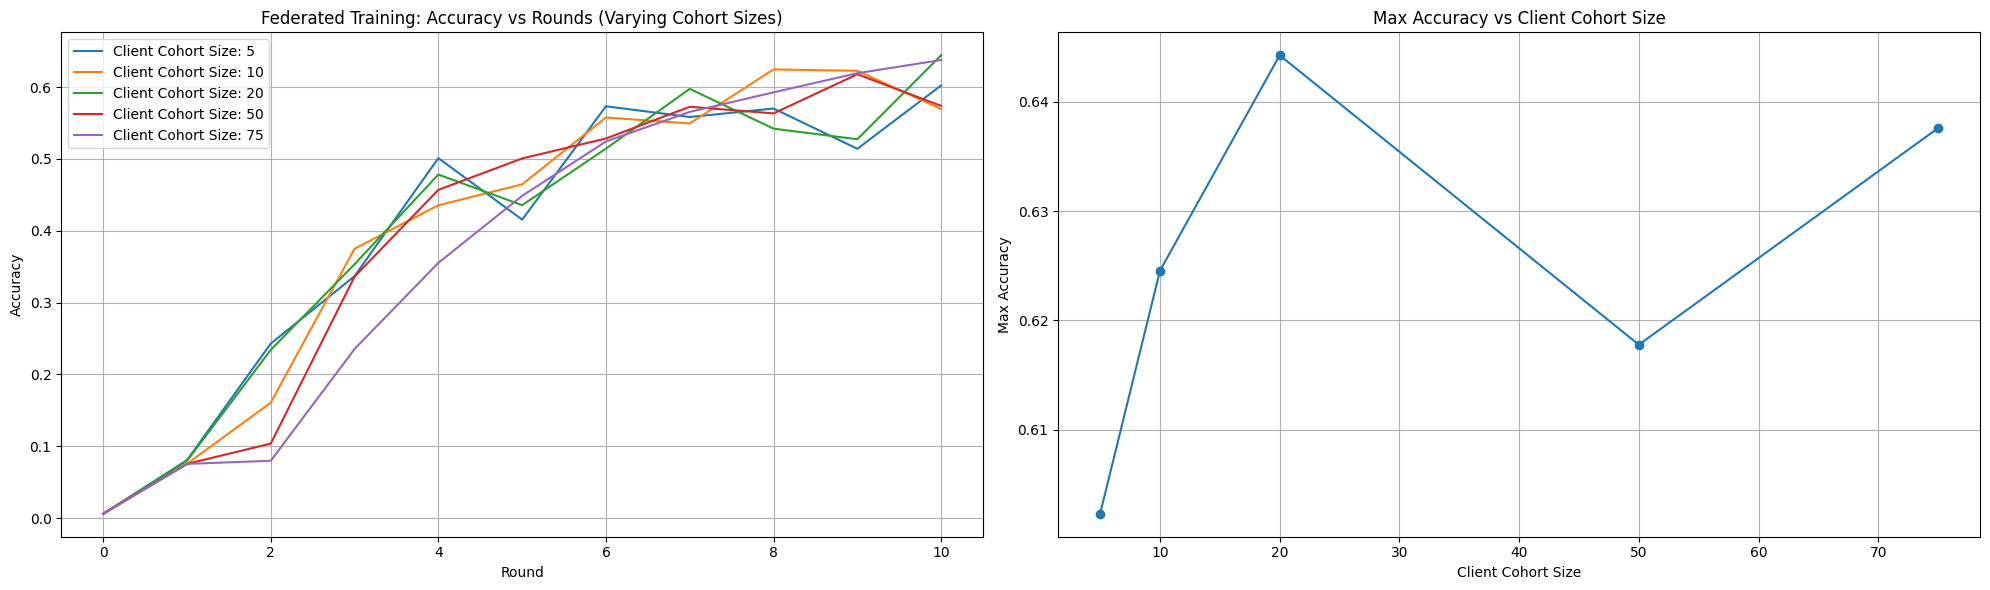

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Left subplot: Accuracy vs Rounds for each client cohort size
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    axes[0].plot(accuracies, label=f"Client Cohort Size: {cohort_size}")
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Federated Training: Accuracy vs Rounds (Varying Cohort Sizes)")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Max Accuracy vs Client Cohort Size
cohort_sizes = []
max_accuracies = []
for cohort_size, params, hist in total_cohort_results:
    accuracies = get_centralized_acc_from_hist(hist)
    if accuracies:
        cohort_sizes.append(cohort_size)
        max_accuracies.append(max(accuracies))
axes[1].plot(cohort_sizes, max_accuracies, marker='o')
axes[1].set_xlabel("Client Cohort Size")
axes[1].set_ylabel("Max Accuracy")
axes[1].set_title("Max Accuracy vs Client Cohort Size")
axes[1].grid(True)

plt.tight_layout()
plt.show()


When running experiment with varying client cohort sizes, we also observe that such thing as "ideal" client cohort number exists.

However, we have to investigate how to compute it.

**$\beta_\text{simple}$ integration into Federated Learning runs**


To implement the actual $\beta_\text{simple}$ ($\beta_\text{simple} \approx \beta_\text{crit}$) computation, we would need to change the client fit fn to return the gradients after training, and we would need to aggregate them in the server somehow.

In summary, we need to somehow get them to the hist or params object, and figure out a way to aggregate them.

This appears to give us a good estimate of the critical batch size. According to this estimates, the ideal batch size appears to be somewhere in the 16-64, and the optimal batch size we observe is actually 32, which is right in the middle of the range.

In [14]:
for cohort_size, params, hist in total_cohort_results:
    print("Cohort size: ", cohort_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches))       

Cohort size:  5
--- 33.259442510261344
--- 69.44474806549285
--- 24.71962597228674
--- 25.529585742014262
--- 27.999448902319802
--- 17.252070198604013
--- 23.8978069764787
--- 23.639841947498436
--- 19.87927985141141
--- 29.013205742855963
29.463505590922352
Cohort size:  10
--- 18.27280022168835
--- 53.37943313875189
--- 70.52678481162525
--- 49.56086805793303
--- 37.9172537008337
--- 20.892880567158972
--- 17.172474604739584
--- 15.454988069591233
--- 20.960023059762246
--- 24.905769578320125
32.90432758104044
Cohort size:  20
--- 15.900347877589098
--- 50.62993451581582
--- 47.142906273253665
--- 34.56381352864119
--- 37.14634589520751
--- 23.924999685470734
--- 21.928919989814844
--- 23.80902586659474
--- 14.956453220478991
--- 17.445154980055342
28.74479018329219
Cohort size:  50
--- 13.303760163955987
--- 19.3415138267822
--- 61.831460008293995
--- 45.56434960032927
--- 29.558238431463543
--- 27.577789378558155
--- 20.676925259583243
--- 17.706670868920227
--- 20.682278832204627